# Sequencial NN

In [198]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from config.config import *
from config.constants import *
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.model_selection import train_test_split

In [199]:
def plot_model(hist):
    fig, axs = plt.subplots(nrows=1, figsize=(11, 9))
    plt.rcParams['font.size'] = '14'

    for label in (axs.get_xticklabels() + axs.get_yticklabels()):
        label.set_fontsize(14)    

    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])

    axs.set_title('Model Accuracy')
    axs.set_ylabel('Accuracy', fontsize=14)
    axs.set_xlabel('Epoch', fontsize=14)
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    print("Model has training accuracy of {:.2f}%".format(hist.history['accuracy'][-1]*100))

In [206]:
def pre_process_split(path):
    
    dataset = pd.read_csv(path)
    dataset.dropna(inplace = True)
    
    # assigning new column names to the dataframe
    # dataset.columns = constants.cols + ['label']
    
    # creating training set ignoring labels
    train_data = dataset[dataset.columns[:-1]].values
    labels = dataset['label'].values
    n_class = len(set(labels))
    
    X_train, X_test, y_train, y_test =   train_test_split(train_data, labels, test_size=0.20)

    X_train = X_train.reshape(-1, 1, train_data.shape[1])
    X_test  = X_test.reshape(-1, 1, train_data.shape[1])
    y_train = y_train.reshape(-1, 1, 1)
    y_test = y_test.reshape(-1, 1, 1)
    
    return X_train, X_test, y_train, y_test, n_class

In [201]:
def model_config_train(name,eps,bs,actvn,datalink):
    
    print("processing dataset")
    X_train, X_test, y_train, y_test, n_class = pre_process_split(datalink)
    print(n_class)
    model = Sequential()
    model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(n_class, activation=actvn))
    print(model.summary())
       
    chk = ModelCheckpoint(name+'.pkl',save_best_only=True, mode='auto', verbose=1)
    print("saving as:",name+'.pkl')
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    hist = model.fit(X_train, y_train, epochs=eps, batch_size=bs, callbacks=[chk], validation_split=0.2)
    
    plot_model(hist)
    
    return model

## Loading dataset for binary classifier

In [202]:
def plotter(plot_data,unique_labels,n_plots):
    
    data = plot_data.copy()
    predicted_labels = data['label']
    #print(len(set(predicted_labels)),unique_labels)
    #print(Counter(predicted_labels).values(),[unique_labels[each] for each in Counter(predicted_labels).keys()])
    
    matrics = sorted(zip([unique_labels[each] for each in Counter(predicted_labels).keys()],Counter(predicted_labels).values() ), key=lambda x: x[1])
    
    score = [list(j) for j in matrics][::-1]
    
    
    
    total = sum([i[1] for i in score])

    c=0
    for i in score:

        score[c][1] = str(round(i[1]*100/total,2))+"%"
        #print("Fault type:", i[-1], "Percentage: {:.2f}%".format(i[1]*100/total))
        c+=1

    print(pd.DataFrame.from_records(score,columns=['Fault type','Percentage']))
    
    #print("changing numbers to labels again")
    data['label'] = [unique_labels[i] for i in predicted_labels]

    fig, ax = plt.subplots(n_plots,figsize=(15,4*n_plots))

    for j in range(n_plots):

        legend_list = []
        for i in range(len(set(predicted_labels))):

            extract = data[data.label==unique_labels[i]][cols[j]]    

            #print(len(extract))
            if unique_labels[i]==score[0][0] and score[0][0]!='NML' or unique_labels[i]== 'FAULT':
                temp = ax[j].scatter(extract.index,extract,marker='+',s=40)
            else:
                temp = ax[j].scatter(extract.index,extract,marker='.',s=10)


            legend_list.append(temp)

        ax[j].legend(legend_list,unique_labels,scatterpoints=3,ncol=1,fontsize=15)

    fig.tight_layout()
    plt.show()

    return score[0][0]

In [203]:
def tester(model,frame):
    
    data = frame
    
    cols = ['A'+str(each+1) for each in range(int(col_len/2))] + ['V'+str(each+1) for each in range(int(col_len/2))]
    
    if data.shape[1]==6:
        data.columns = cols
    elif data.shape[1]==7:
        data.columns = cols + ['label']
        data = data[cols]
    else:
        print("columns length is ",data.shape[1])
    
    
    test_preds = model.predict(data.values.reshape(-1,1,6).tolist())
    predicted_labels = np.argmax(test_preds,axis=1)
    
    data['label'] = predicted_labels
    
    return data
    

## Testing the models

processing dataset
2
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               42800     
_________________________________________________________________
dense (Dense)                (None, 2)                 202       
Total params: 43,002
Trainable params: 43,002
Non-trainable params: 0
_________________________________________________________________
None
saving as: binary_clf.pkl
Epoch 1/20
704/704 [==============================] - 18s 8ms/step - loss: 0.1642 - accuracy: 0.9469 - val_loss: 0.0825 - val_accuracy: 0.9734

Epoch 00001: val_loss improved from inf to 0.08246, saving model to binary_clf.pkl


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


Epoch 2/20
704/704 [==============================] - 6s 8ms/step - loss: 0.0826 - accuracy: 0.9728 - val_loss: 0.0802 - val_accuracy: 0.9735

Epoch 00002: val_loss improved from 0.08246 to 0.08019, saving model to binary_clf.pkl


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


Epoch 3/20
704/704 [==============================] - 6s 9ms/step - loss: 0.0814 - accuracy: 0.9739 - val_loss: 0.0793 - val_accuracy: 0.9758

Epoch 00003: val_loss improved from 0.08019 to 0.07931, saving model to binary_clf.pkl


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


Epoch 4/20
704/704 [==============================] - 7s 10ms/step - loss: 0.0800 - accuracy: 0.9745 - val_loss: 0.0786 - val_accuracy: 0.9757

Epoch 00004: val_loss improved from 0.07931 to 0.07861, saving model to binary_clf.pkl


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


Epoch 5/20
704/704 [==============================] - 7s 10ms/step - loss: 0.0804 - accuracy: 0.9745 - val_loss: 0.0783 - val_accuracy: 0.9759

Epoch 00005: val_loss improved from 0.07861 to 0.07834, saving model to binary_clf.pkl


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


Epoch 6/20
704/704 [==============================] - 6s 9ms/step - loss: 0.0788 - accuracy: 0.9752 - val_loss: 0.0780 - val_accuracy: 0.9745

Epoch 00006: val_loss improved from 0.07834 to 0.07798, saving model to binary_clf.pkl


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


Epoch 7/20
704/704 [==============================] - 6s 9ms/step - loss: 0.0795 - accuracy: 0.9747 - val_loss: 0.0779 - val_accuracy: 0.9755

Epoch 00007: val_loss improved from 0.07798 to 0.07789, saving model to binary_clf.pkl


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


Epoch 8/20
704/704 [==============================] - 6s 9ms/step - loss: 0.0789 - accuracy: 0.9749 - val_loss: 0.0787 - val_accuracy: 0.9760

Epoch 00008: val_loss did not improve from 0.07789
Epoch 9/20
704/704 [==============================] - 6s 9ms/step - loss: 0.0782 - accuracy: 0.9750 - val_loss: 0.0781 - val_accuracy: 0.9760

Epoch 00009: val_loss did not improve from 0.07789
Epoch 10/20
704/704 [==============================] - 6s 9ms/step - loss: 0.0785 - accuracy: 0.9752 - val_loss: 0.0766 - val_accuracy: 0.9760

Epoch 00010: val_loss improved from 0.07789 to 0.07656, saving model to binary_clf.pkl


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


Epoch 11/20
704/704 [==============================] - 6s 9ms/step - loss: 0.0785 - accuracy: 0.9752 - val_loss: 0.0766 - val_accuracy: 0.9755

Epoch 00011: val_loss did not improve from 0.07656
Epoch 12/20
704/704 [==============================] - 7s 10ms/step - loss: 0.0781 - accuracy: 0.9751 - val_loss: 0.0761 - val_accuracy: 0.9764

Epoch 00012: val_loss improved from 0.07656 to 0.07606, saving model to binary_clf.pkl


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


Epoch 13/20
704/704 [==============================] - 7s 10ms/step - loss: 0.0786 - accuracy: 0.9748 - val_loss: 0.0772 - val_accuracy: 0.9760

Epoch 00013: val_loss did not improve from 0.07606
Epoch 14/20
704/704 [==============================] - 9s 12ms/step - loss: 0.0775 - accuracy: 0.9753 - val_loss: 0.0765 - val_accuracy: 0.9755

Epoch 00014: val_loss did not improve from 0.07606
Epoch 15/20
704/704 [==============================] - 8s 12ms/step - loss: 0.0779 - accuracy: 0.9752 - val_loss: 0.0773 - val_accuracy: 0.9763

Epoch 00015: val_loss did not improve from 0.07606
Epoch 16/20
704/704 [==============================] - 7s 10ms/step - loss: 0.0780 - accuracy: 0.9754 - val_loss: 0.0772 - val_accuracy: 0.9762

Epoch 00016: val_loss did not improve from 0.07606
Epoch 17/20
704/704 [==============================] - 7s 10ms/step - loss: 0.0779 - accuracy: 0.9754 - val_loss: 0.0763 - val_accuracy: 0.9758

Epoch 00017: val_loss did not improve from 0.07606
Epoch 18/20
704/704 

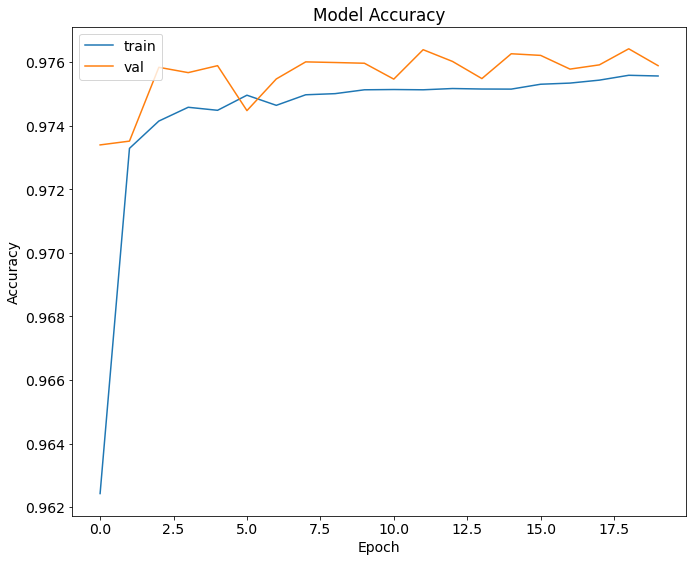

Model has training accuracy of 97.56%


In [207]:
model_config_train('binary_clf',20,2000,'softmax','./KMTrainingSet/binary/bin_dataset_simulink.csv')

processing dataset
11
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               42800     
_________________________________________________________________
dense_1 (Dense)              (None, 11)                1111      
Total params: 43,911
Trainable params: 43,911
Non-trainable params: 0
_________________________________________________________________
None
saving as: multi_clf.pkl
Epoch 1/20
92/92 [==============================] - 4s 18ms/step - loss: 1.6490 - accuracy: 0.5855 - val_loss: 0.7116 - val_accuracy: 0.8784

Epoch 00001: val_loss improved from inf to 0.71158, saving model to multi_clf.pkl


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


Epoch 2/20
92/92 [==============================] - 1s 12ms/step - loss: 0.5876 - accuracy: 0.8787 - val_loss: 0.3553 - val_accuracy: 0.8824

Epoch 00002: val_loss improved from 0.71158 to 0.35529, saving model to multi_clf.pkl


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


Epoch 3/20
92/92 [==============================] - 1s 12ms/step - loss: 0.3251 - accuracy: 0.8823 - val_loss: 0.2651 - val_accuracy: 0.8882

Epoch 00003: val_loss improved from 0.35529 to 0.26514, saving model to multi_clf.pkl


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


Epoch 4/20
92/92 [==============================] - 1s 13ms/step - loss: 0.2559 - accuracy: 0.8864 - val_loss: 0.2353 - val_accuracy: 0.8873

Epoch 00004: val_loss improved from 0.26514 to 0.23531, saving model to multi_clf.pkl


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


Epoch 5/20
92/92 [==============================] - 1s 13ms/step - loss: 0.2322 - accuracy: 0.8873 - val_loss: 0.2237 - val_accuracy: 0.8899

Epoch 00005: val_loss improved from 0.23531 to 0.22372, saving model to multi_clf.pkl


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


Epoch 6/20
92/92 [==============================] - 1s 14ms/step - loss: 0.2213 - accuracy: 0.8881 - val_loss: 0.2162 - val_accuracy: 0.8871

Epoch 00006: val_loss improved from 0.22372 to 0.21622, saving model to multi_clf.pkl


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


Epoch 7/20
92/92 [==============================] - 1s 13ms/step - loss: 0.2143 - accuracy: 0.8883 - val_loss: 0.2117 - val_accuracy: 0.8864

Epoch 00007: val_loss improved from 0.21622 to 0.21169, saving model to multi_clf.pkl


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


Epoch 8/20
92/92 [==============================] - 1s 13ms/step - loss: 0.2094 - accuracy: 0.8885 - val_loss: 0.2074 - val_accuracy: 0.8892

Epoch 00008: val_loss improved from 0.21169 to 0.20742, saving model to multi_clf.pkl


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


Epoch 9/20
92/92 [==============================] - 1s 12ms/step - loss: 0.2057 - accuracy: 0.8899 - val_loss: 0.2047 - val_accuracy: 0.8886

Epoch 00009: val_loss improved from 0.20742 to 0.20467, saving model to multi_clf.pkl


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


Epoch 10/20
92/92 [==============================] - 1s 12ms/step - loss: 0.2047 - accuracy: 0.8901 - val_loss: 0.2028 - val_accuracy: 0.8920

Epoch 00010: val_loss improved from 0.20467 to 0.20275, saving model to multi_clf.pkl


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


Epoch 11/20
92/92 [==============================] - 1s 11ms/step - loss: 0.2027 - accuracy: 0.8899 - val_loss: 0.2012 - val_accuracy: 0.8927

Epoch 00011: val_loss improved from 0.20275 to 0.20118, saving model to multi_clf.pkl


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


Epoch 12/20
92/92 [==============================] - 1s 12ms/step - loss: 0.1997 - accuracy: 0.8920 - val_loss: 0.2006 - val_accuracy: 0.8920

Epoch 00012: val_loss improved from 0.20118 to 0.20063, saving model to multi_clf.pkl


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


Epoch 13/20
92/92 [==============================] - 1s 11ms/step - loss: 0.1996 - accuracy: 0.8915 - val_loss: 0.1987 - val_accuracy: 0.8927

Epoch 00013: val_loss improved from 0.20063 to 0.19871, saving model to multi_clf.pkl


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


Epoch 14/20
92/92 [==============================] - 1s 12ms/step - loss: 0.2000 - accuracy: 0.8899 - val_loss: 0.1994 - val_accuracy: 0.8919

Epoch 00014: val_loss did not improve from 0.19871
Epoch 15/20
92/92 [==============================] - 1s 12ms/step - loss: 0.2000 - accuracy: 0.8903 - val_loss: 0.1978 - val_accuracy: 0.8935

Epoch 00015: val_loss improved from 0.19871 to 0.19780, saving model to multi_clf.pkl


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


Epoch 16/20
92/92 [==============================] - 1s 12ms/step - loss: 0.1992 - accuracy: 0.8903 - val_loss: 0.1970 - val_accuracy: 0.8904

Epoch 00016: val_loss improved from 0.19780 to 0.19700, saving model to multi_clf.pkl


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


Epoch 17/20
92/92 [==============================] - 1s 12ms/step - loss: 0.1968 - accuracy: 0.8911 - val_loss: 0.1966 - val_accuracy: 0.8891

Epoch 00017: val_loss improved from 0.19700 to 0.19663, saving model to multi_clf.pkl


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


Epoch 18/20
92/92 [==============================] - 1s 12ms/step - loss: 0.1975 - accuracy: 0.8910 - val_loss: 0.1961 - val_accuracy: 0.8939

Epoch 00018: val_loss improved from 0.19663 to 0.19612, saving model to multi_clf.pkl


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


Epoch 19/20
92/92 [==============================] - 1s 13ms/step - loss: 0.1952 - accuracy: 0.8929 - val_loss: 0.1961 - val_accuracy: 0.8900

Epoch 00019: val_loss did not improve from 0.19612
Epoch 20/20
92/92 [==============================] - 1s 13ms/step - loss: 0.1975 - accuracy: 0.8912 - val_loss: 0.1958 - val_accuracy: 0.8950

Epoch 00020: val_loss improved from 0.19612 to 0.19582, saving model to multi_clf.pkl


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


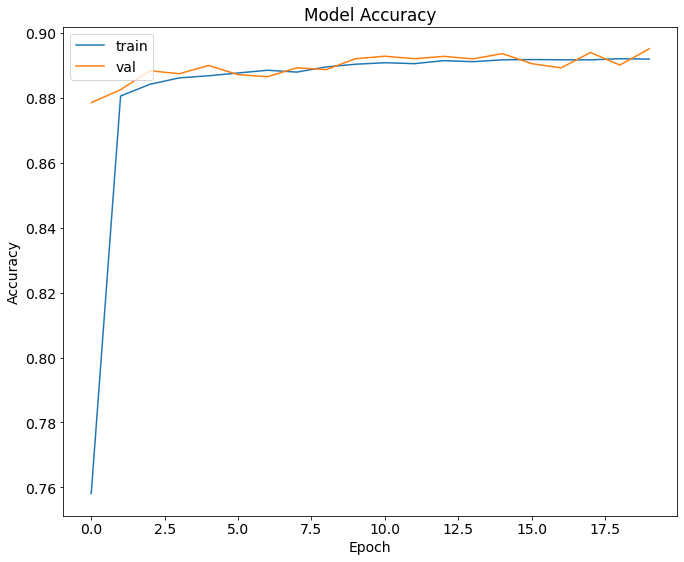

Model has training accuracy of 89.18%


In [208]:
model_config_train('multi_clf',20,2000,'softmax','./KMTrainingSet/multi/mul_dataset_simulink.csv')

In [209]:
binary_labels_list = ['NML','FAULT']
binary_model = load_model('binary_clf.pkl')

In [210]:
multi_labels_list = ['AB', 'AC', 'BC', 'ABC', 'AG', 'BG', 'ABG', 'CG', 'ACG', 'BCG', 'ABCG']
multi_model = load_model('multi_clf.pkl')

In [211]:
import os

In [212]:
# current directory
path = "./TrainingSet/"

# list of file of the given path is assigned to the variable 
file_list = [each for each in list(os.walk(path))[0][-1] if ".csv" in each]


.
.
 5ABCG.csv
  Fault type Percentage
0        NML     97.64%
1      FAULT      2.35%


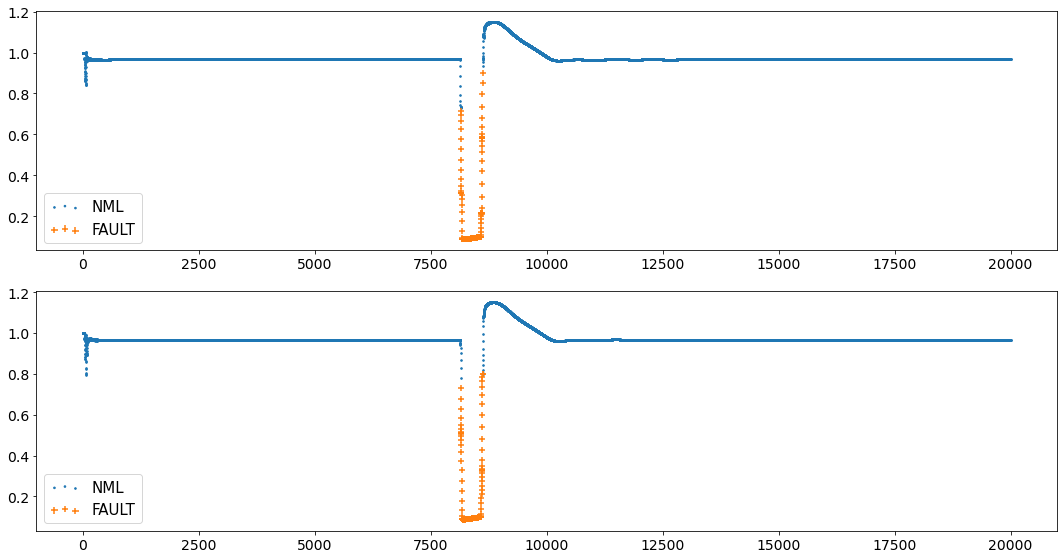

  Fault type Percentage
0        ABC     82.17%
1       ABCG     14.86%
2        BCG       1.7%
3        ACG      1.27%


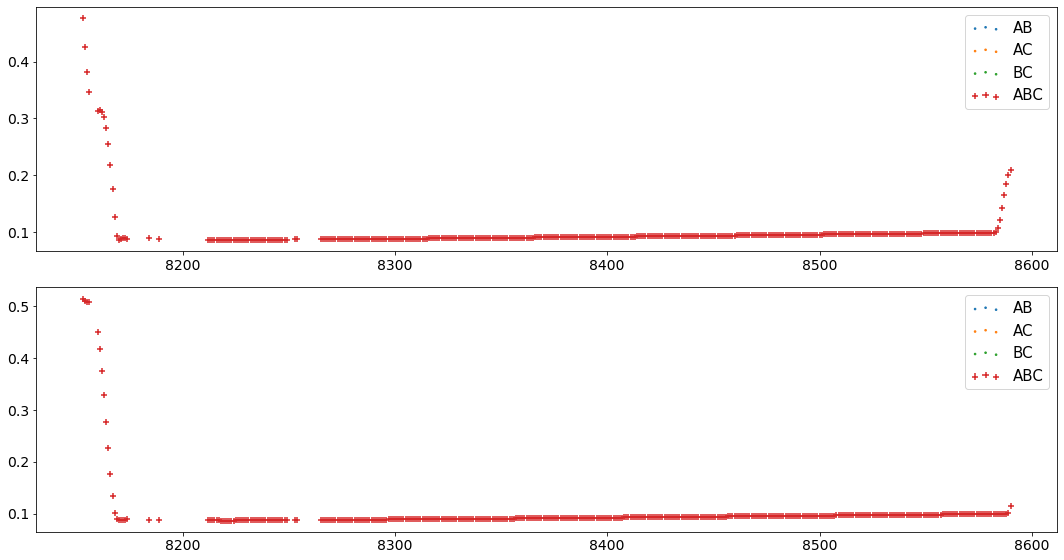


.
.
 10ABG.csv
  Fault type Percentage
0        NML     99.62%
1      FAULT      0.38%


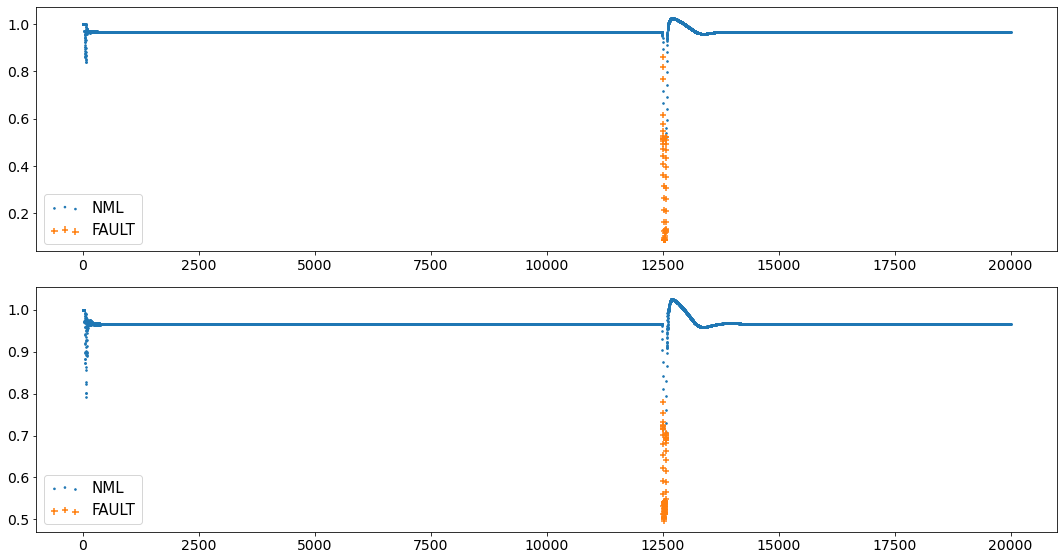

  Fault type Percentage
0        ABG     93.42%
1       ABCG      3.95%
2        BCG      2.63%


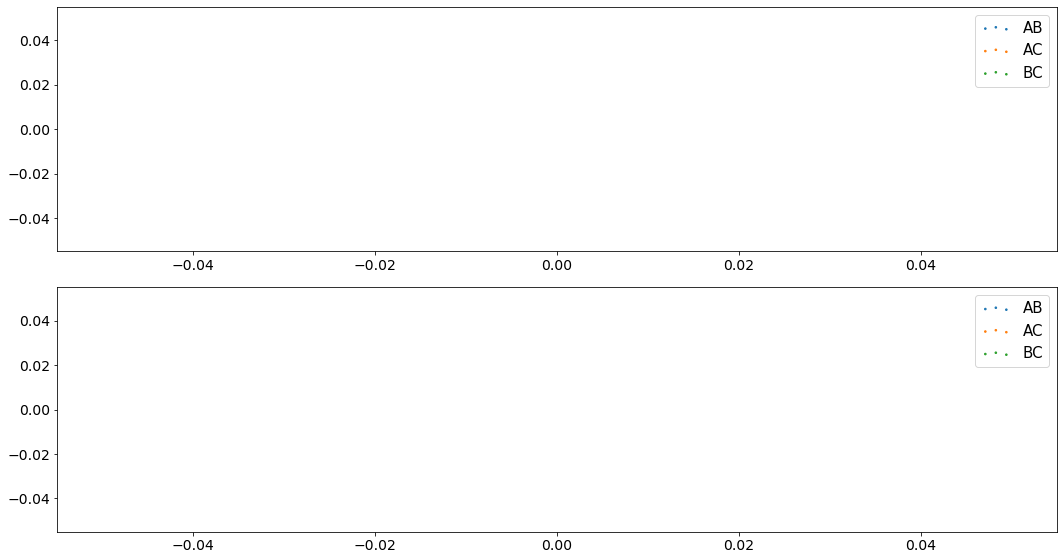


.
.
 3BC.csv
  Fault type Percentage
0        NML     99.81%
1      FAULT      0.19%


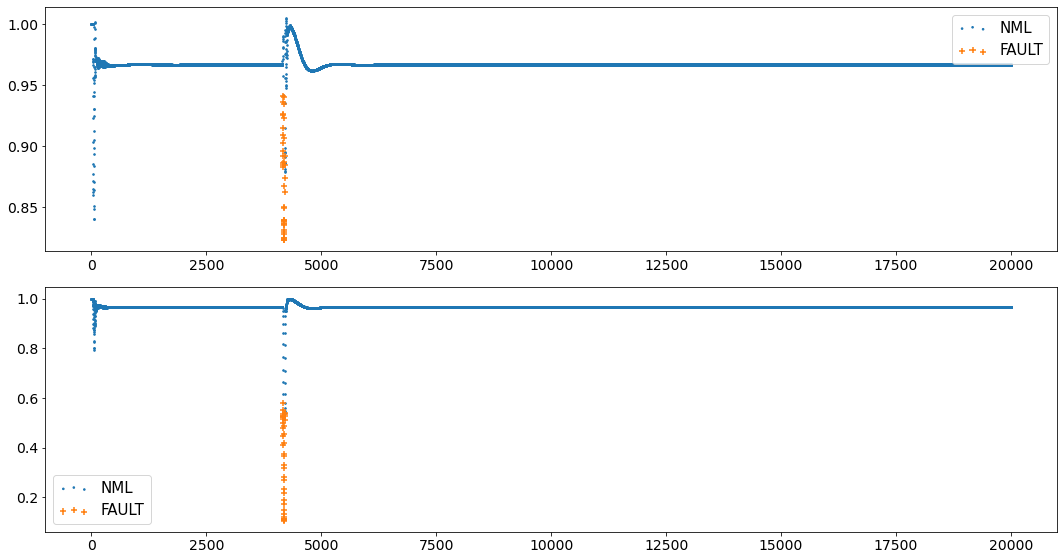

  Fault type Percentage
0         BC     97.37%
1        BCG      2.63%


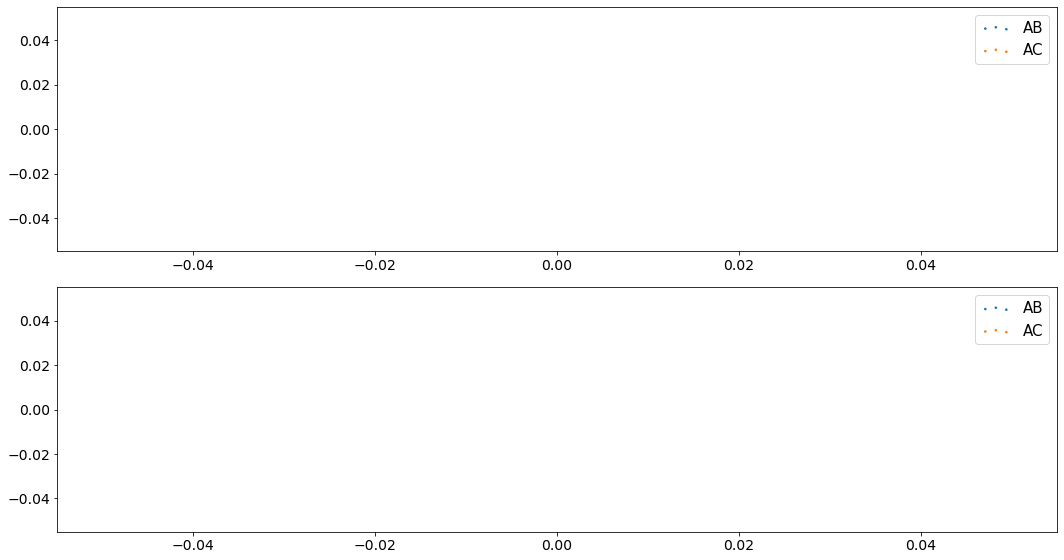


.
.
 3CG.csv
  Fault type Percentage
0        NML      85.8%
1      FAULT      14.2%


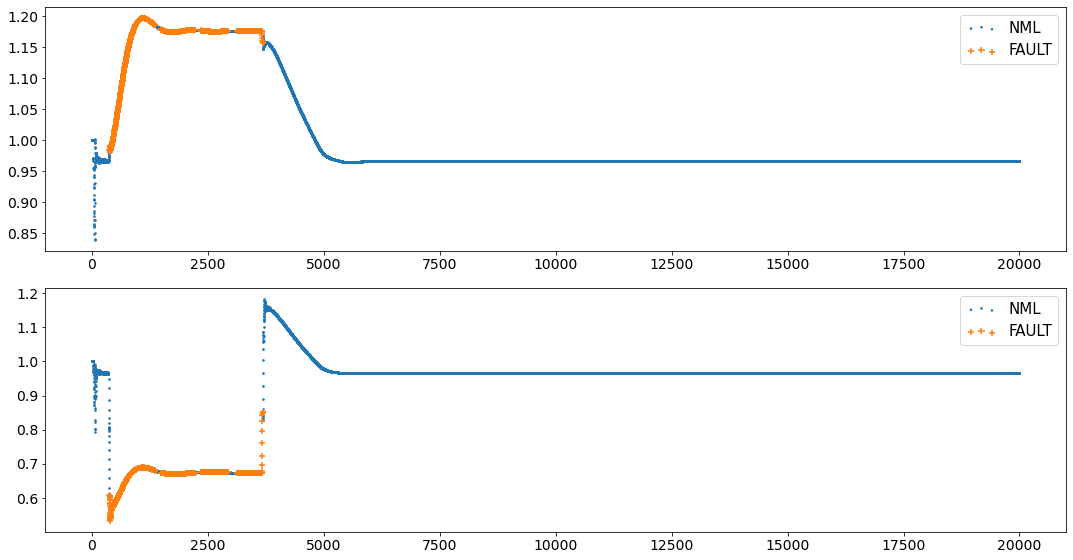

  Fault type Percentage
0         CG     100.0%


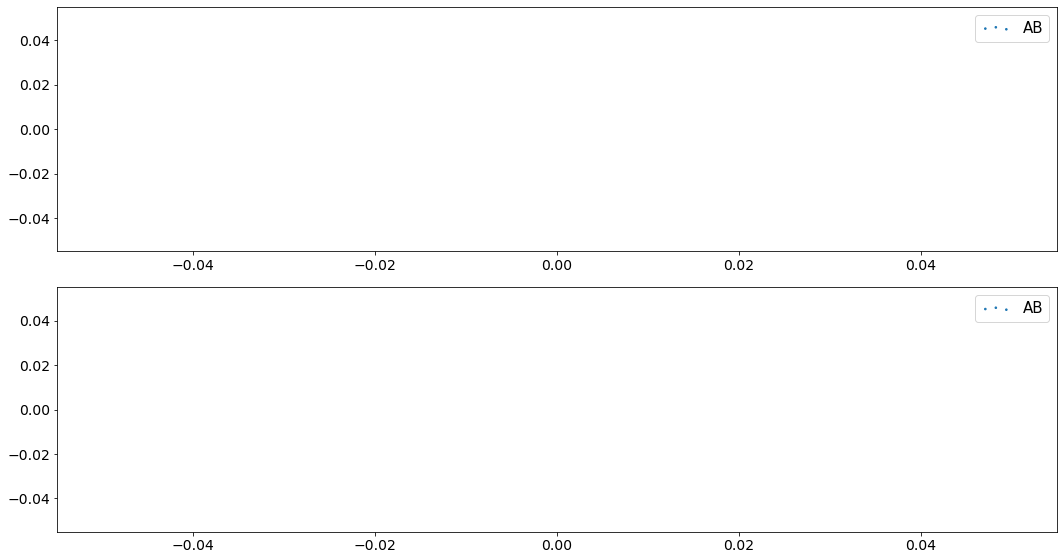


.
.
 1BCG.csv
  Fault type Percentage
0        NML      98.9%
1      FAULT       1.1%


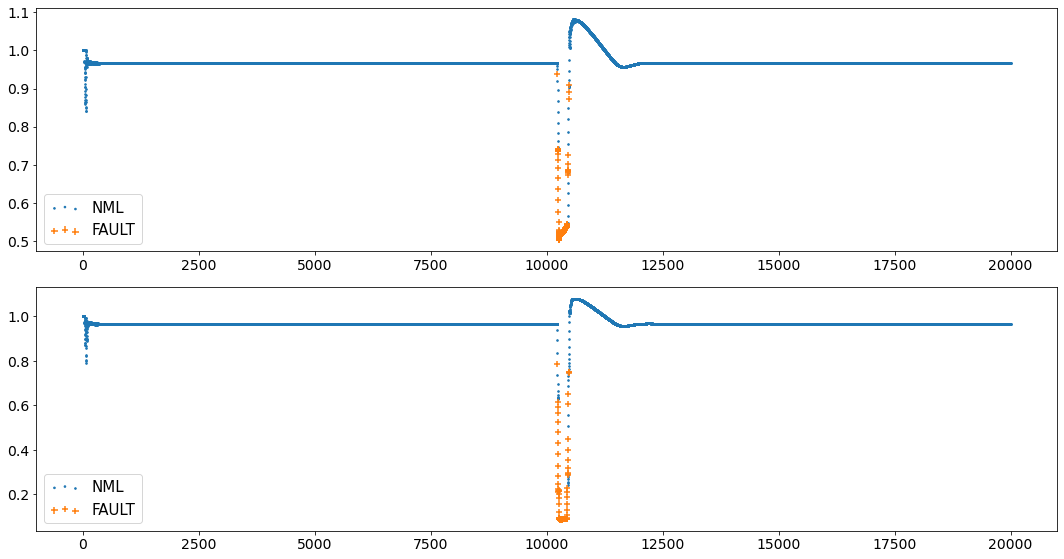

  Fault type Percentage
0        BCG     98.18%
1         BG      1.36%
2       ABCG      0.45%


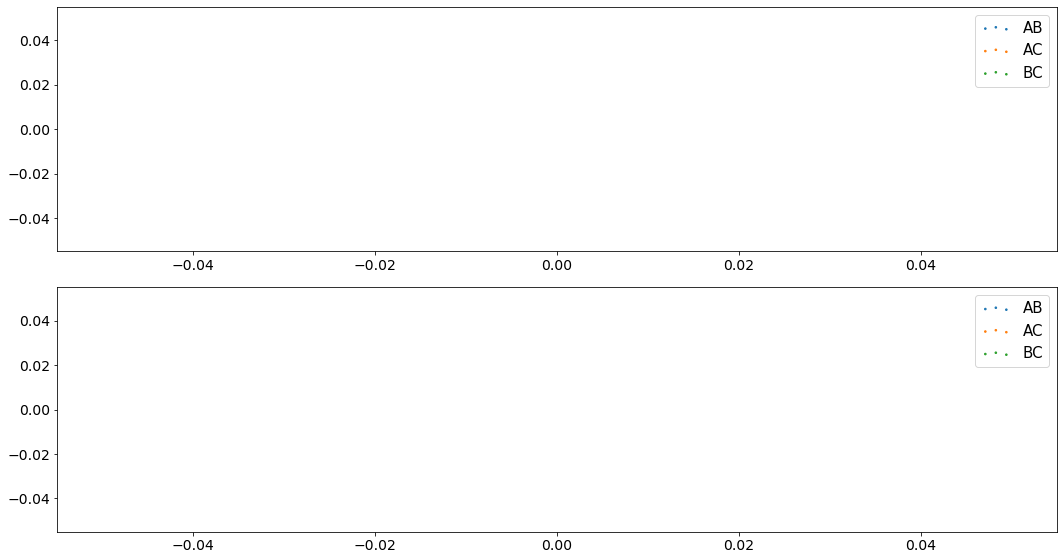


.
.
 7BG.csv
  Fault type Percentage
0        NML     87.78%
1      FAULT     12.22%


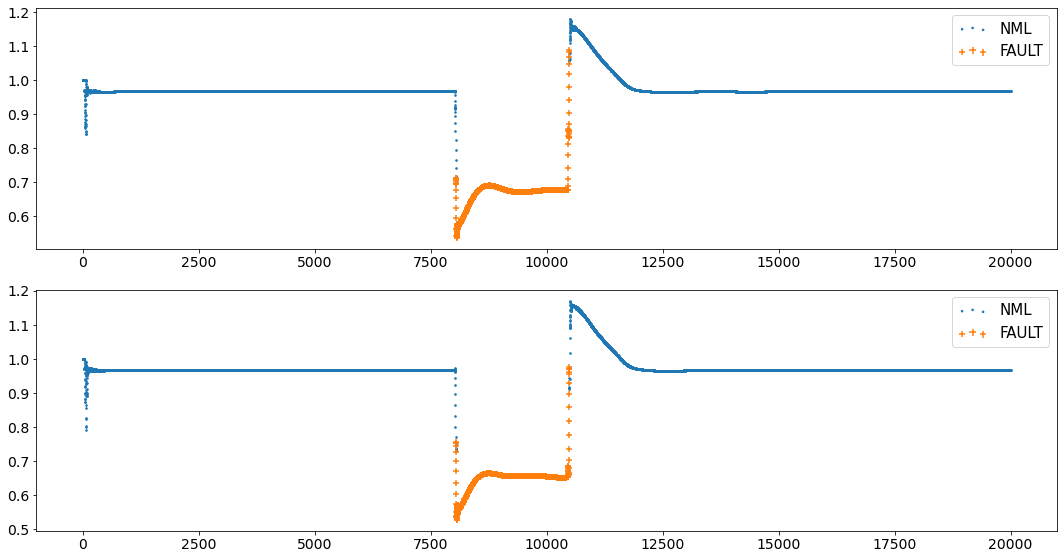

  Fault type Percentage
0         BG     100.0%


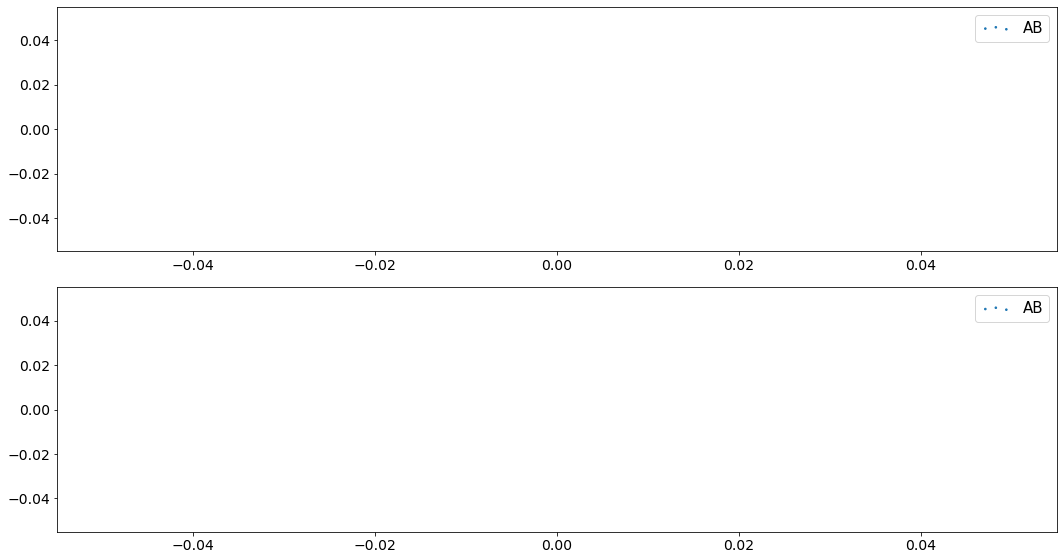


.
.
 5BG.csv
  Fault type Percentage
0        NML     61.34%
1      FAULT     38.66%


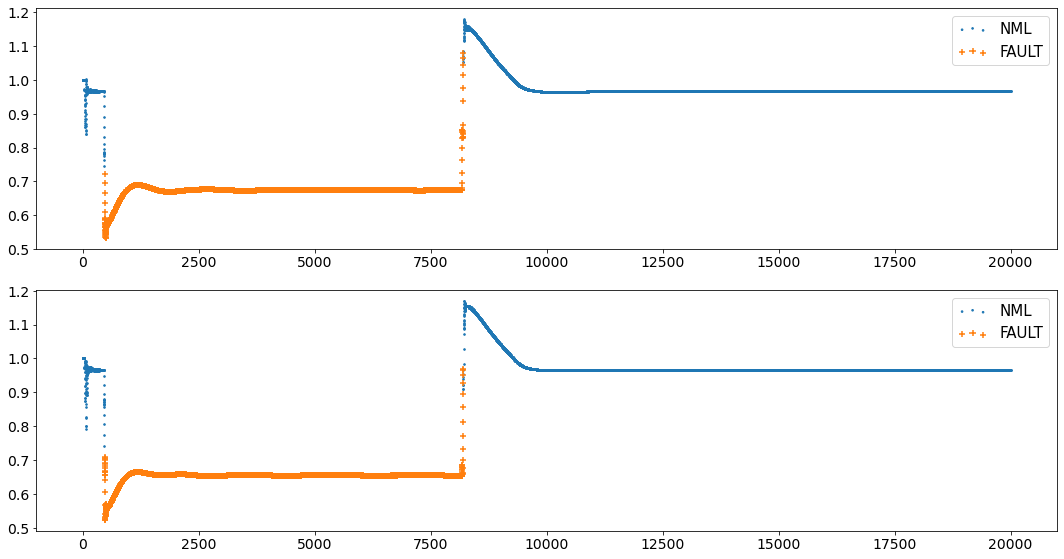

  Fault type Percentage
0         BG     100.0%


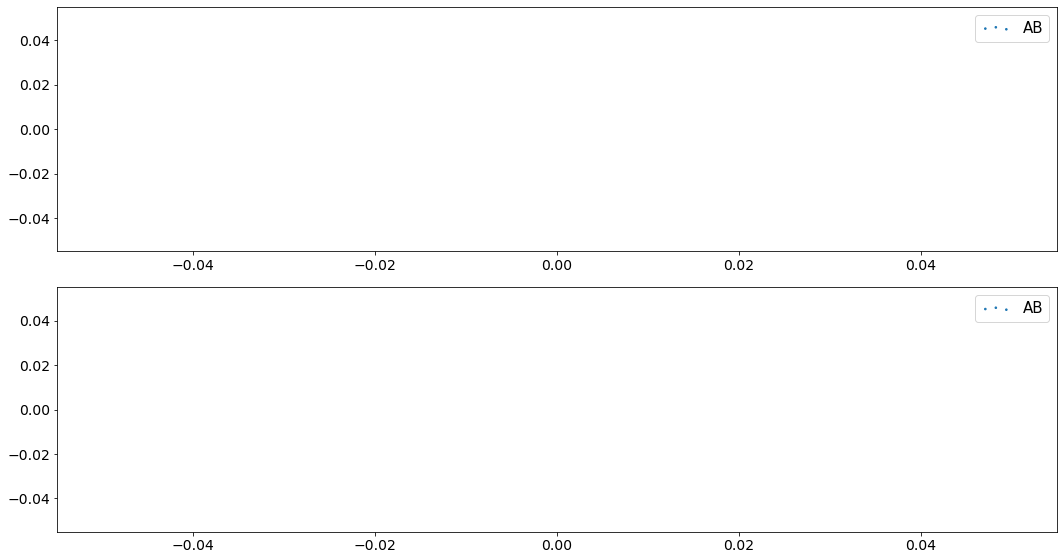


.
.
 9ABG.csv
  Fault type Percentage
0        NML     98.34%
1      FAULT      1.66%


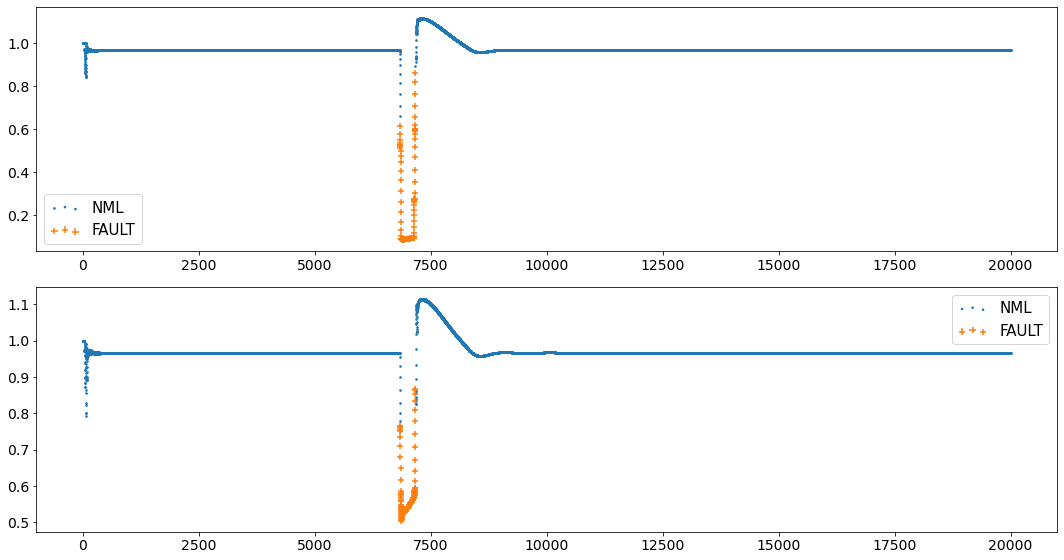

  Fault type Percentage
0        ABG     96.99%
1         BG      3.01%


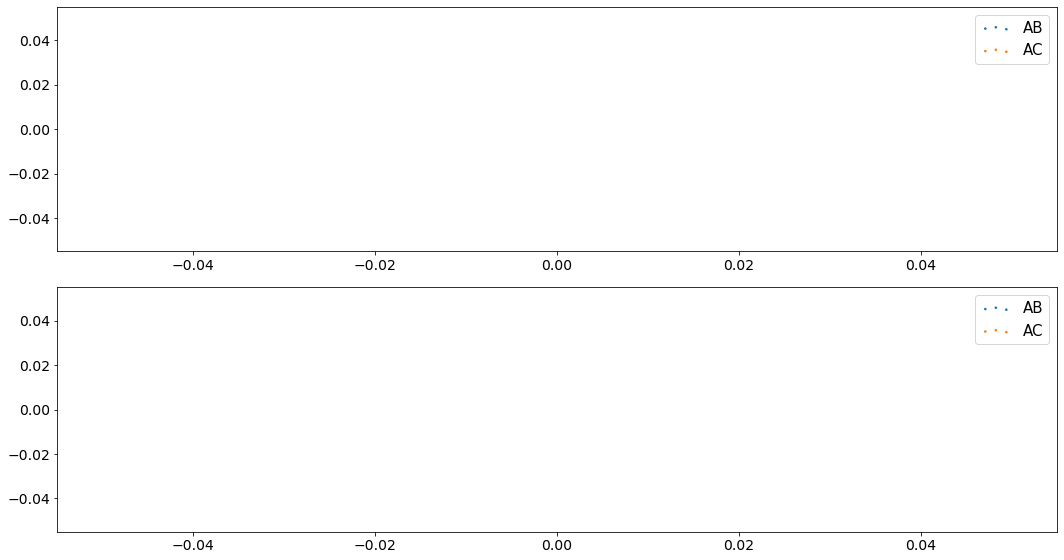


.
.
 1BC.csv
  Fault type Percentage
0        NML      74.7%
1      FAULT      25.3%


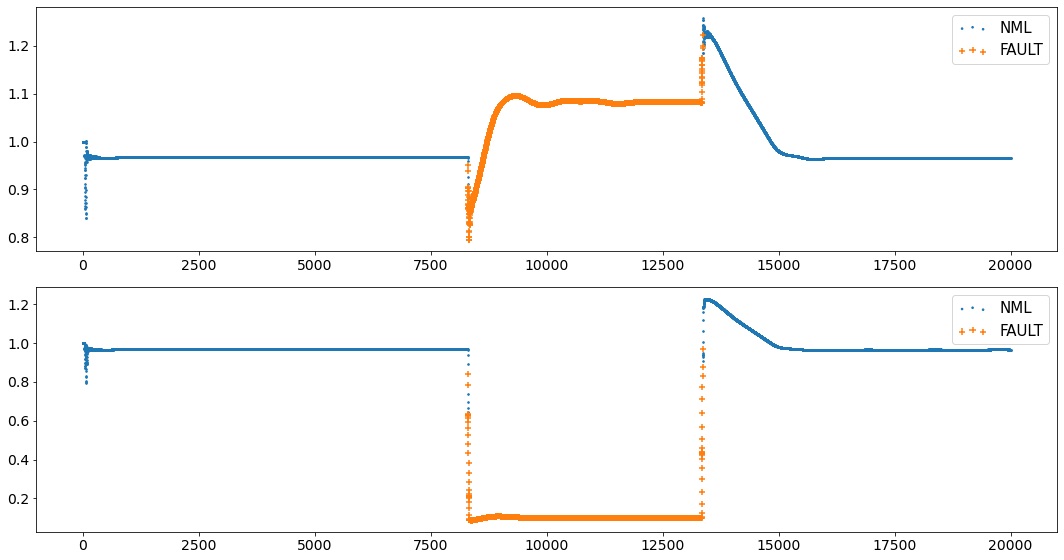

  Fault type Percentage
0         BC     99.92%
1       ABCG      0.06%
2        BCG      0.02%


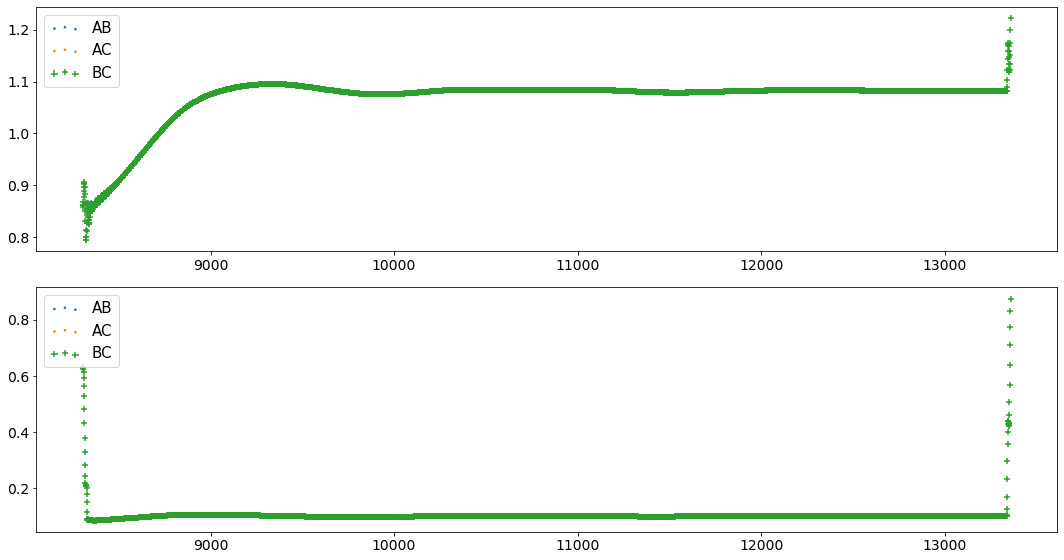


.
.
 1CG.csv
  Fault type Percentage
0        NML      99.2%
1      FAULT       0.8%


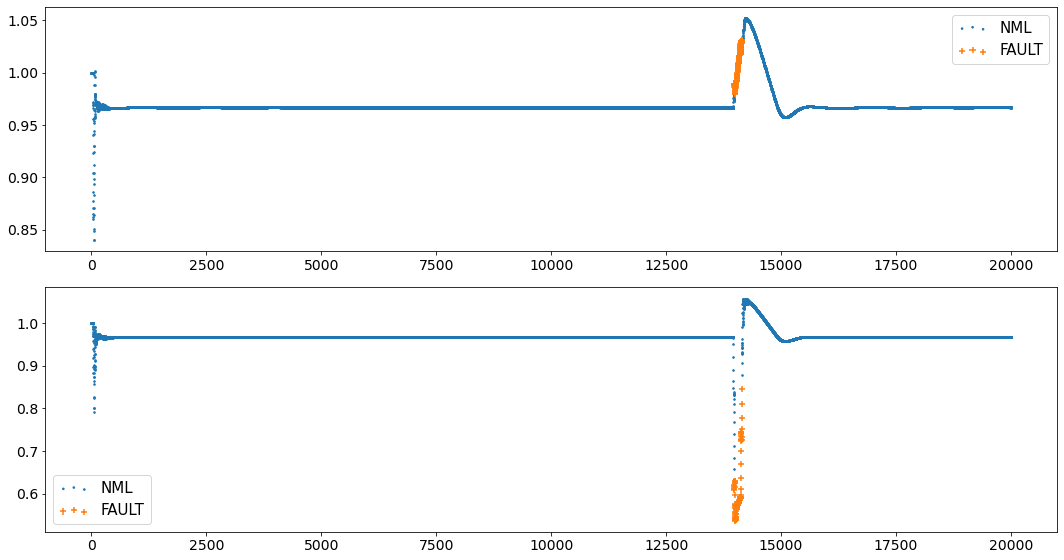

  Fault type Percentage
0         CG     100.0%


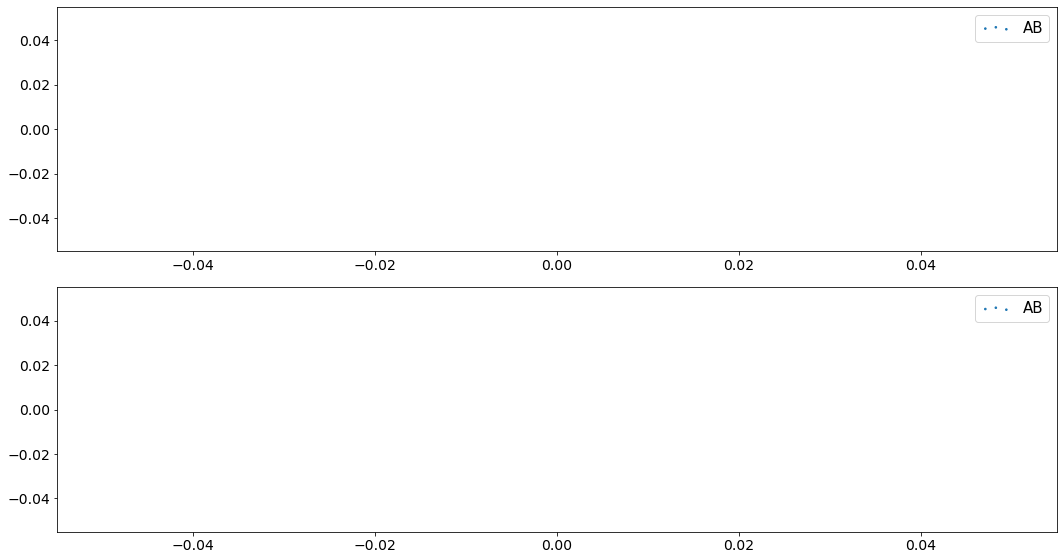


.
.
 5ABG.csv
  Fault type Percentage
0        NML     77.47%
1      FAULT     22.54%


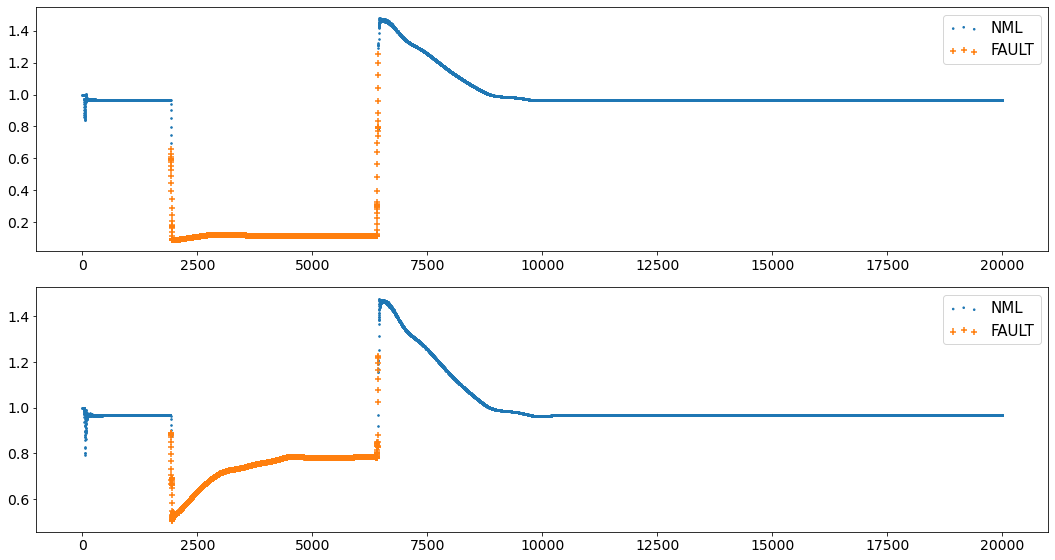

  Fault type Percentage
0        ABG     99.82%
1         BG      0.18%


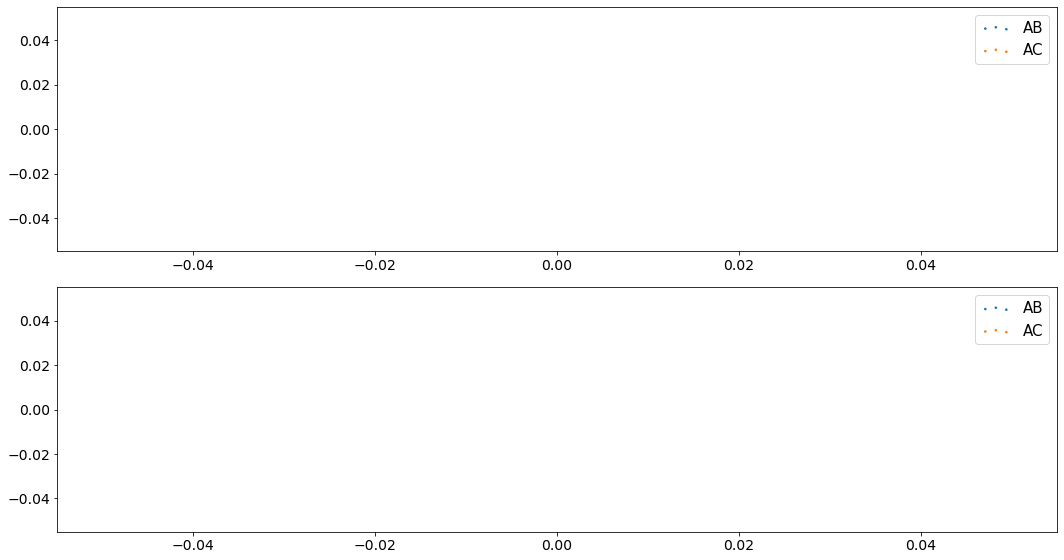


.
.
 9AG.csv
  Fault type Percentage
0        NML     66.92%
1      FAULT     33.09%


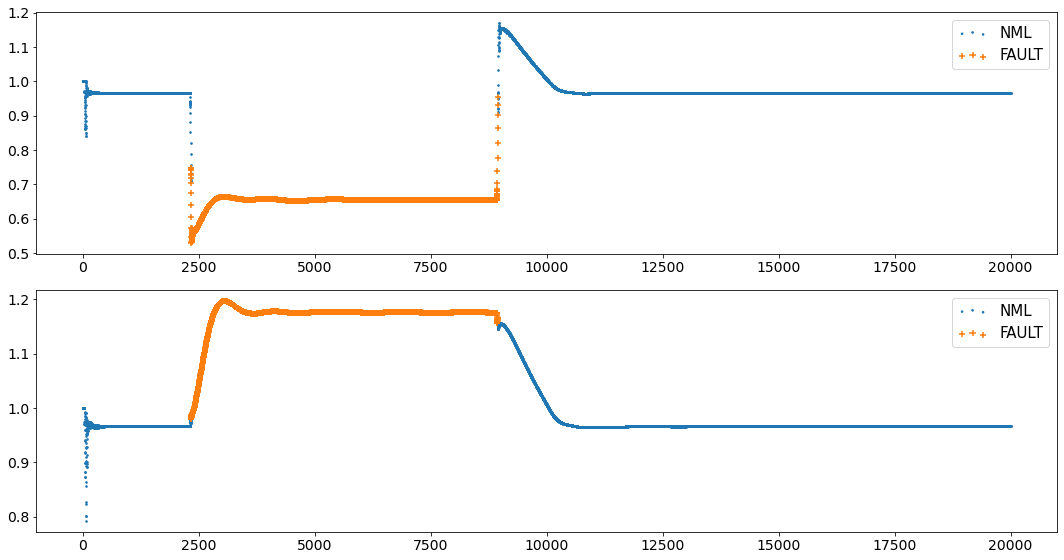

  Fault type Percentage
0         AG     100.0%


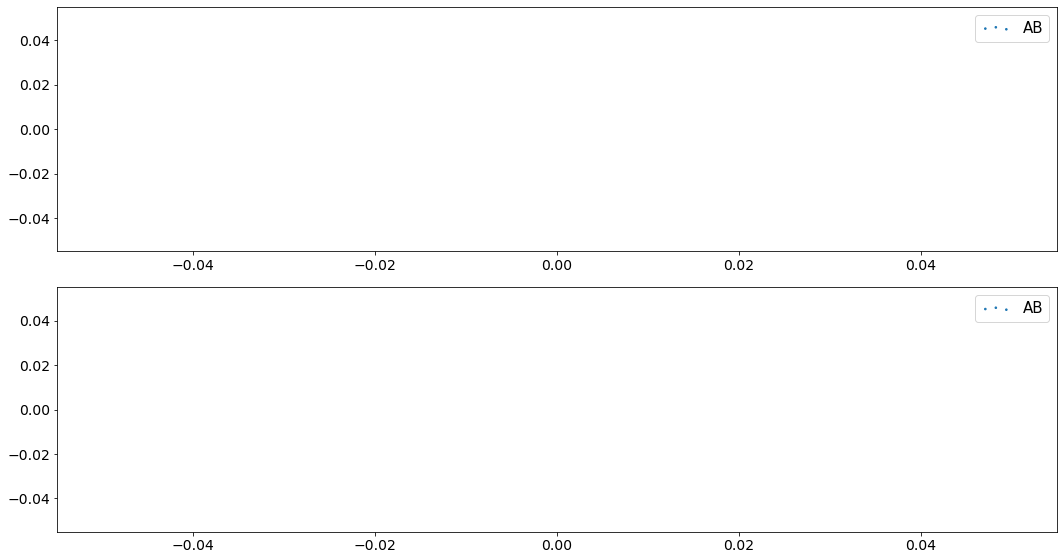


.
.
 7ABC.csv
  Fault type Percentage
0        NML     72.33%
1      FAULT     27.67%


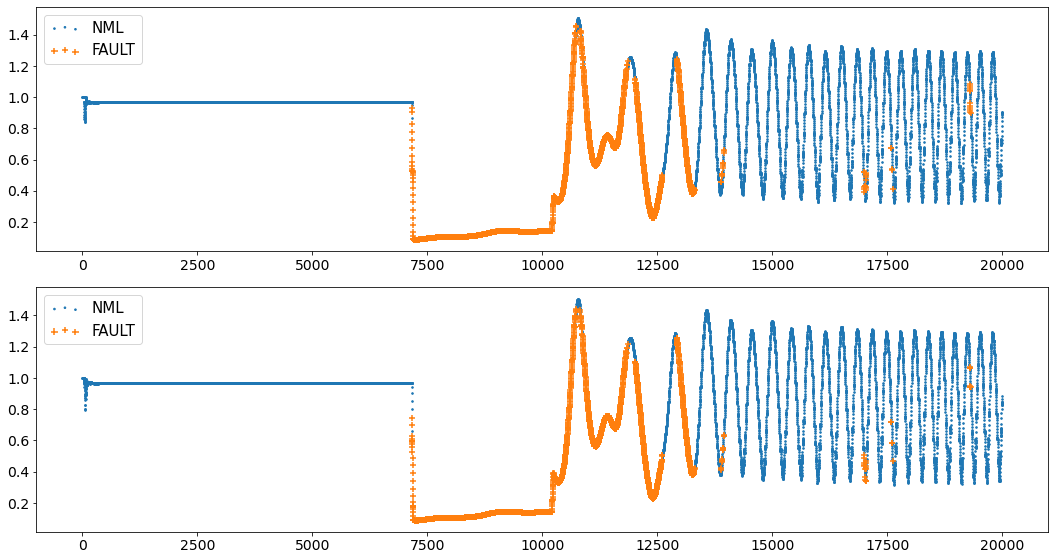

  Fault type Percentage
0        ABC      90.6%
1       ABCG      9.27%
2        BCG      0.13%


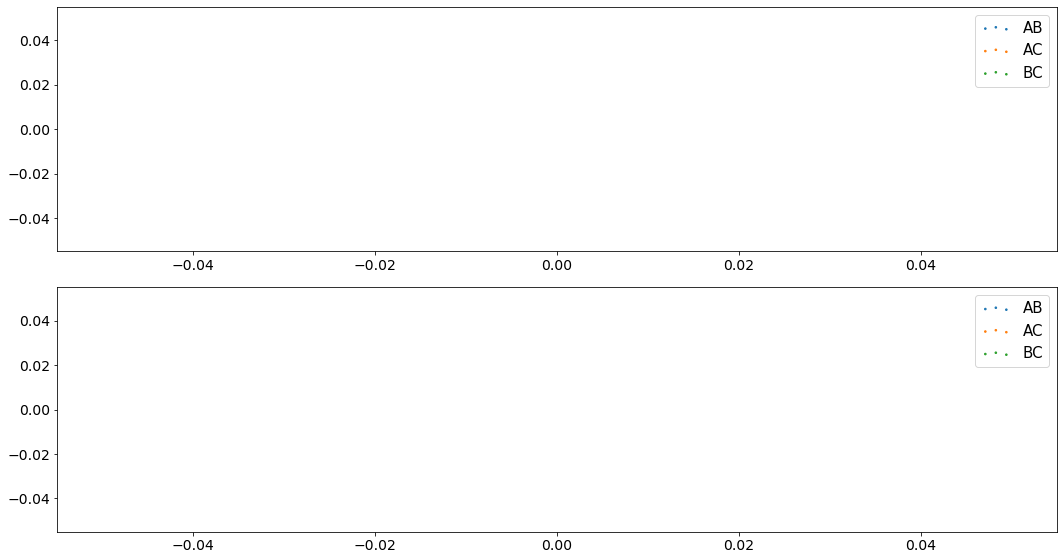


.
.
 7ACG.csv
  Fault type Percentage
0        NML     95.36%
1      FAULT      4.63%


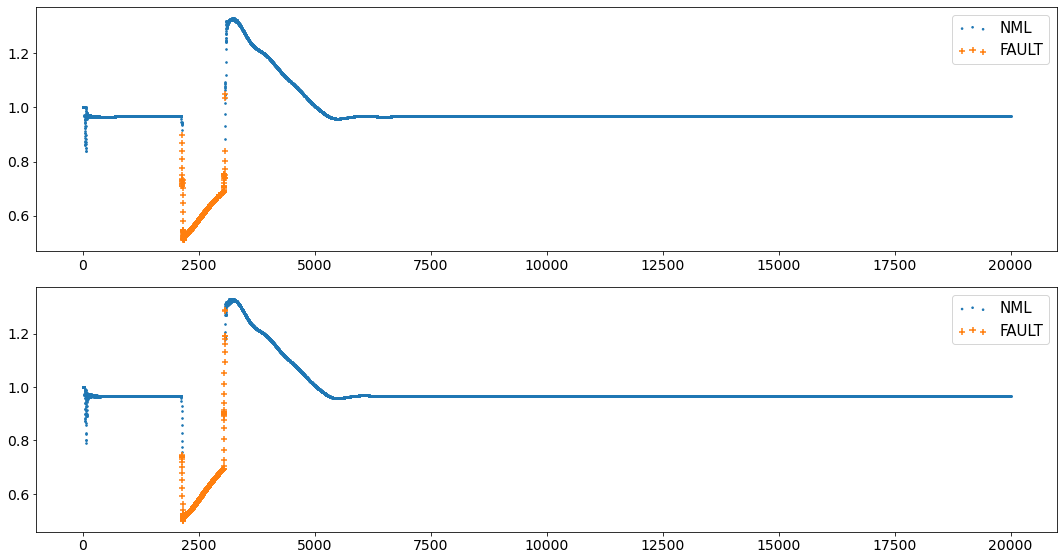

  Fault type Percentage
0        ACG     99.57%
1       ABCG      0.43%


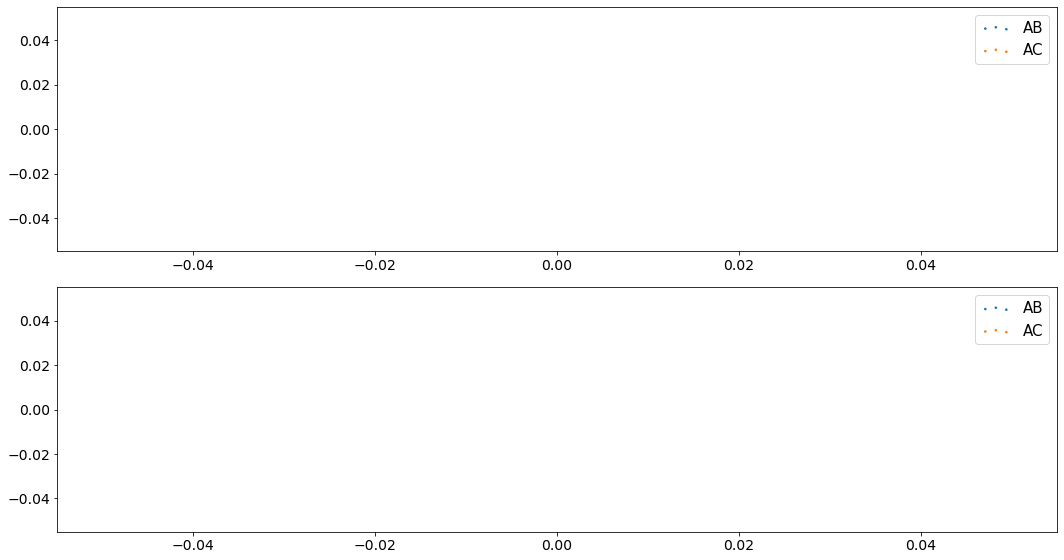


.
.
 7ABG.csv
  Fault type Percentage
0        NML     99.46%
1      FAULT      0.54%


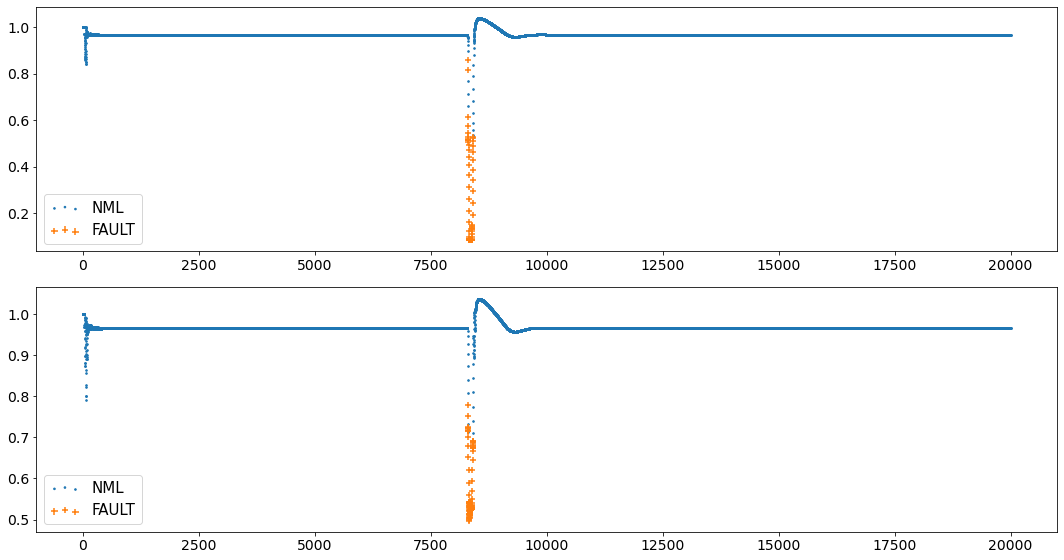

  Fault type Percentage
0        ABG      96.3%
1        BCG      1.85%
2       ABCG      1.85%


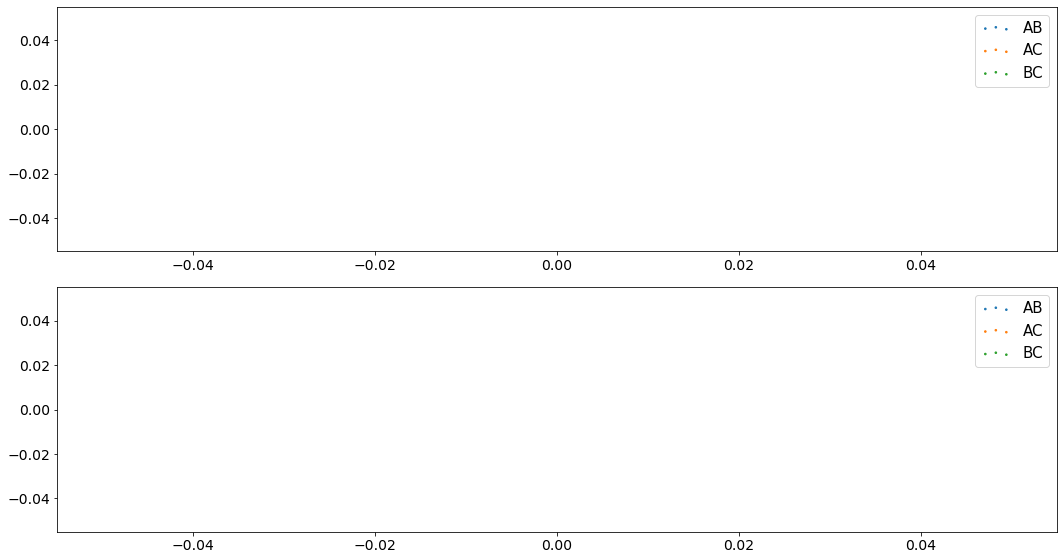


.
.
 9AC.csv
  Fault type Percentage
0        NML      98.0%
1      FAULT       2.0%


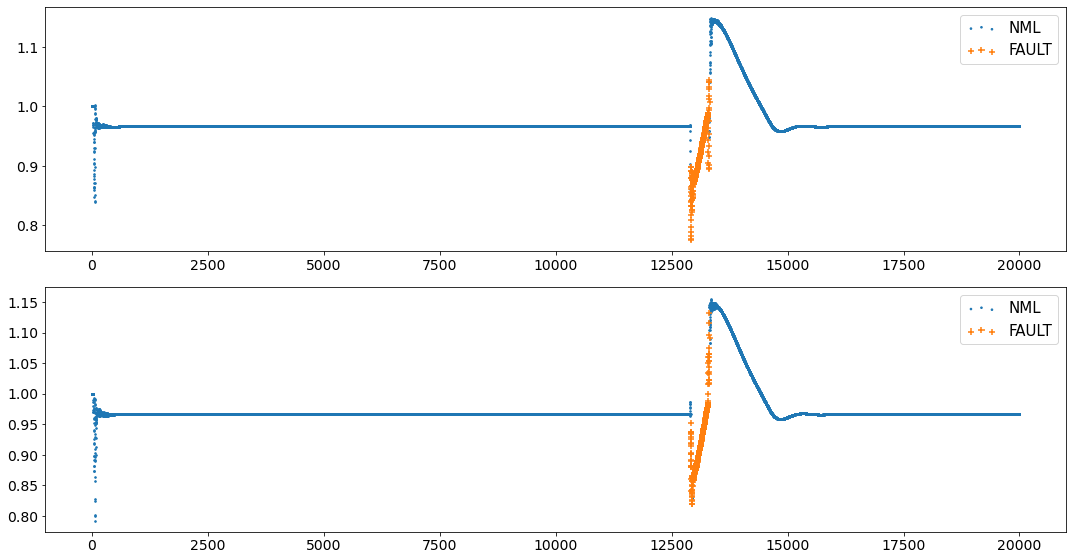

  Fault type Percentage
0         AC     98.25%
1        ACG       1.5%
2       ABCG      0.25%


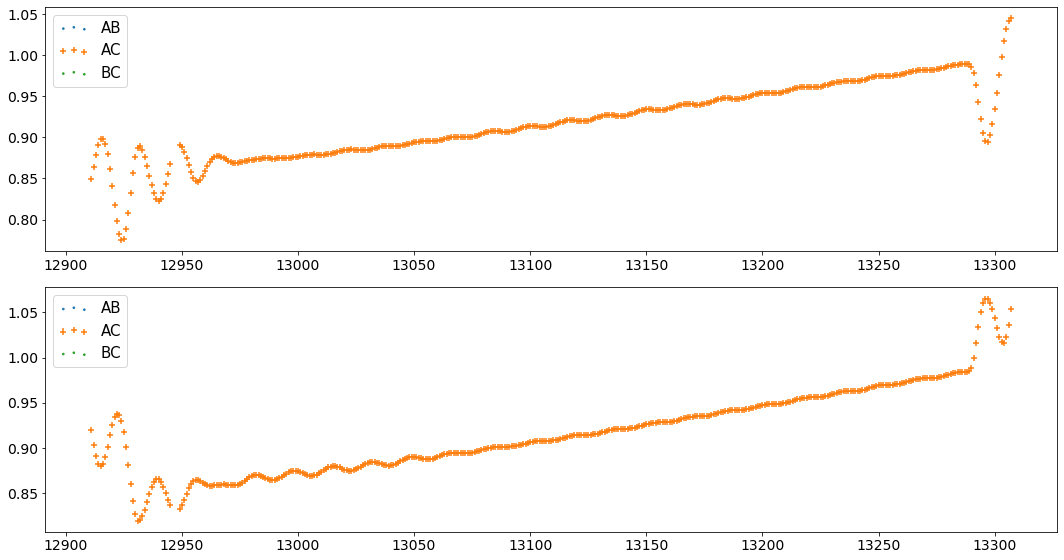


.
.
 1BG.csv
  Fault type Percentage
0        NML     86.91%
1      FAULT      13.1%


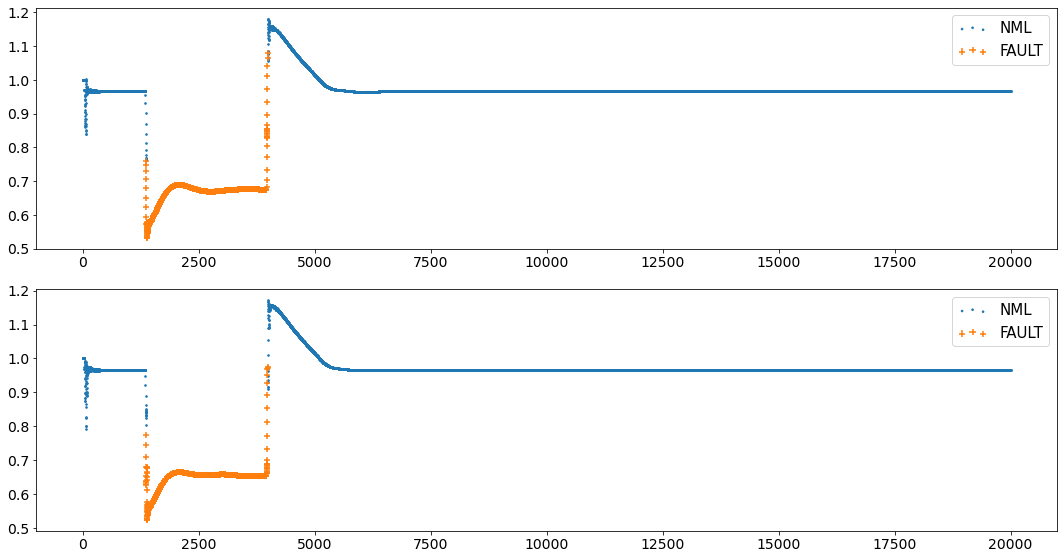

  Fault type Percentage
0         BG     100.0%


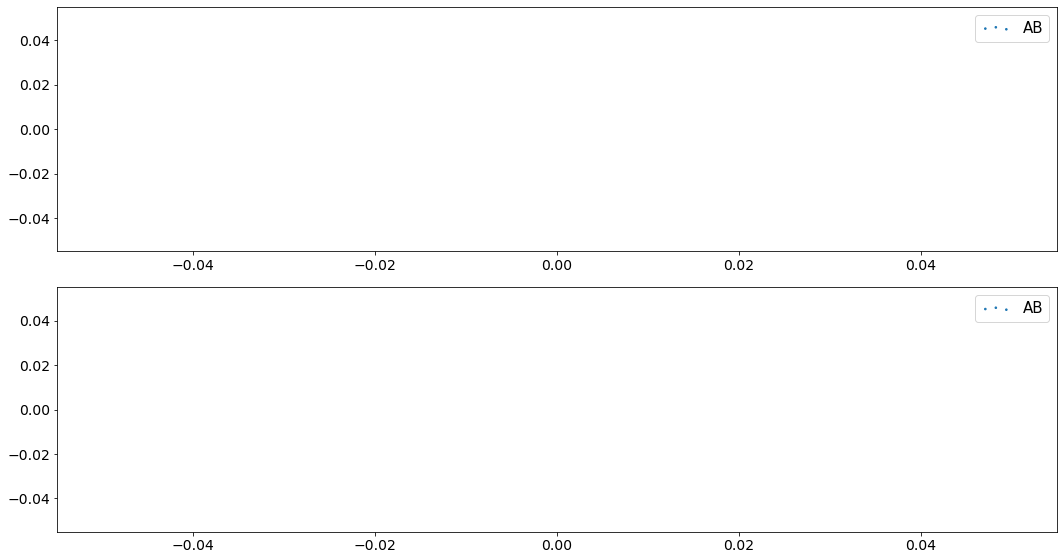


.
.
 5ABC.csv
  Fault type Percentage
0        NML     68.89%
1      FAULT     31.11%


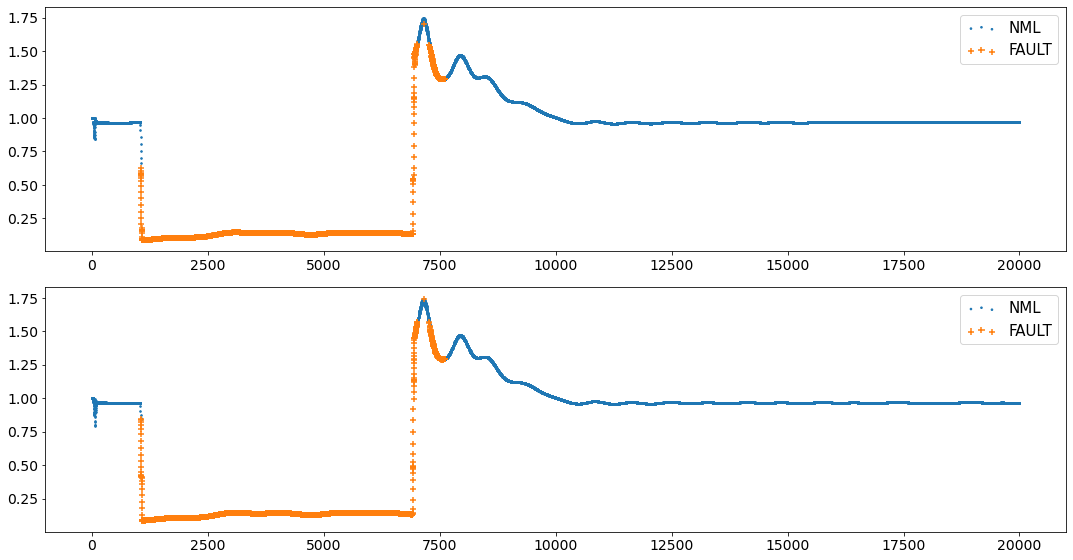

  Fault type Percentage
0        ABC     93.36%
1       ABCG      6.49%
2        ABG      0.13%
3        BCG      0.02%


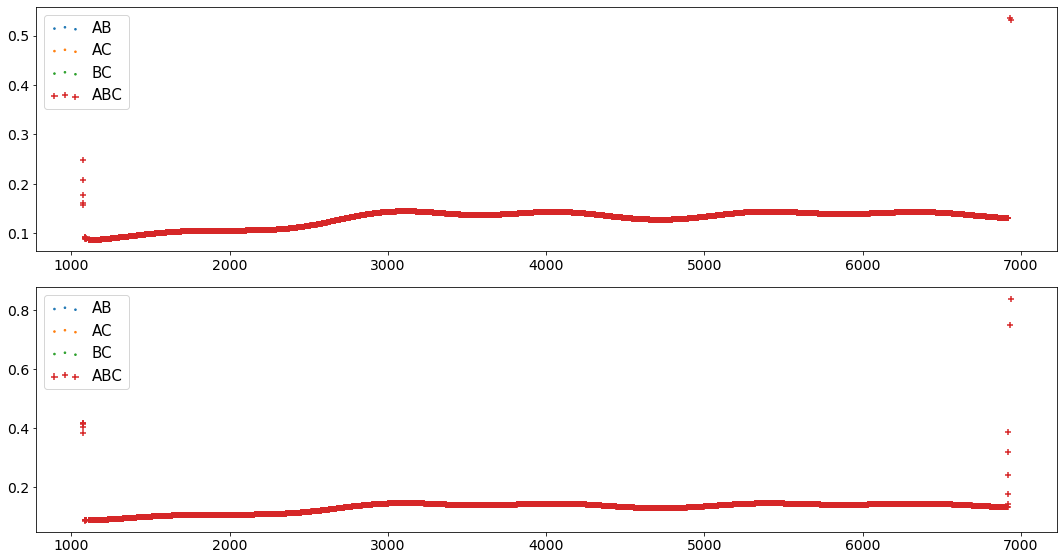


.
.
 5ACG.csv
  Fault type Percentage
0        NML     98.88%
1      FAULT      1.12%


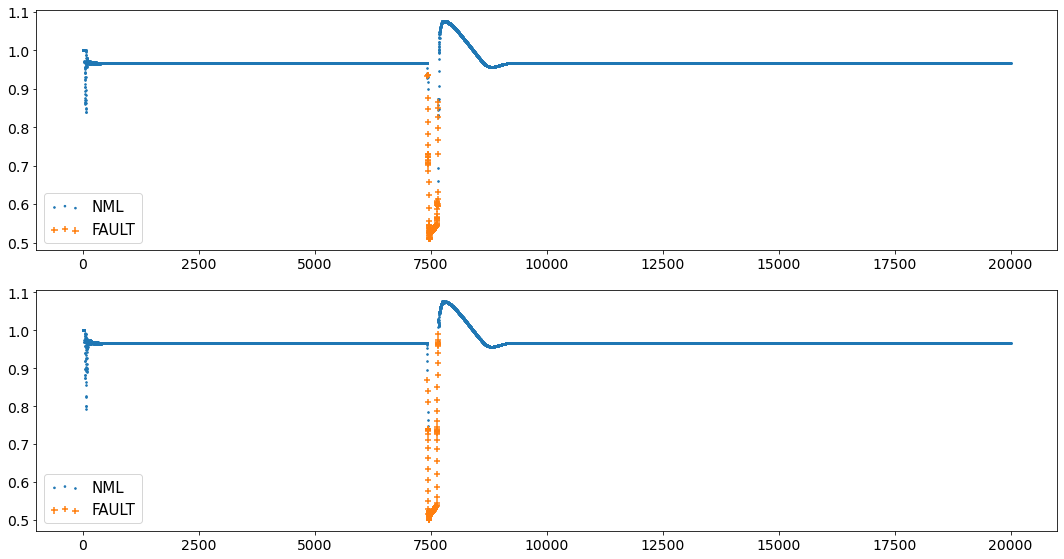

  Fault type Percentage
0        ACG     97.33%
1         AG      2.67%


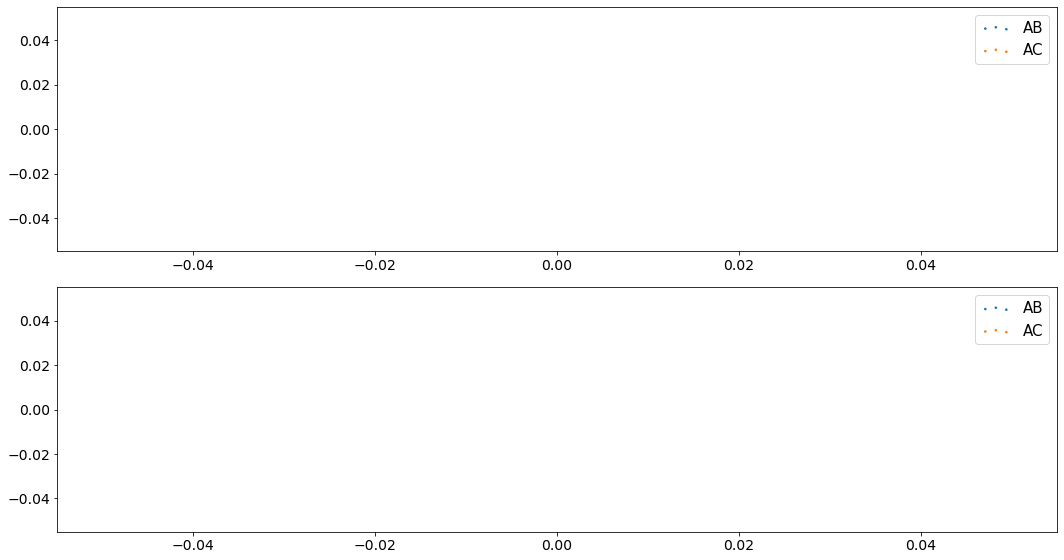


.
.
 9AB.csv
  Fault type Percentage
0        NML     79.62%
1      FAULT     20.38%


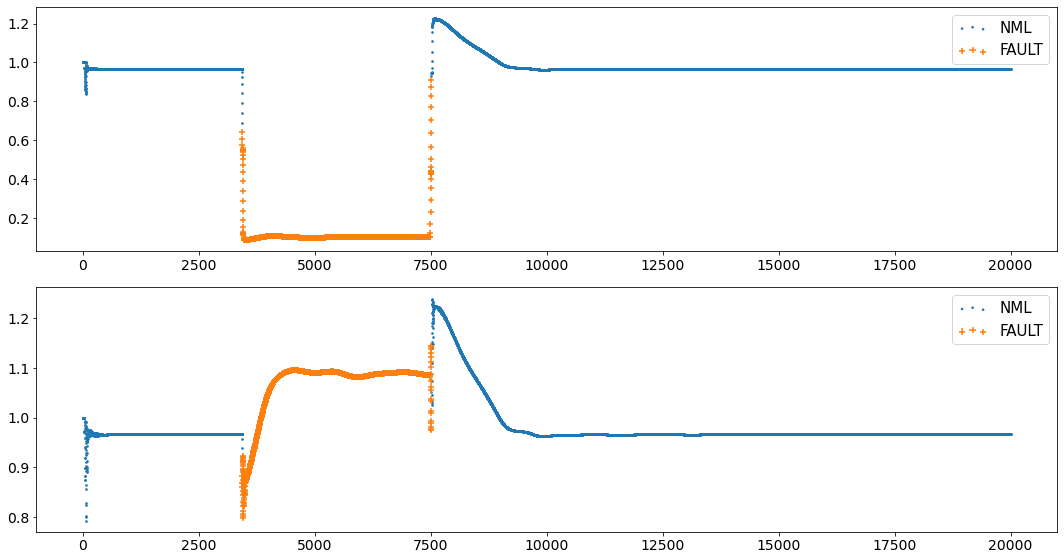

  Fault type Percentage
0         AB     99.95%
1        ABG      0.05%


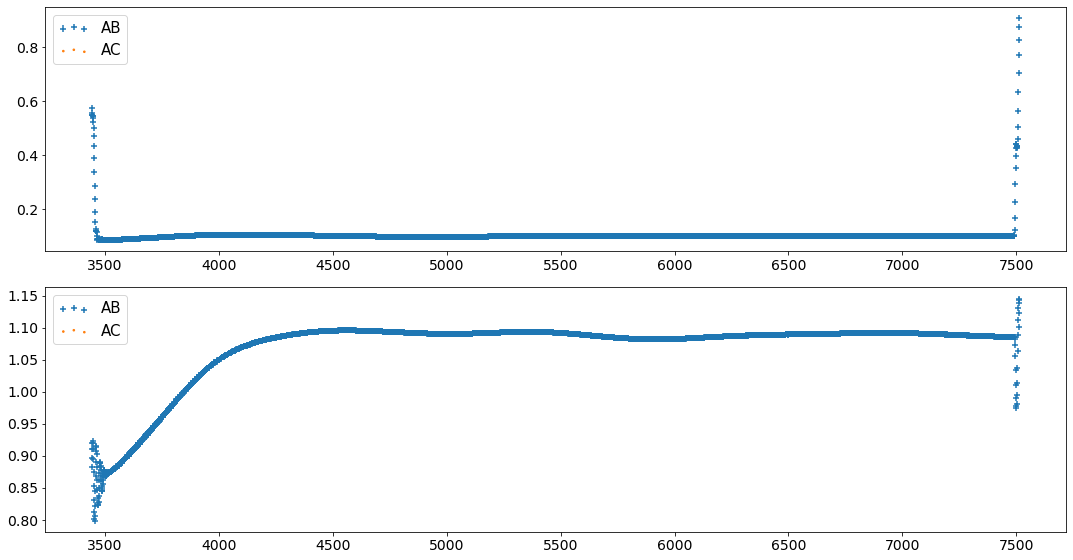


.
.
 9ACG.csv
  Fault type Percentage
0        NML     89.25%
1      FAULT     10.76%


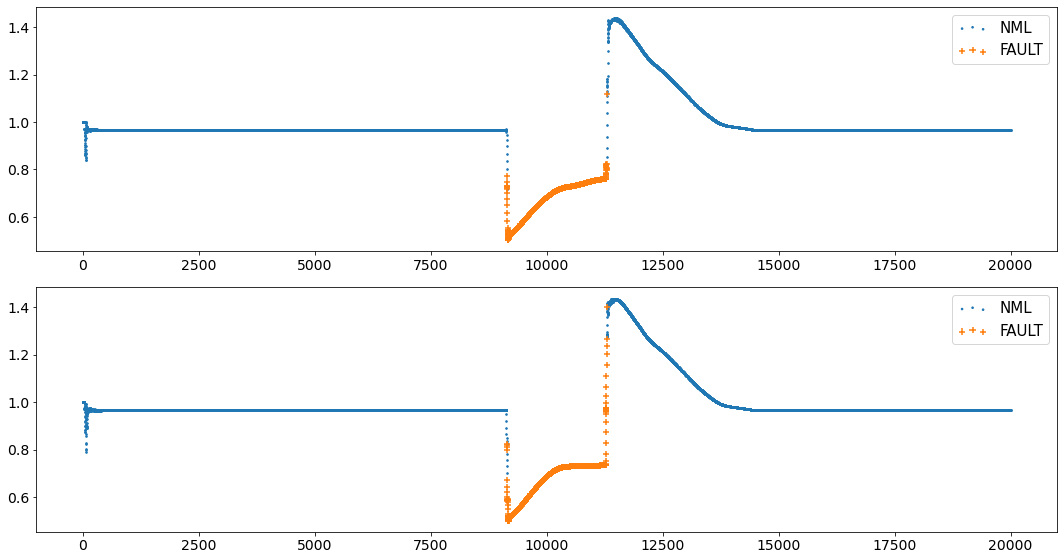

  Fault type Percentage
0        ACG     99.58%
1       ABCG      0.23%
2         AC      0.19%


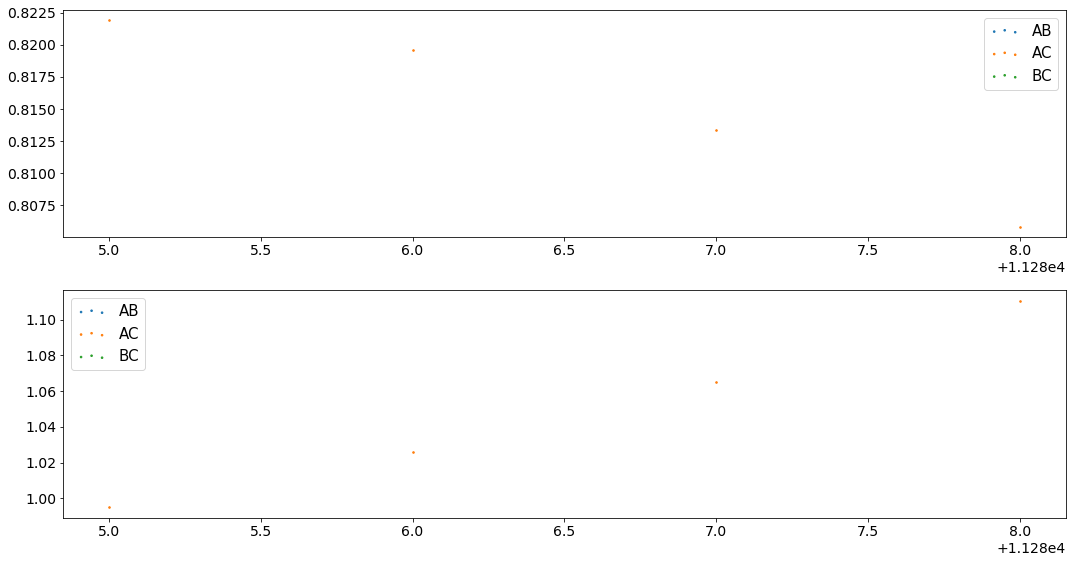


.
.
 9ABC.csv
  Fault type Percentage
0        NML     63.28%
1      FAULT     36.72%


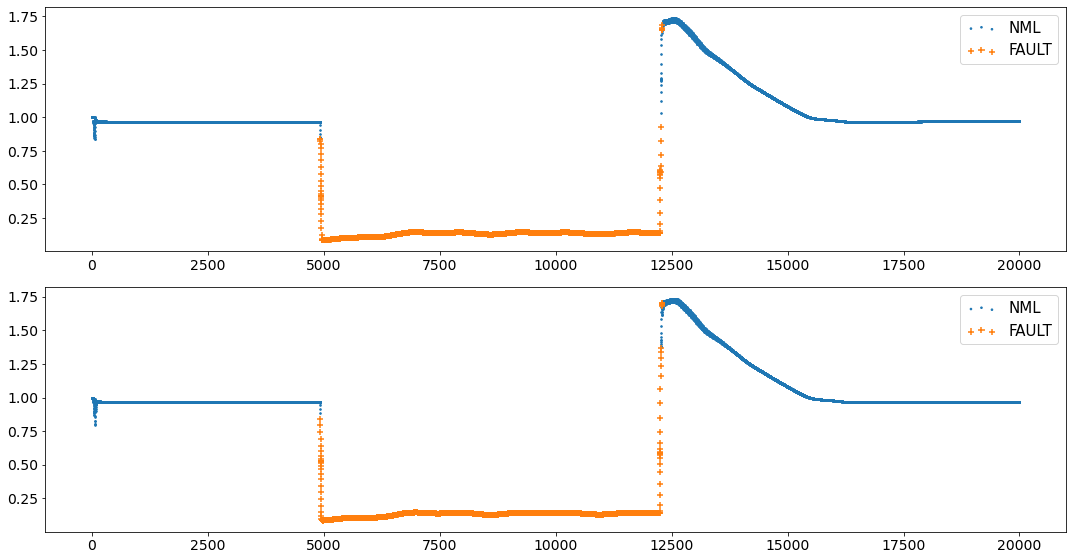

  Fault type Percentage
0        ABC     98.95%
1       ABCG      0.91%
2        ACG       0.1%
3        ABG      0.04%


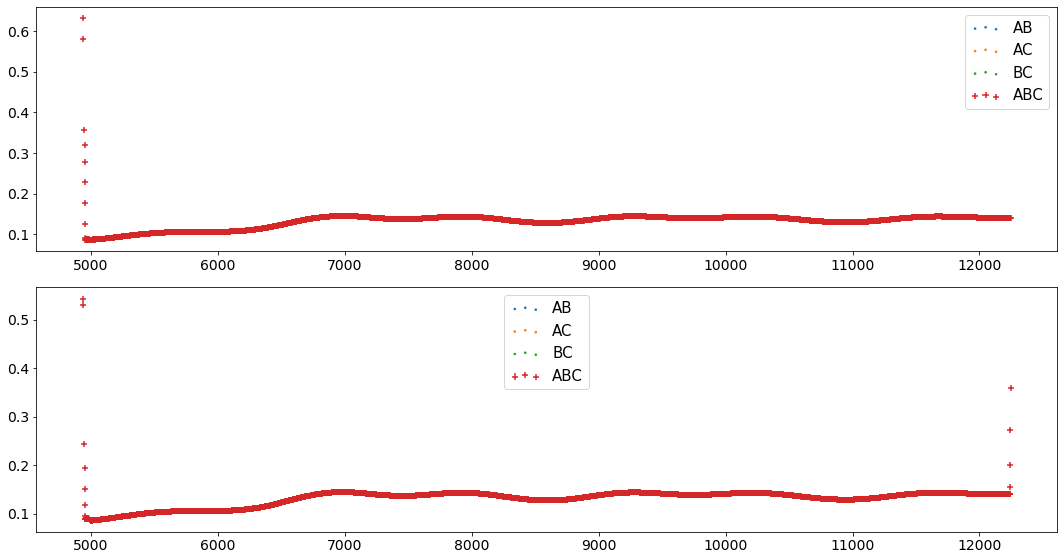


.
.
 5BC.csv
  Fault type Percentage
0        NML     99.67%
1      FAULT      0.34%


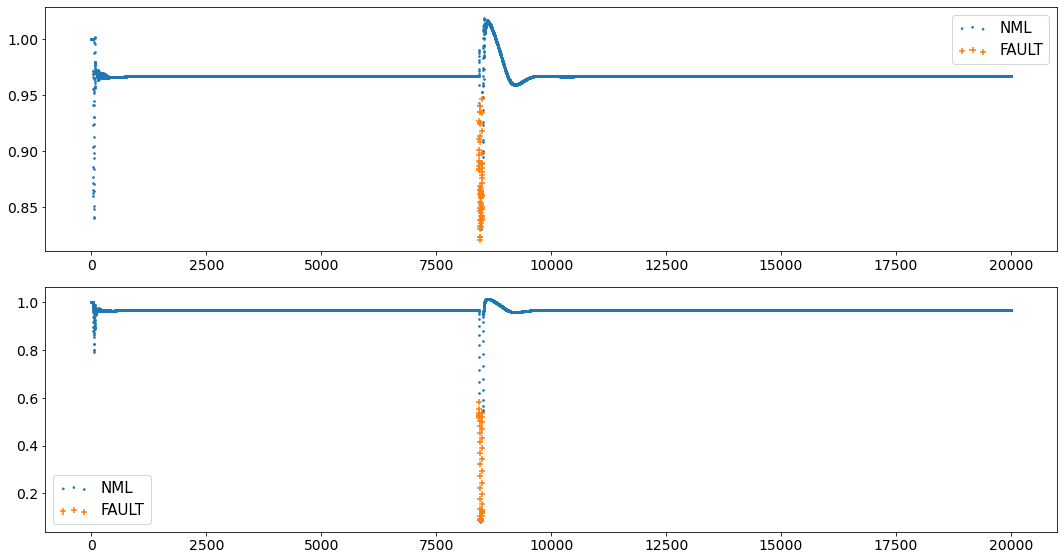

  Fault type Percentage
0         BC     97.01%
1        BCG      2.99%


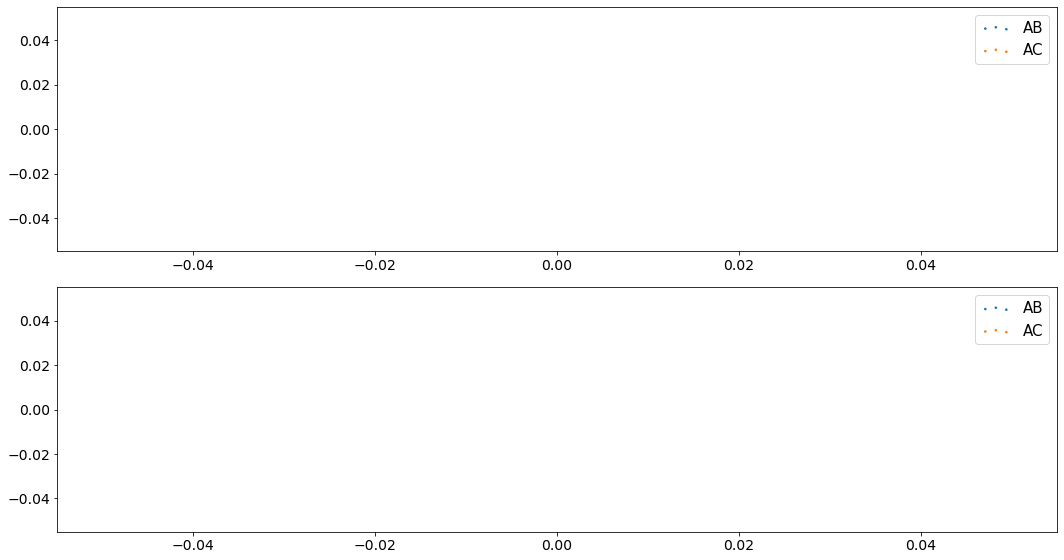


.
.
 5CG.csv
  Fault type Percentage
0        NML     84.13%
1      FAULT     15.87%


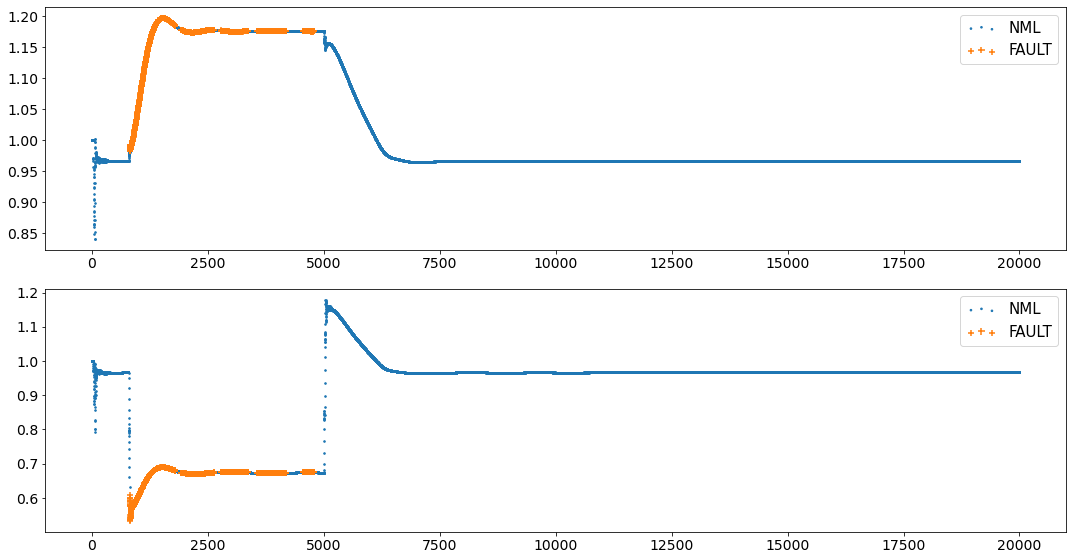

  Fault type Percentage
0         CG     100.0%


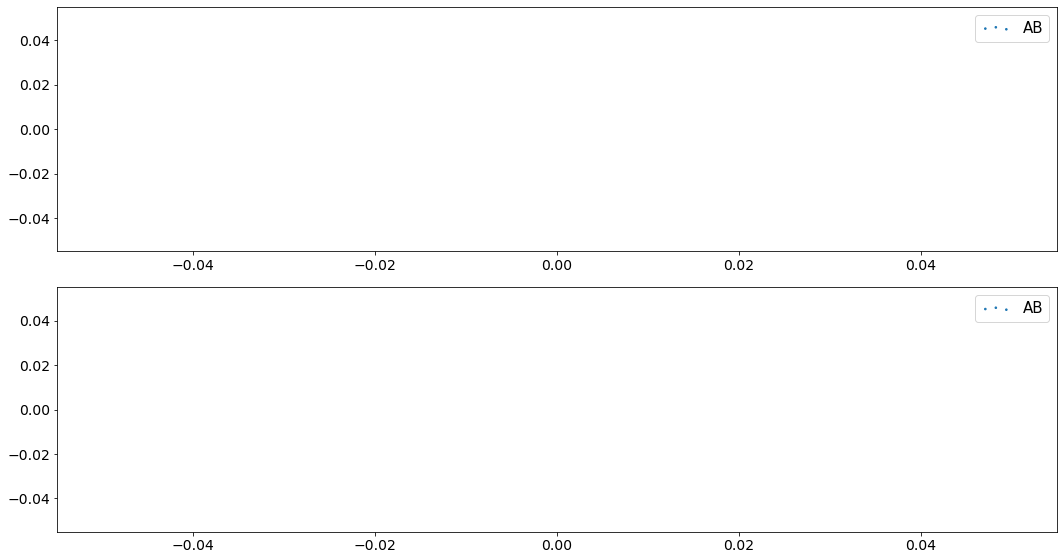


.
.
 4ABCG.csv
  Fault type Percentage
0        NML     93.14%
1      FAULT      6.87%


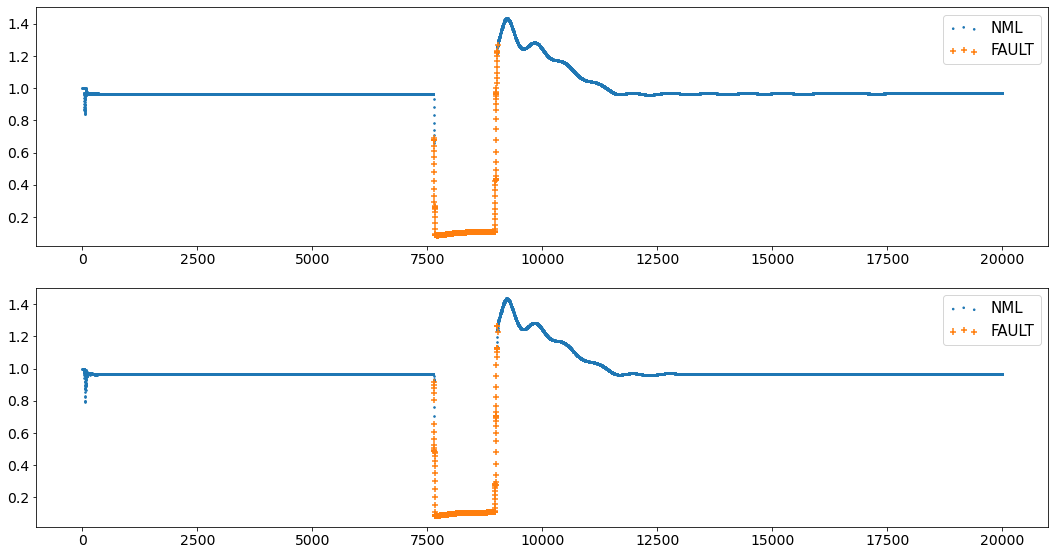

  Fault type Percentage
0        ABC     94.17%
1       ABCG      5.17%
2        ACG      0.36%
3        ABG      0.29%


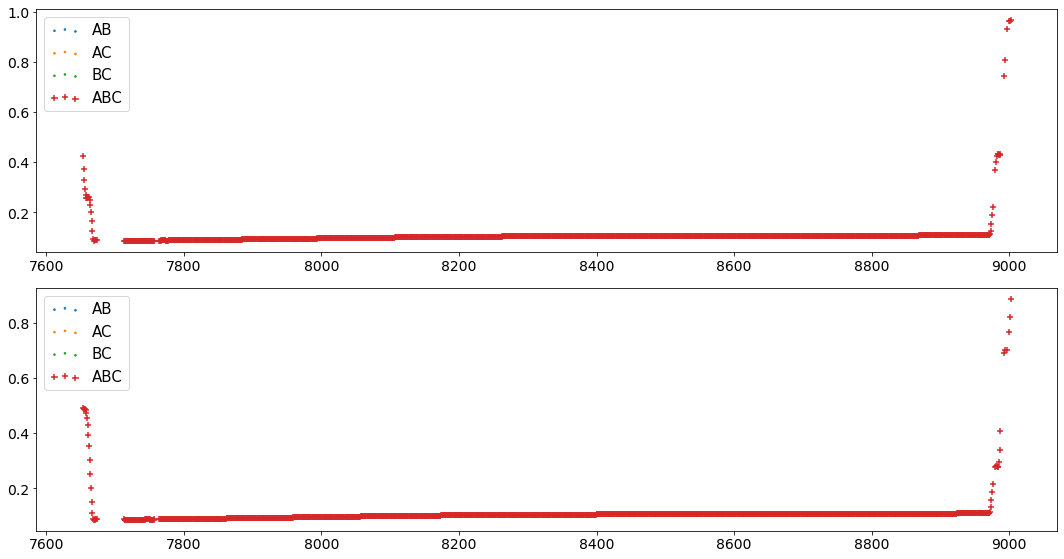


.
.
 7BC.csv
  Fault type Percentage
0        NML     99.47%
1      FAULT      0.53%


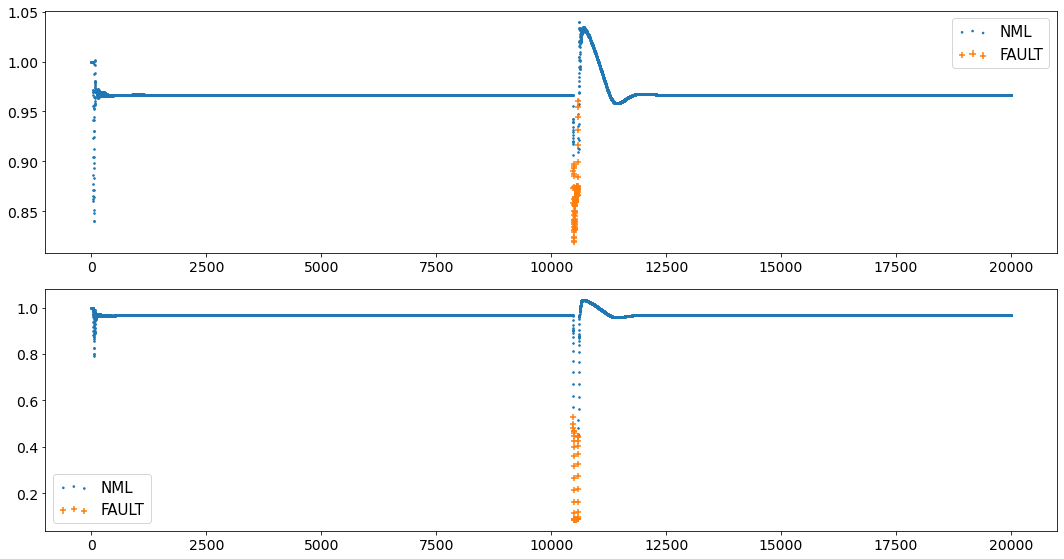

  Fault type Percentage
0         BC      98.1%
1        BCG       1.9%


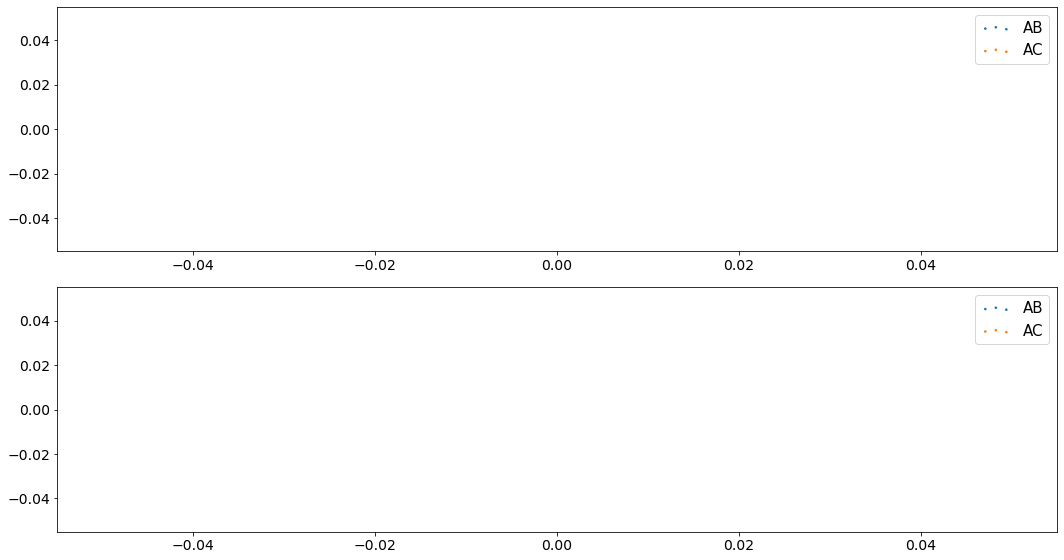


.
.
 7CG.csv
  Fault type Percentage
0        NML      84.5%
1      FAULT     15.49%


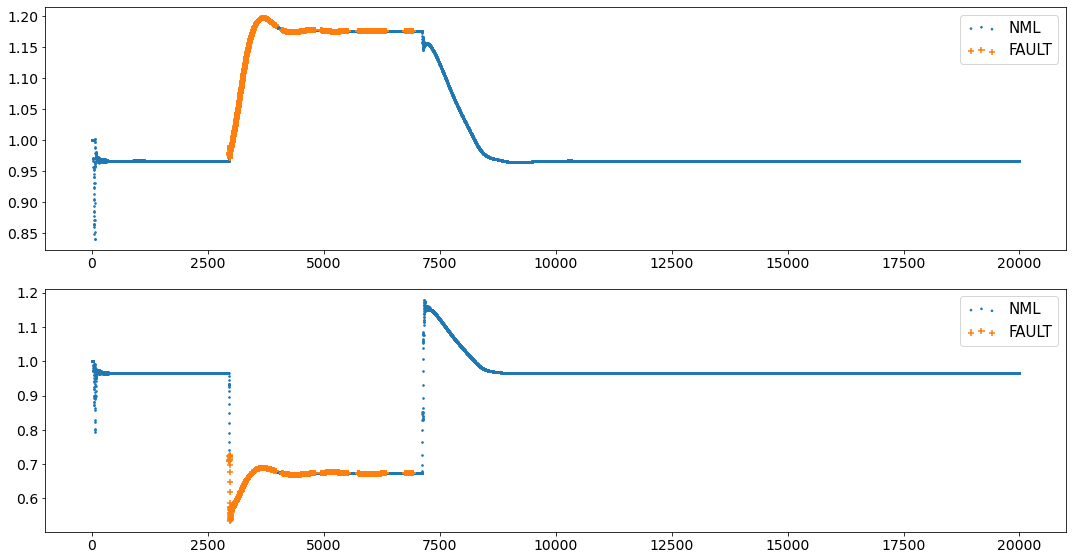

  Fault type Percentage
0         CG     100.0%


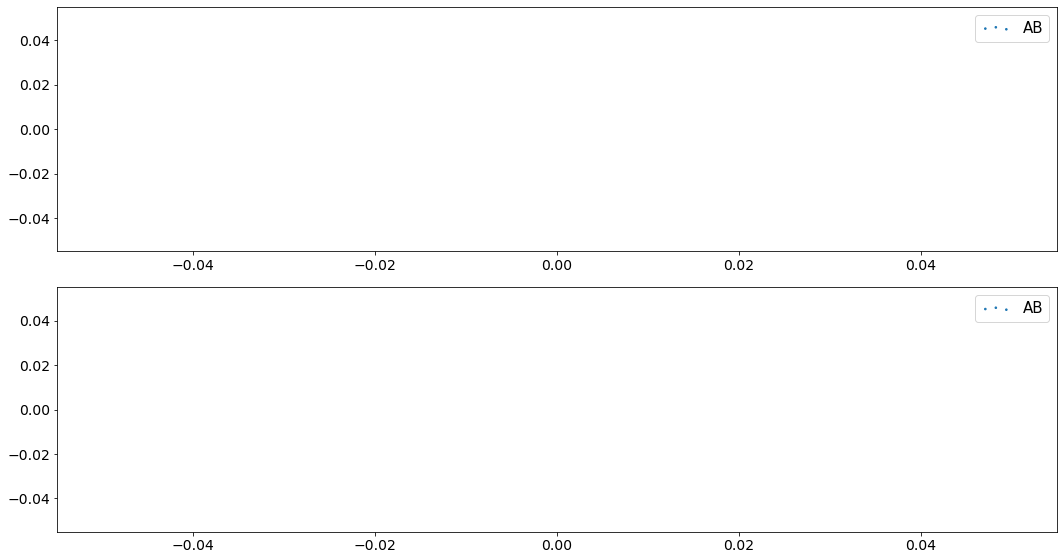


.
.
 10ACG.csv
  Fault type Percentage
0        NML     87.85%
1      FAULT     12.15%


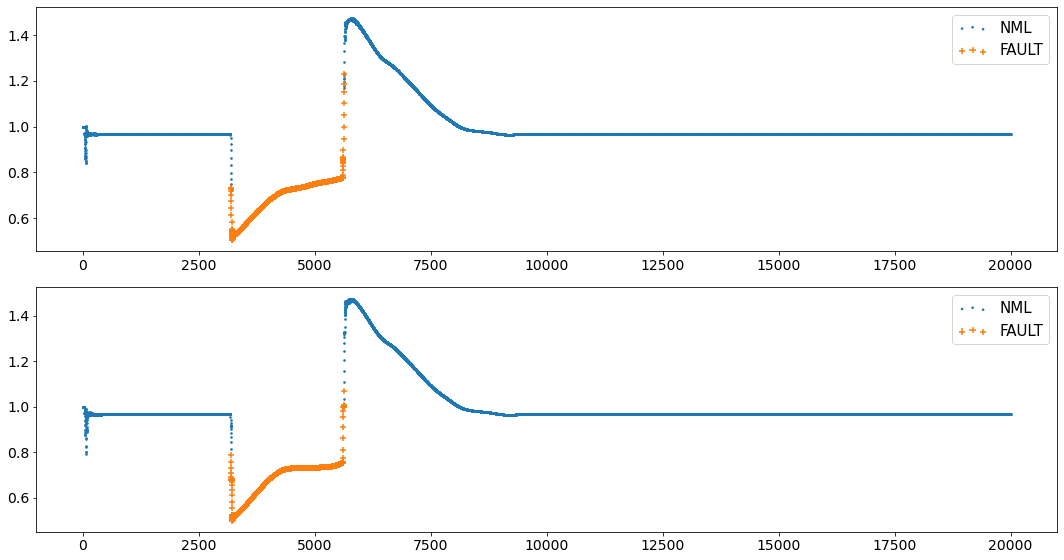

  Fault type Percentage
0        ACG     100.0%


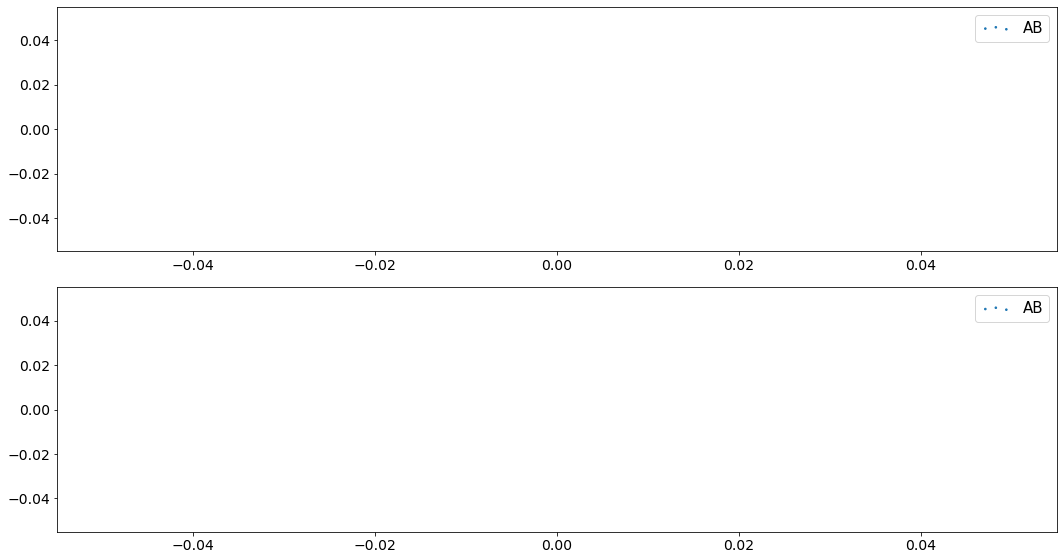


.
.
 3BG.csv
  Fault type Percentage
0        NML     94.14%
1      FAULT      5.86%


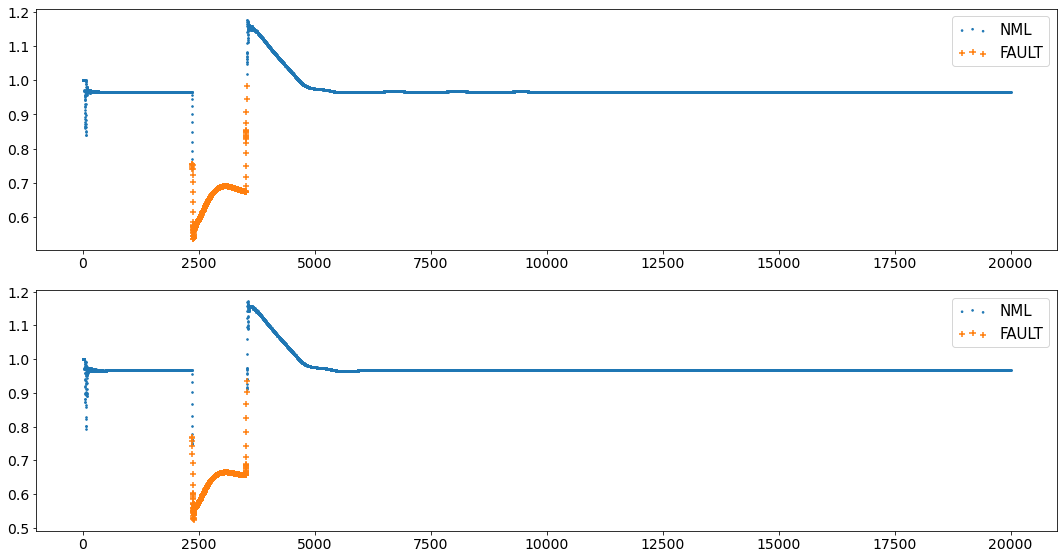

  Fault type Percentage
0         BG     100.0%


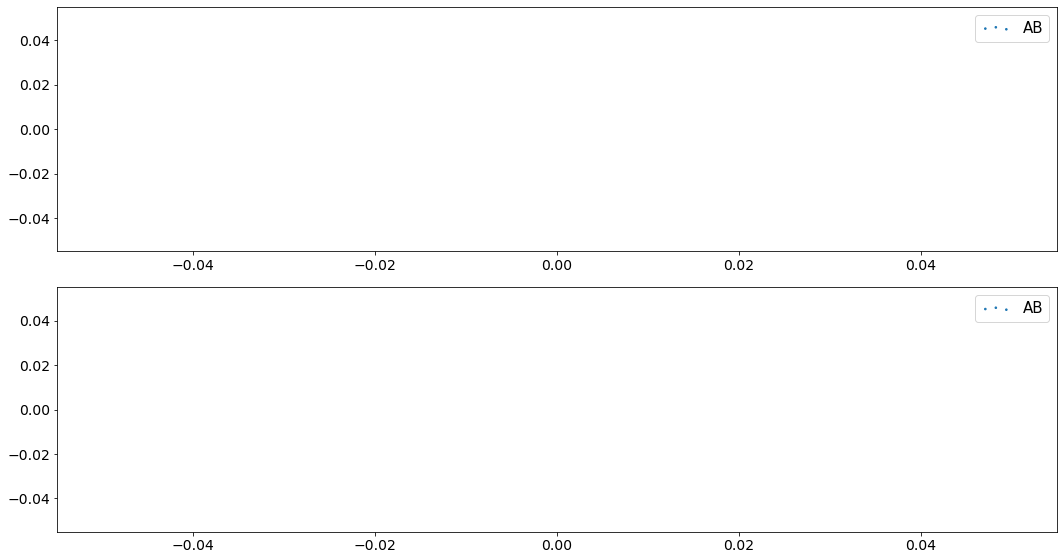


.
.
 10ABC.csv
  Fault type Percentage
0        NML      90.5%
1      FAULT      9.49%


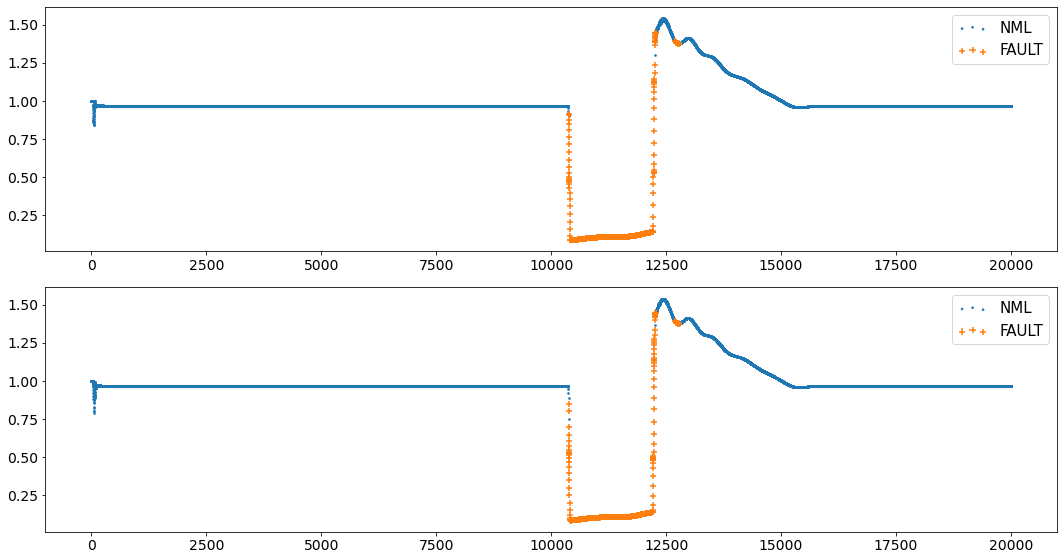

  Fault type Percentage
0        ABC     94.31%
1       ABCG      5.37%
2        BCG      0.16%
3        ACG      0.16%


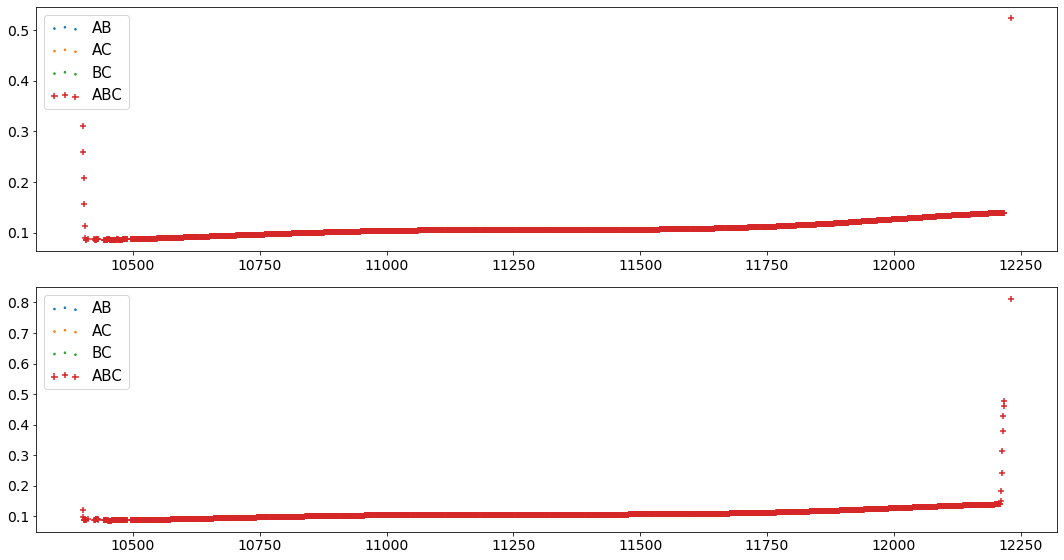


.
.
 3BCG.csv
  Fault type Percentage
0        NML     95.17%
1      FAULT      4.83%


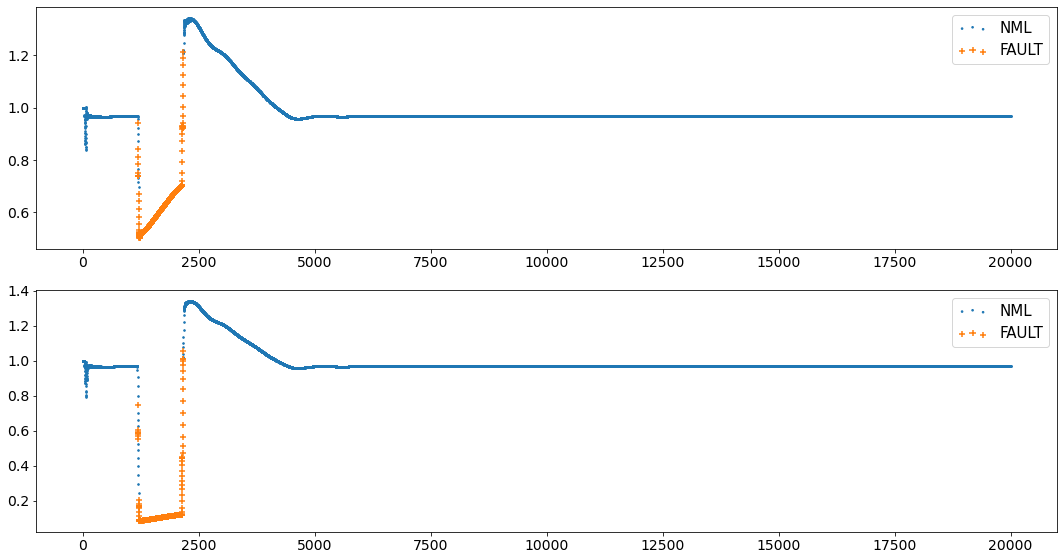

  Fault type Percentage
0        BCG     99.79%
1       ABCG      0.21%


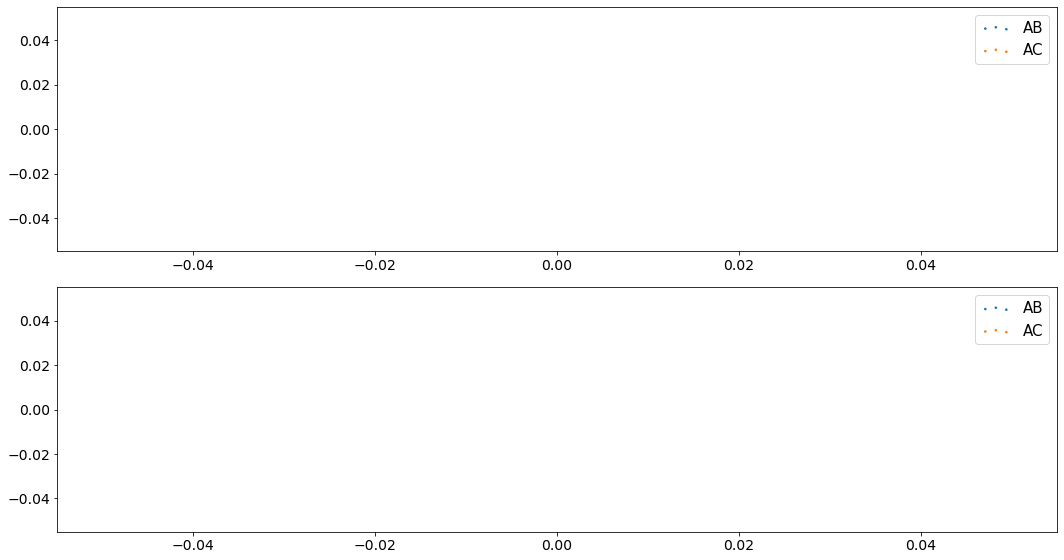


.
.
 4BG.csv
  Fault type Percentage
0        NML     73.53%
1      FAULT     26.48%


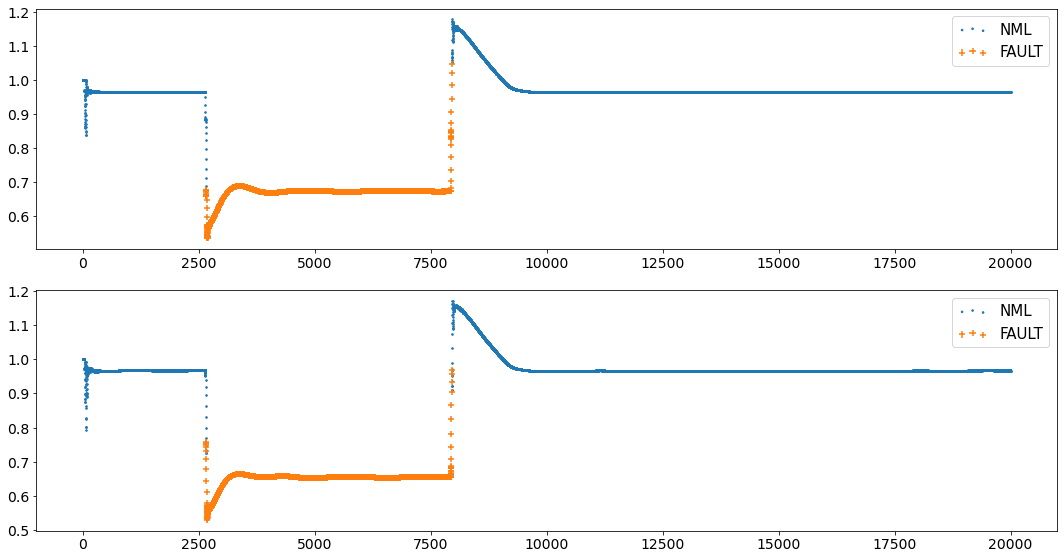

  Fault type Percentage
0         BG     100.0%


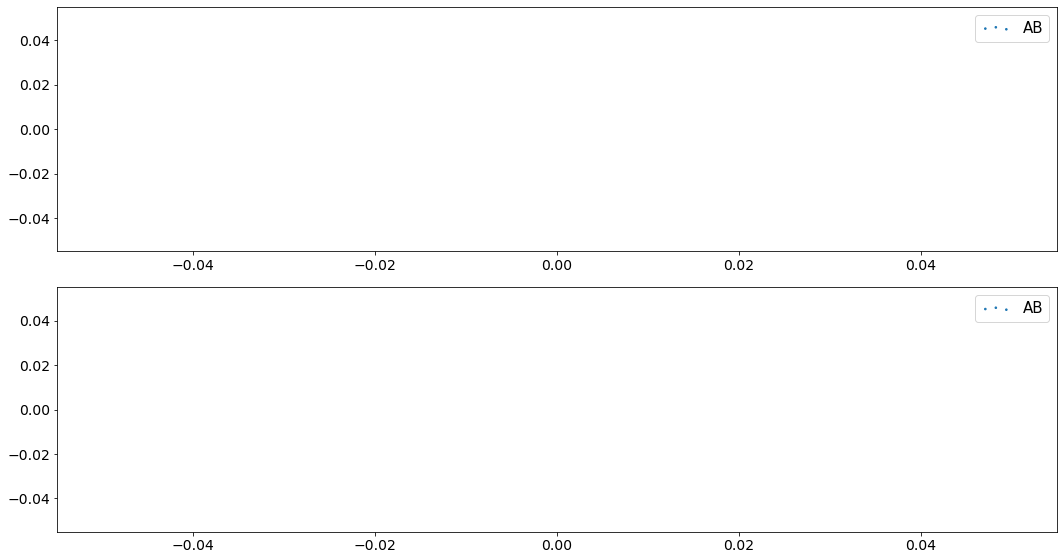


.
.
 1ABC.csv
  Fault type Percentage
0        NML     73.42%
1      FAULT     26.57%


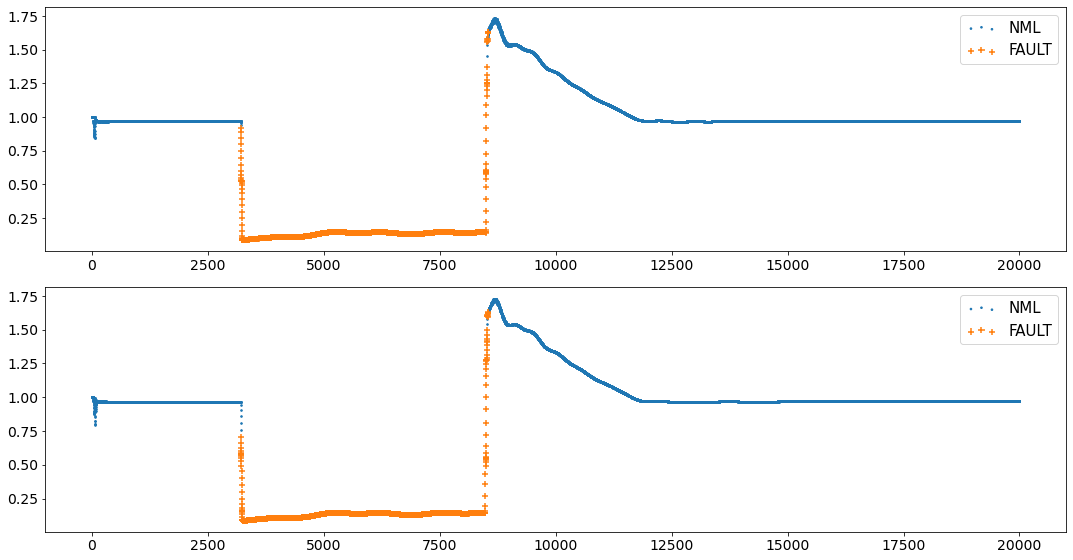

  Fault type Percentage
0        ABC     98.06%
1       ABCG      1.79%
2        BCG      0.15%


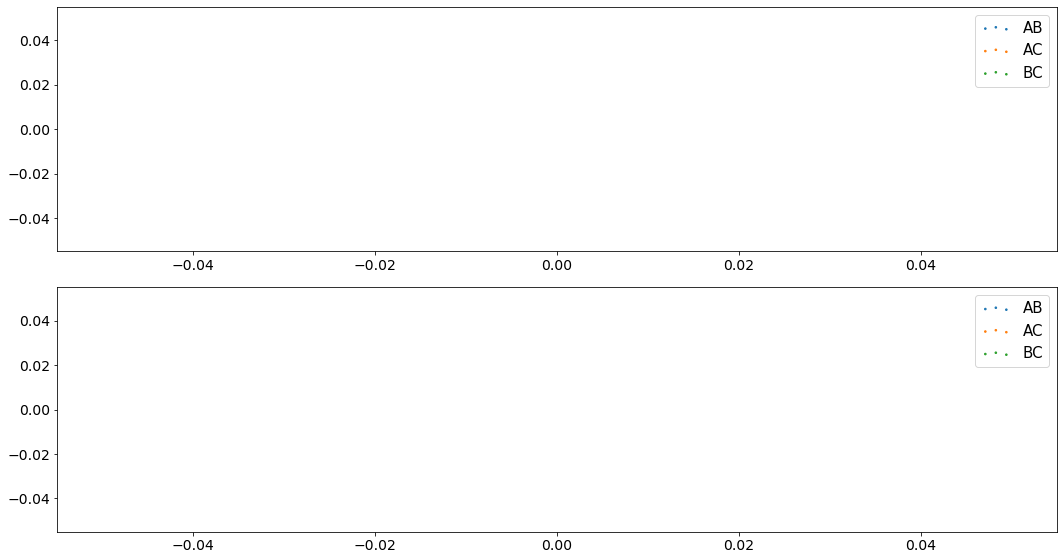


.
.
 1ACG.csv
  Fault type Percentage
0        NML     95.17%
1      FAULT      4.83%


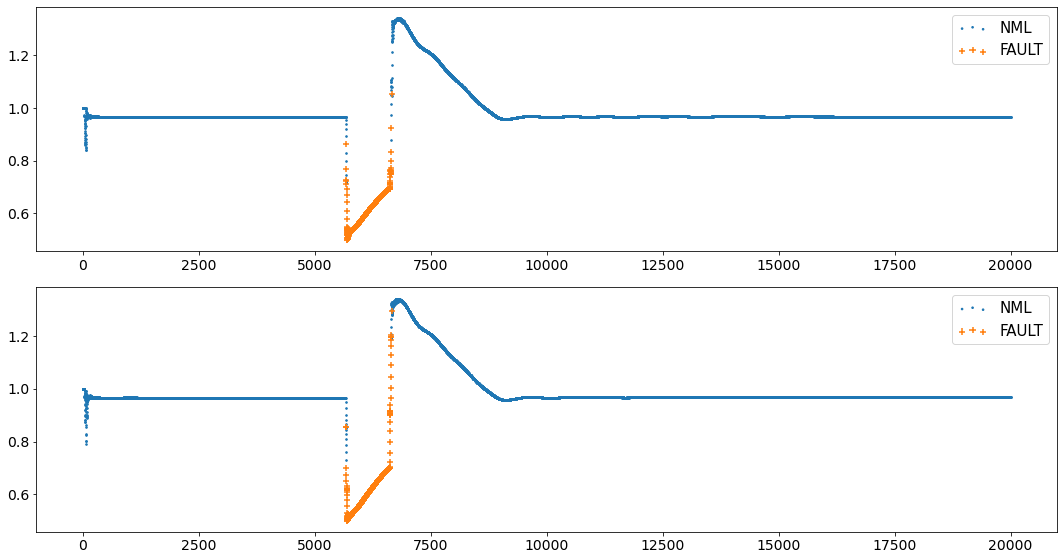

  Fault type Percentage
0        ACG     99.38%
1       ABCG      0.62%


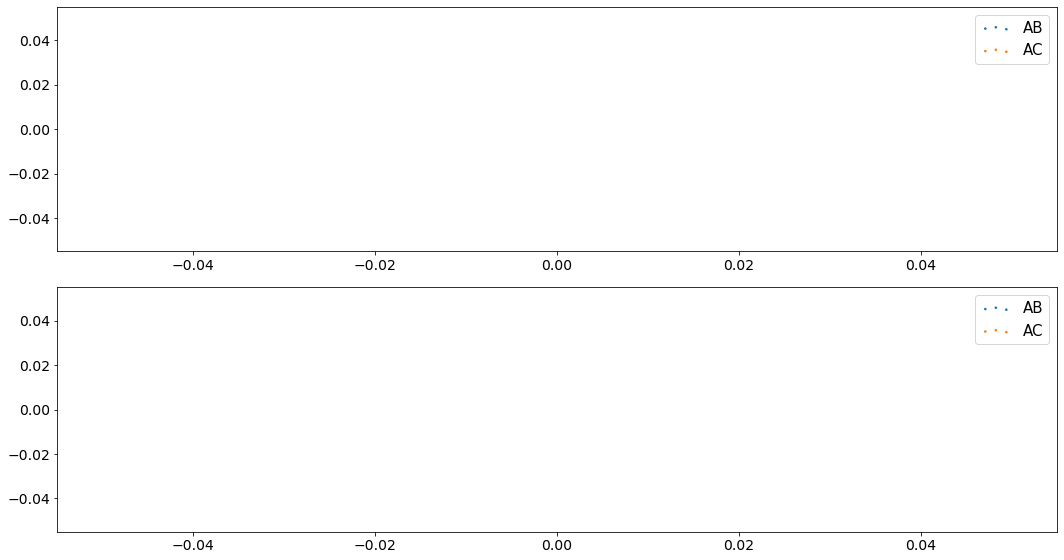


.
.
 8AG.csv
  Fault type Percentage
0        NML     97.55%
1      FAULT      2.46%


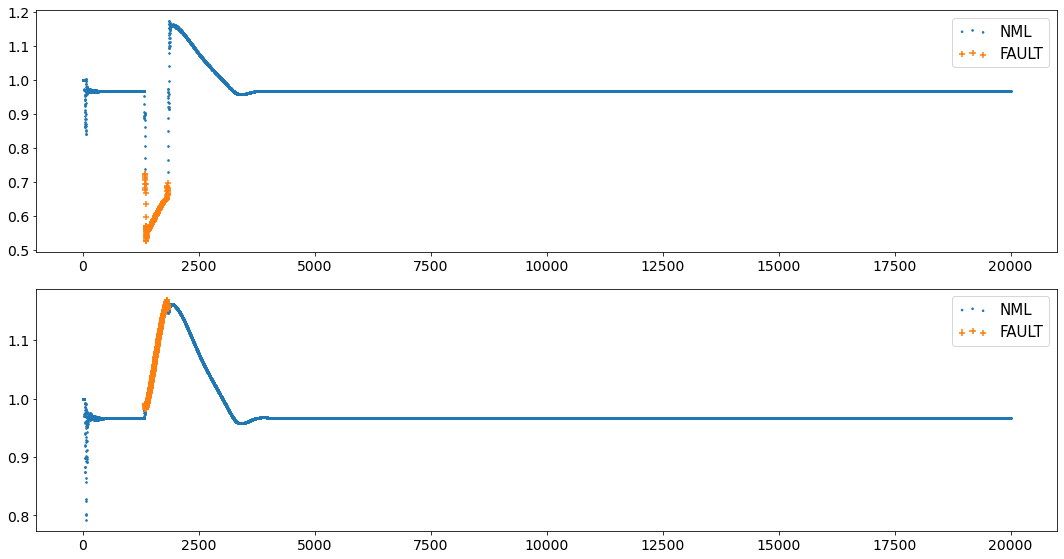

  Fault type Percentage
0         AG     100.0%


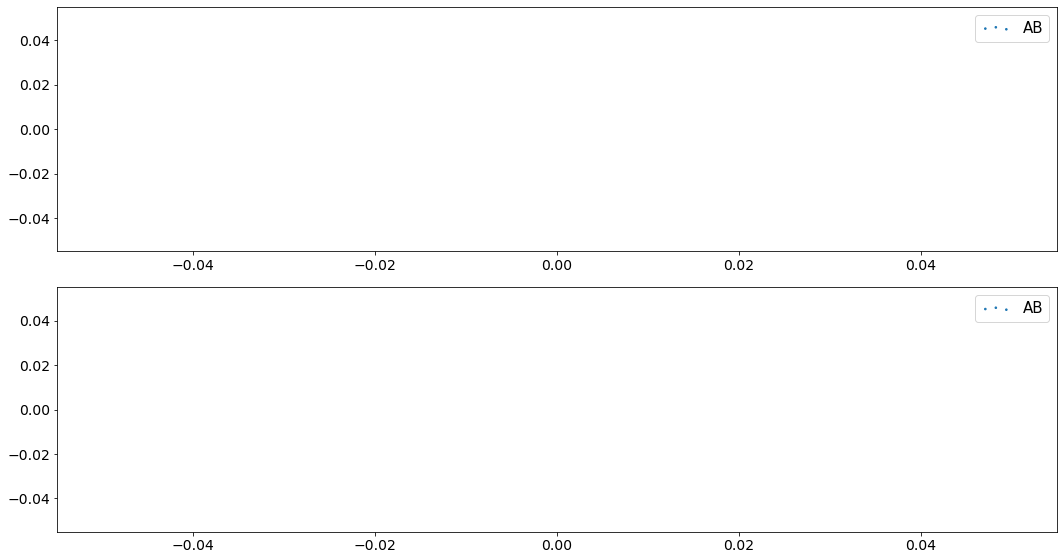


.
.
 3ABG.csv
  Fault type Percentage
0        NML      98.4%
1      FAULT       1.6%


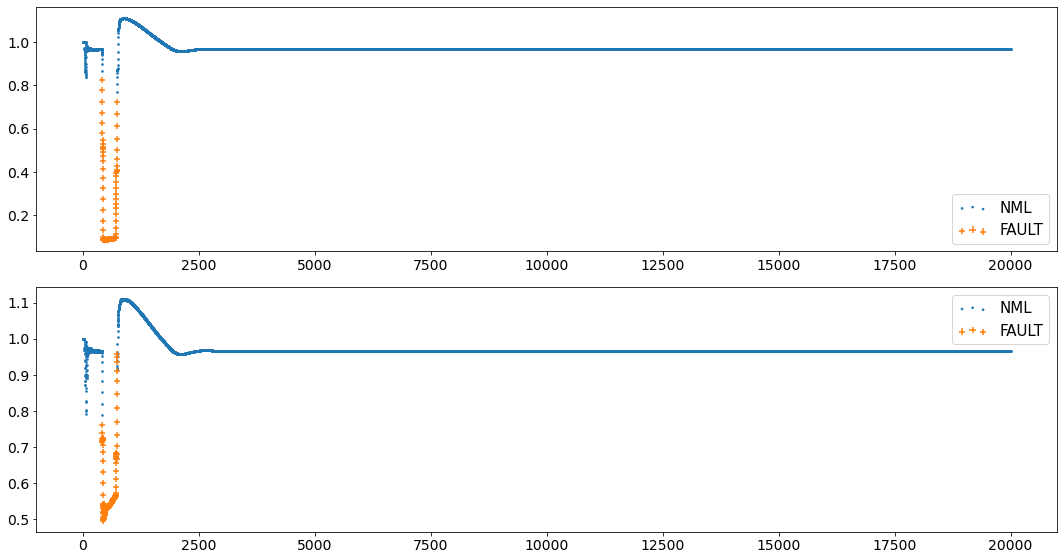

  Fault type Percentage
0        ABG     98.12%
1        BCG      1.56%
2       ABCG      0.31%


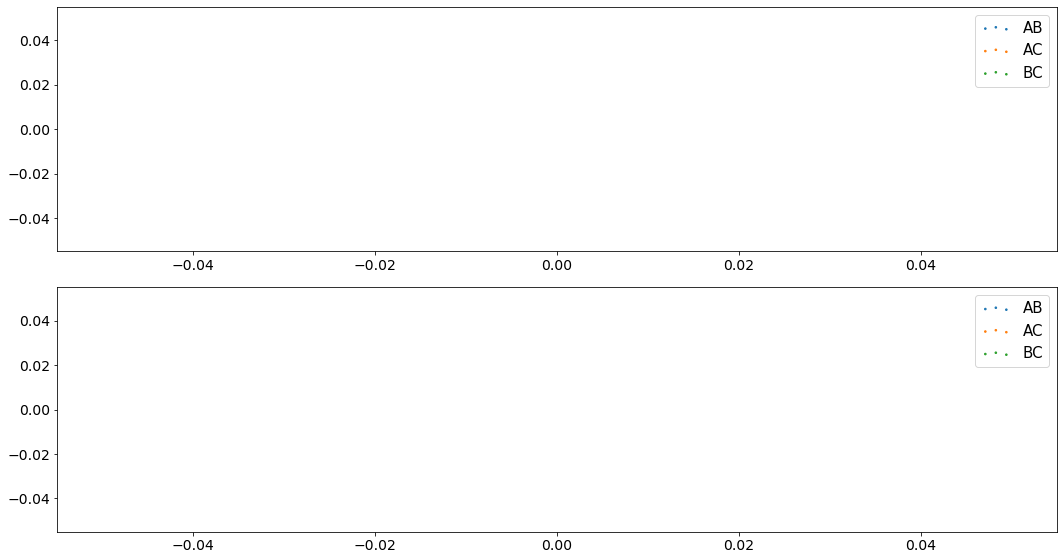


.
.
 10AC.csv
  Fault type Percentage
0        NML     98.03%
1      FAULT      1.97%


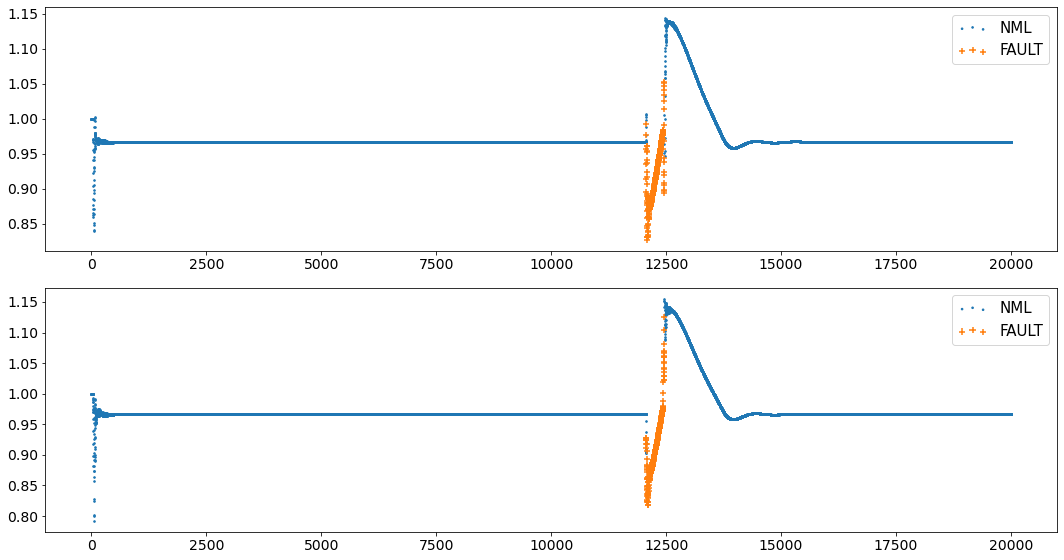

  Fault type Percentage
0         AC     94.15%
1        ACG      5.85%


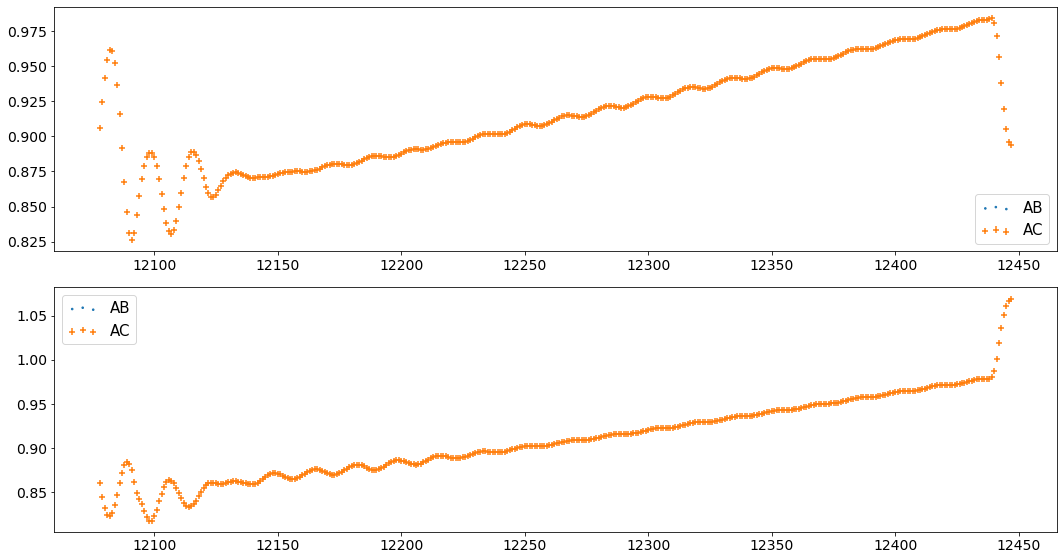


.
.
 7BCG.csv
  Fault type Percentage
0        NML     88.52%
1      FAULT     11.48%


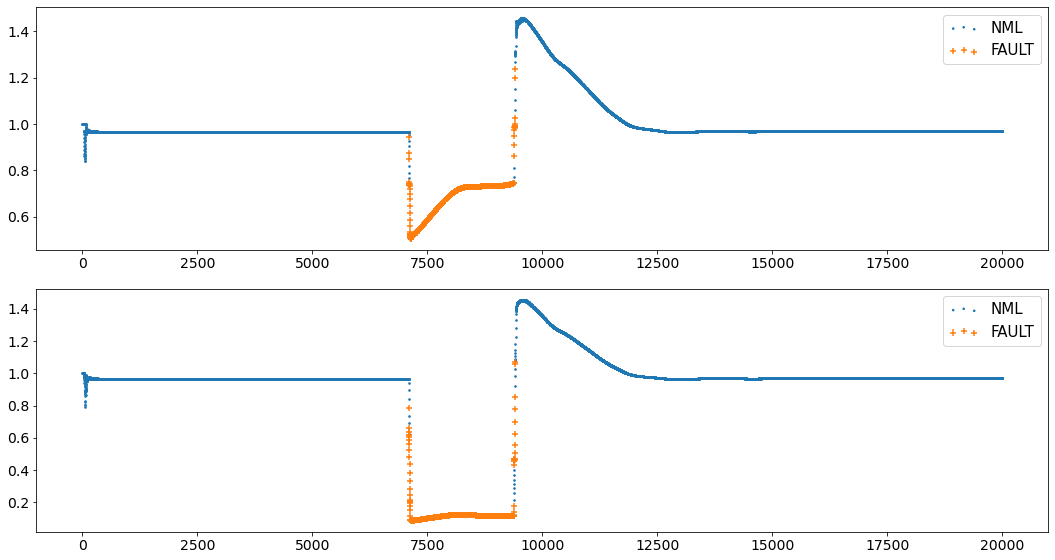

  Fault type Percentage
0        BCG     99.87%
1         BG      0.09%
2       ABCG      0.04%


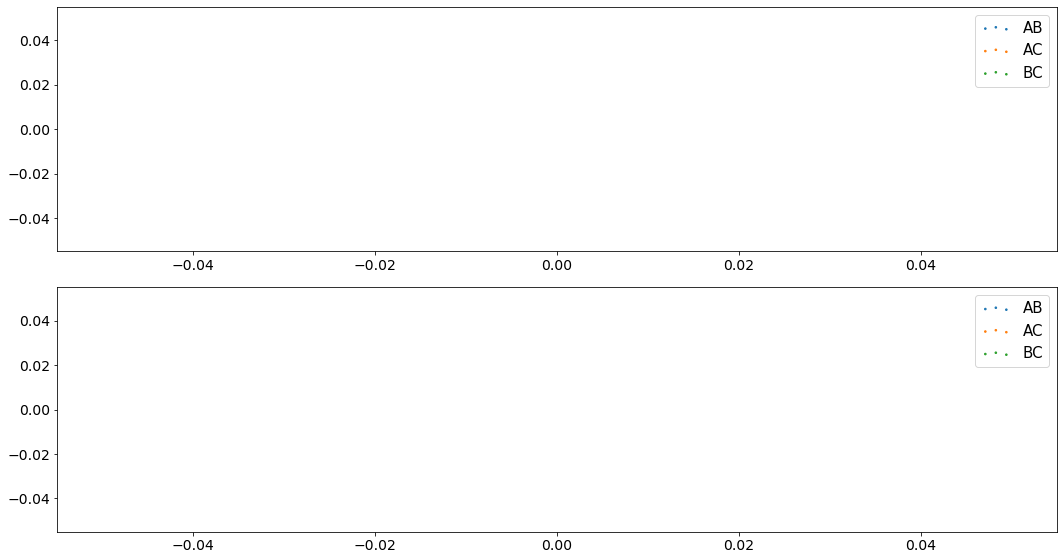


.
.
 6ABCG.csv
  Fault type Percentage
0        NML     92.89%
1      FAULT      7.11%


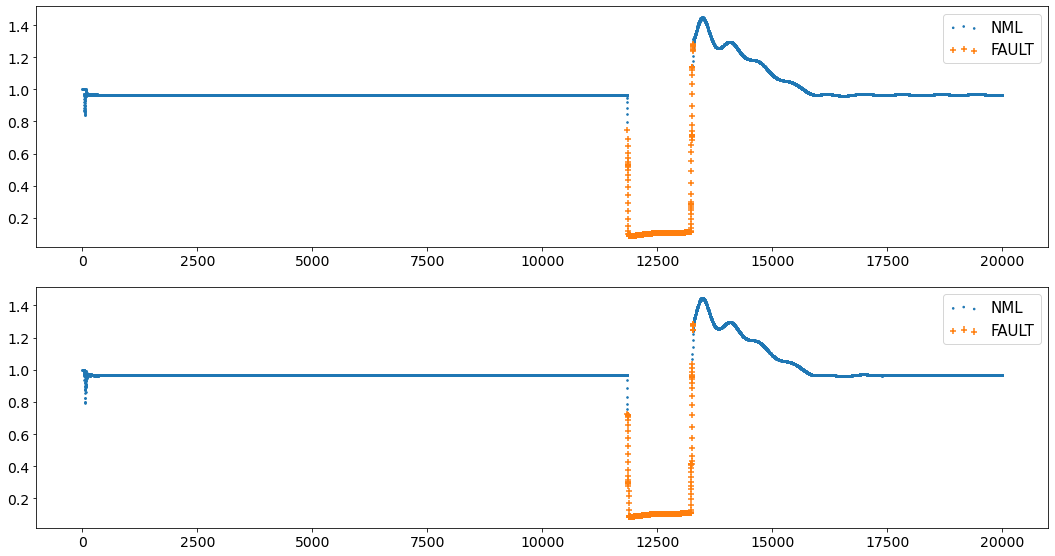

  Fault type Percentage
0        ABC     92.61%
1       ABCG      6.76%
2        ABG      0.49%
3        BCG      0.14%


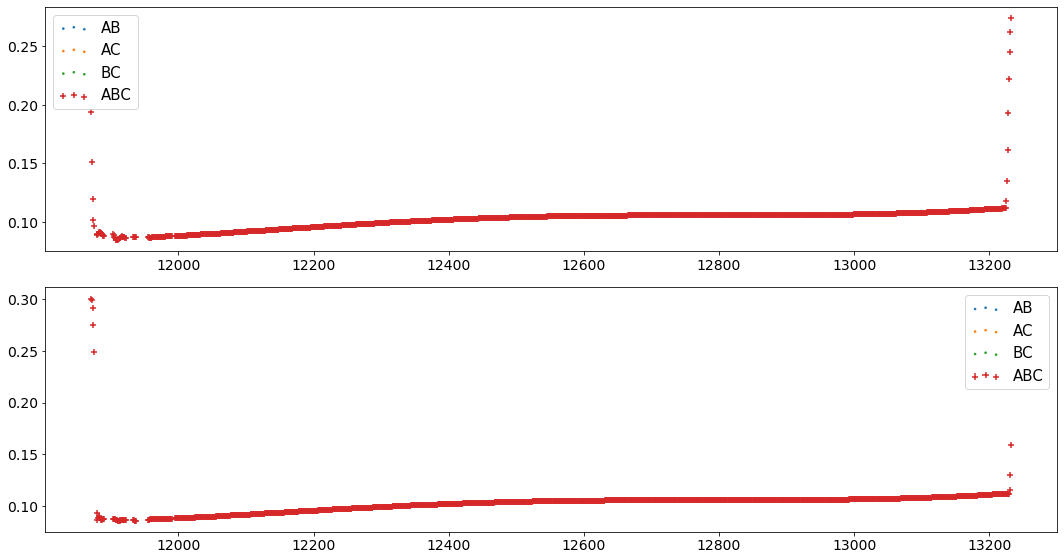


.
.
 6BG.csv
  Fault type Percentage
0        NML      81.4%
1      FAULT      18.6%


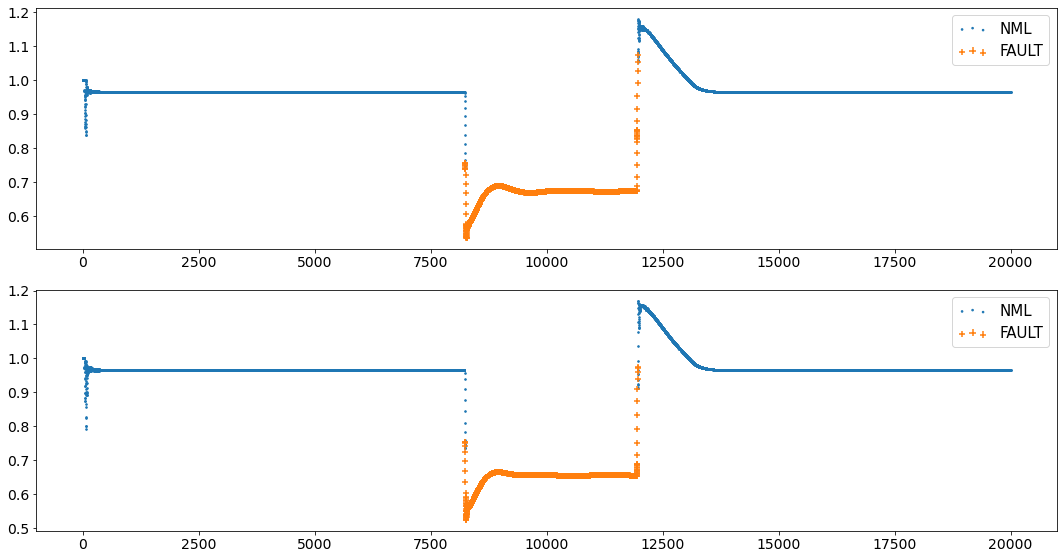

  Fault type Percentage
0         BG     100.0%


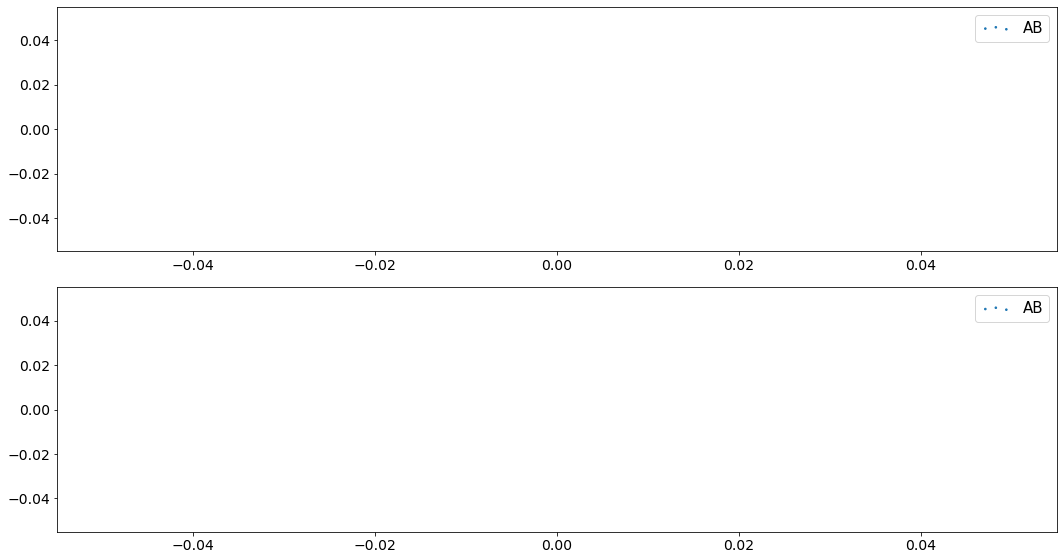


.
.
 10AB.csv
  Fault type Percentage
0        NML     98.58%
1      FAULT      1.42%


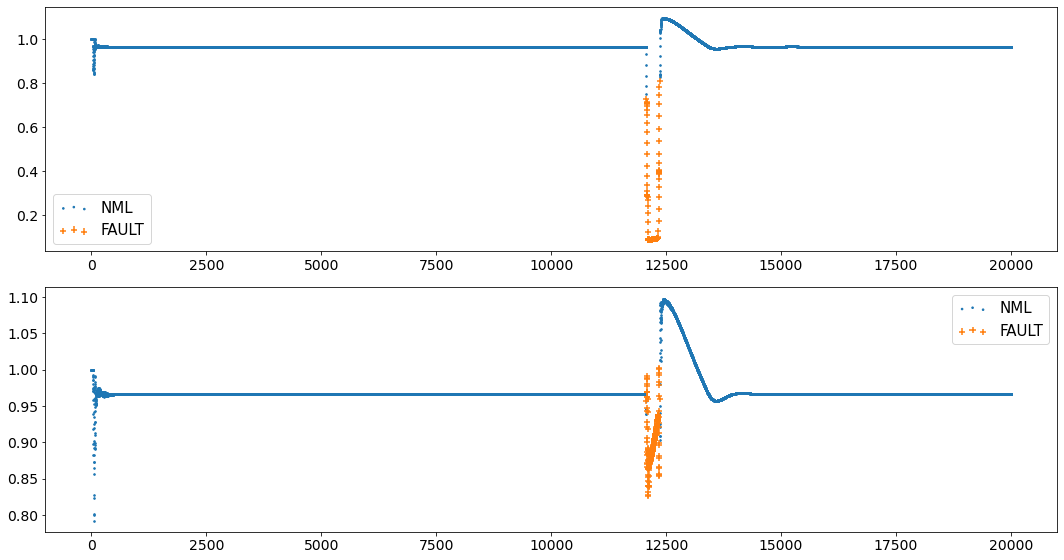

  Fault type Percentage
0         AB     94.01%
1        ABG      5.99%


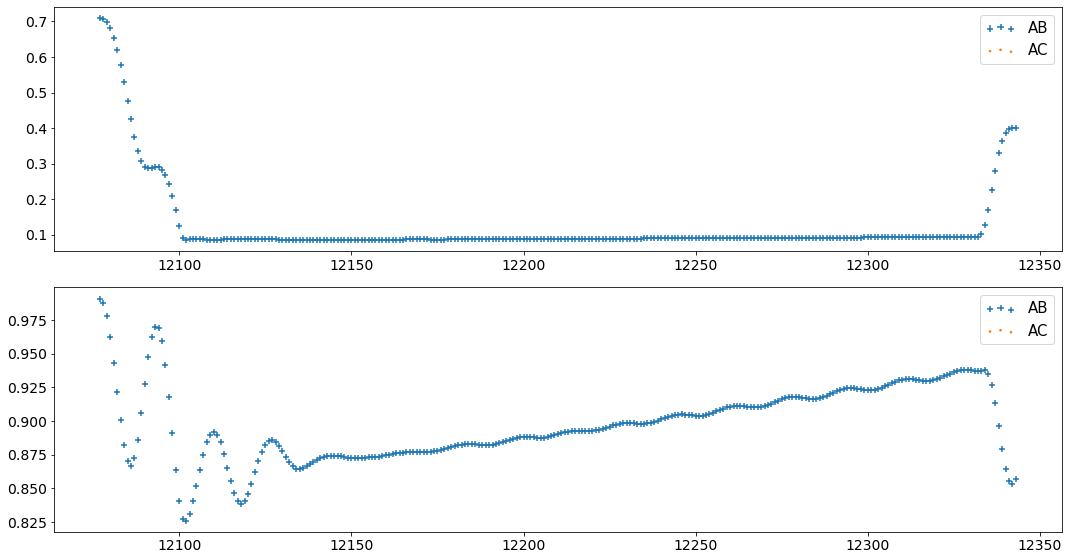


.
.
 2BC.csv
  Fault type Percentage
0        NML     96.92%
1      FAULT      3.08%


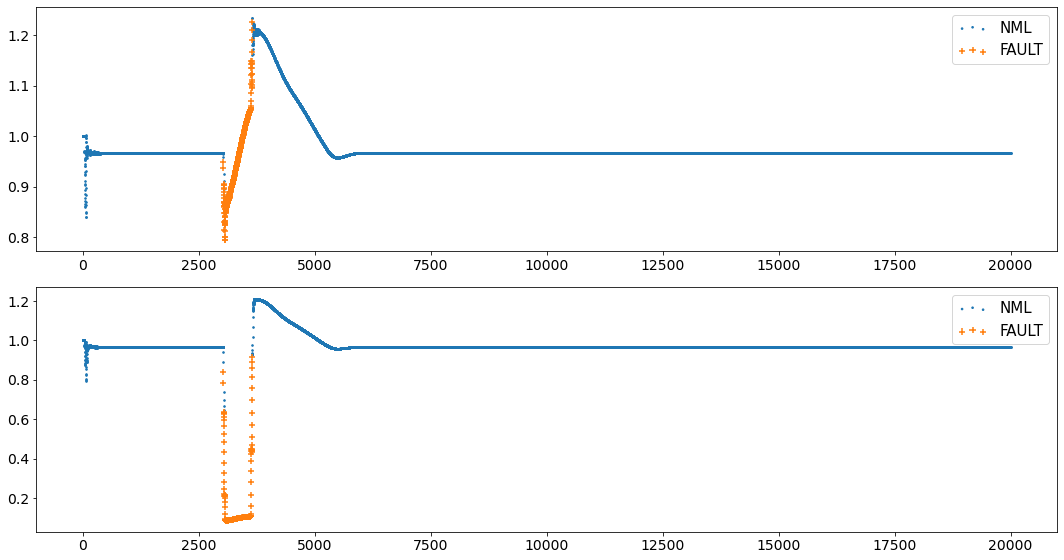

  Fault type Percentage
0         BC     97.24%
1        BCG      2.44%
2       ABCG      0.32%


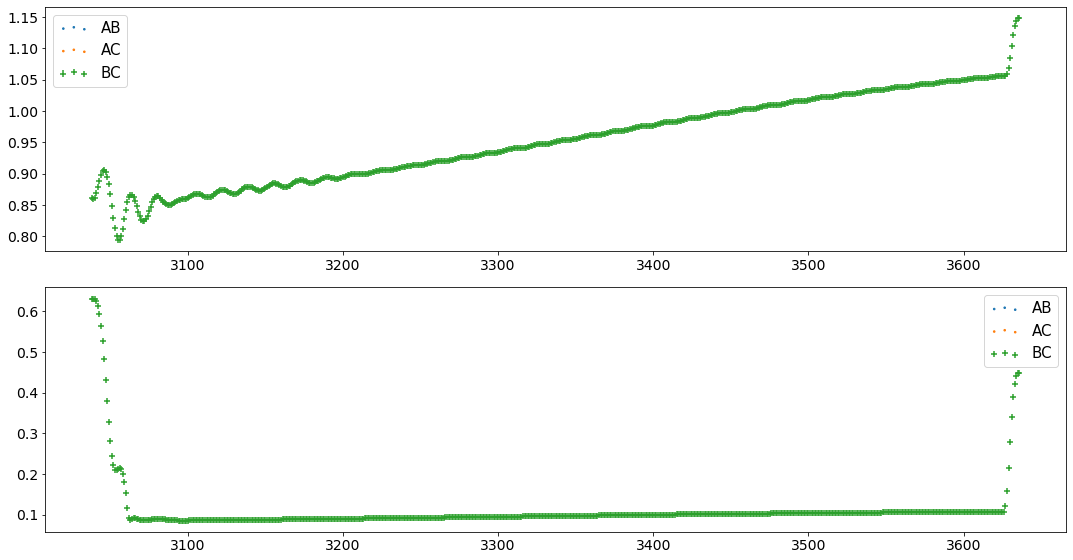


.
.
 2CG.csv
  Fault type Percentage
0        NML     84.52%
1      FAULT     15.48%


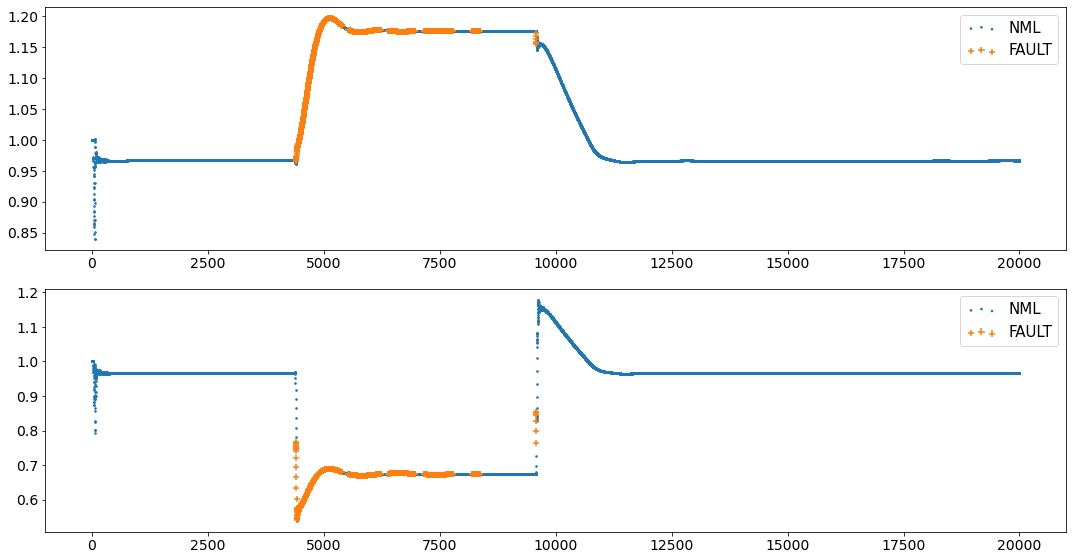

  Fault type Percentage
0         CG     100.0%


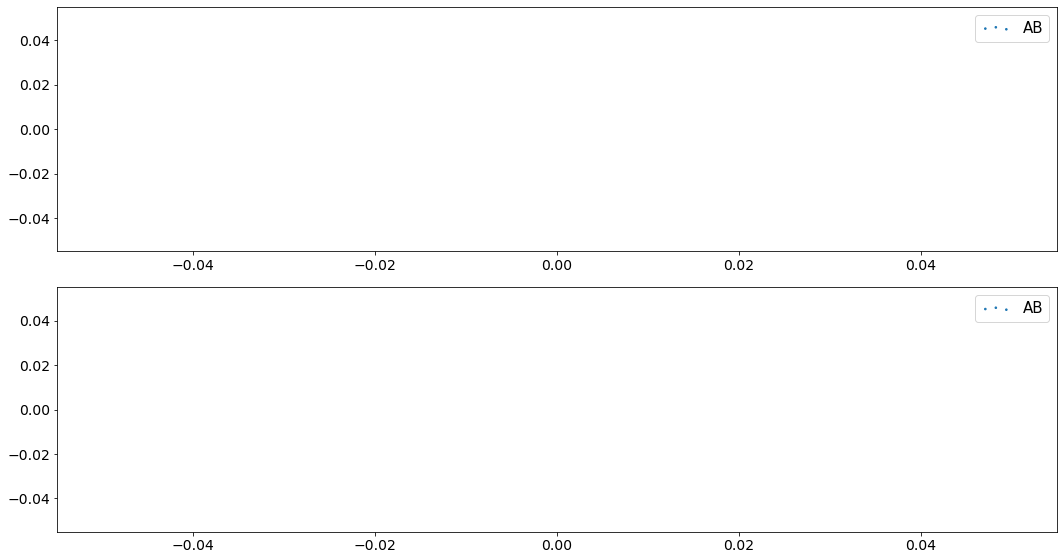


.
.
 5BCG.csv
  Fault type Percentage
0        NML     84.28%
1      FAULT     15.72%


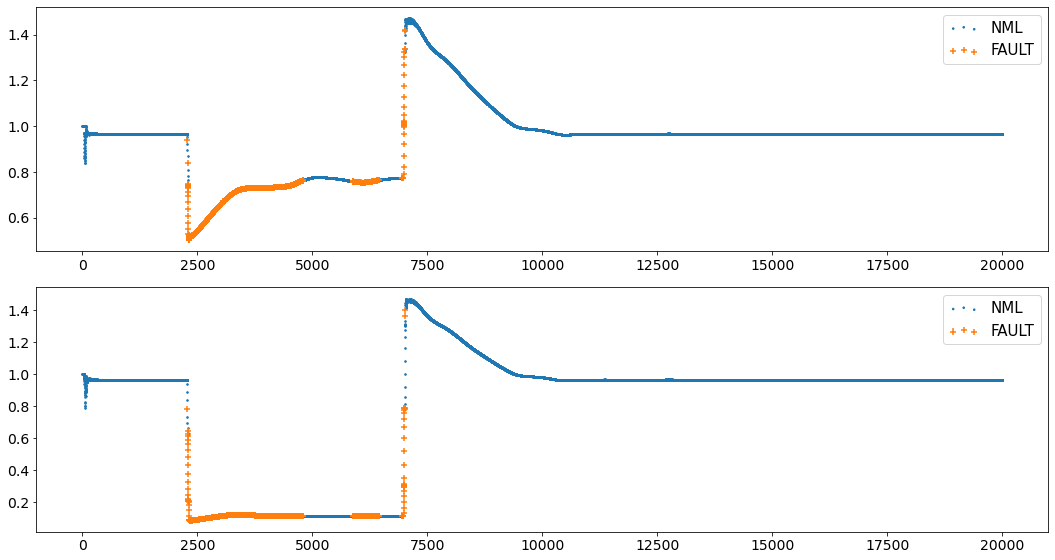

  Fault type Percentage
0        BCG     99.87%
1         CG       0.1%
2       ABCG      0.03%


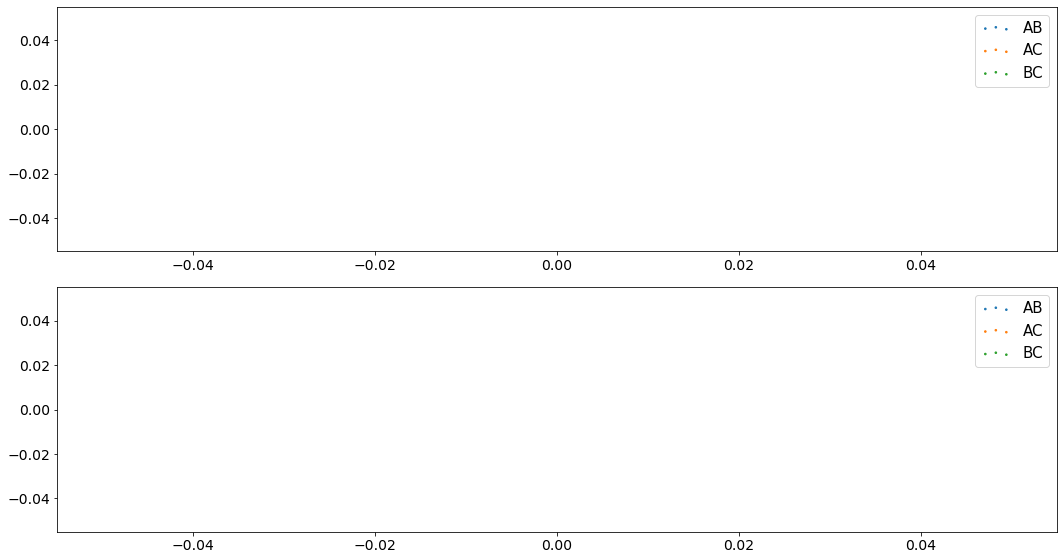


.
.
 2BG.csv
  Fault type Percentage
0        NML     99.17%
1      FAULT      0.83%


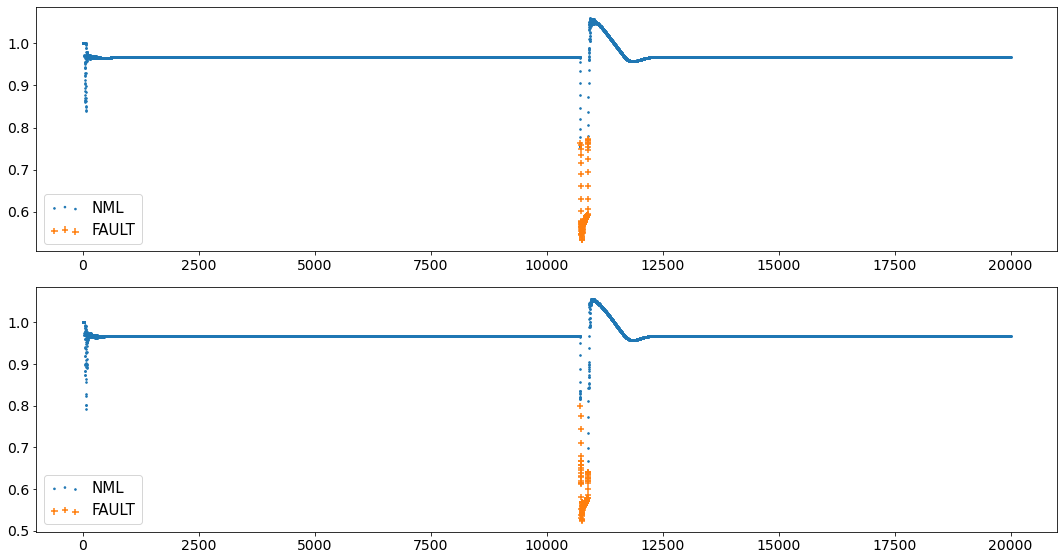

  Fault type Percentage
0         BG     100.0%


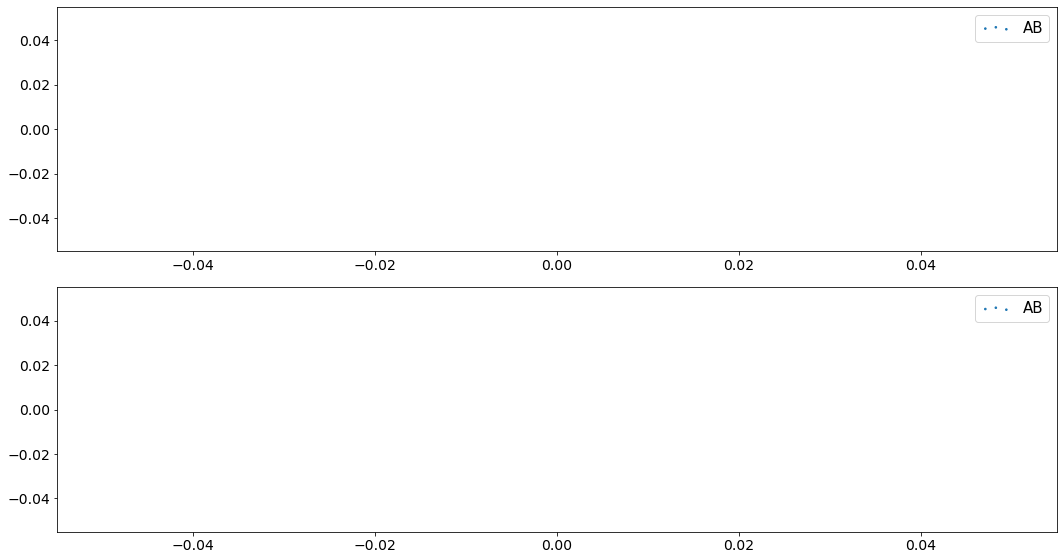


.
.
 6BC.csv
  Fault type Percentage
0        NML     84.39%
1      FAULT     15.62%


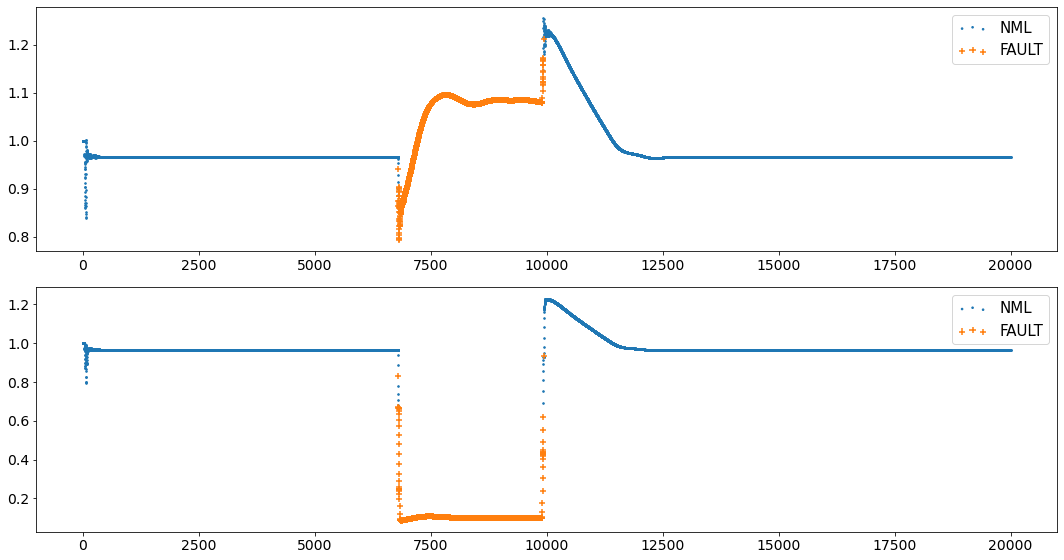

  Fault type Percentage
0         BC     99.87%
1        BCG      0.06%
2         AB      0.03%
3       ABCG      0.03%


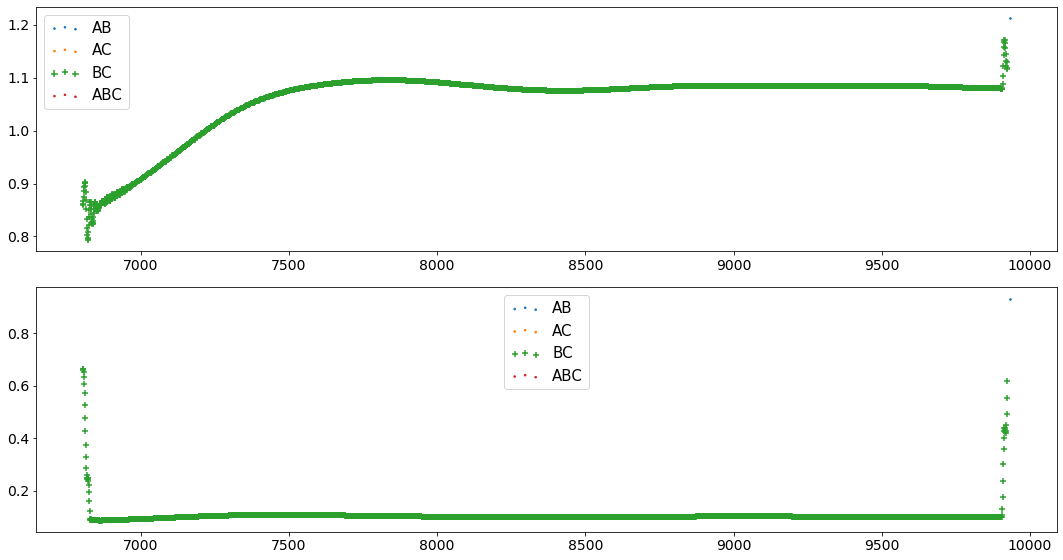


.
.
 6CG.csv
  Fault type Percentage
0        NML     84.25%
1      FAULT     15.75%


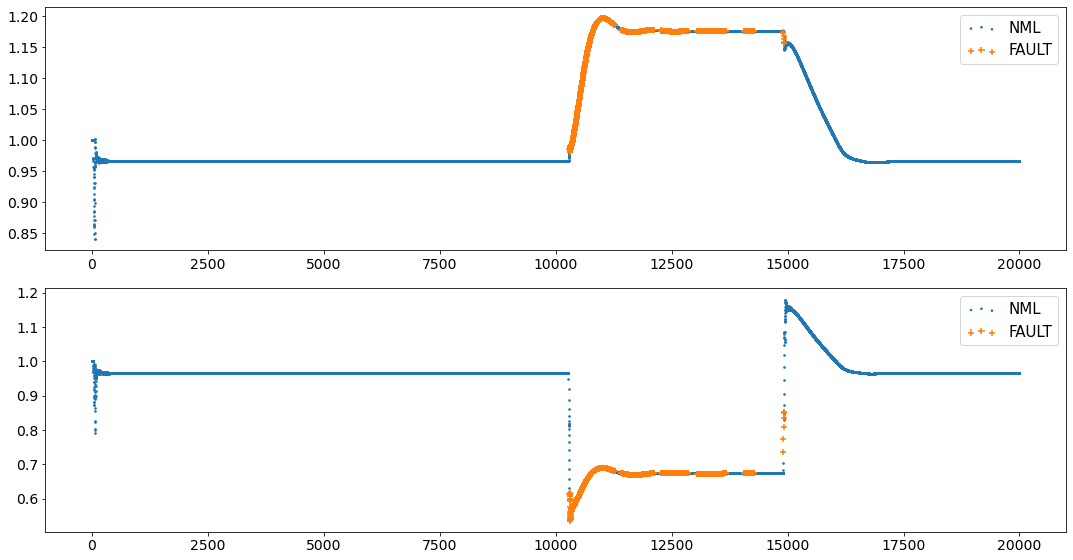

  Fault type Percentage
0         CG     100.0%


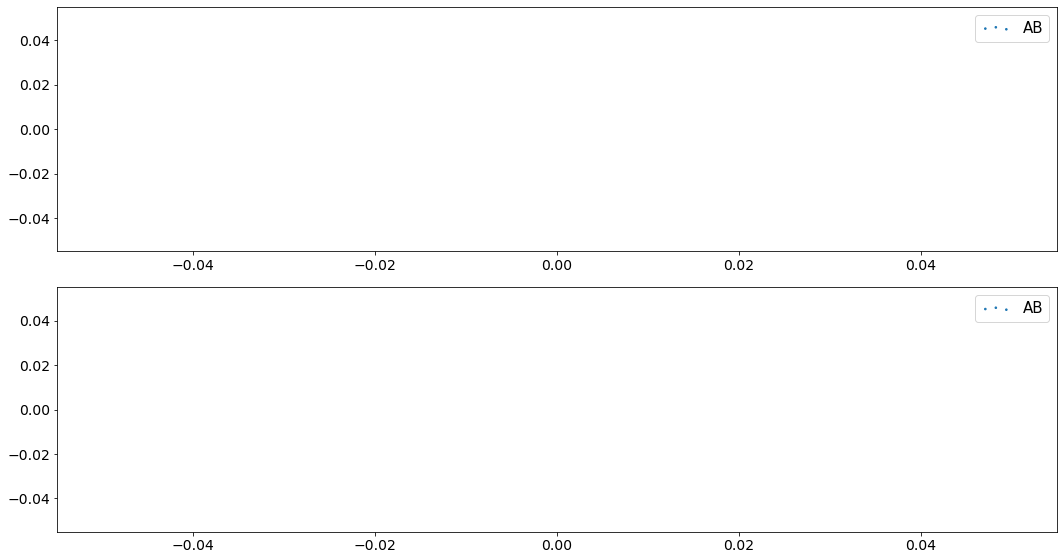


.
.
 7ABCG.csv
  Fault type Percentage
0        NML     95.84%
1      FAULT      4.16%


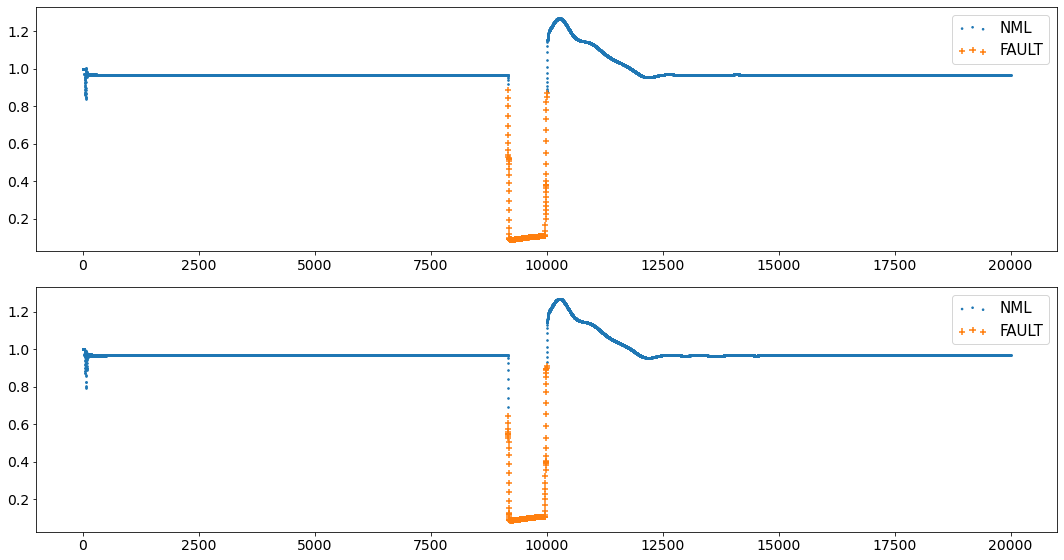

  Fault type Percentage
0        ABC     92.55%
1       ABCG      5.89%
2        BCG      0.96%
3        ABG       0.6%


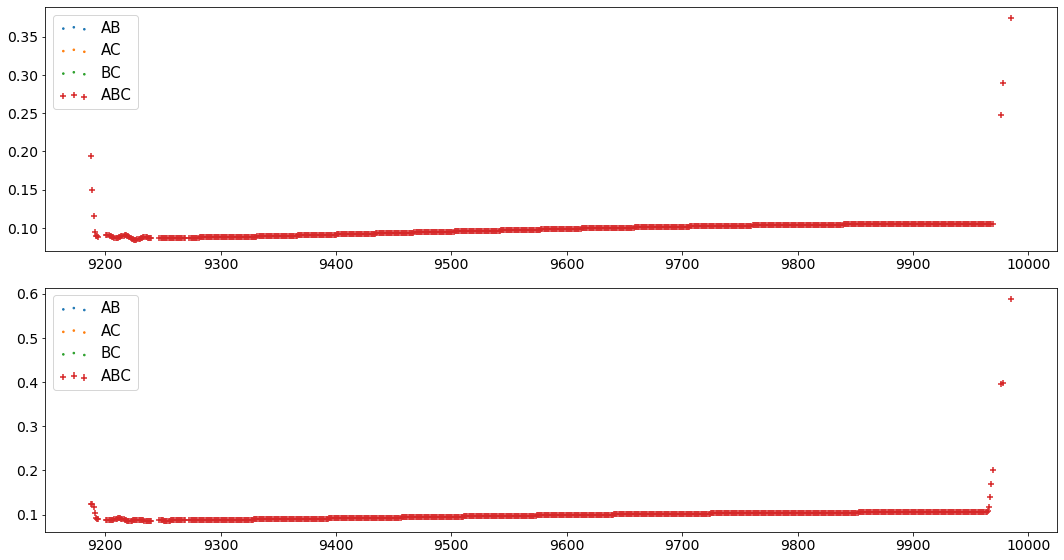


.
.
 9BCG.csv
  Fault type Percentage
0        NML      85.0%
1      FAULT     14.99%


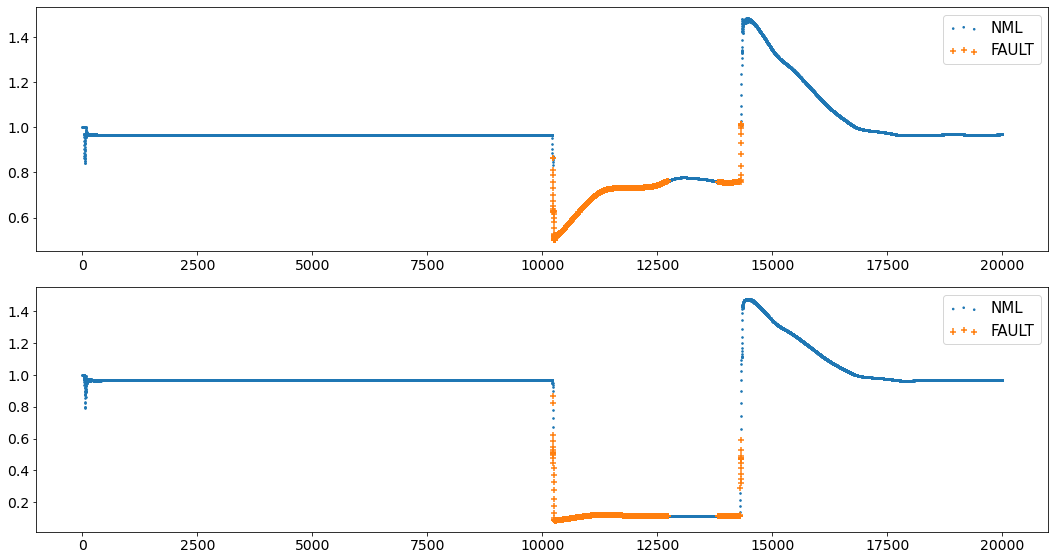

  Fault type Percentage
0        BCG     99.87%
1         CG      0.07%
2       ABCG      0.07%


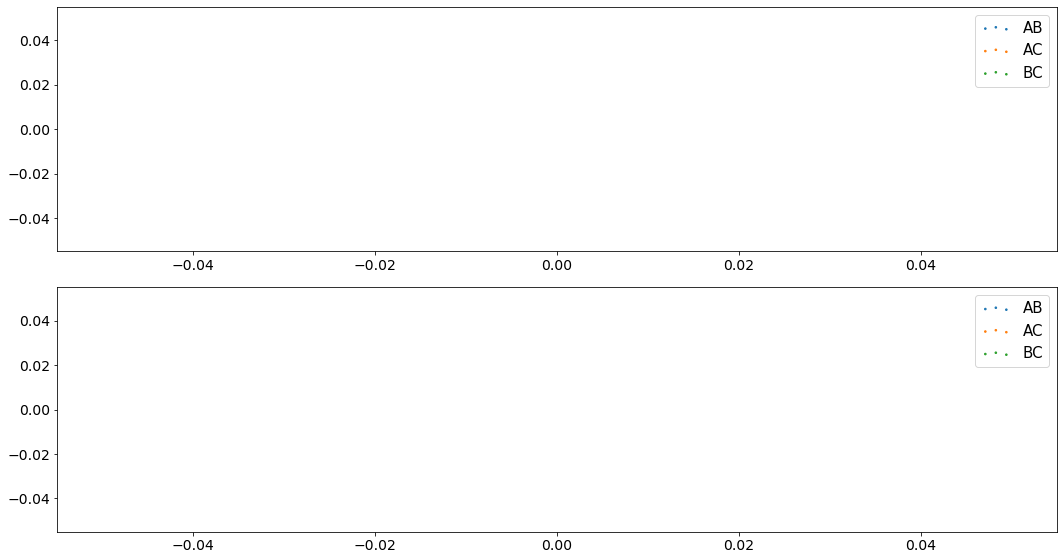


.
.
 10AG.csv
  Fault type Percentage
0        NML      91.3%
1      FAULT      8.71%


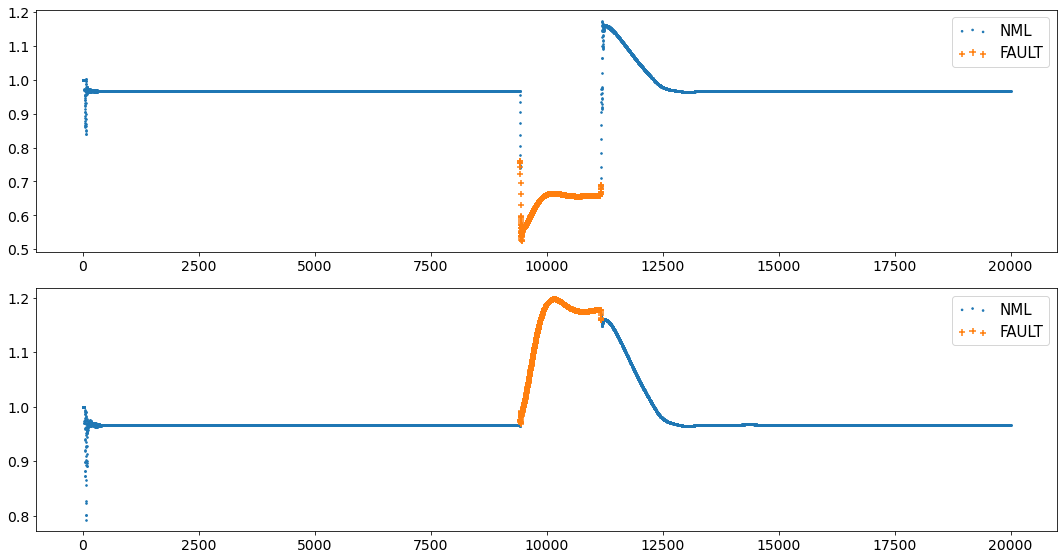

  Fault type Percentage
0         AG     100.0%


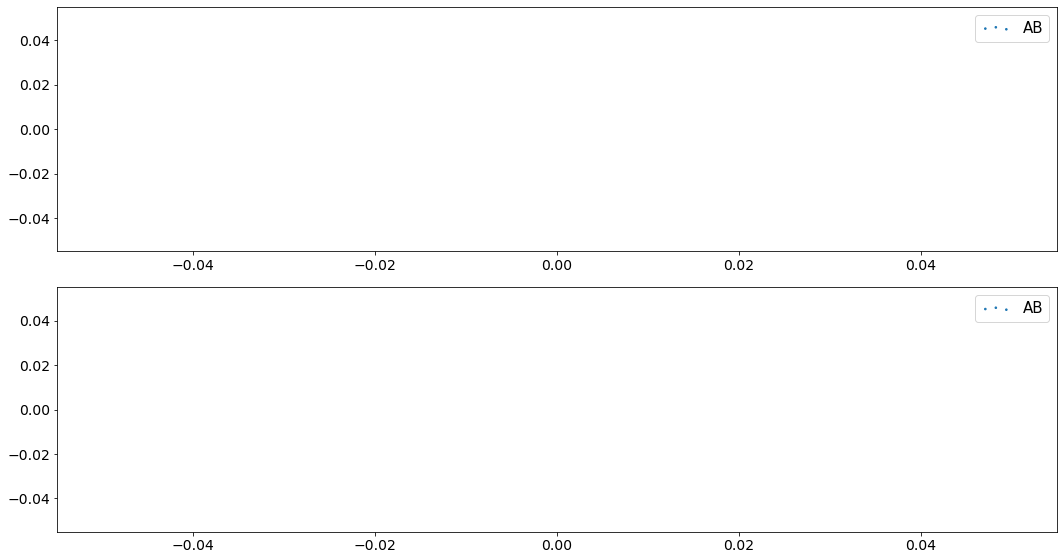


.
.
 3ABC.csv
  Fault type Percentage
0        NML     96.81%
1      FAULT      3.19%


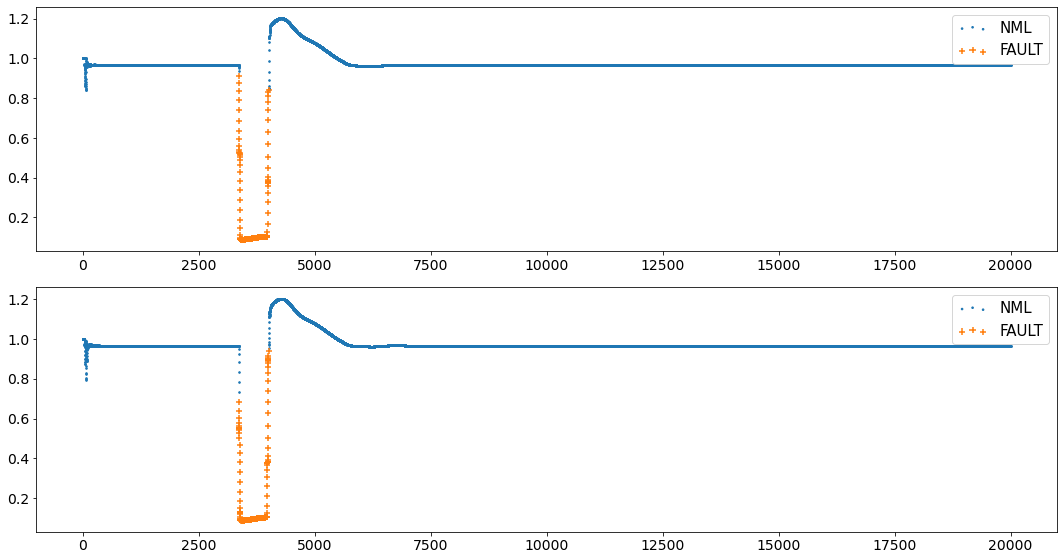

  Fault type Percentage
0        ABC     89.81%
1       ABCG      7.68%
2        ABG      1.25%
3        BCG      1.25%


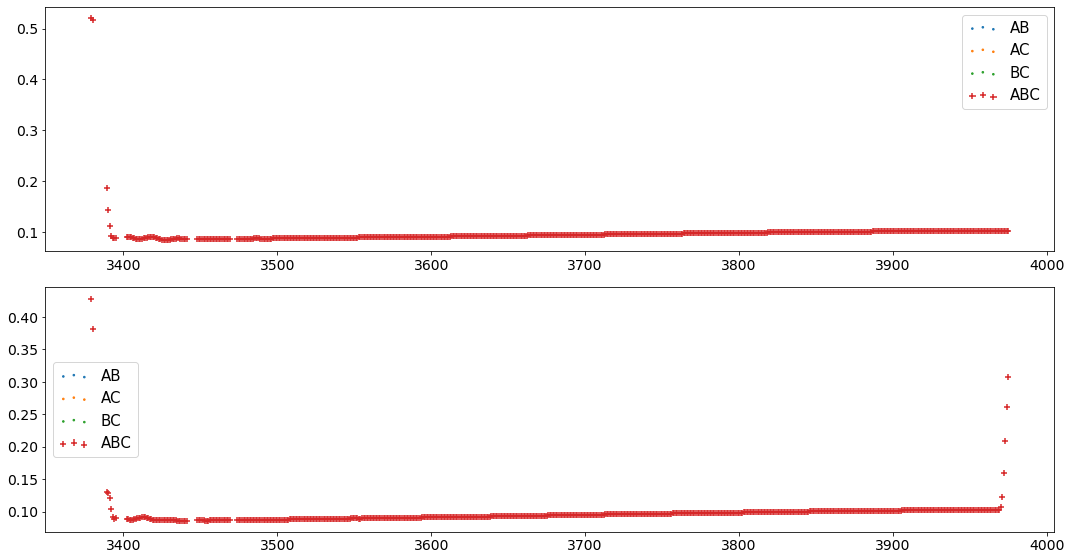


.
.
 3ACG.csv
  Fault type Percentage
0        NML     85.79%
1      FAULT     14.21%


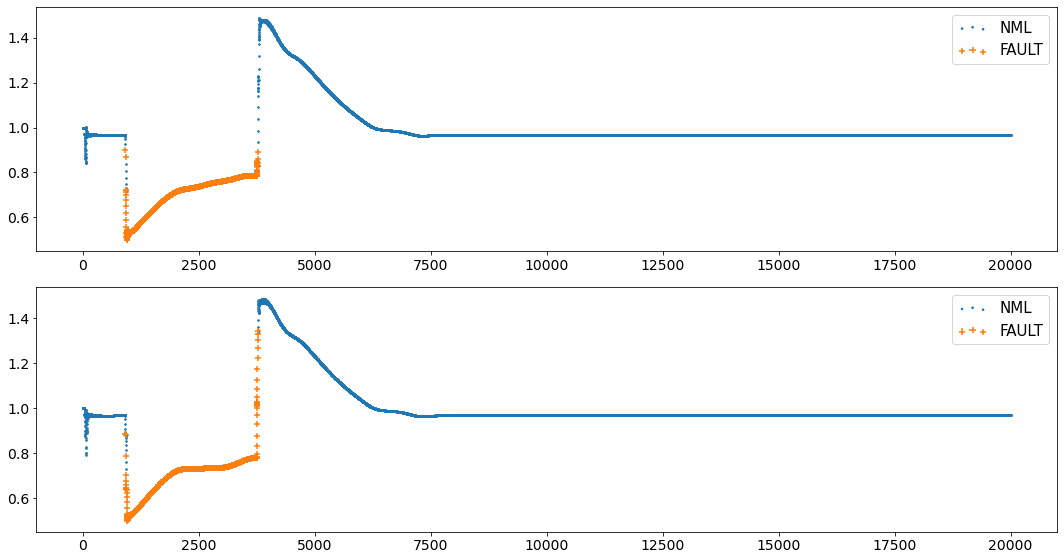

  Fault type Percentage
0        ACG     99.89%
1       ABCG      0.07%
2         AG      0.04%


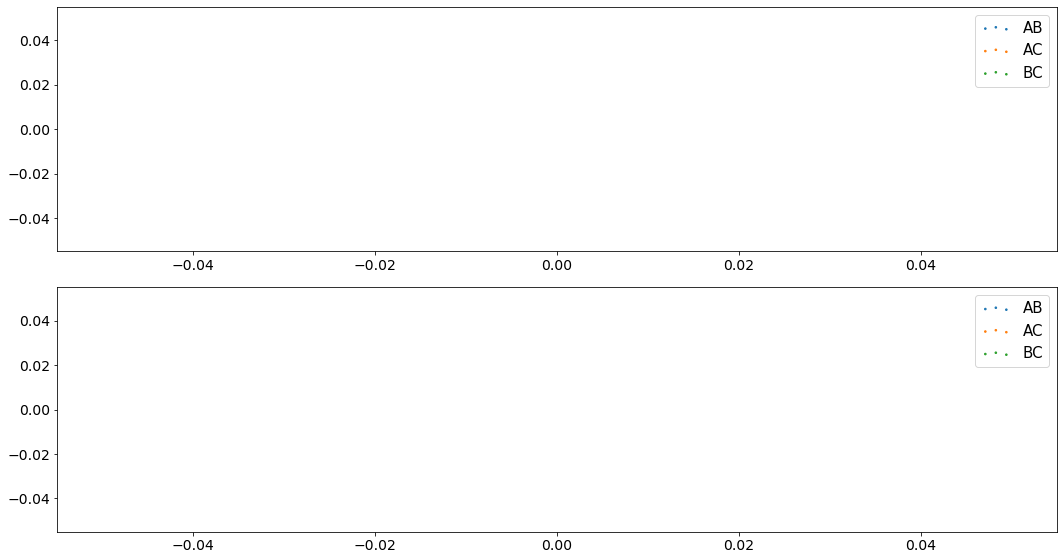


.
.
 8AC.csv
  Fault type Percentage
0        NML     93.22%
1      FAULT      6.79%


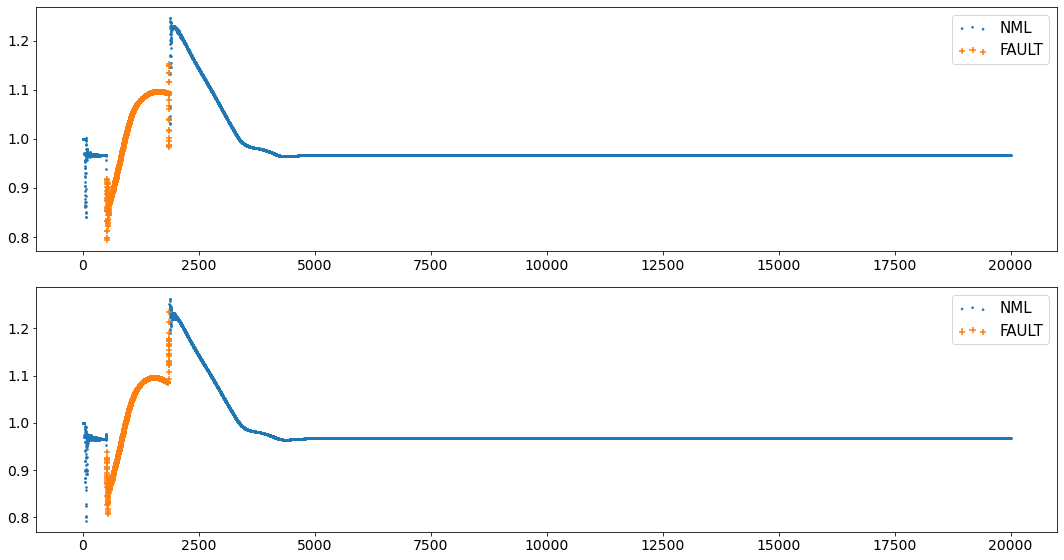

  Fault type Percentage
0         AC     99.85%
1        ACG      0.15%


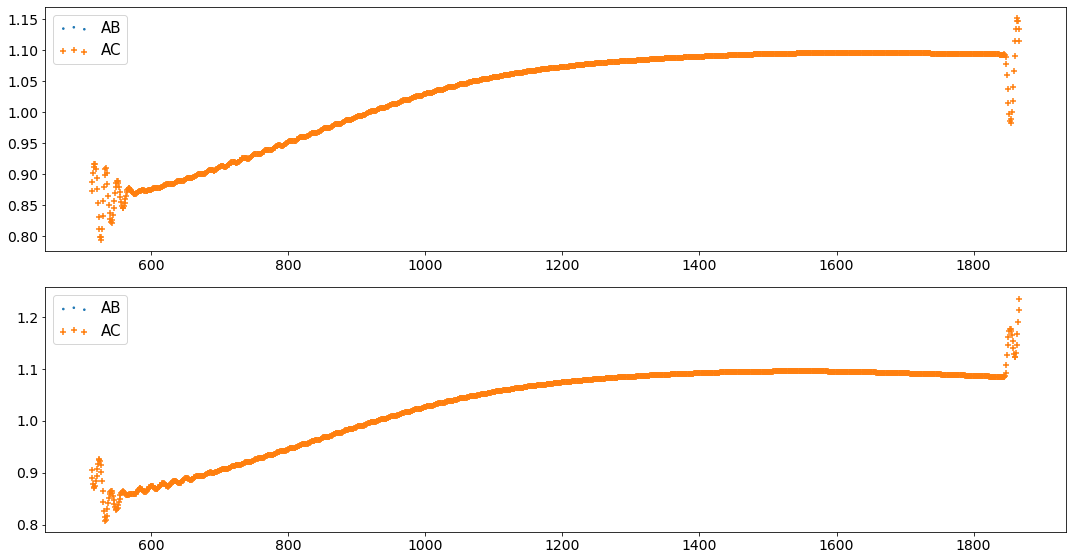


.
.
 4BC.csv
  Fault type Percentage
0        NML     84.78%
1      FAULT     15.22%


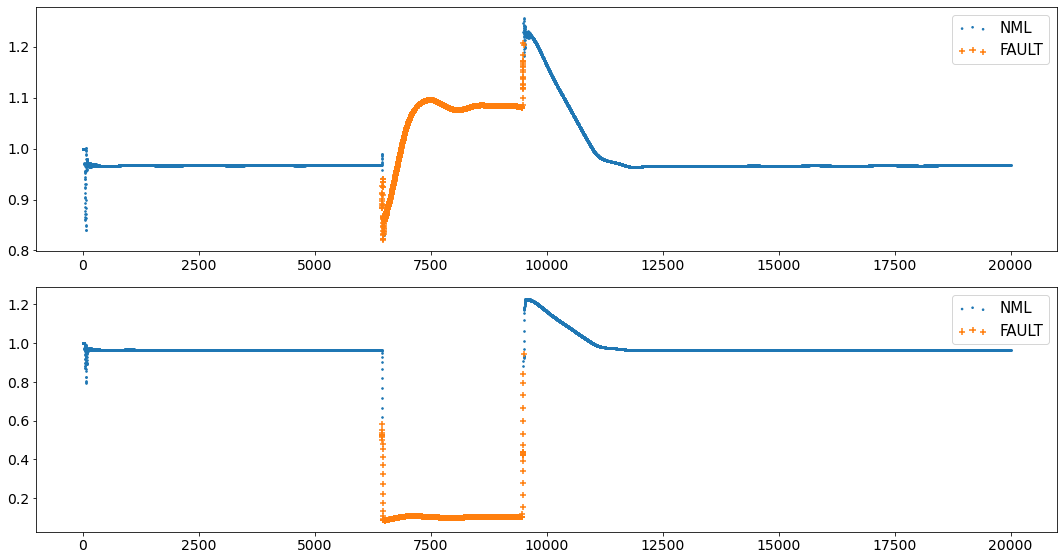

  Fault type Percentage
0         BC      99.9%
1        BCG      0.07%
2       ABCG      0.03%


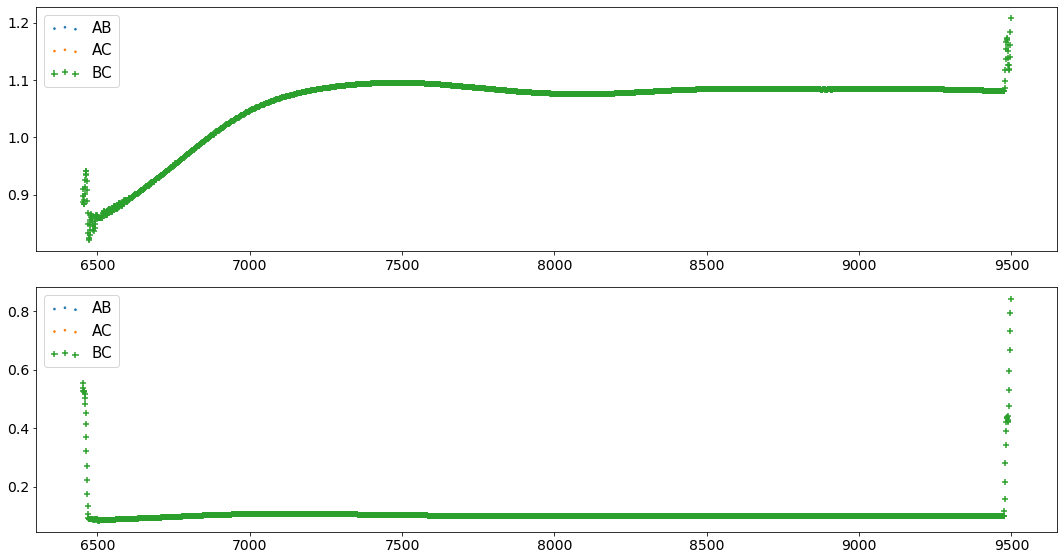


.
.
 4CG.csv
  Fault type Percentage
0        NML     92.53%
1      FAULT      7.47%


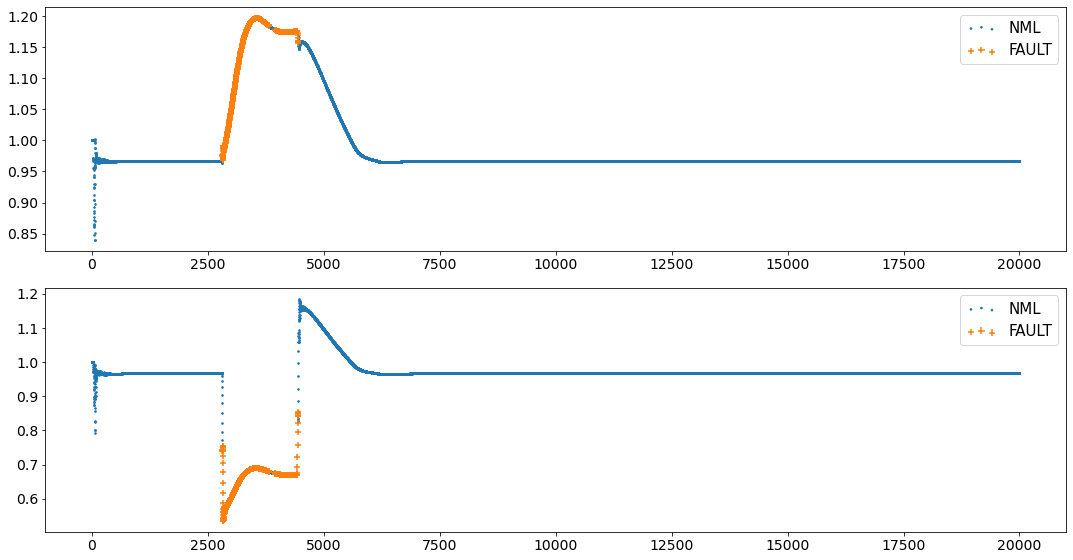

  Fault type Percentage
0         CG     100.0%


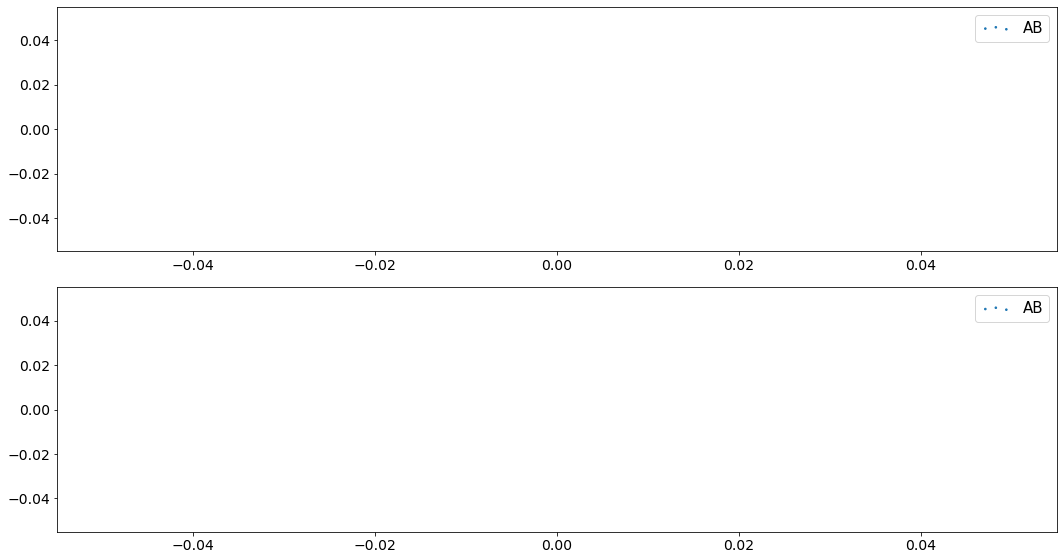


.
.
 1ABG.csv
  Fault type Percentage
0        NML     77.75%
1      FAULT     22.25%


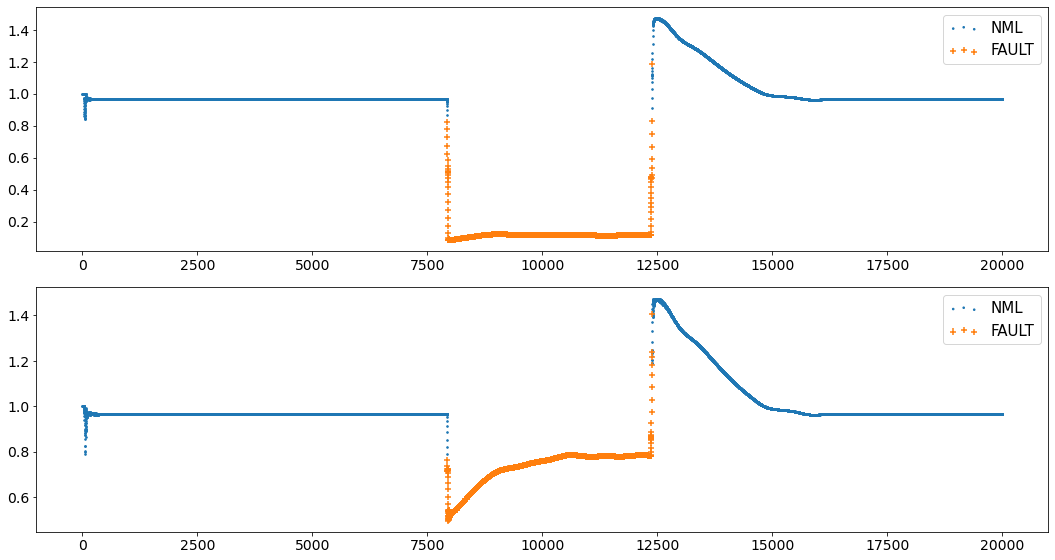

  Fault type Percentage
0        ABG     99.78%
1        BCG      0.09%
2         AB      0.07%
3       ABCG      0.07%


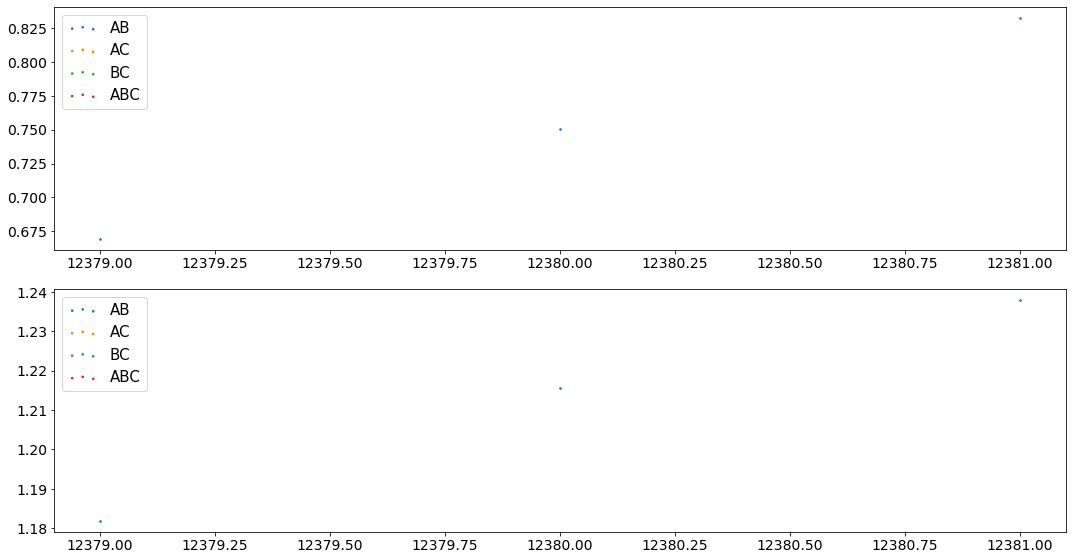


.
.
 8AB.csv
  Fault type Percentage
0        NML     97.98%
1      FAULT      2.02%


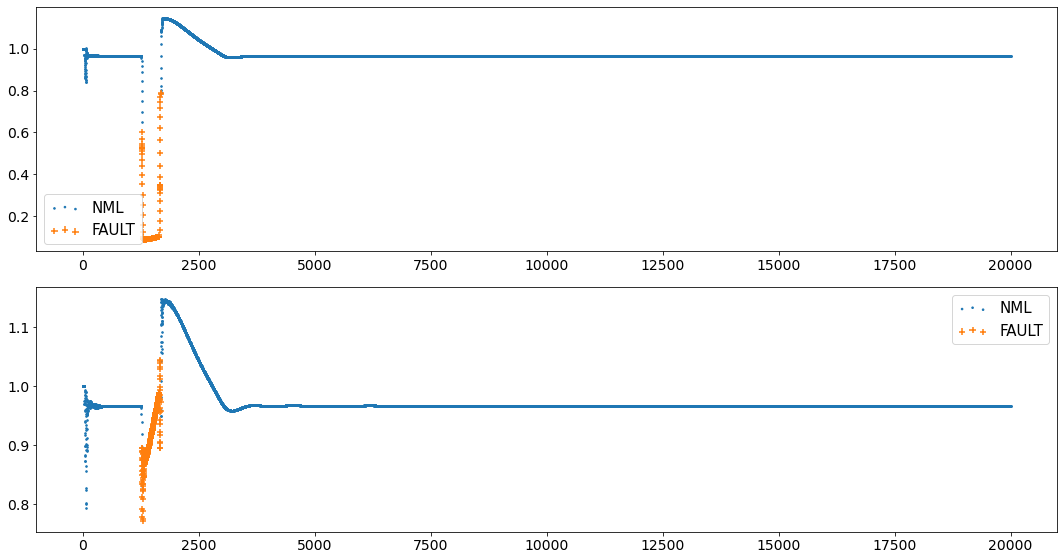

  Fault type Percentage
0         AB     96.53%
1        ABG      3.47%


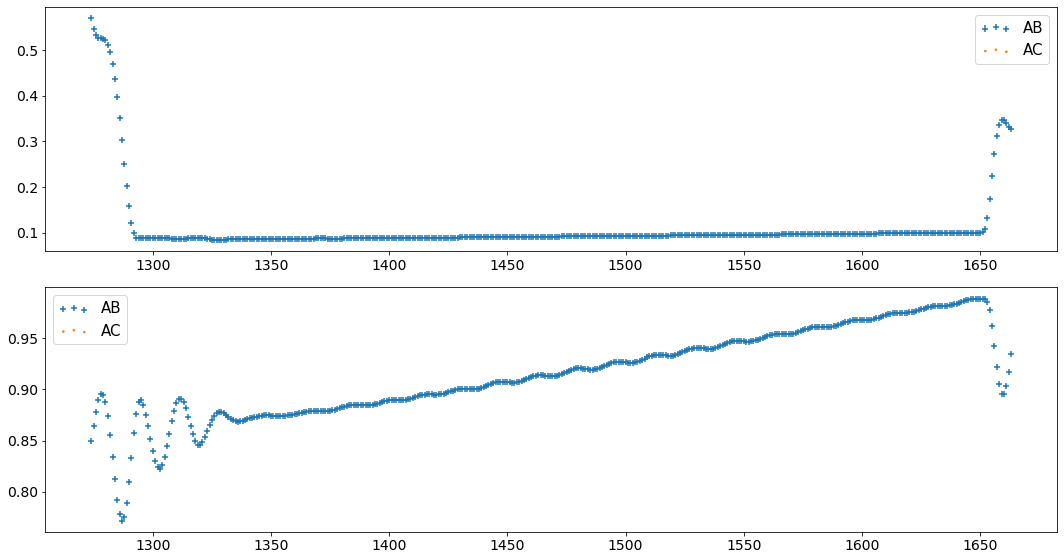


.
.
 10BCG.csv
  Fault type Percentage
0        NML     96.64%
1      FAULT      3.37%


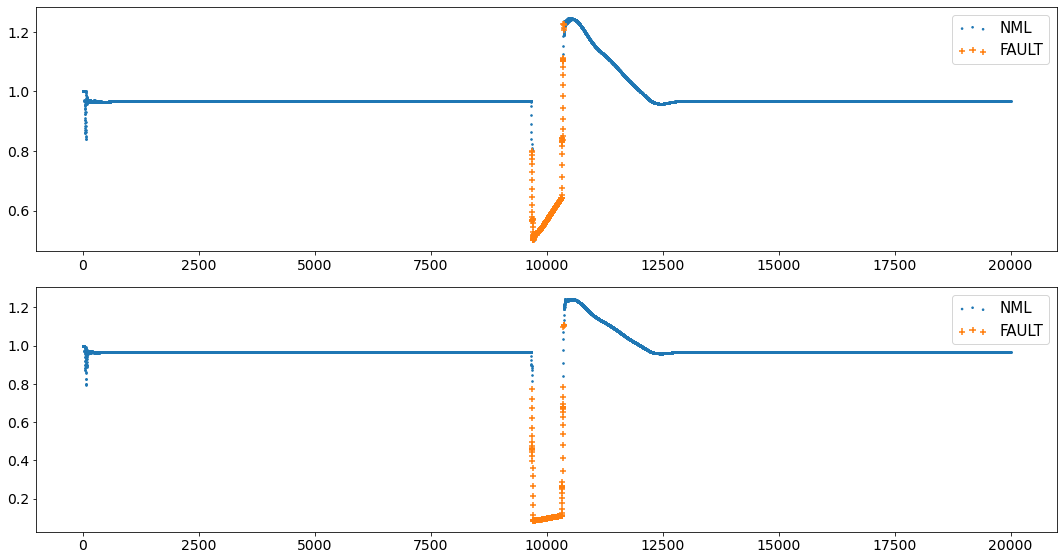

  Fault type Percentage
0        BCG     97.03%
1       ABCG      2.38%
2         CG      0.59%


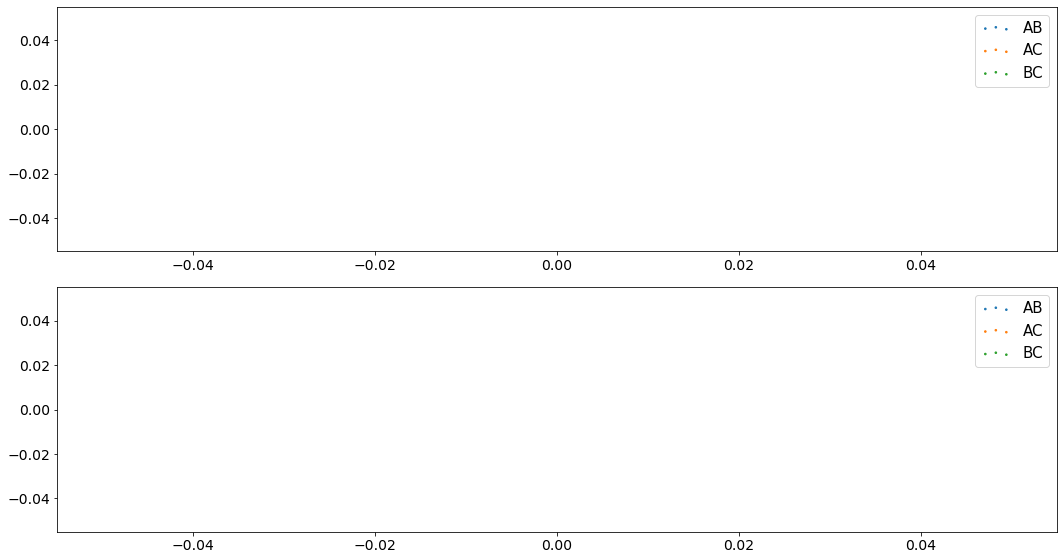


.
.
 8CG.csv
  Fault type Percentage
0        NML     99.36%
1      FAULT      0.65%


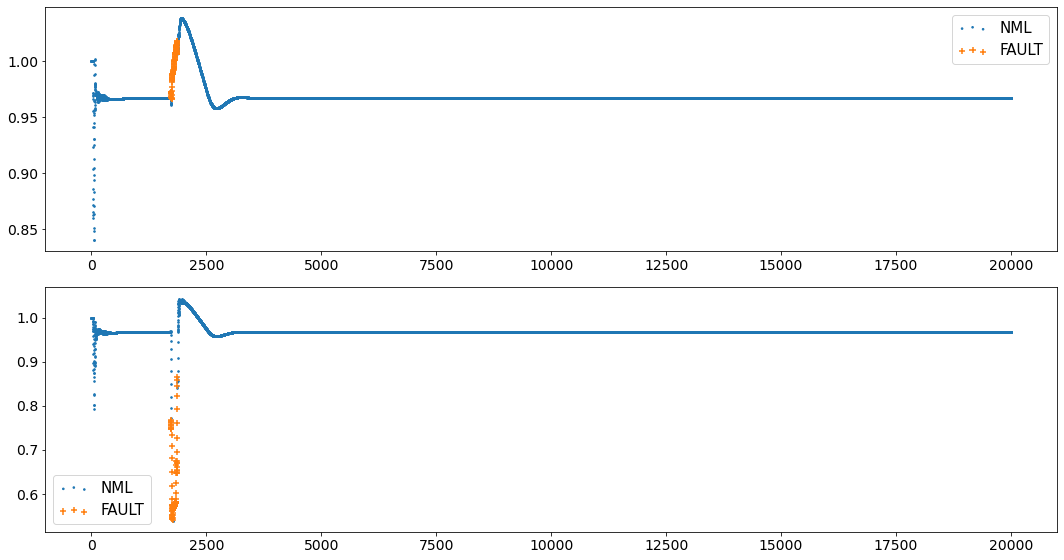

  Fault type Percentage
0         CG     100.0%


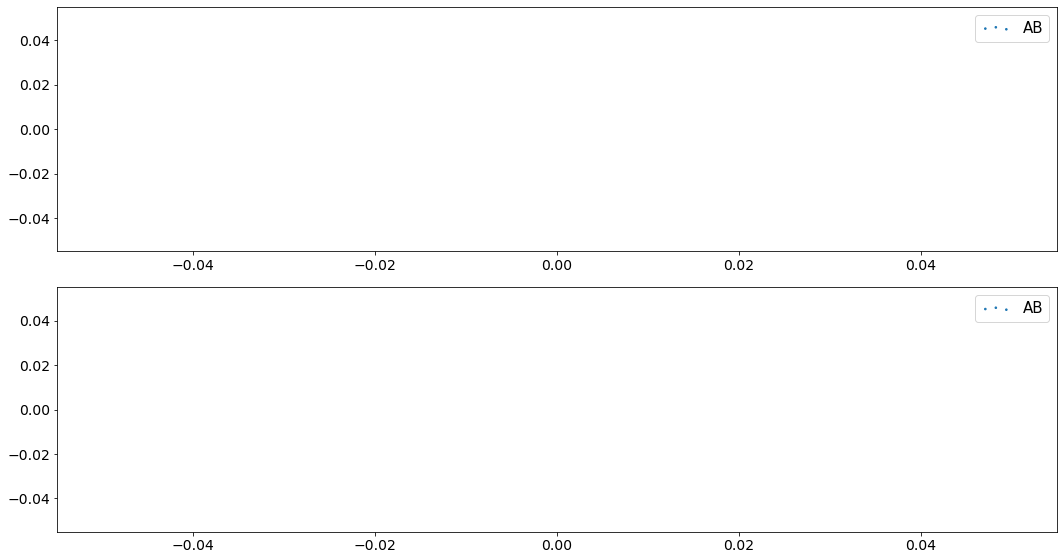


.
.
 8BC.csv
  Fault type Percentage
0        NML     99.81%
1      FAULT      0.19%


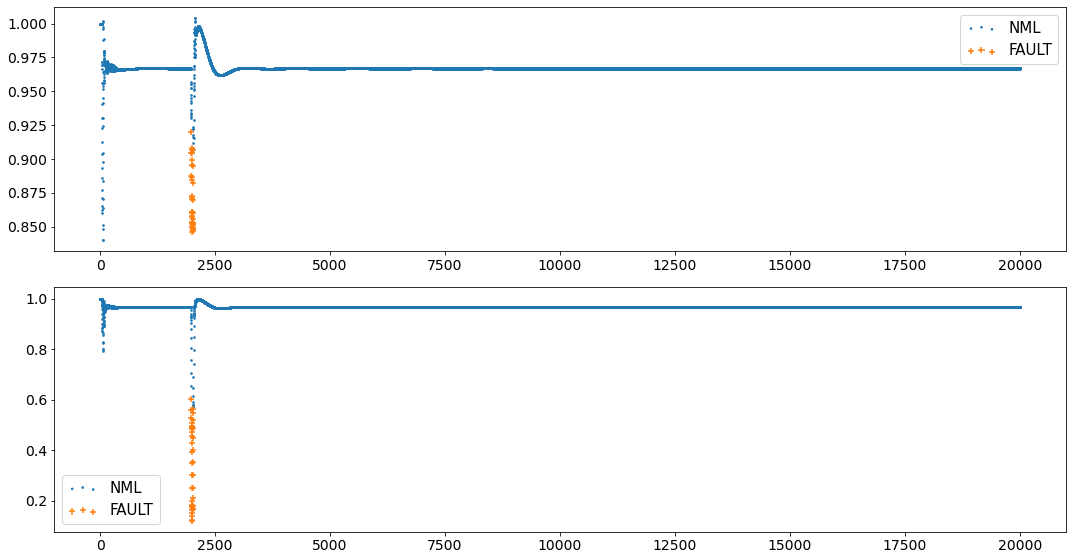

  Fault type Percentage
0         BC     92.11%
1        BCG      7.89%


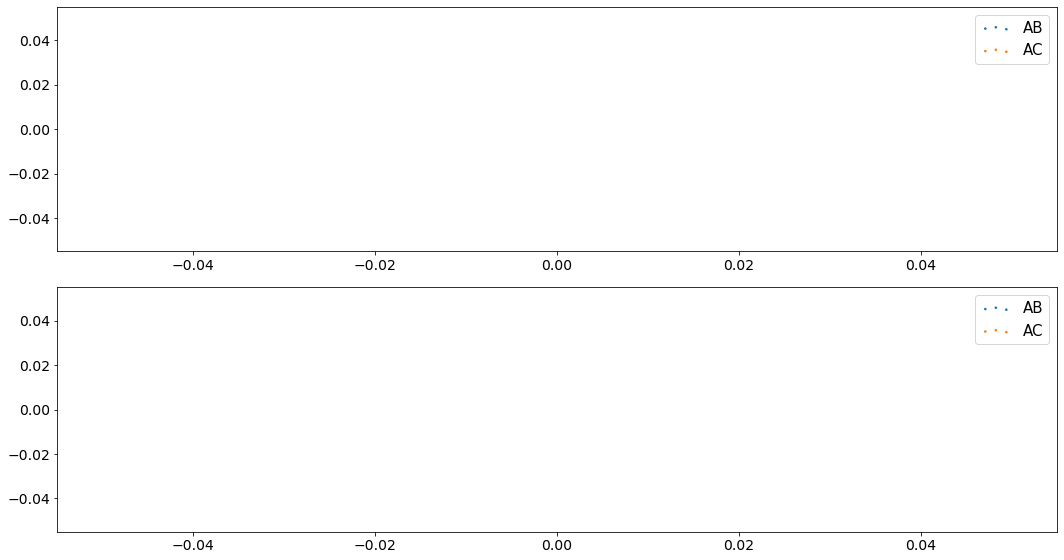


.
.
 4AB.csv
  Fault type Percentage
0        NML     97.64%
1      FAULT      2.35%


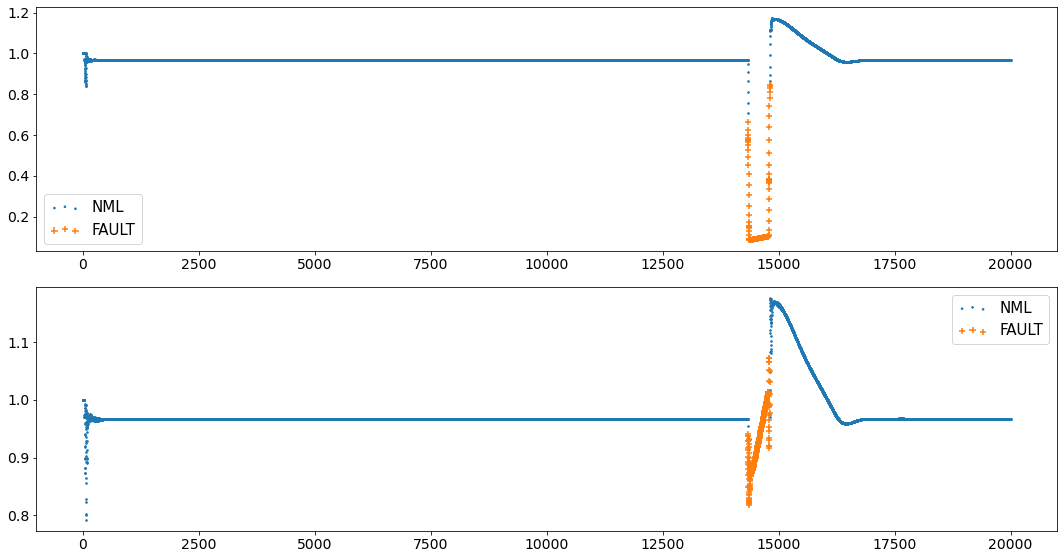

  Fault type Percentage
0         AB     95.97%
1        ABG      4.03%


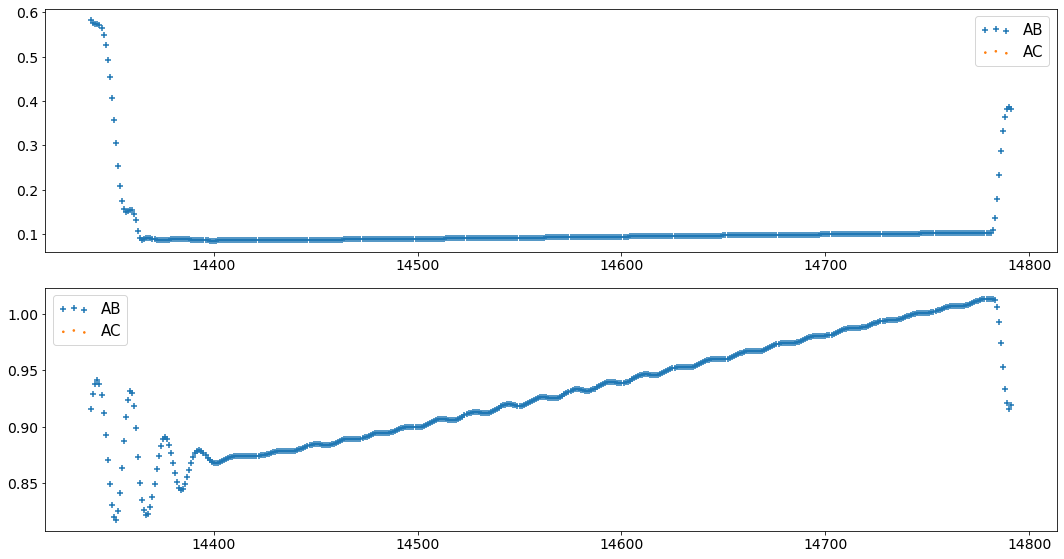


.
.
 6ACG.csv
  Fault type Percentage
0        NML     64.81%
1      FAULT      35.2%


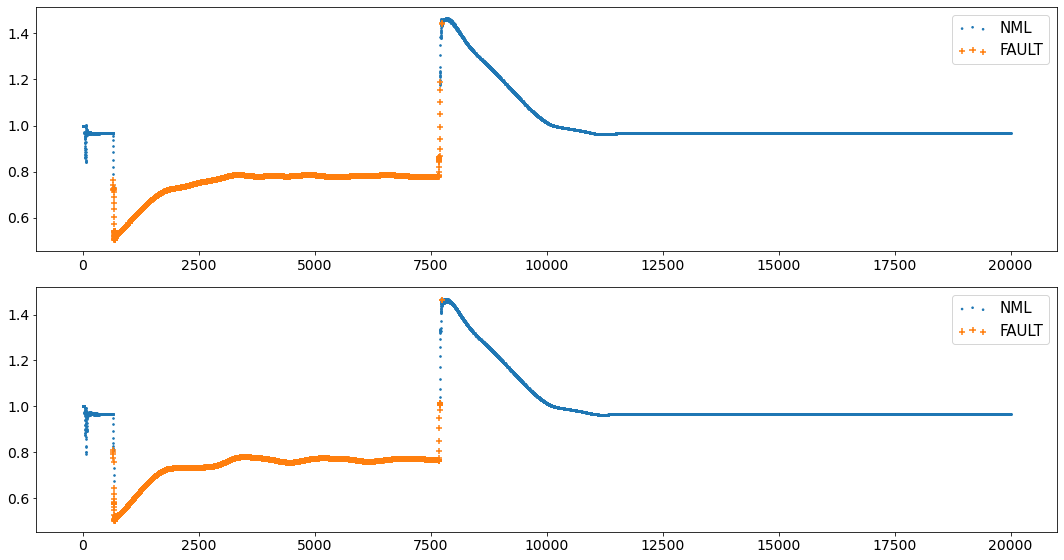

  Fault type Percentage
0        ACG     99.89%
1       ABCG       0.1%
2         AC      0.01%


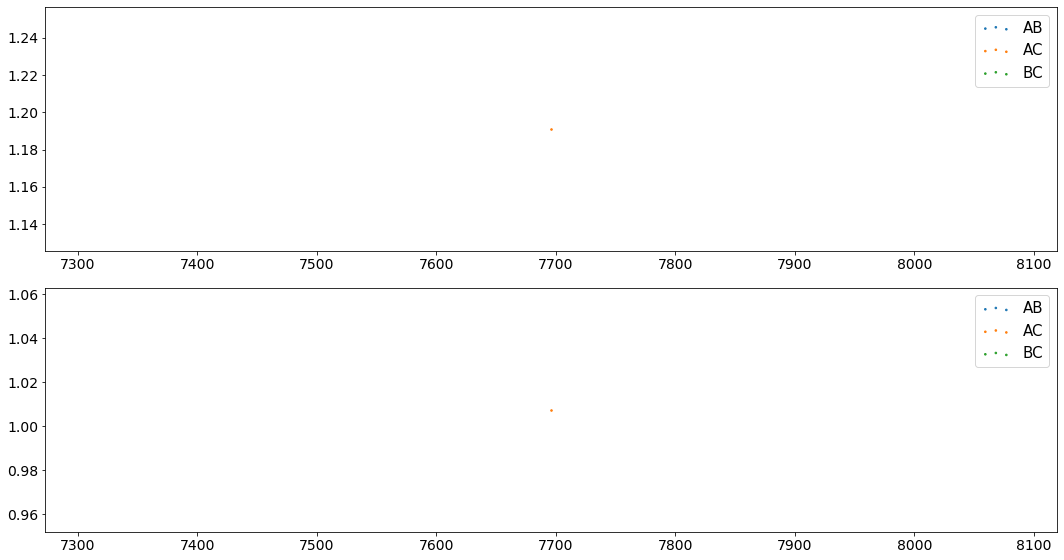


.
.
 6ABC.csv
  Fault type Percentage
0        NML     96.58%
1      FAULT      3.42%


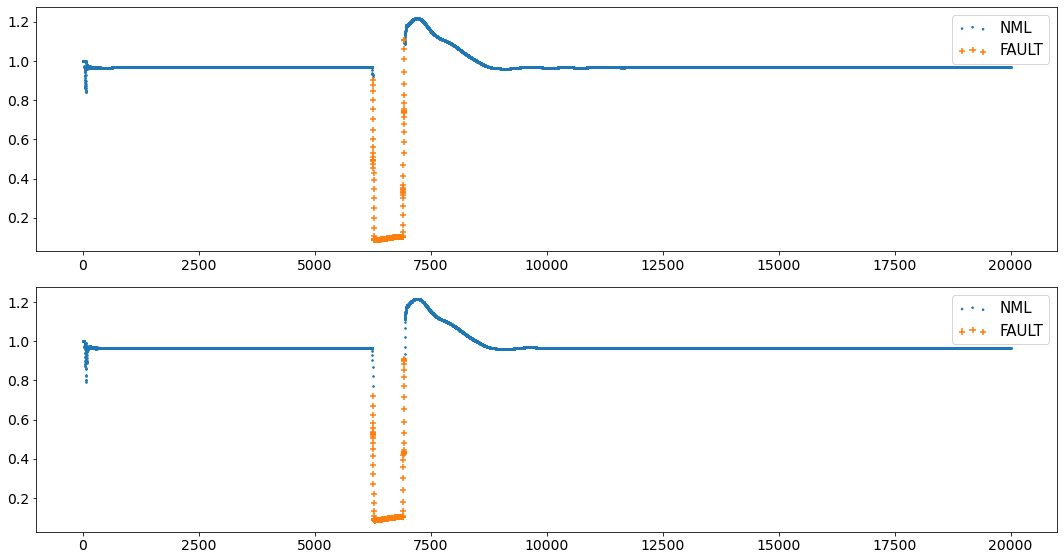

  Fault type Percentage
0        ABC     90.22%
1       ABCG      8.03%
2        BCG      1.46%
3        ACG      0.29%


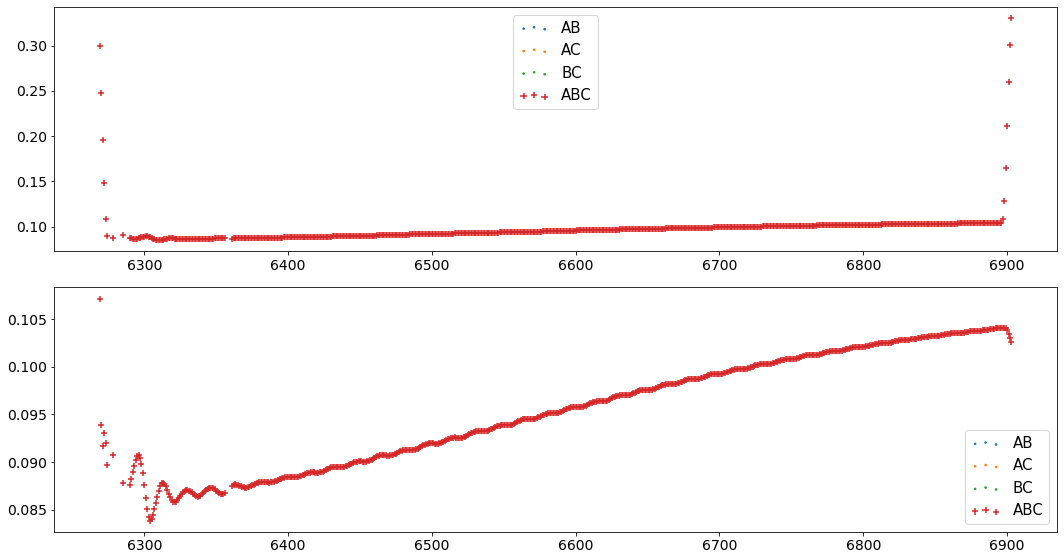


.
.
 8ABG.csv
  Fault type Percentage
0        NML     95.85%
1      FAULT      4.15%


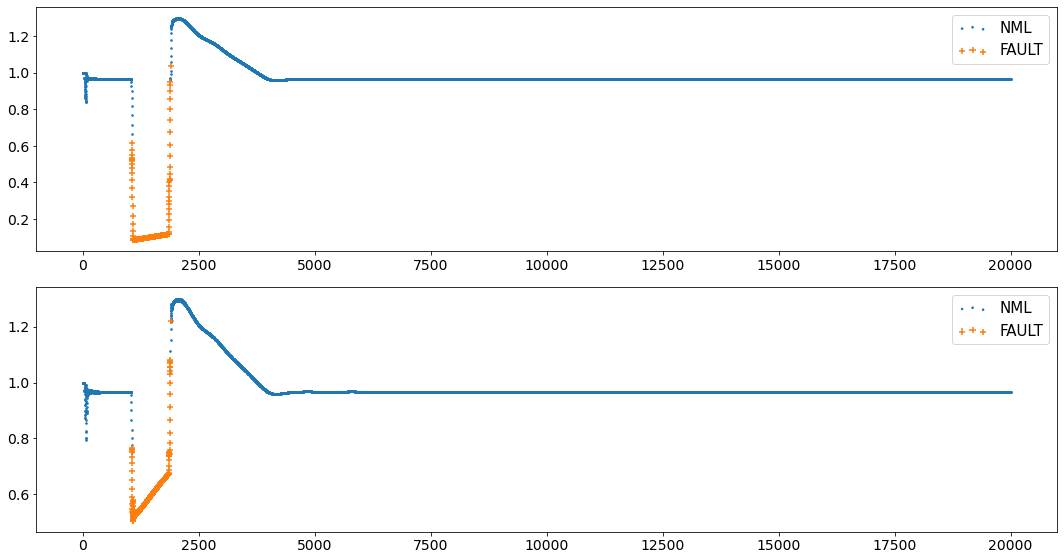

  Fault type Percentage
0        ABG     99.88%
1       ABCG      0.12%


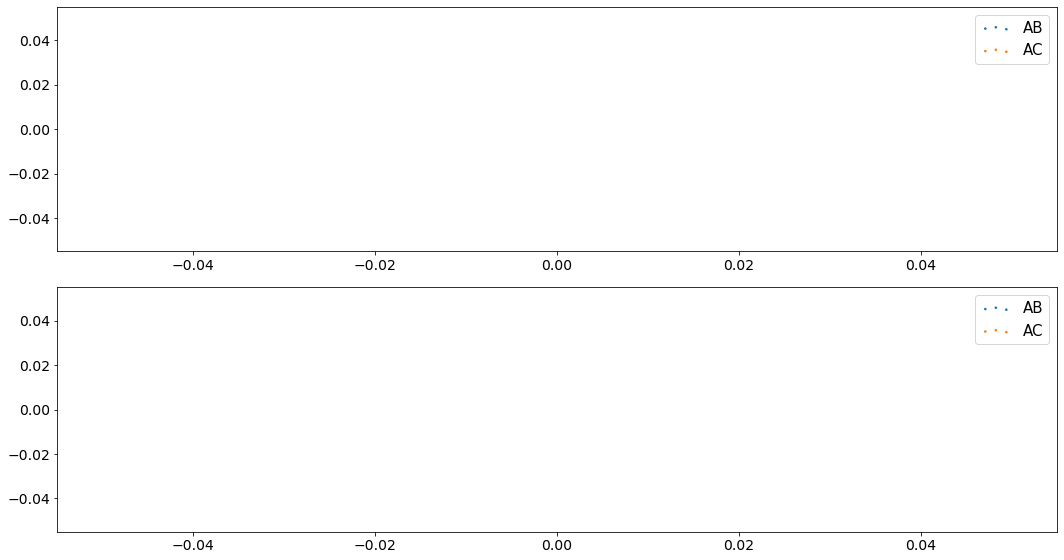


.
.
 4AC.csv
  Fault type Percentage
0        NML     96.75%
1      FAULT      3.25%


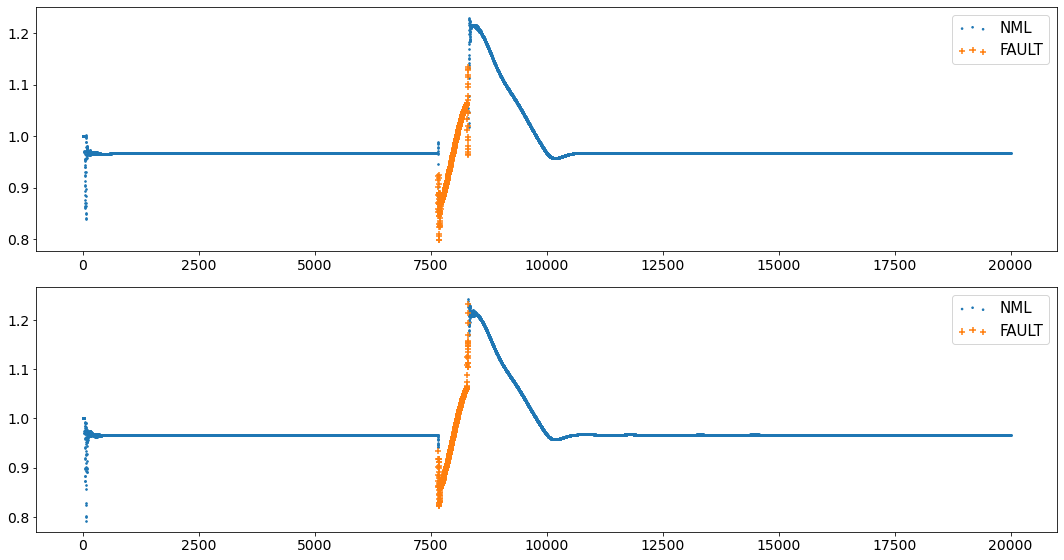

  Fault type Percentage
0         AC      97.7%
1        ACG       2.3%


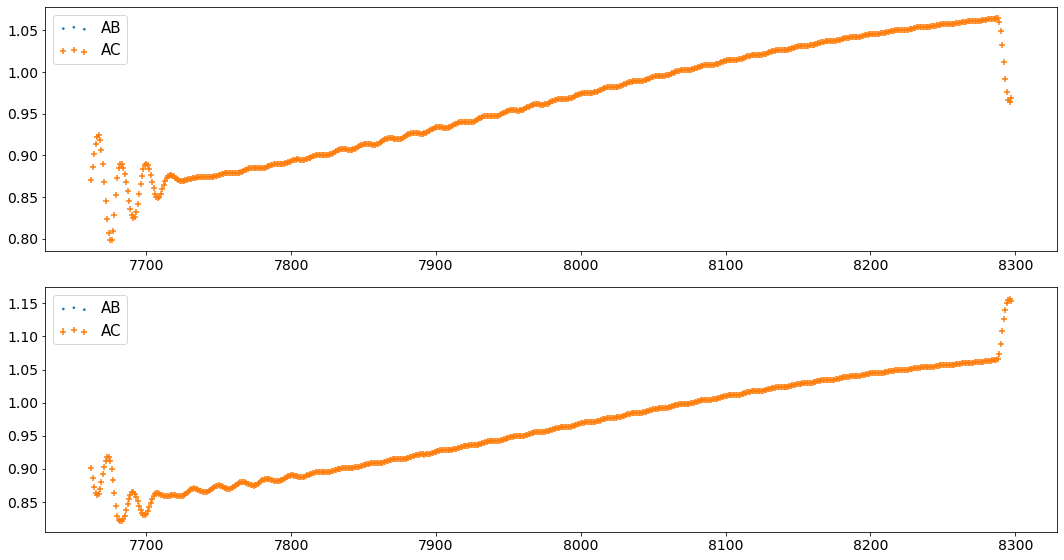


.
.
 4ABG.csv
  Fault type Percentage
0        NML     91.39%
1      FAULT      8.62%


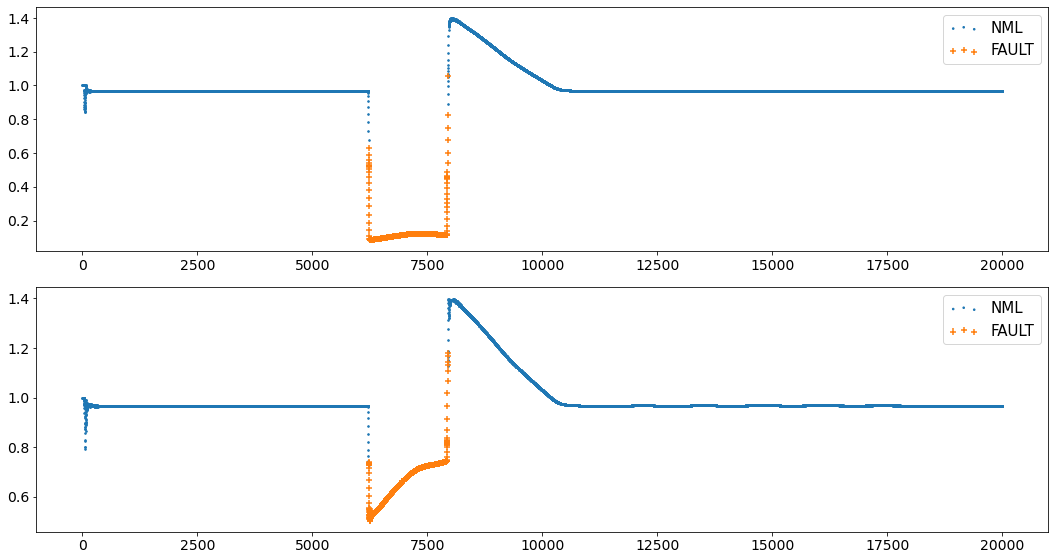

  Fault type Percentage
0        ABG     99.88%
1         AG      0.06%
2        BCG      0.06%


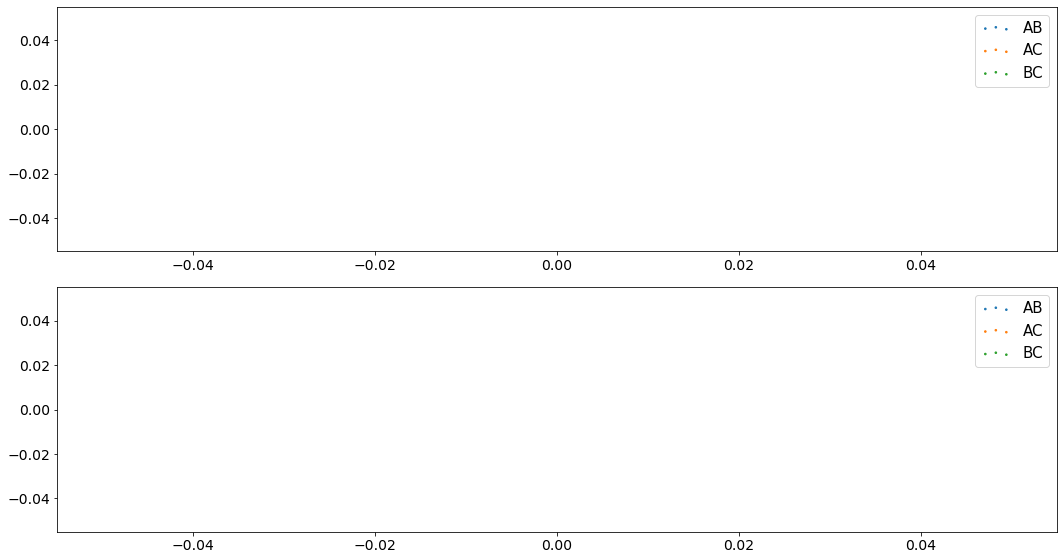


.
.
 2AG.csv
  Fault type Percentage
0        NML     95.09%
1      FAULT      4.91%


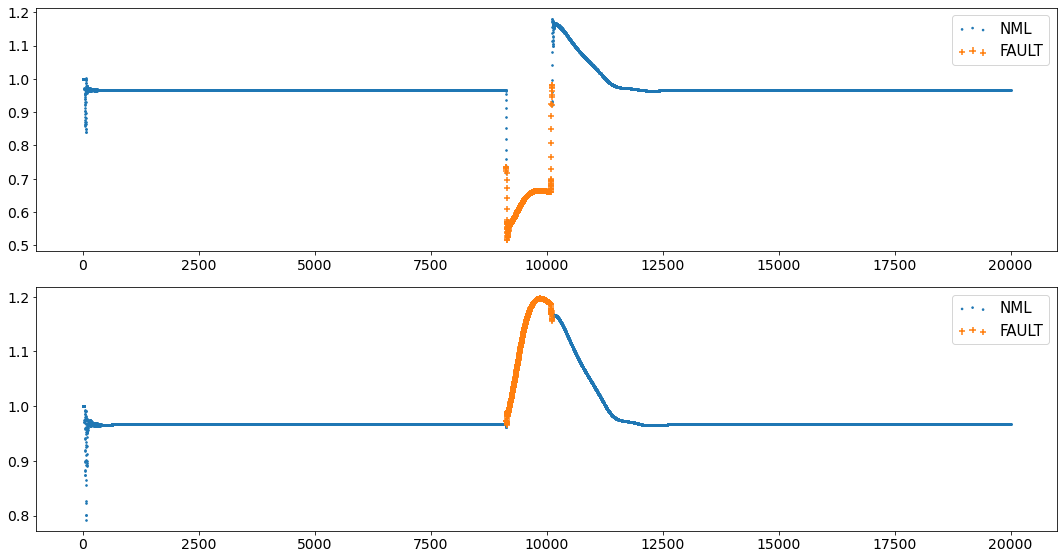

  Fault type Percentage
0         AG      99.9%
1         AC       0.1%


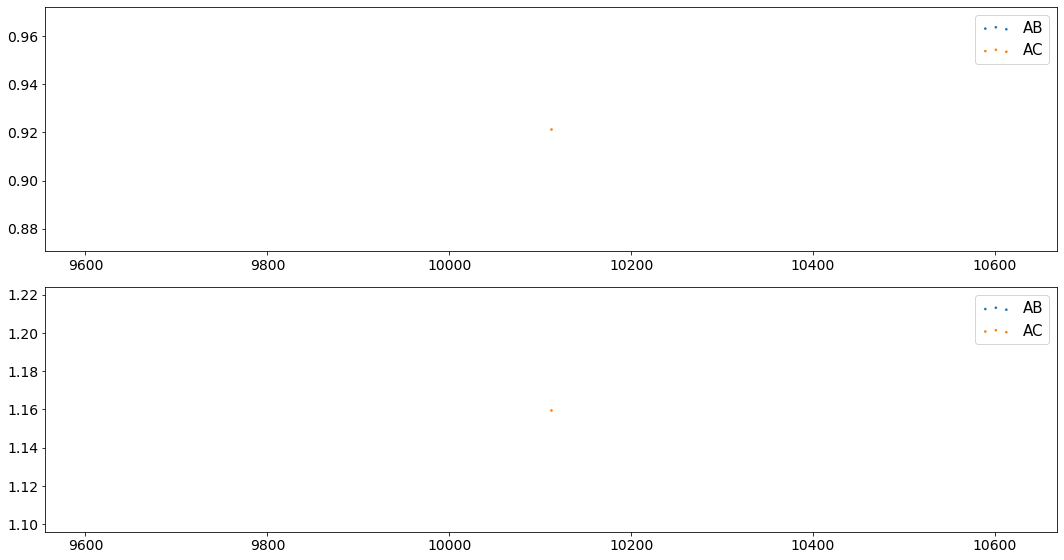


.
.
 6AC.csv
  Fault type Percentage
0        NML     96.67%
1      FAULT      3.33%


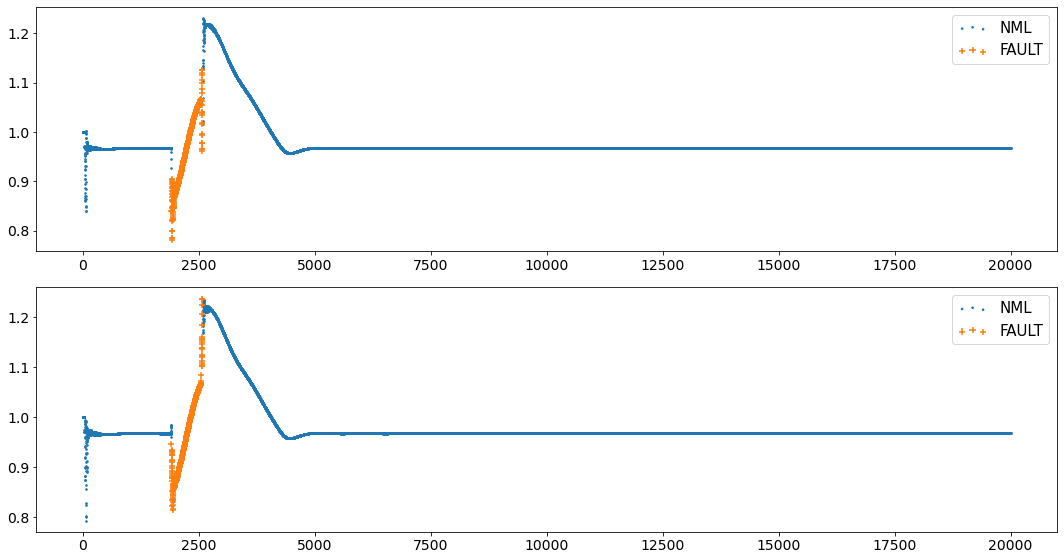

  Fault type Percentage
0         AC     97.75%
1        ACG      2.25%


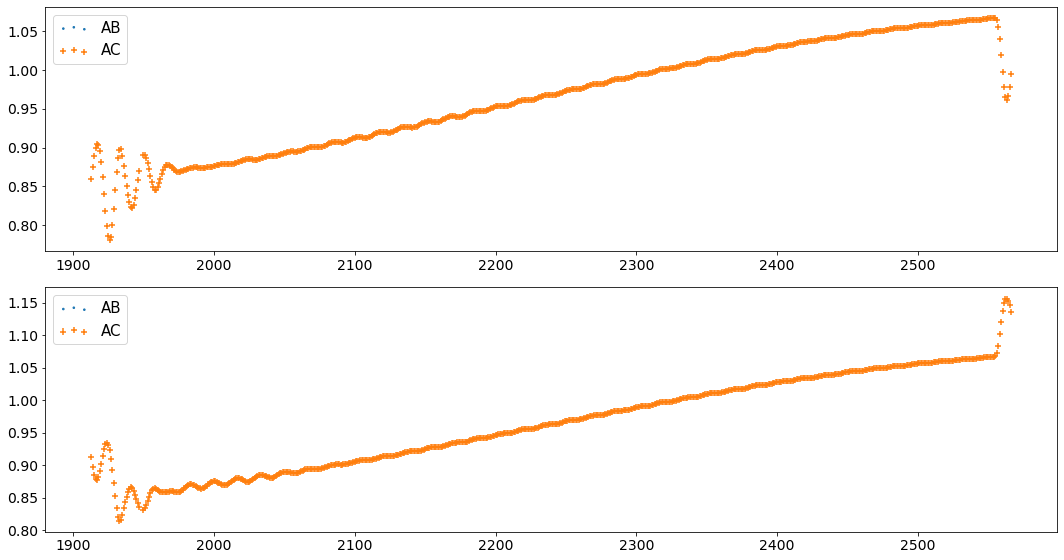


.
.
 6AB.csv
  Fault type Percentage
0        NML     93.32%
1      FAULT      6.68%


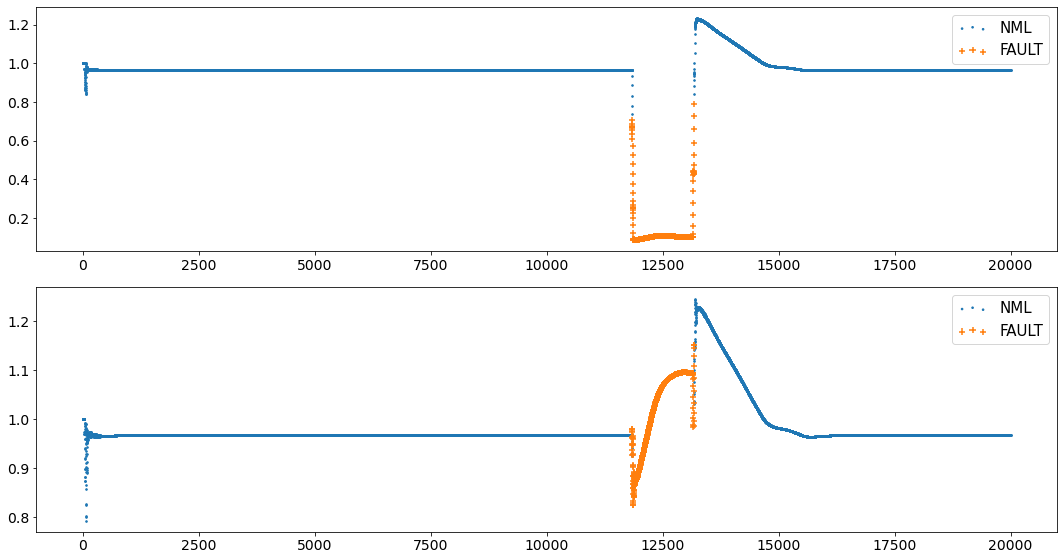

  Fault type Percentage
0         AB      99.7%
1        ABG       0.3%


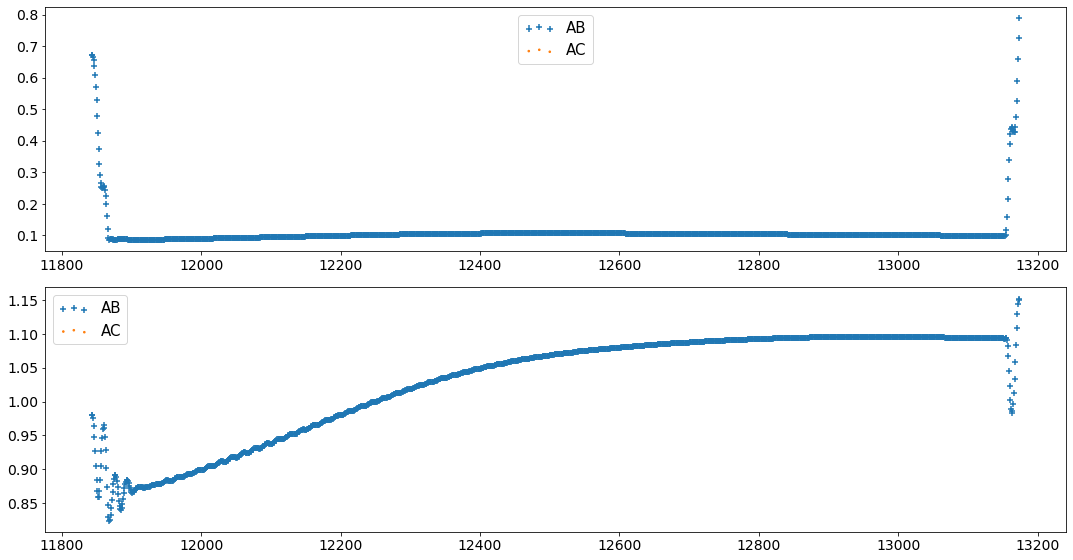


.
.
 2ABCG.csv
  Fault type Percentage
0        NML     73.15%
1      FAULT     26.85%


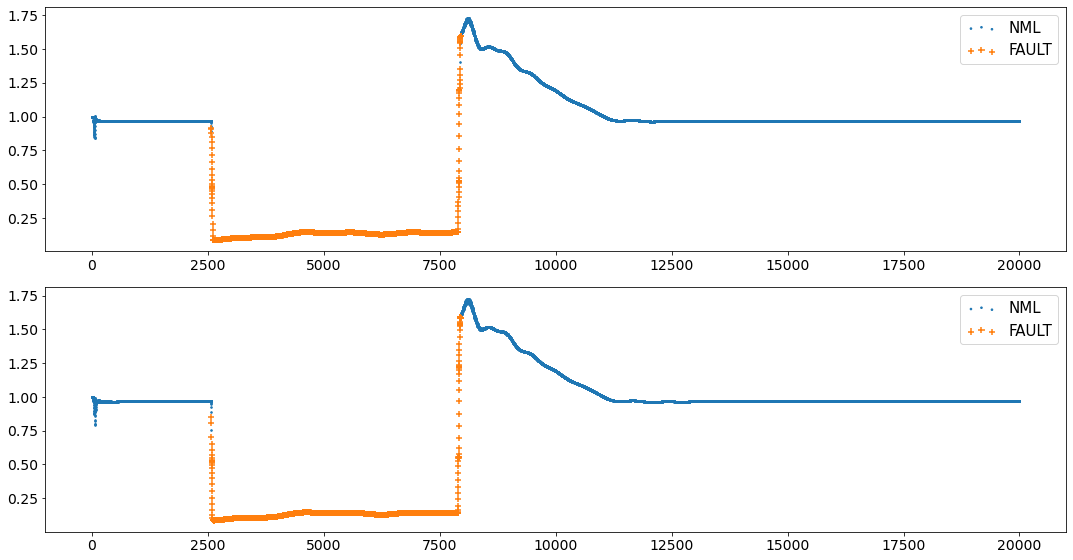

  Fault type Percentage
0        ABC     98.18%
1       ABCG      1.69%
2        ACG      0.07%
3        BCG      0.06%


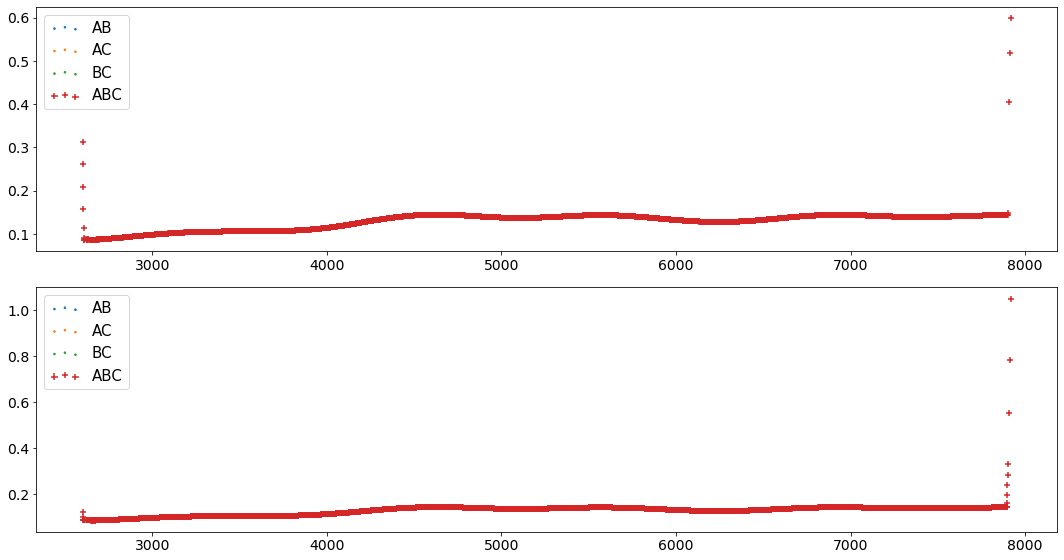


.
.
 10BG.csv
  Fault type Percentage
0        NML     97.64%
1      FAULT      2.36%


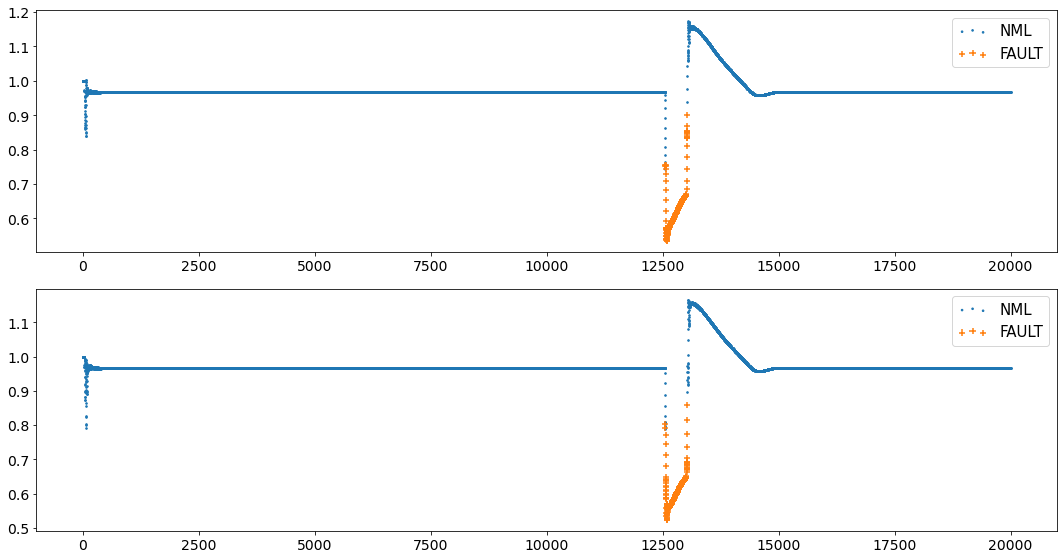

  Fault type Percentage
0         BG     100.0%


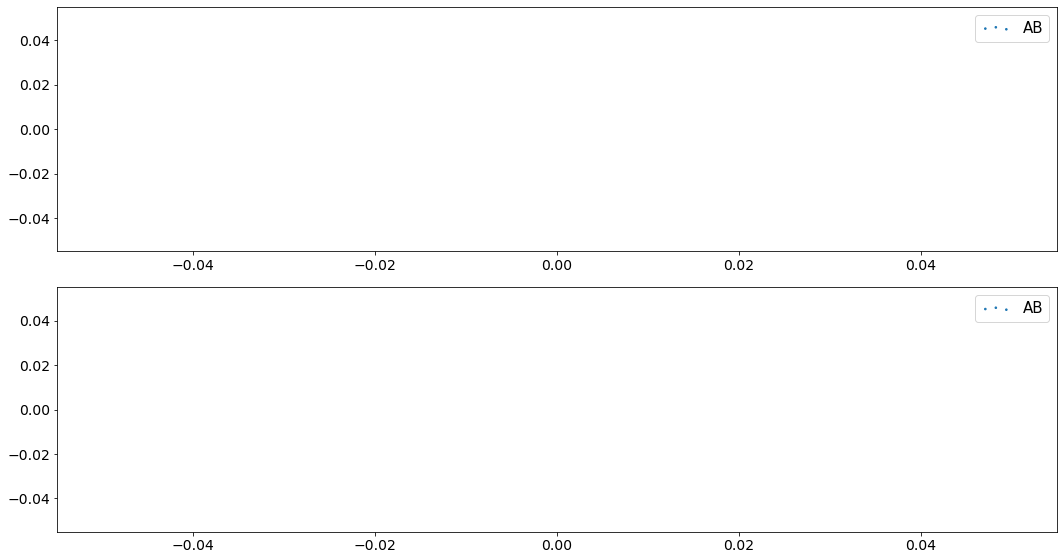


.
.
 2AB.csv
  Fault type Percentage
0        NML     86.15%
1      FAULT     13.85%


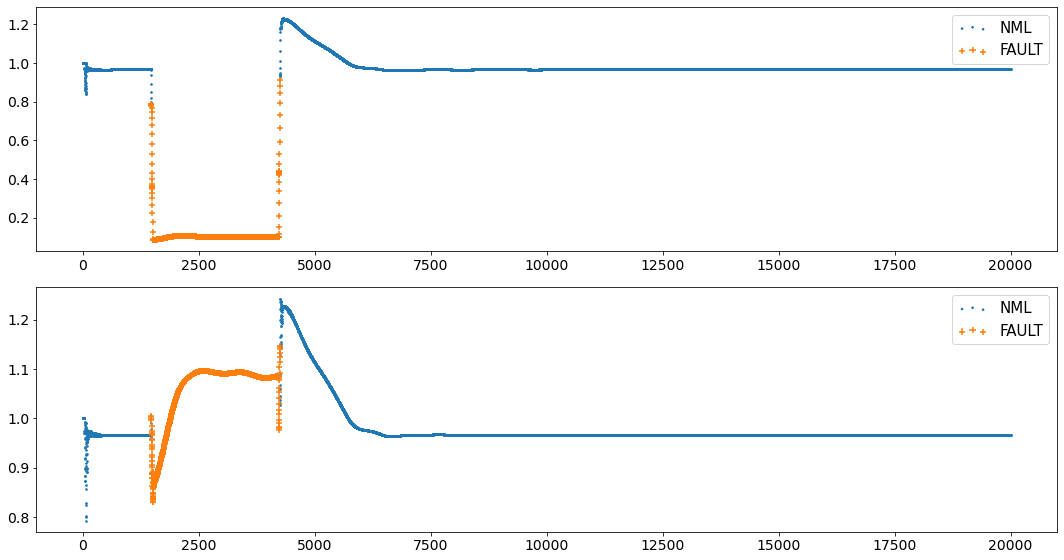

  Fault type Percentage
0         AB     99.78%
1        ABG      0.22%


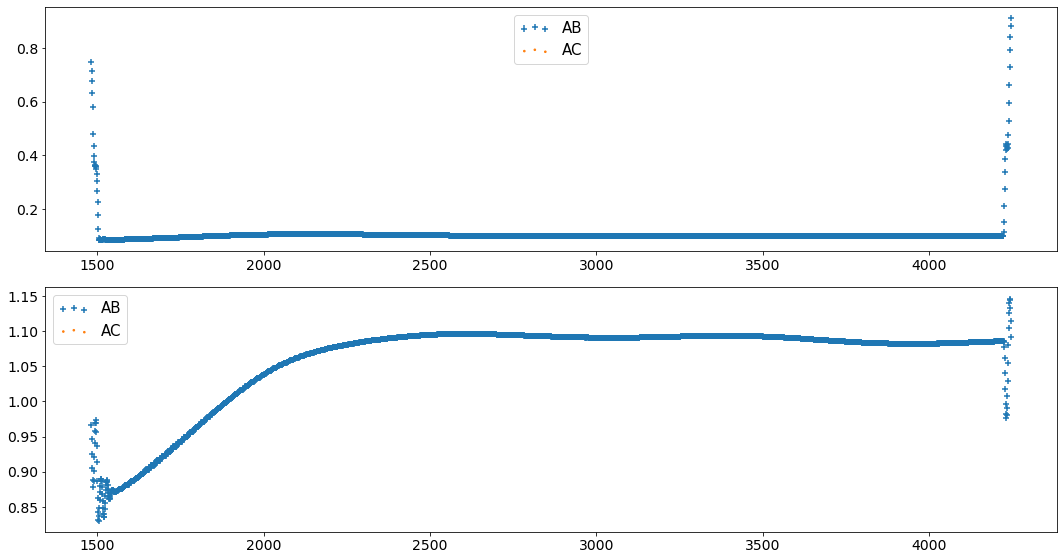


.
.
 2BCG.csv
  Fault type Percentage
0        NML     99.63%
1      FAULT      0.37%


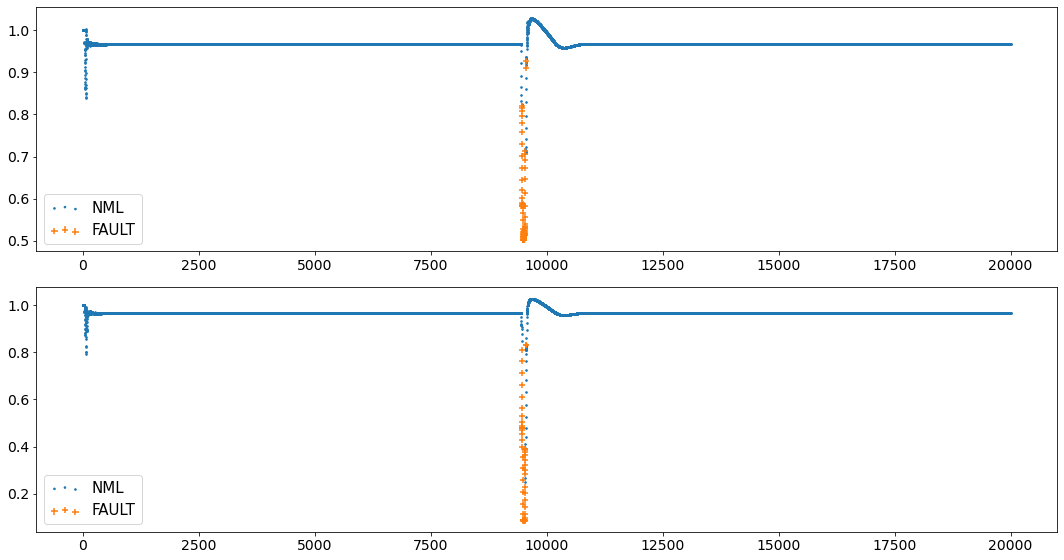

  Fault type Percentage
0        BCG     83.78%
1       ABCG     10.81%
2         BG      4.05%
3         AB      1.35%


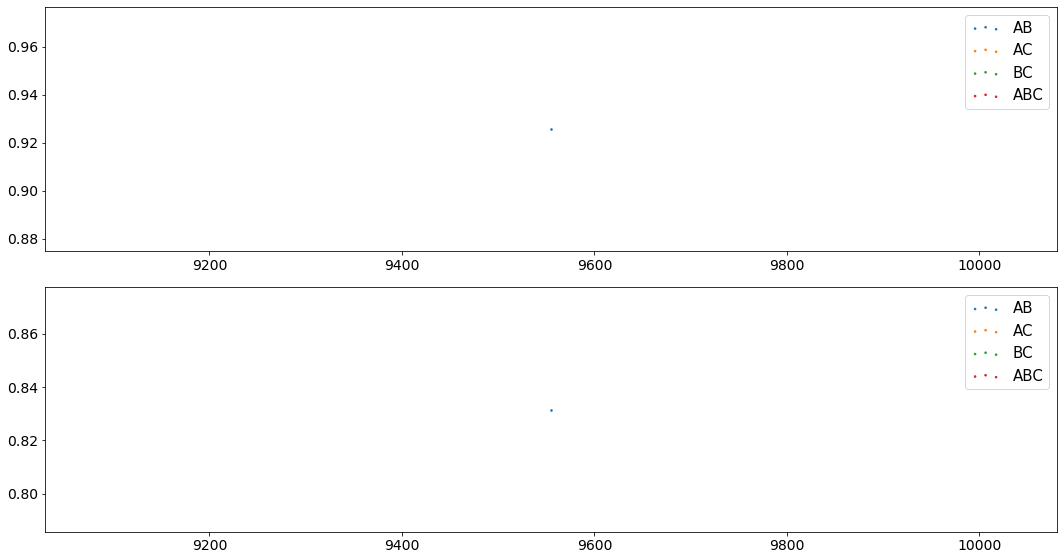


.
.
 10BC.csv
  Fault type Percentage
0        NML     89.89%
1      FAULT     10.12%


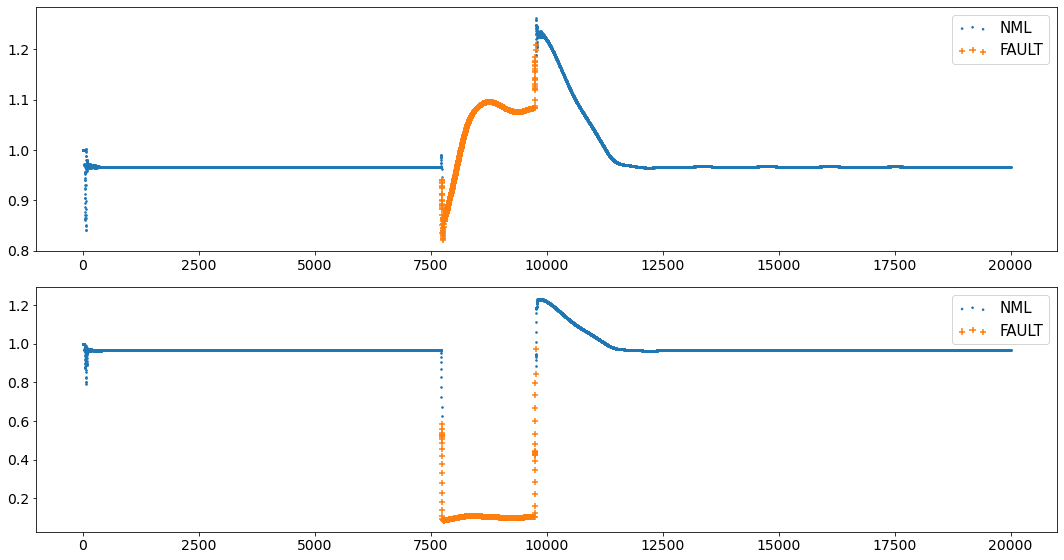

  Fault type Percentage
0         BC      99.8%
1        BCG      0.15%
2       ABCG      0.05%


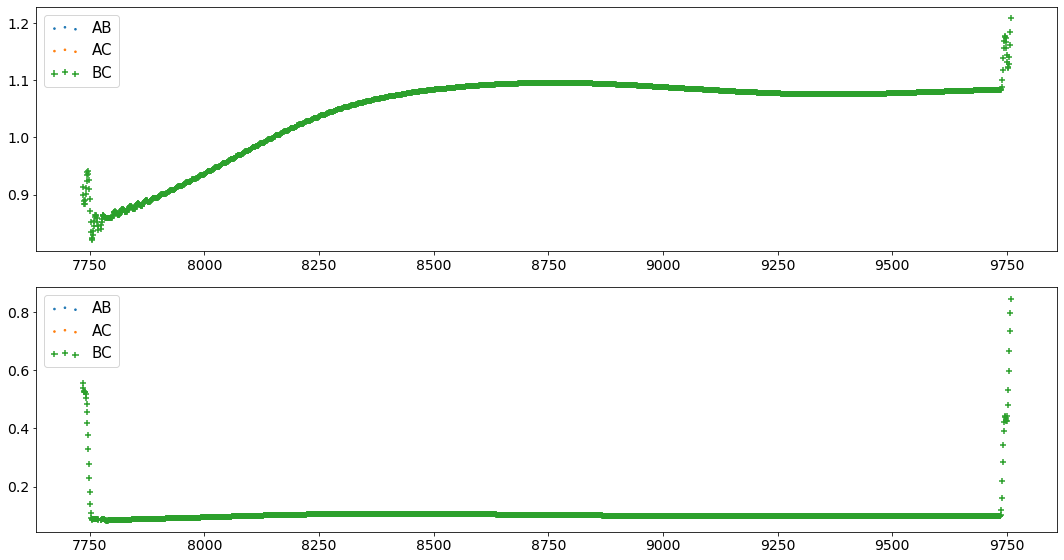


.
.
 10CG.csv
  Fault type Percentage
0        NML     94.29%
1      FAULT      5.71%


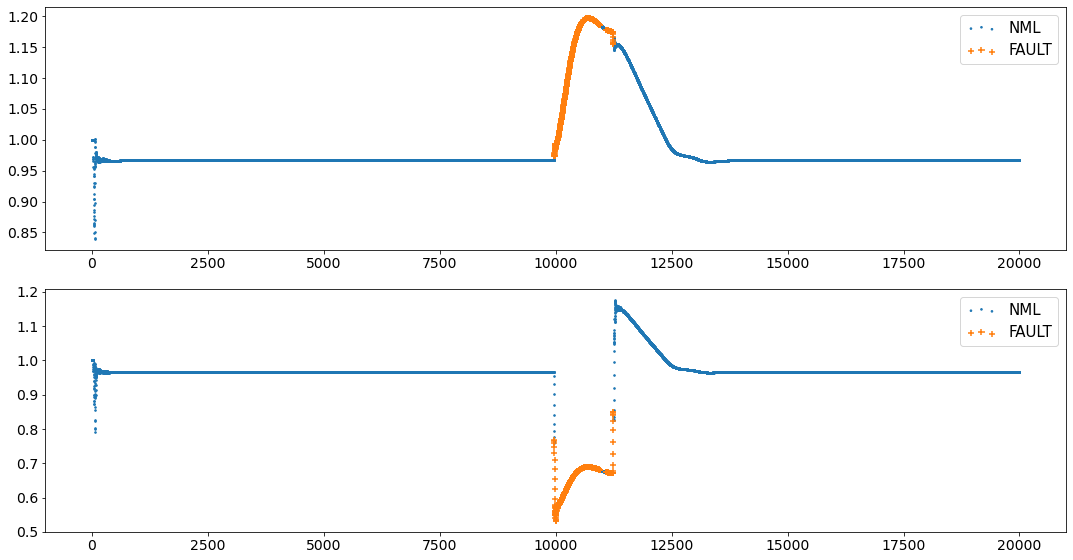

  Fault type Percentage
0         CG     100.0%


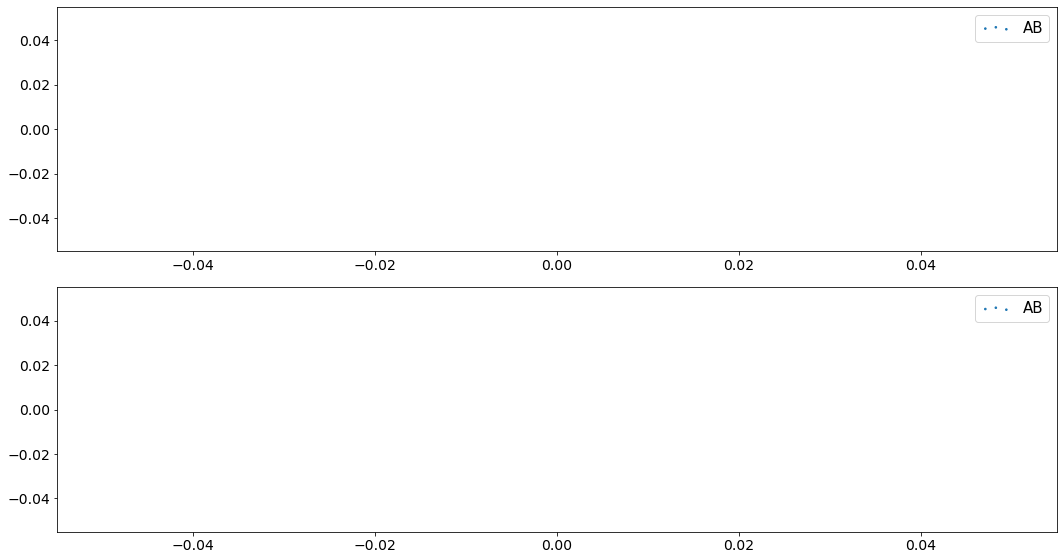


.
.
 10ABCG.csv
  Fault type Percentage
0        NML     88.02%
1      FAULT     11.98%


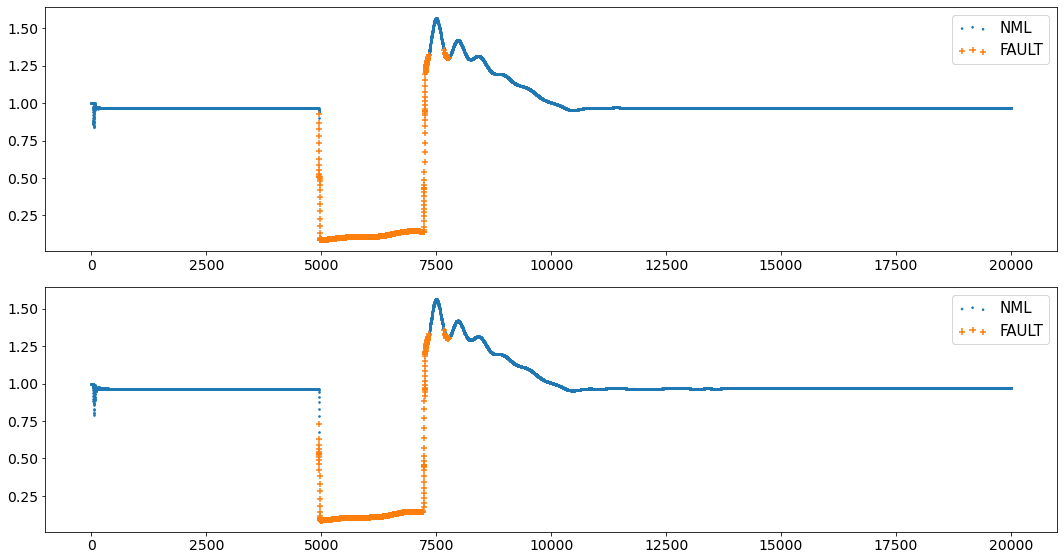

  Fault type Percentage
0        ABC     94.08%
1       ABCG      5.67%
2        BCG      0.25%


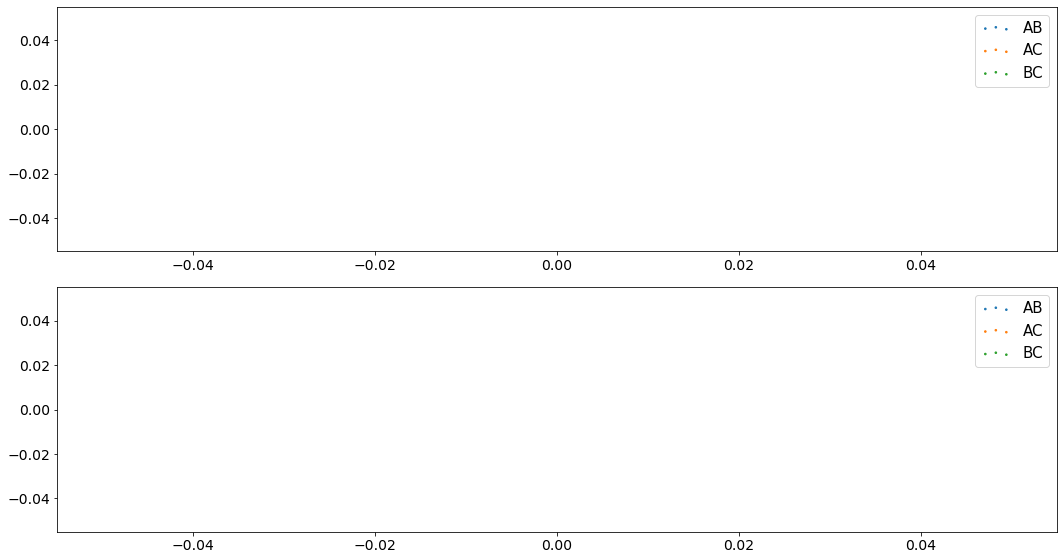


.
.
 6AG.csv
  Fault type Percentage
0        NML     77.26%
1      FAULT     22.74%


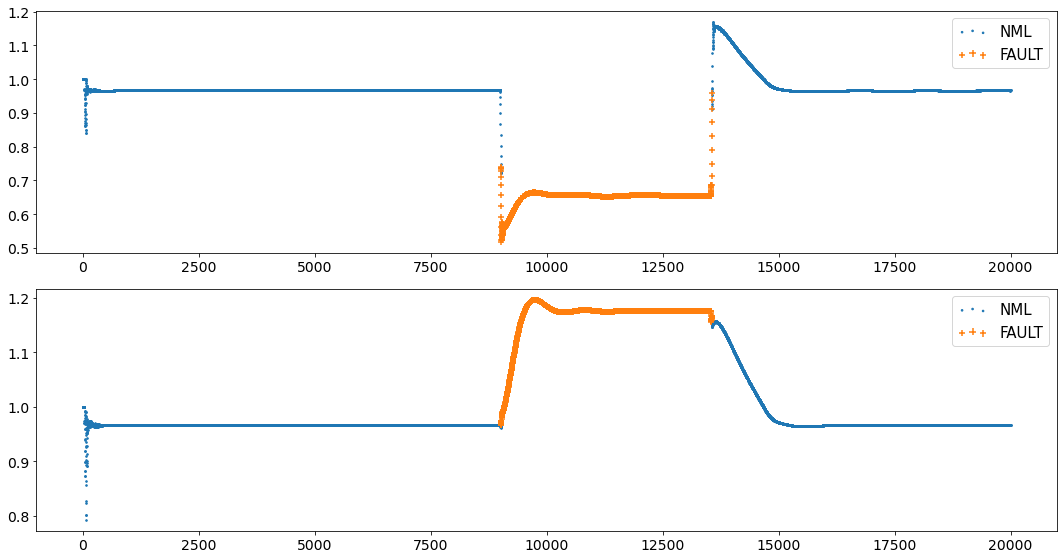

  Fault type Percentage
0         AG     100.0%


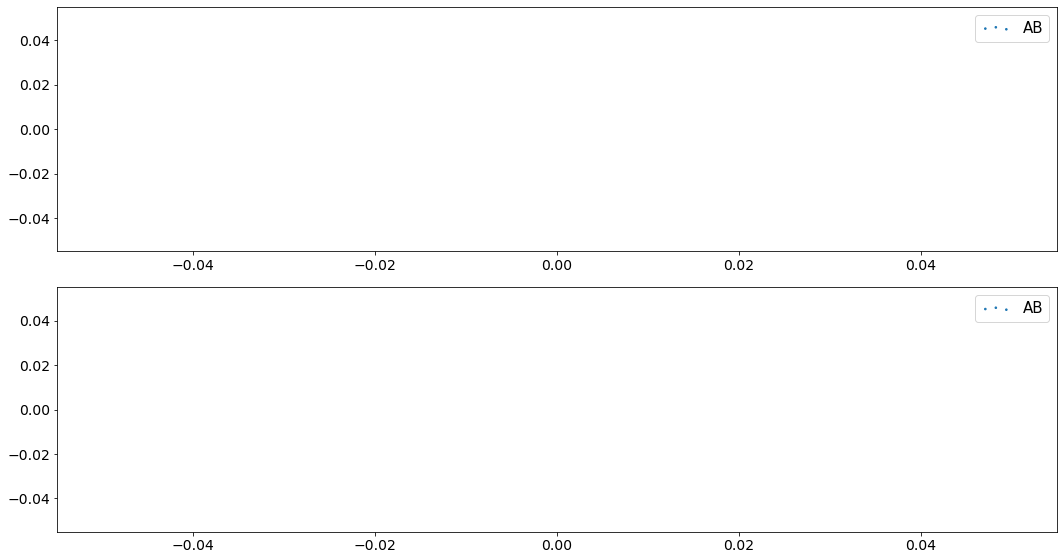


.
.
 3ABCG.csv
  Fault type Percentage
0        NML     99.08%
1      FAULT      0.92%


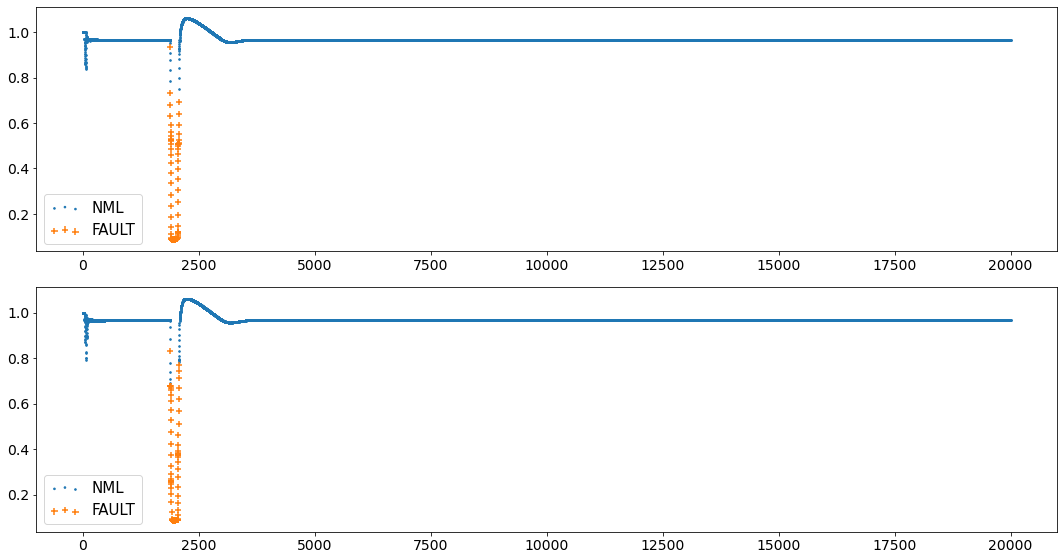

  Fault type Percentage
0        ABC     53.26%
1       ABCG     40.22%
2        ABG      3.26%
3        BCG      3.26%


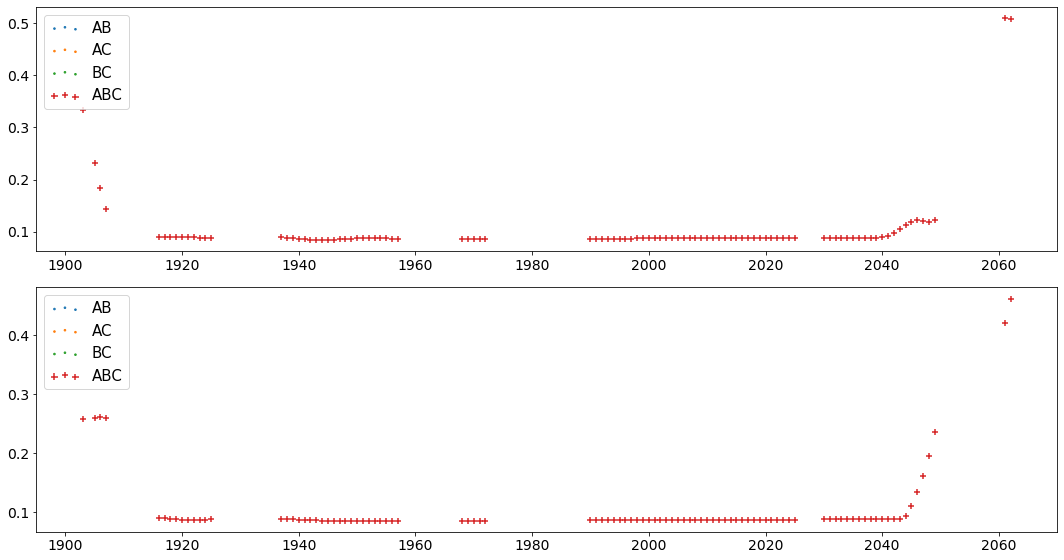


.
.
 2AC.csv
  Fault type Percentage
0        NML     99.83%
1      FAULT      0.17%


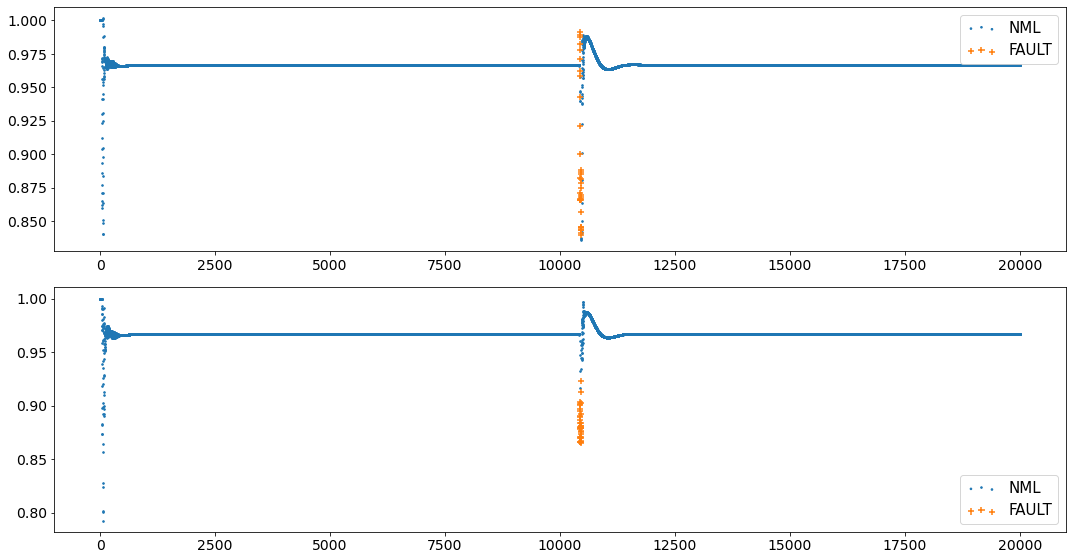

  Fault type Percentage
0         AC     88.24%
1        ACG     11.76%


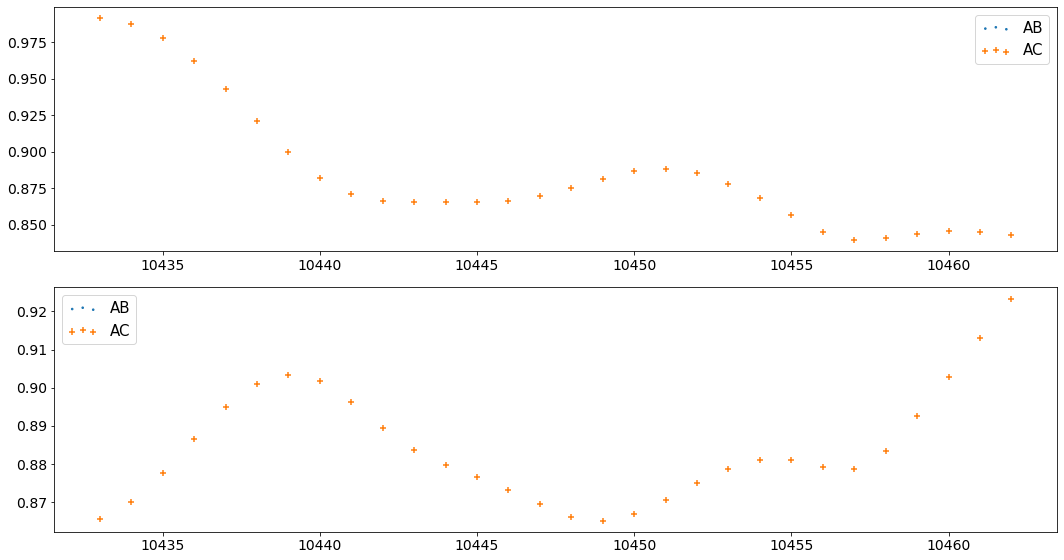


.
.
 4ACG.csv
  Fault type Percentage
0        NML     99.48%
1      FAULT      0.52%


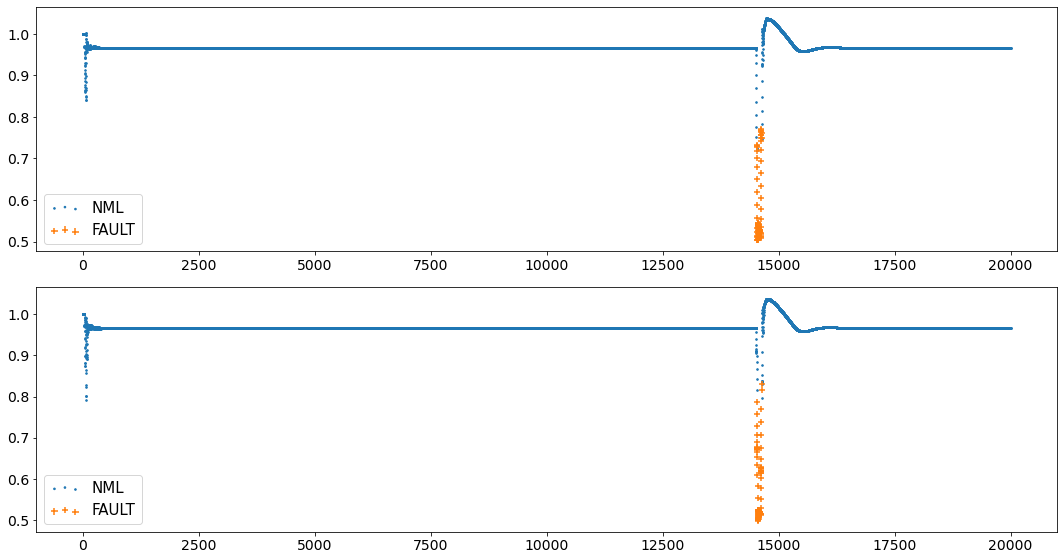

  Fault type Percentage
0        ACG     97.12%
1         CG      1.92%
2         AG      0.96%


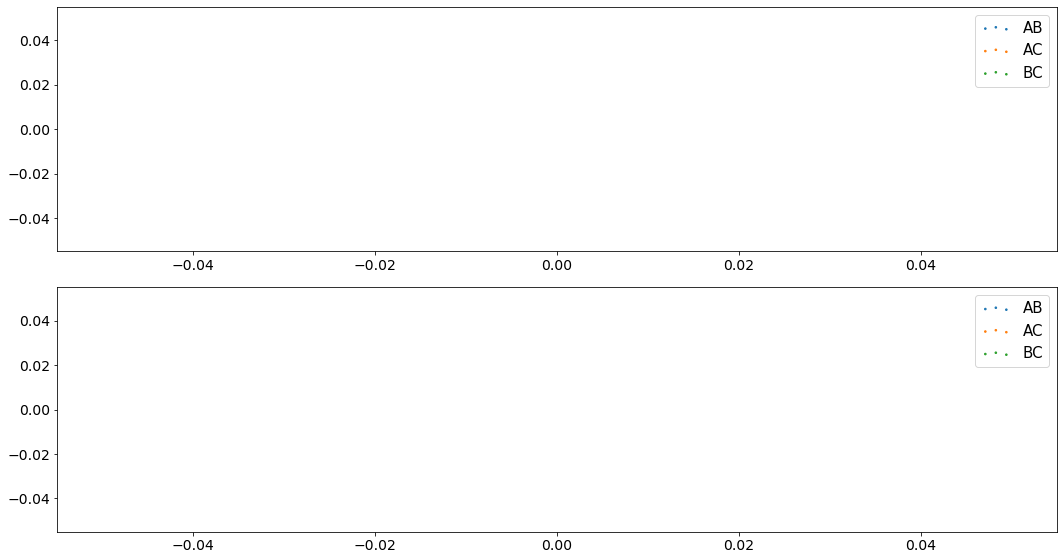


.
.
 4ABC.csv
  Fault type Percentage
0        NML     78.36%
1      FAULT     21.64%


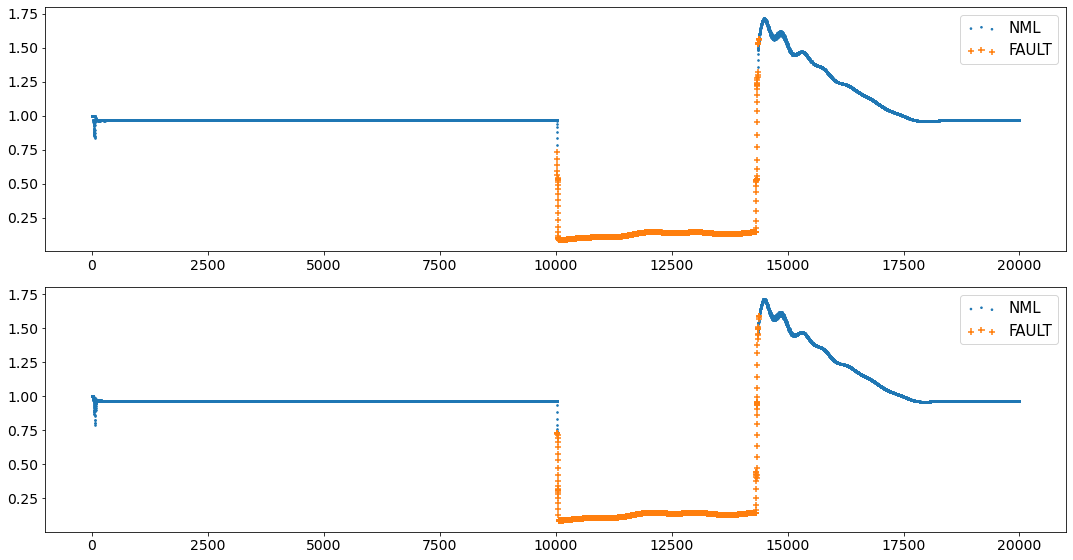

  Fault type Percentage
0        ABC     97.94%
1       ABCG       1.8%
2        ABG      0.14%
3        BCG      0.09%
4         CG      0.02%


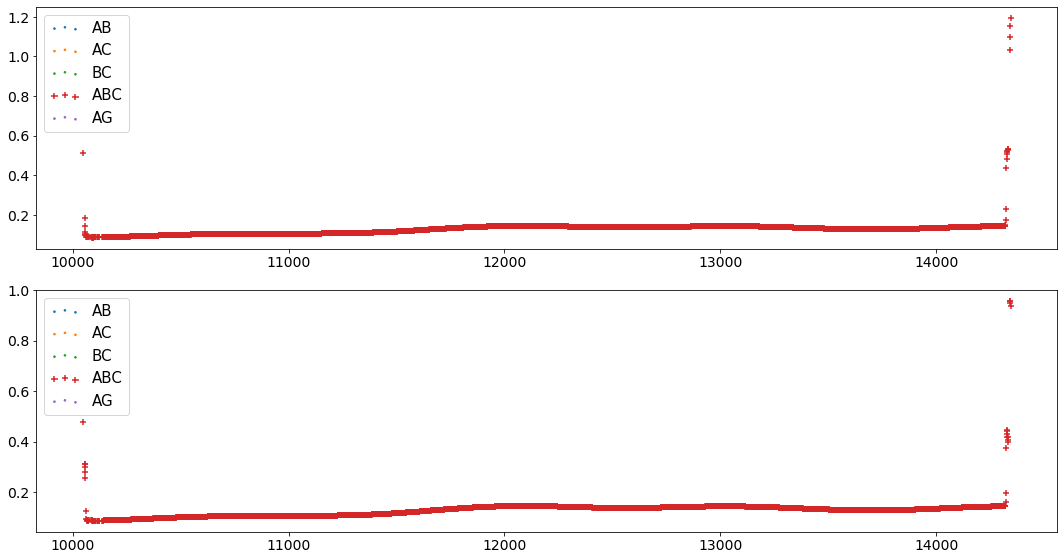


.
.
 8ABC.csv
  Fault type Percentage
0        NML     94.05%
1      FAULT      5.95%


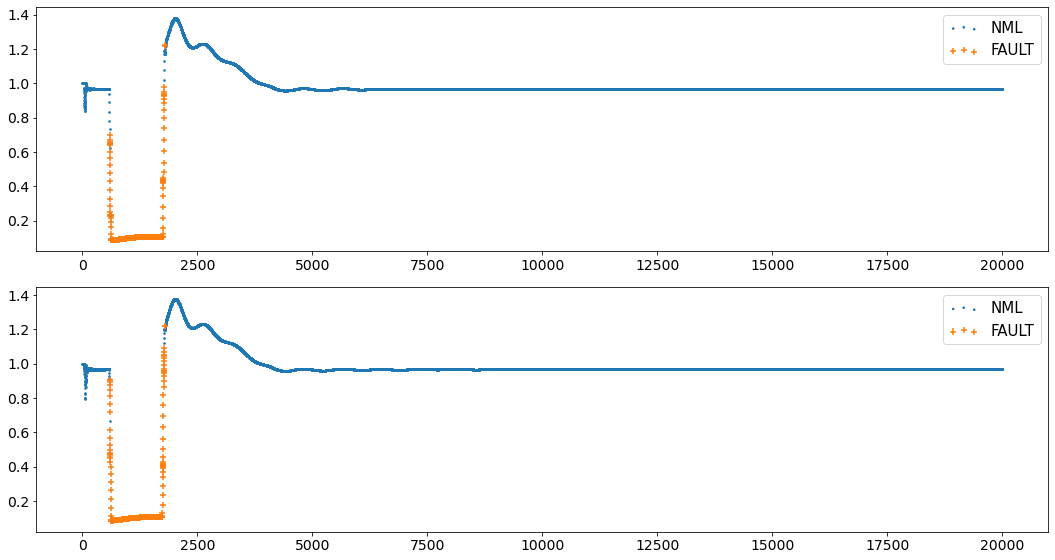

  Fault type Percentage
0        ABC     92.52%
1       ABCG      6.39%
2        ABG      0.76%
3        ACG      0.34%


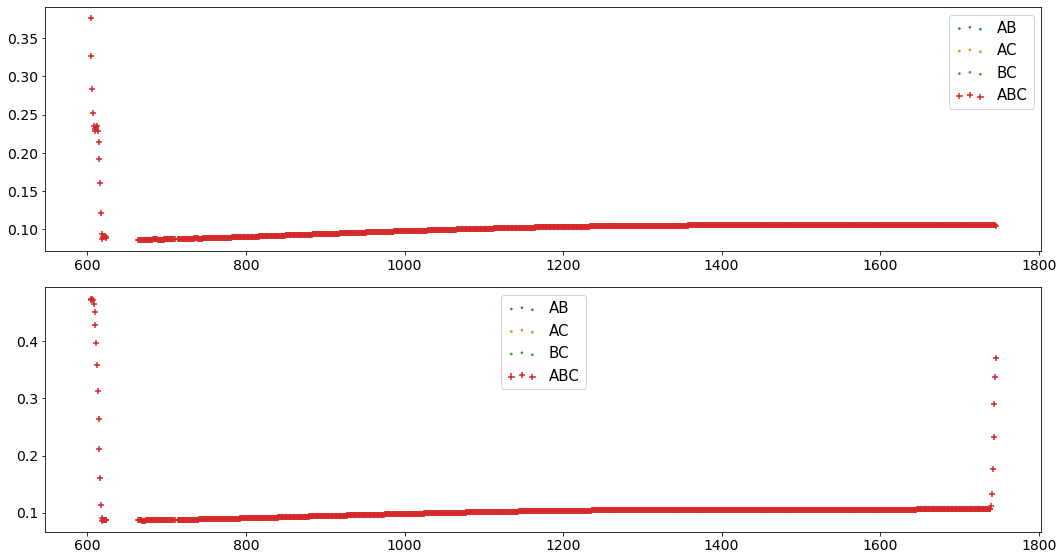


.
.
 8ACG.csv
  Fault type Percentage
0        NML      99.8%
1      FAULT       0.2%


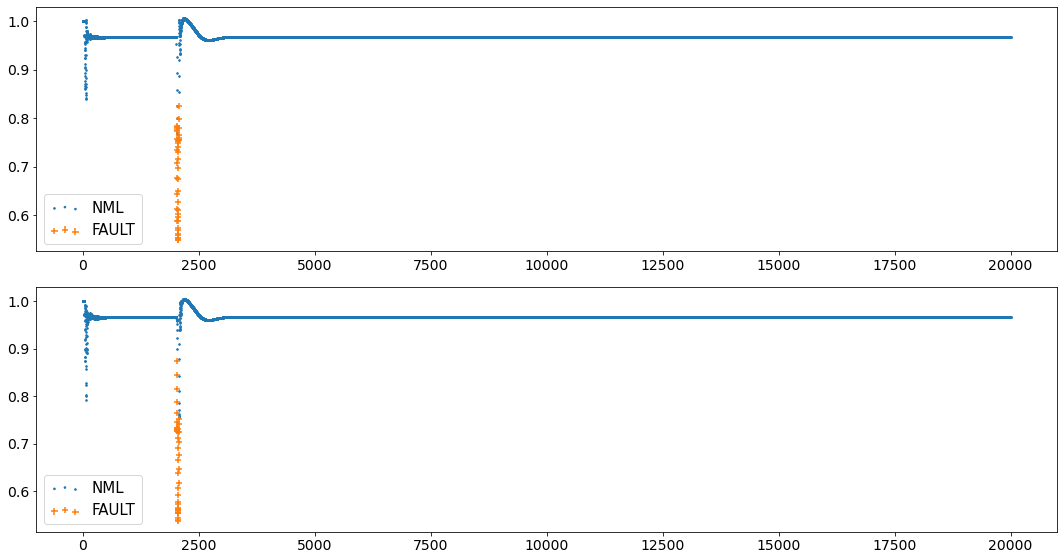

  Fault type Percentage
0        ACG     82.93%
1         CG     17.07%


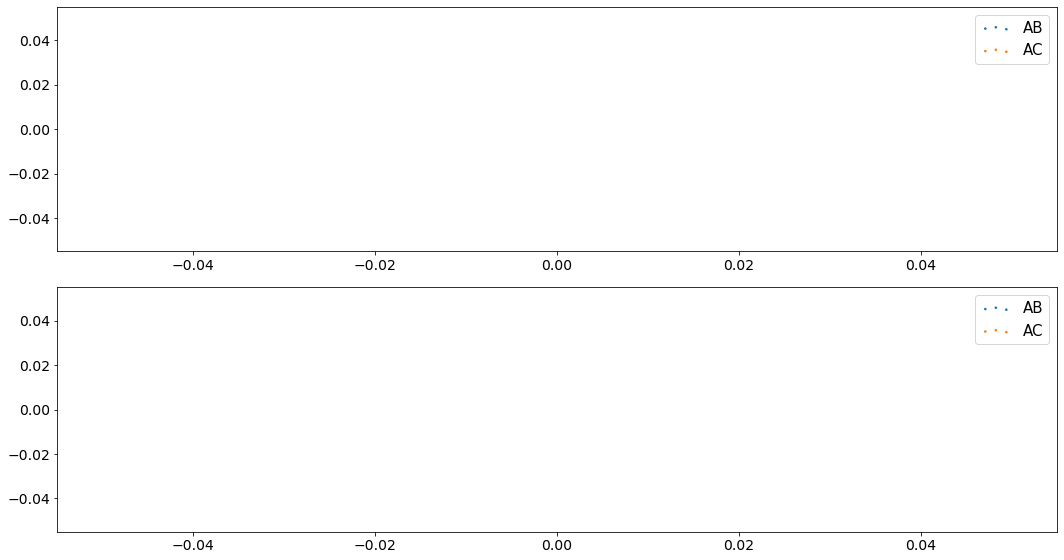


.
.
 4AG.csv
  Fault type Percentage
0        NML     74.25%
1      FAULT     25.75%


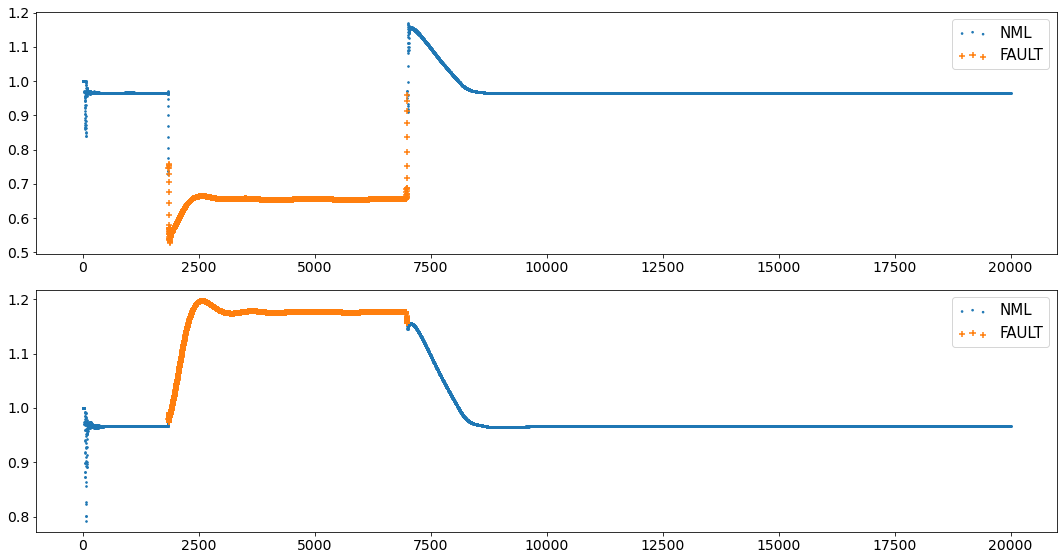

  Fault type Percentage
0         AG     100.0%


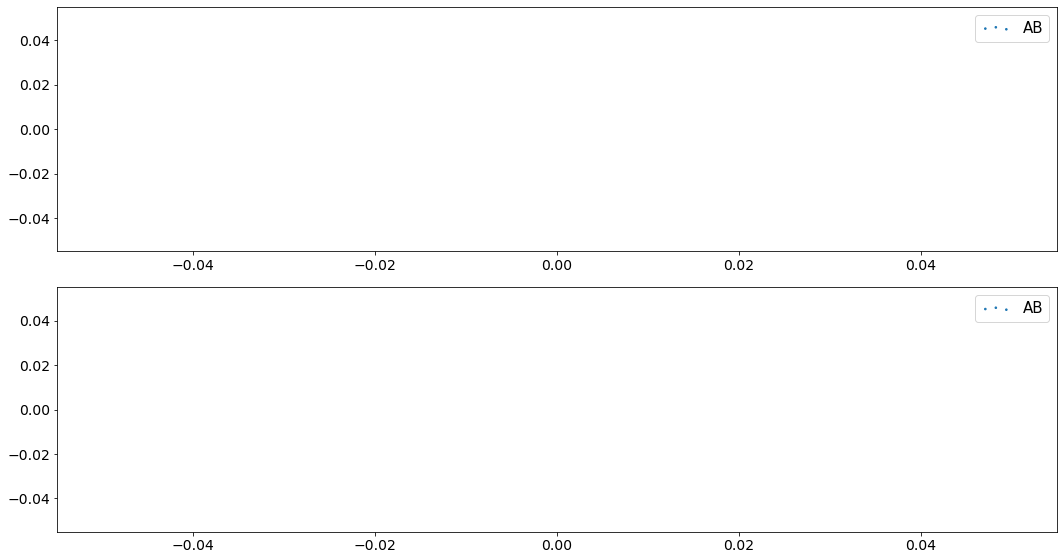


.
.
 6ABG.csv
  Fault type Percentage
0        NML     61.62%
1      FAULT     38.38%


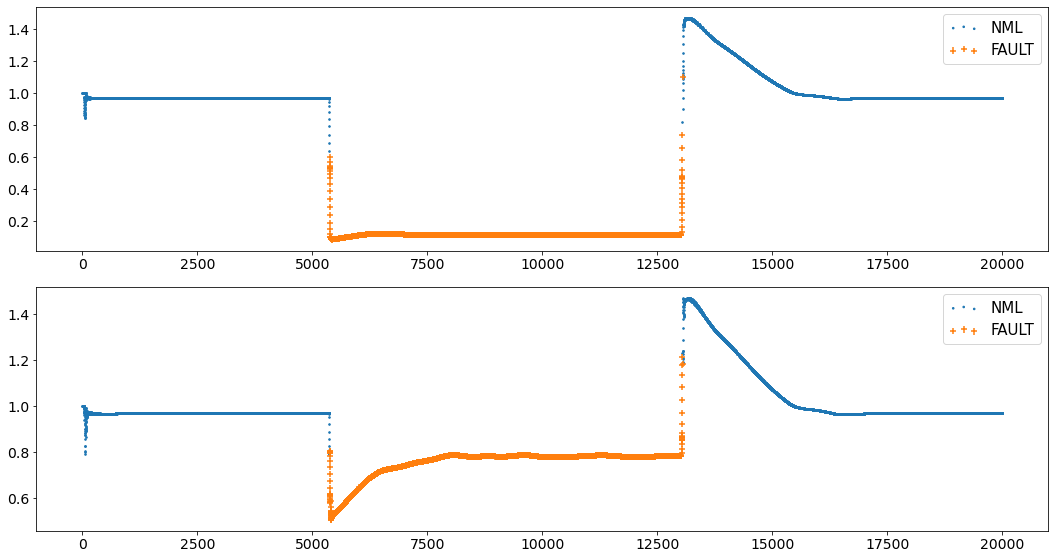

  Fault type Percentage
0        ABG     99.99%
1         AG      0.01%


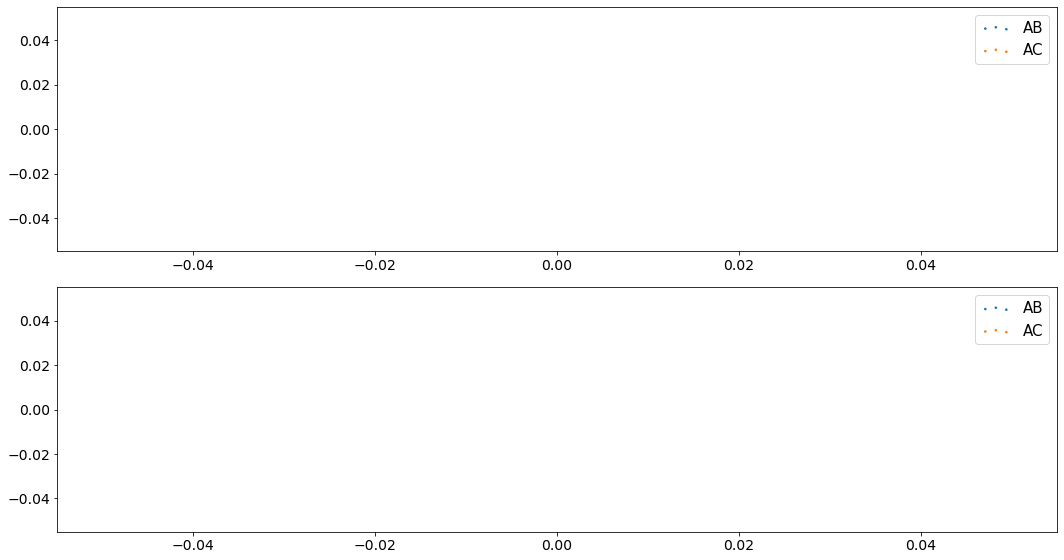


.
.
 8BG.csv
  Fault type Percentage
0        NML     95.35%
1      FAULT      4.65%


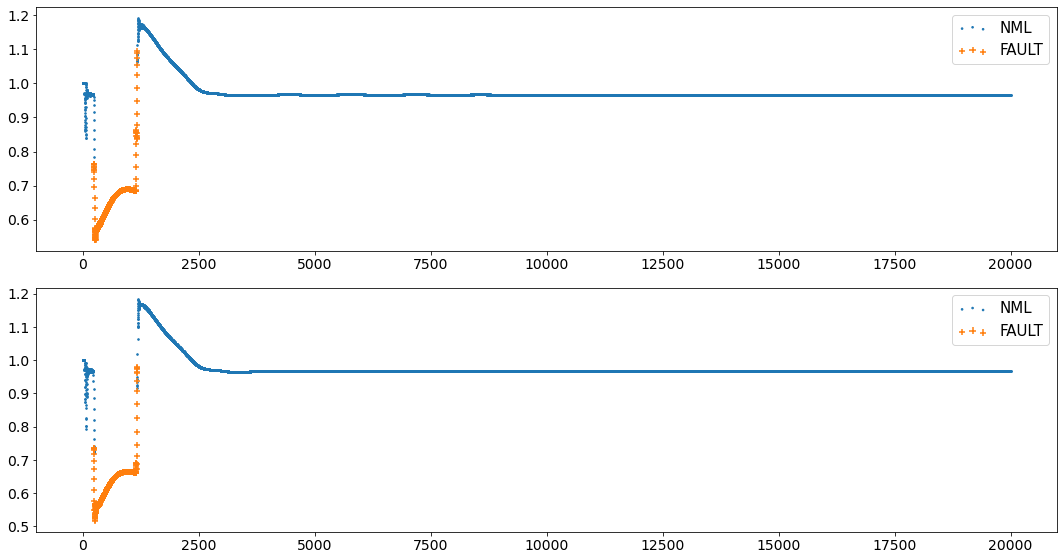

  Fault type Percentage
0         BG     100.0%


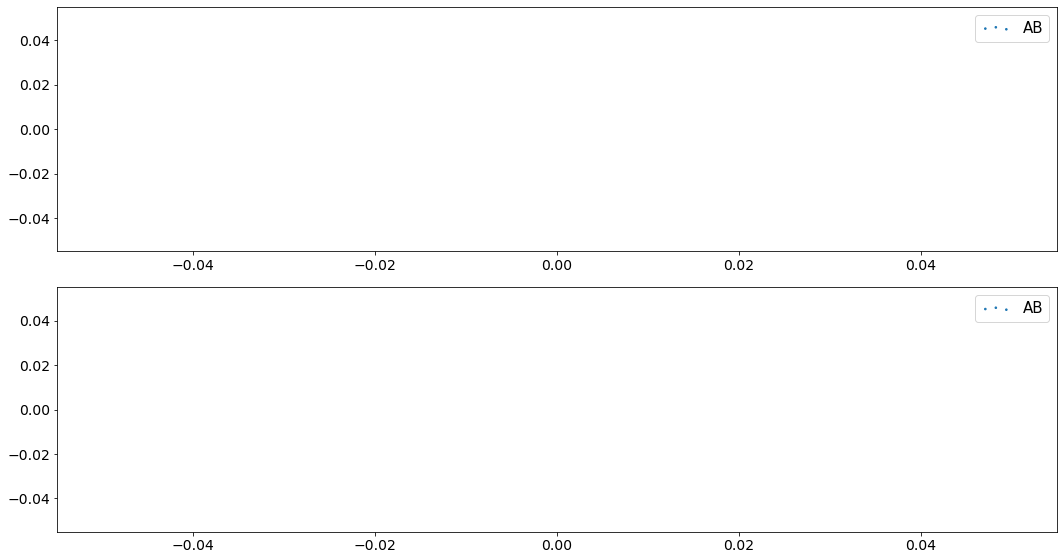


.
.
 7AC.csv
  Fault type Percentage
0        NML     91.55%
1      FAULT      8.45%


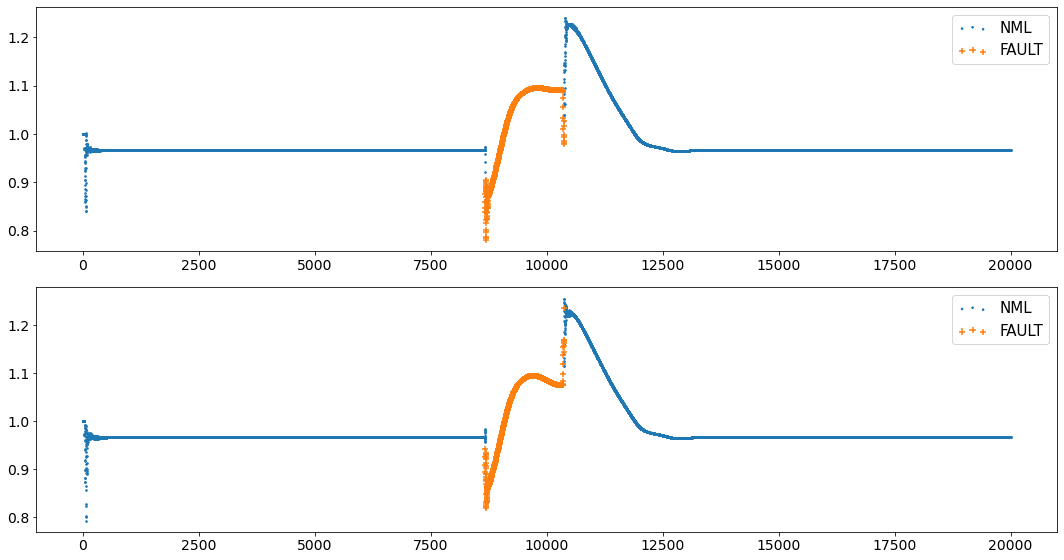

  Fault type Percentage
0         AC     99.64%
1        ACG       0.3%
2         BC      0.06%


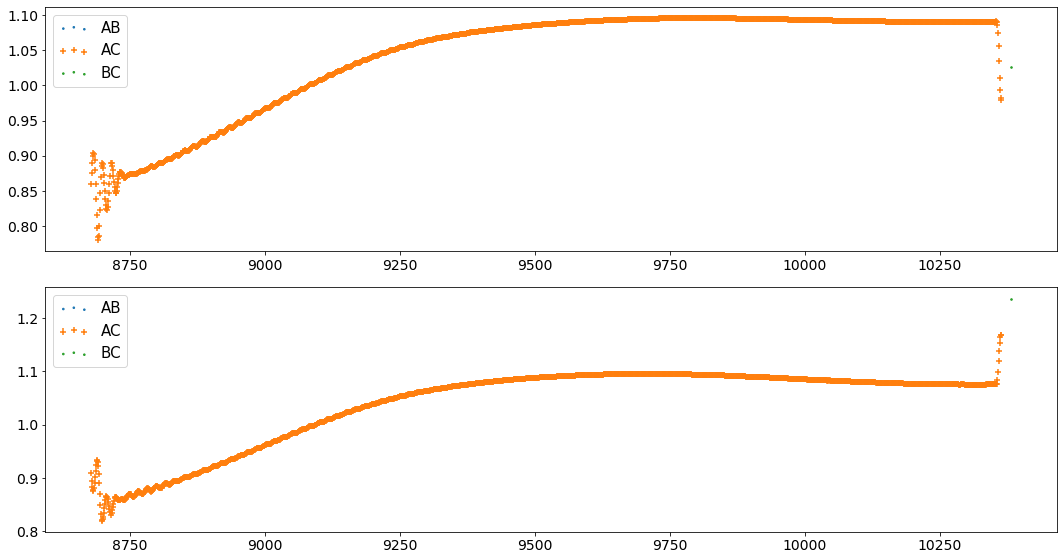


.
.
 3AG.csv
  Fault type Percentage
0        NML     90.16%
1      FAULT      9.84%


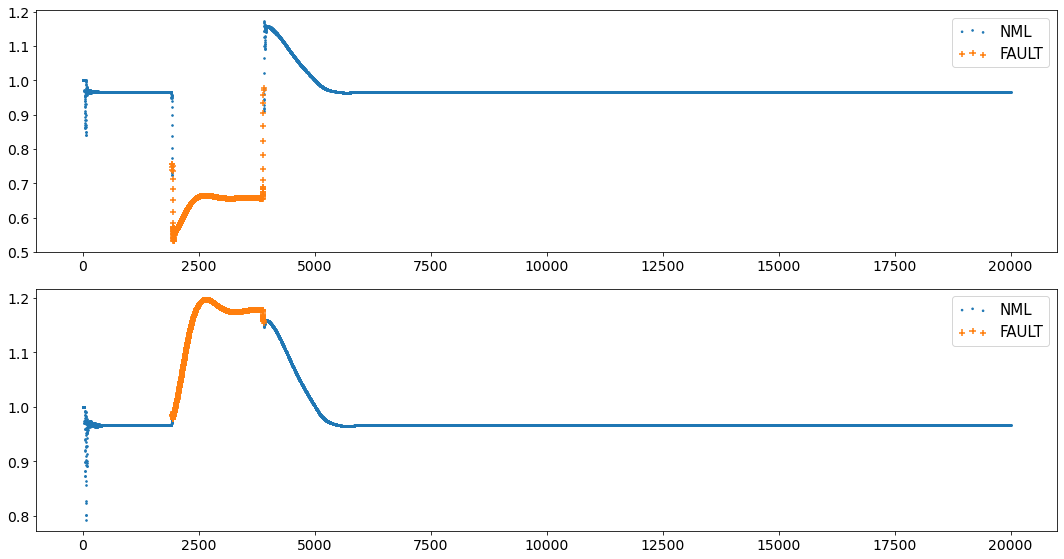

  Fault type Percentage
0         AG     100.0%


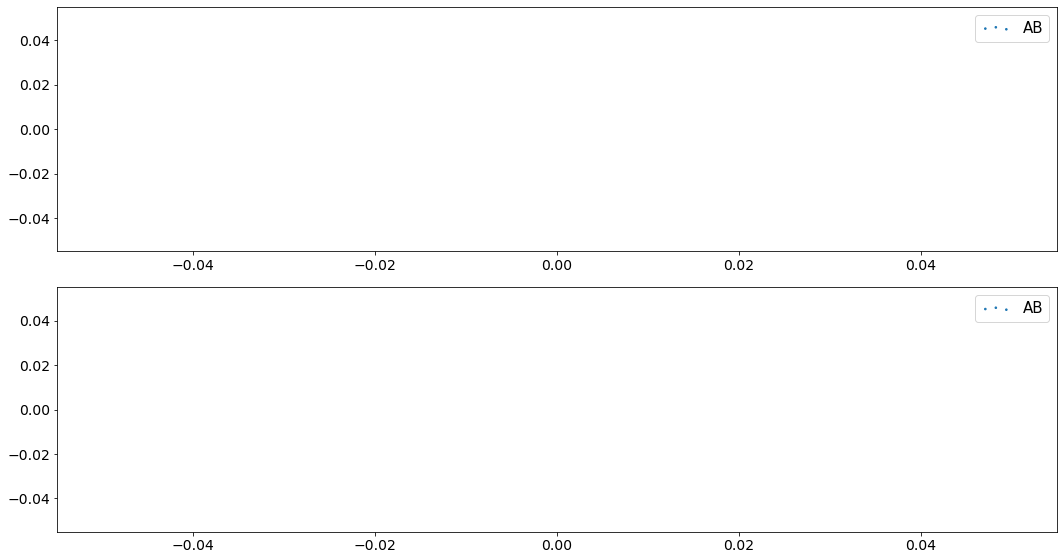


.
.
 1ABCG.csv
  Fault type Percentage
0        NML      99.4%
1      FAULT       0.6%


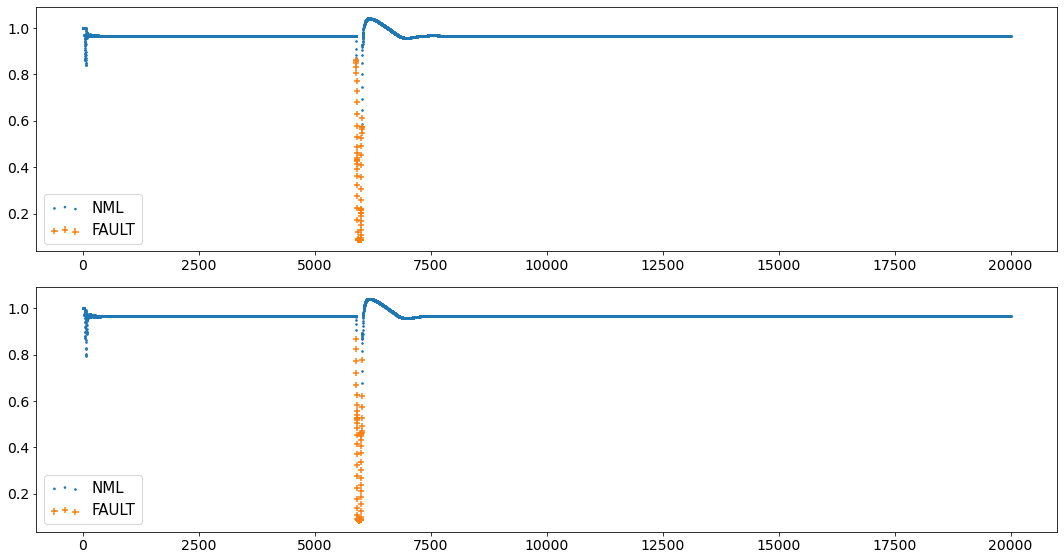

  Fault type Percentage
0       ABCG      47.5%
1        ABC      42.5%
2        ACG      5.83%
3        ABG      3.33%
4        BCG      0.83%


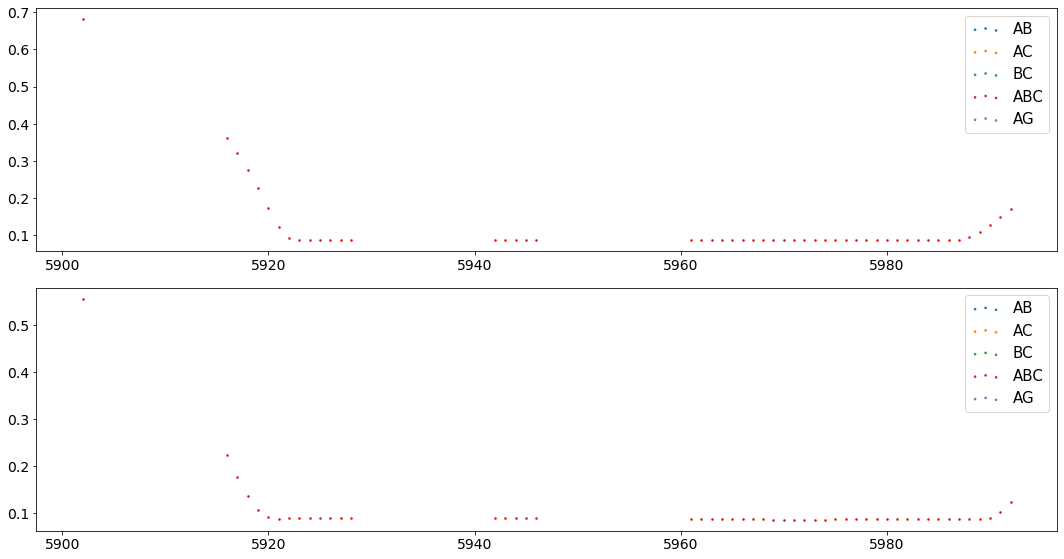


.
.
 7AB.csv
  Fault type Percentage
0        NML     69.58%
1      FAULT     30.43%


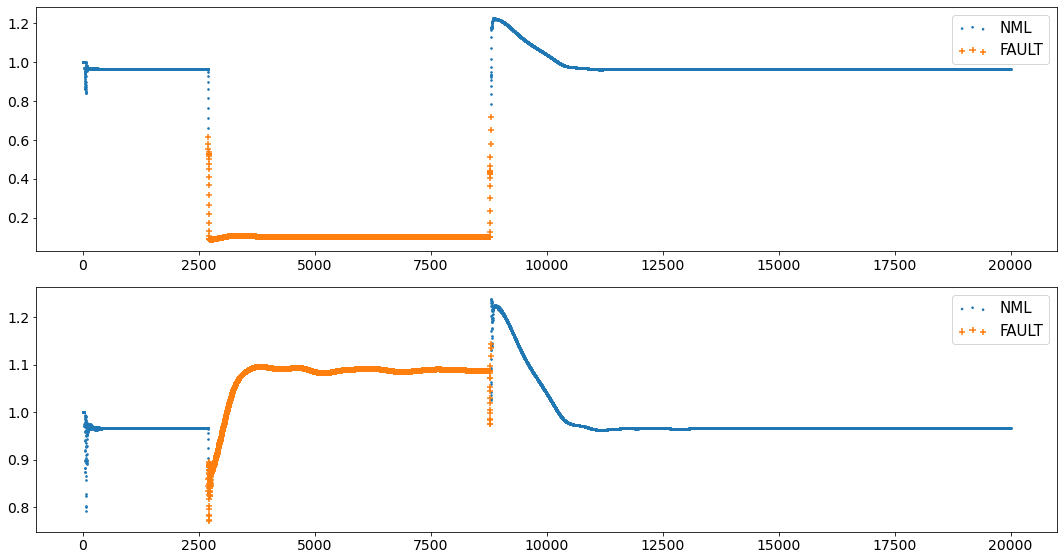

  Fault type Percentage
0         AB     99.95%
1        ABG      0.03%
2         AG      0.02%


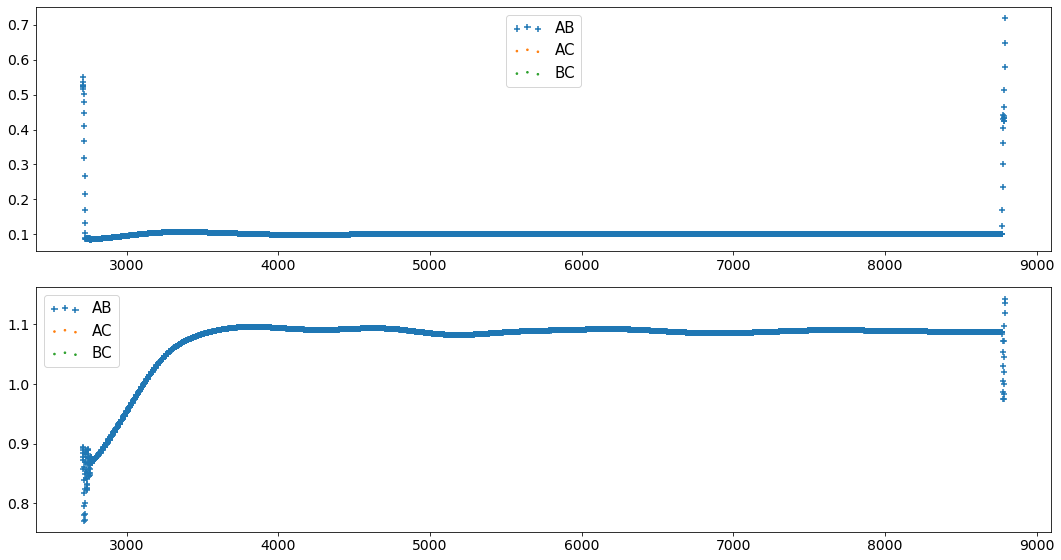


.
.
 6BCG.csv
  Fault type Percentage
0        NML     87.39%
1      FAULT     12.61%


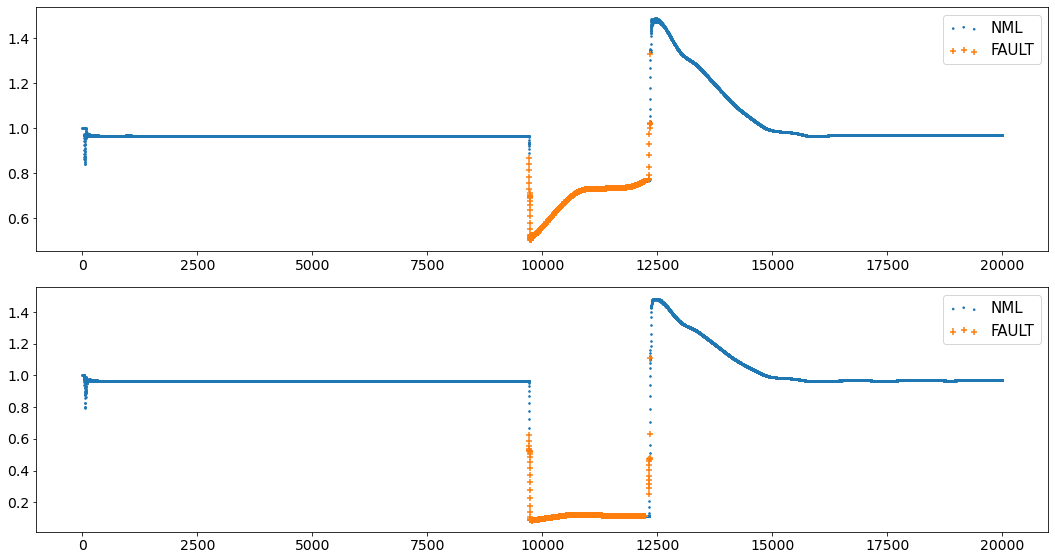

  Fault type Percentage
0        BCG      99.8%
1         BC      0.08%
2         CG      0.08%
3         BG      0.04%


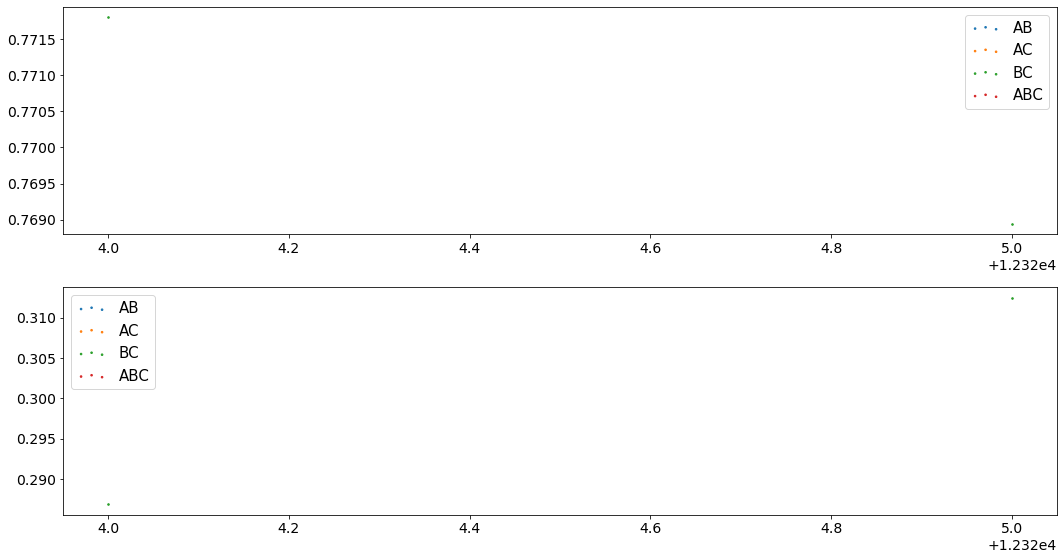


.
.
 5AB.csv
  Fault type Percentage
0        NML      92.0%
1      FAULT       8.0%


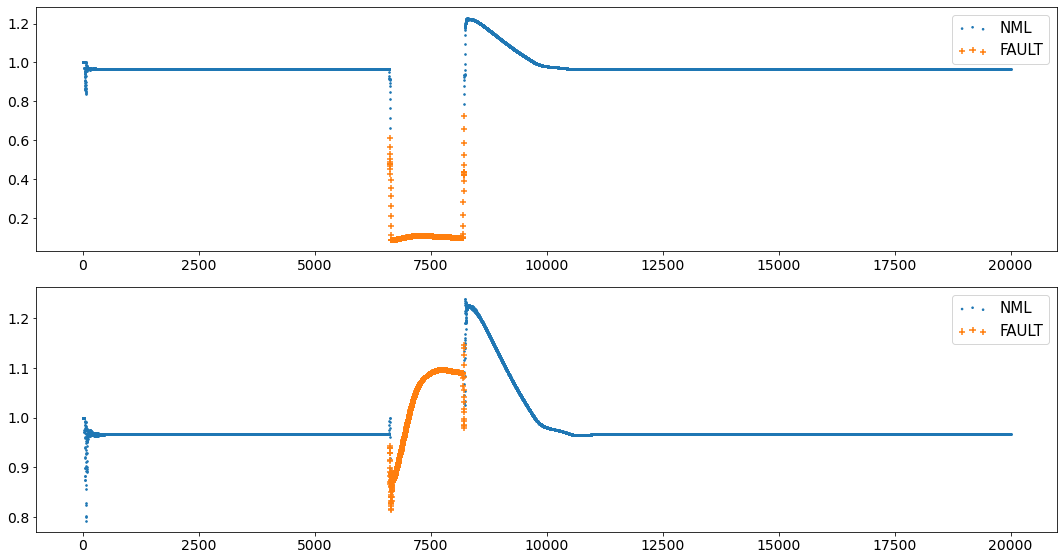

  Fault type Percentage
0         AB     99.19%
1        ABG      0.81%


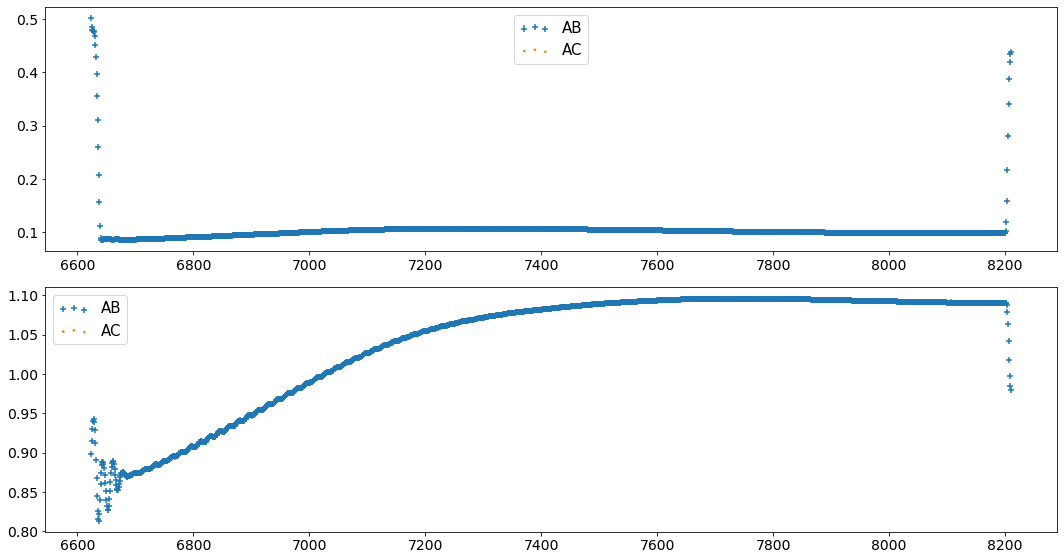


.
.
 9CG.csv
  Fault type Percentage
0        NML     84.28%
1      FAULT     15.71%


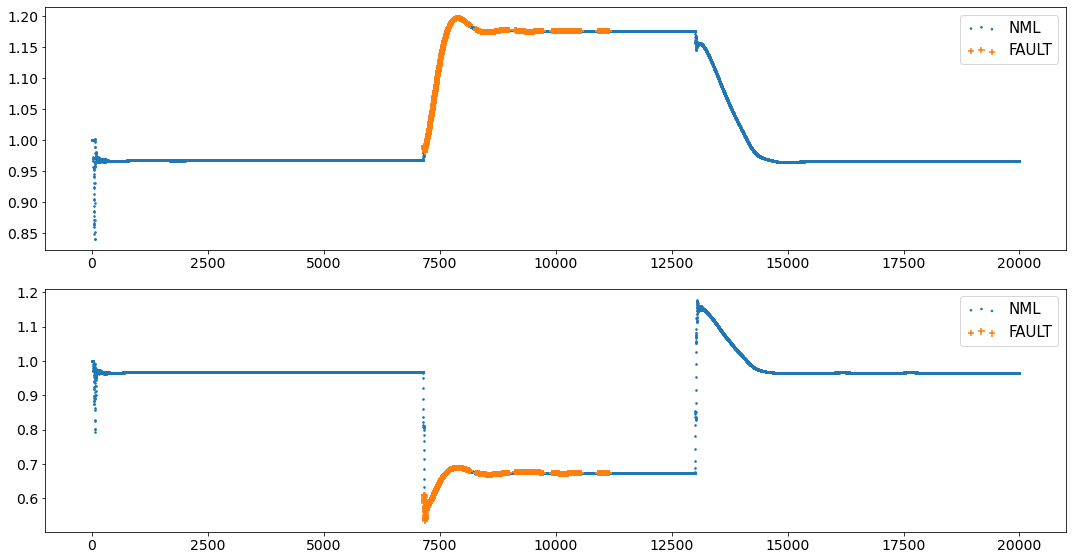

  Fault type Percentage
0         CG     100.0%


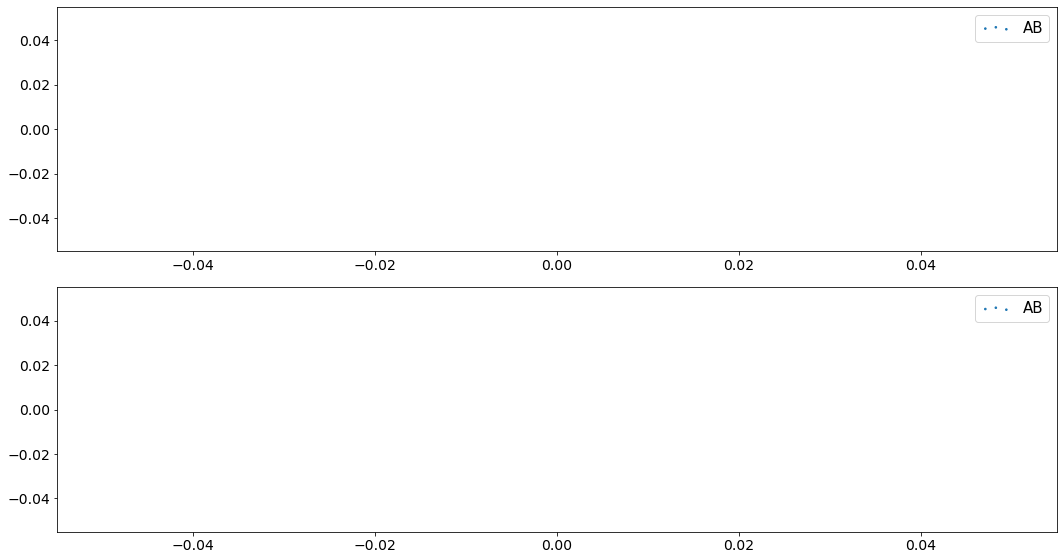


.
.
 9BC.csv
  Fault type Percentage
0        NML     83.45%
1      FAULT     16.55%


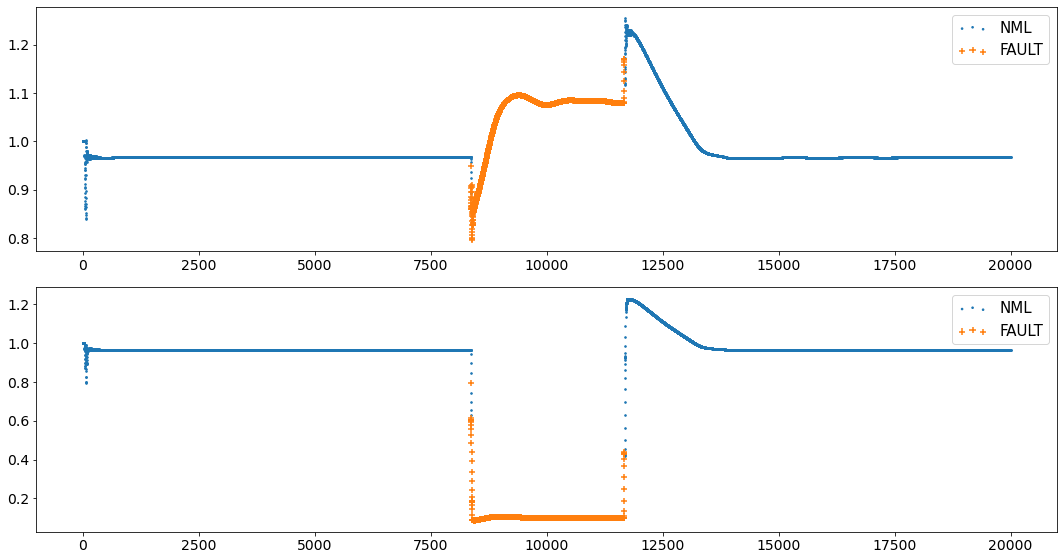

  Fault type Percentage
0         BC     99.94%
1        BCG      0.03%
2       ABCG      0.03%


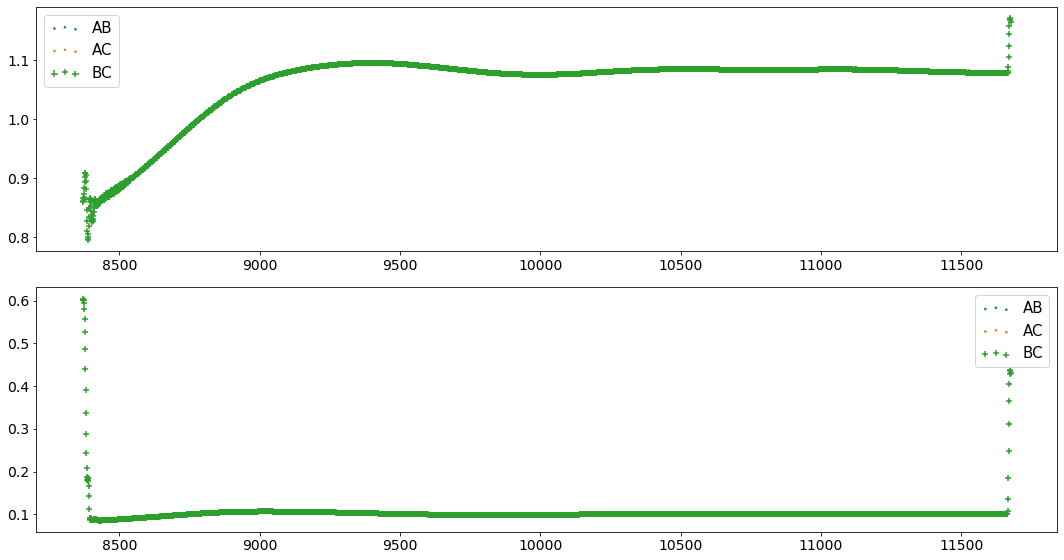


.
.
 2ABG.csv
  Fault type Percentage
0        NML     89.38%
1      FAULT     10.62%


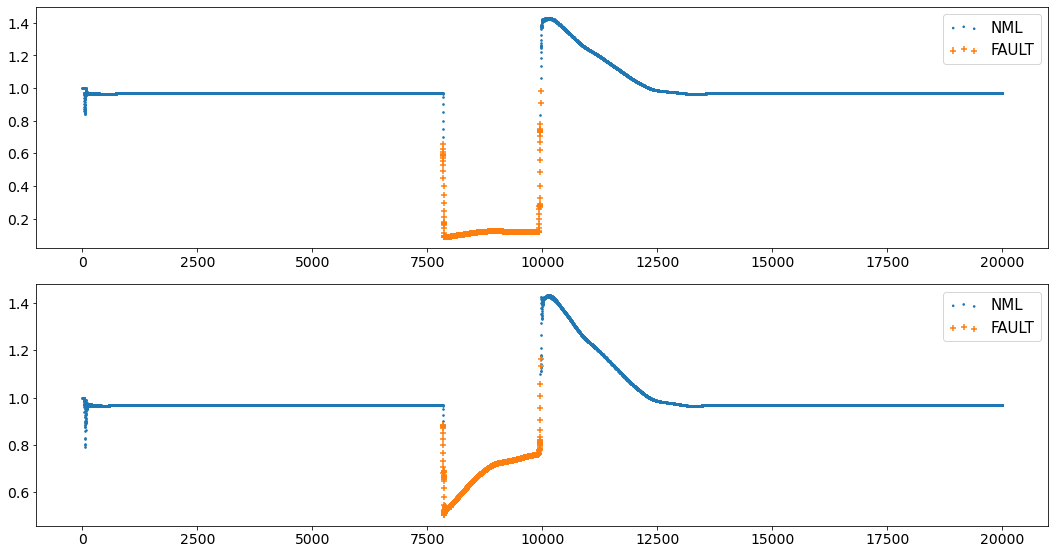

  Fault type Percentage
0        ABG     99.67%
1         BG      0.28%
2         AB      0.05%


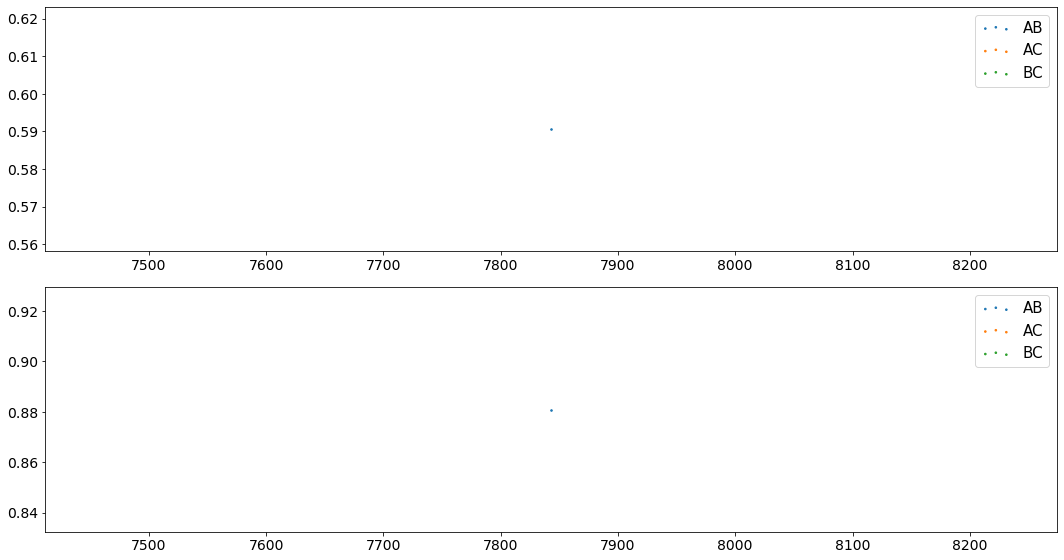


.
.
 1AG.csv
  Fault type Percentage
0        NML     51.97%
1      FAULT     48.03%


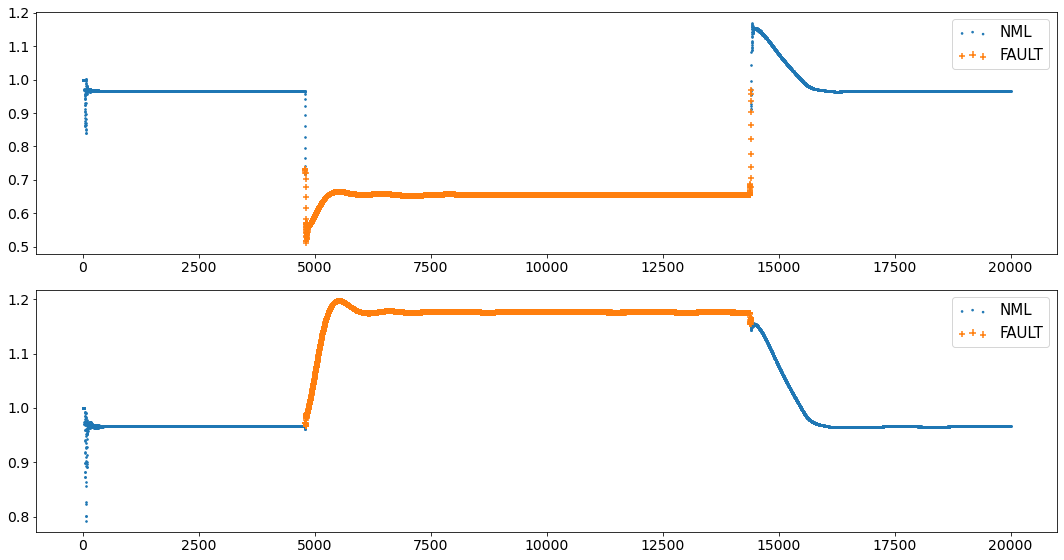

  Fault type Percentage
0         AG     100.0%


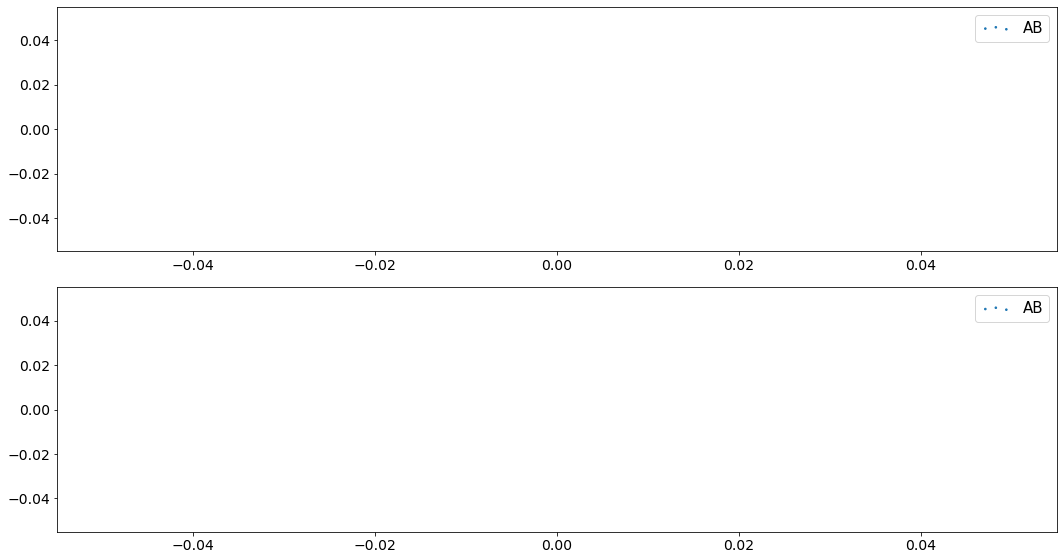


.
.
 8ABCG.csv
  Fault type Percentage
0        NML     97.47%
1      FAULT      2.53%


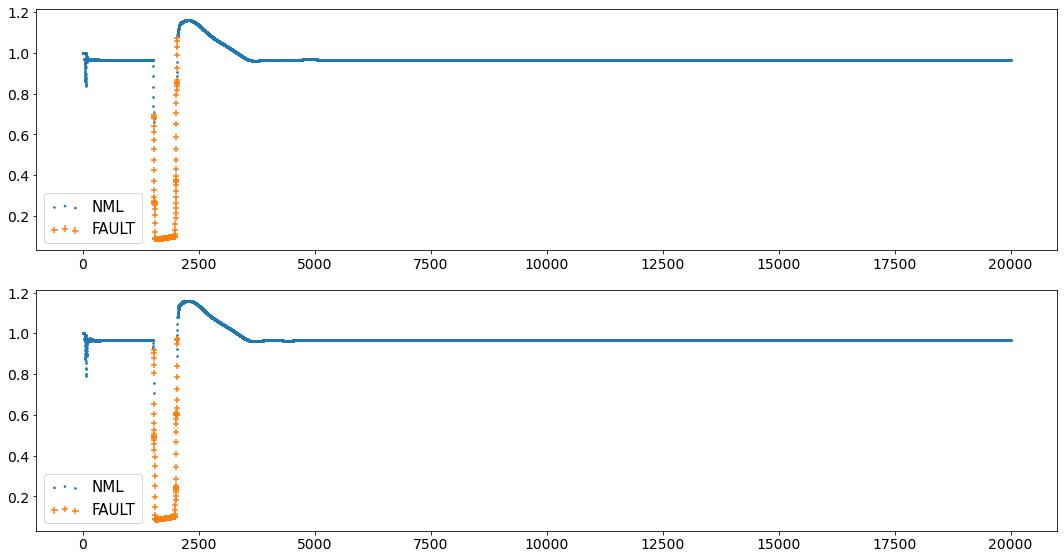

  Fault type Percentage
0        ABC     85.57%
1       ABCG     11.07%
2        ACG      2.37%
3        ABG      0.59%
4        BCG       0.2%
5         CG       0.2%


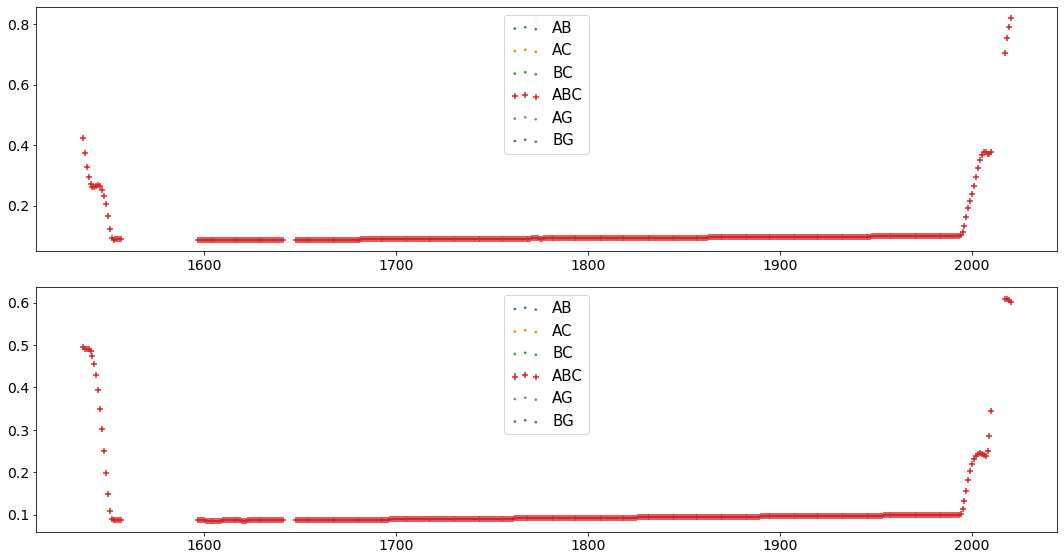


.
.
 5AC.csv
  Fault type Percentage
0        NML     72.94%
1      FAULT     27.06%


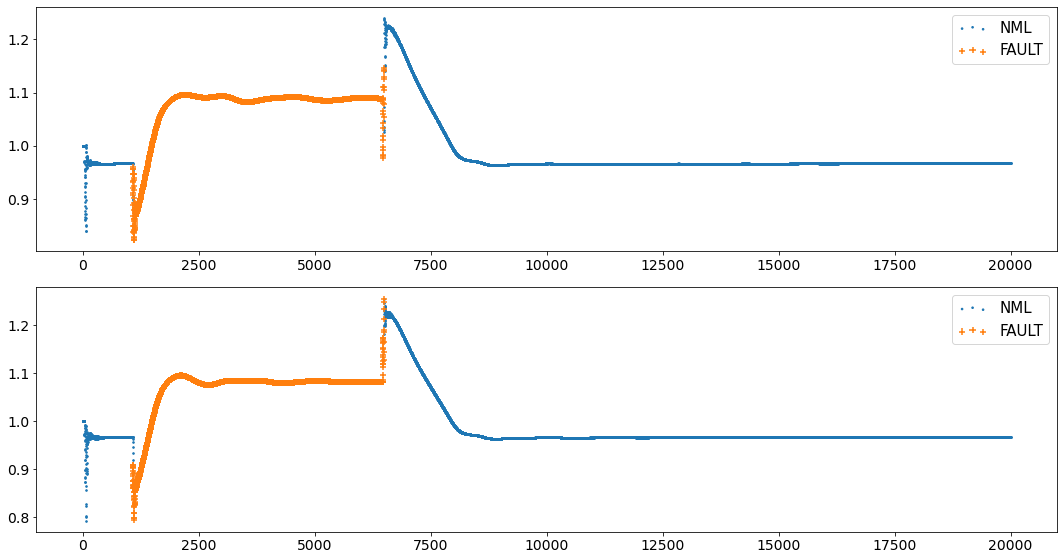

  Fault type Percentage
0         AC     99.94%
1        ACG      0.04%
2       ABCG      0.02%


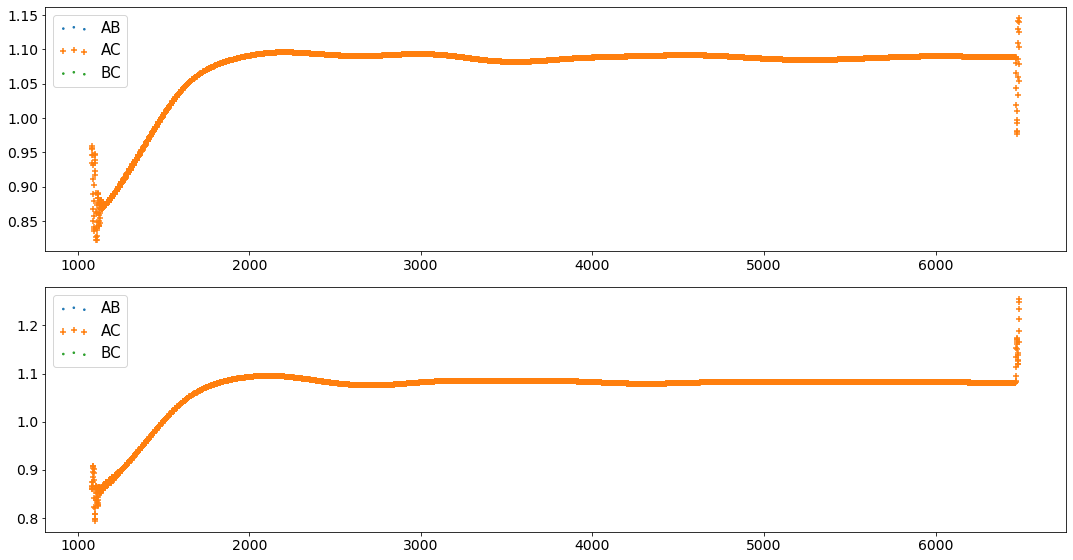


.
.
 5AG.csv
  Fault type Percentage
0        NML     91.31%
1      FAULT       8.7%


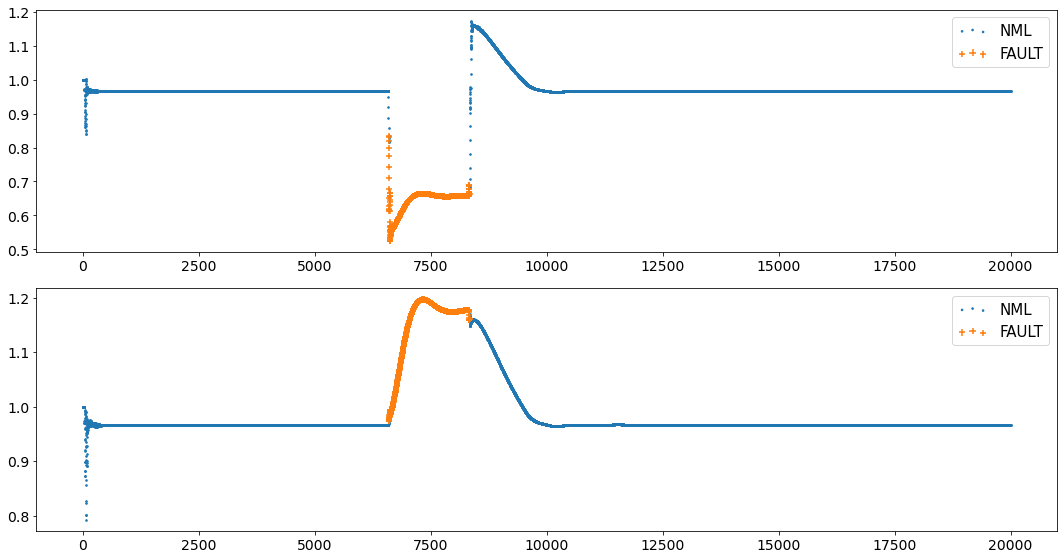

  Fault type Percentage
0         AG     100.0%


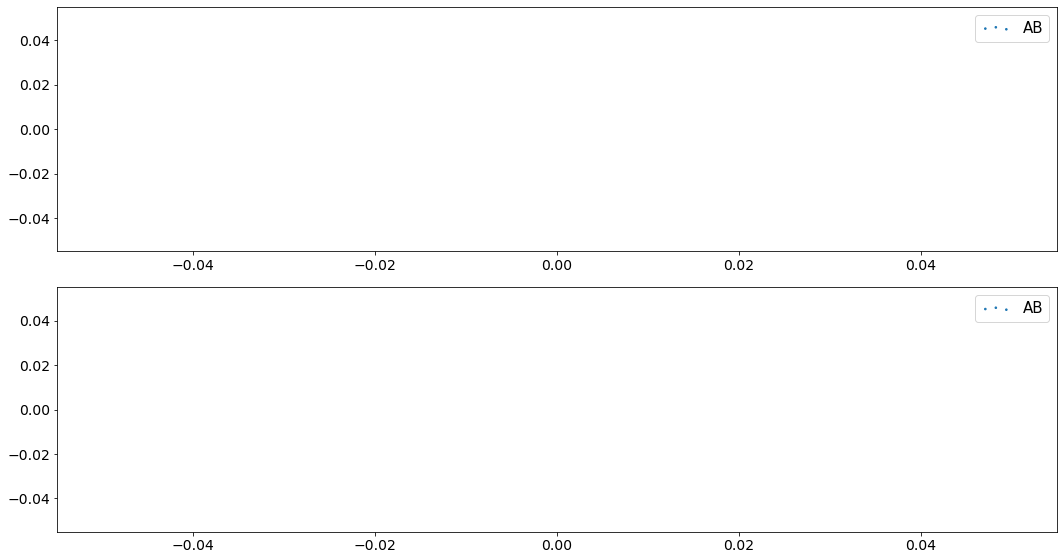


.
.
 1AC.csv
  Fault type Percentage
0        NML     97.66%
1      FAULT      2.35%


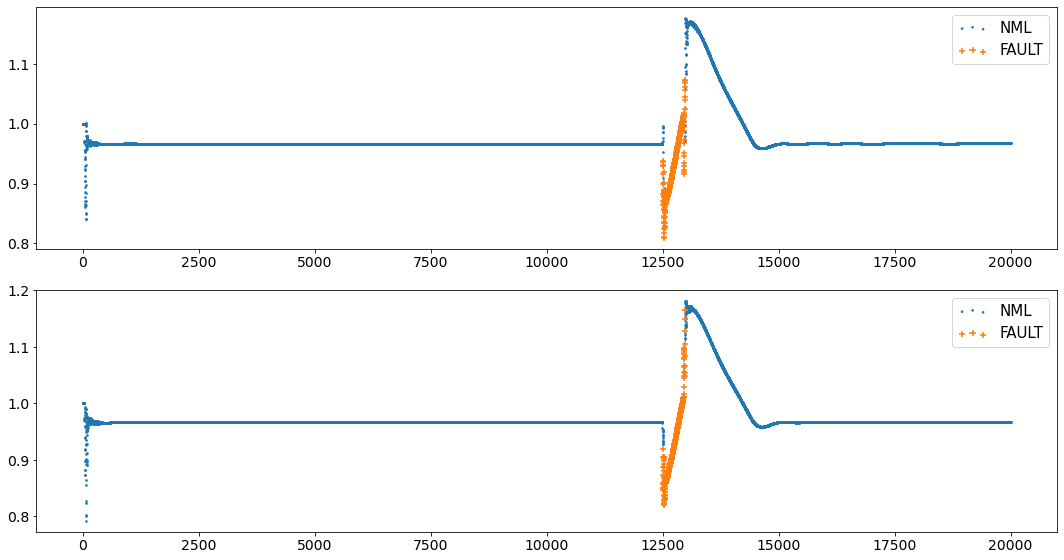

  Fault type Percentage
0         AC      96.8%
1        ACG       3.2%


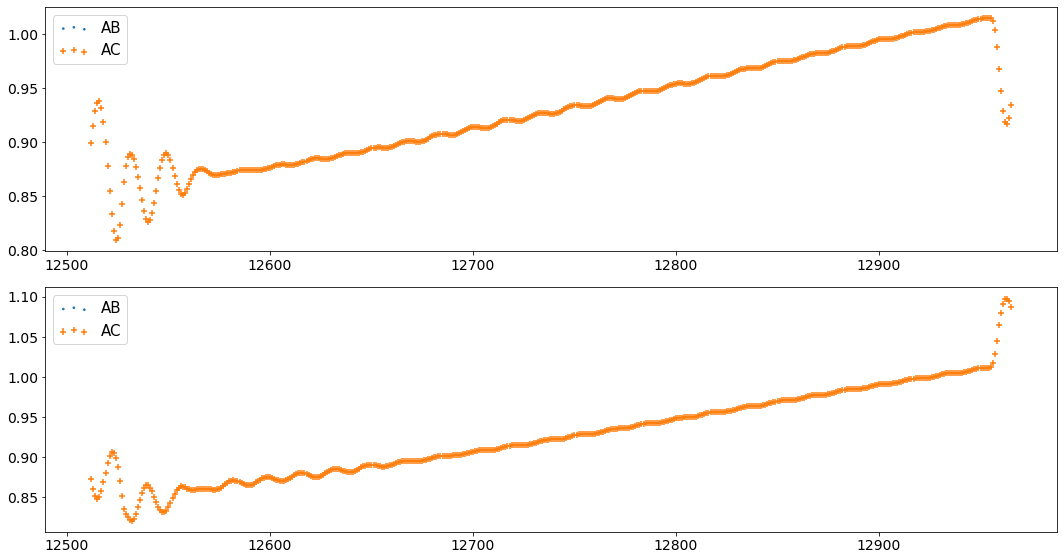


.
.
 2ACG.csv
  Fault type Percentage
0        NML     99.67%
1      FAULT      0.33%


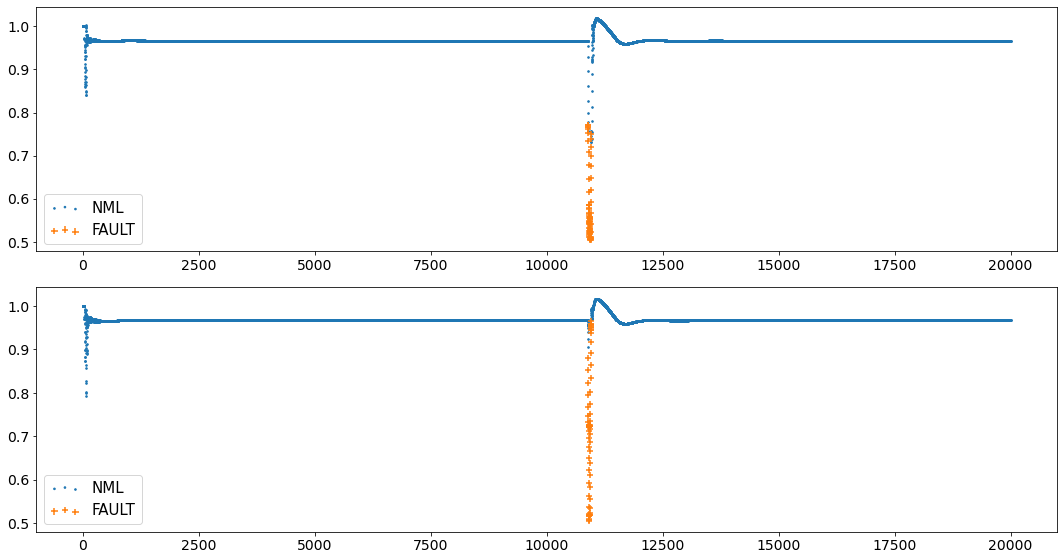

  Fault type Percentage
0        ACG     55.38%
1         AG     33.85%
2       ABCG      4.62%
3        ABG      3.08%
4        ABC      3.08%


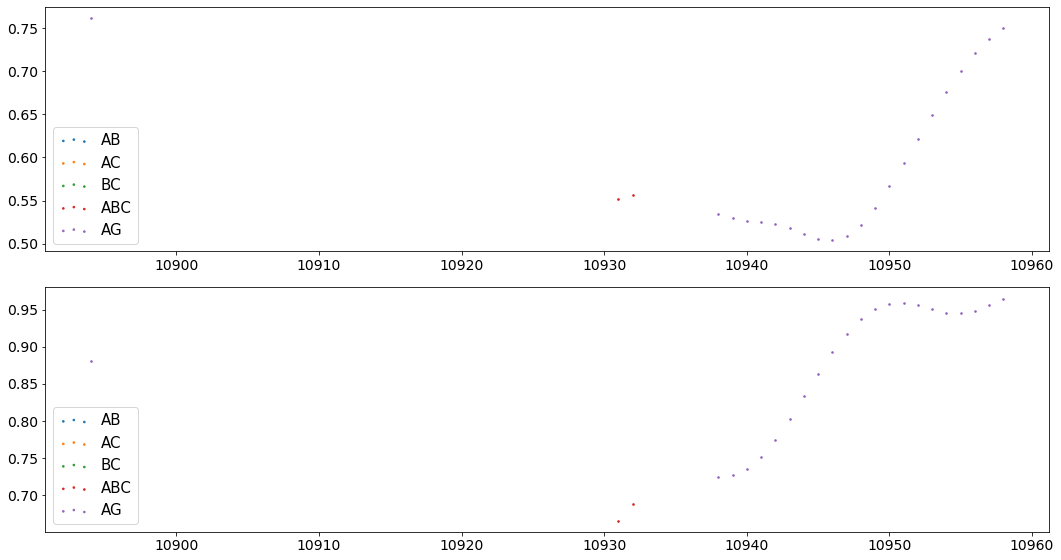


.
.
 1AB.csv
  Fault type Percentage
0        NML     94.69%
1      FAULT      5.32%


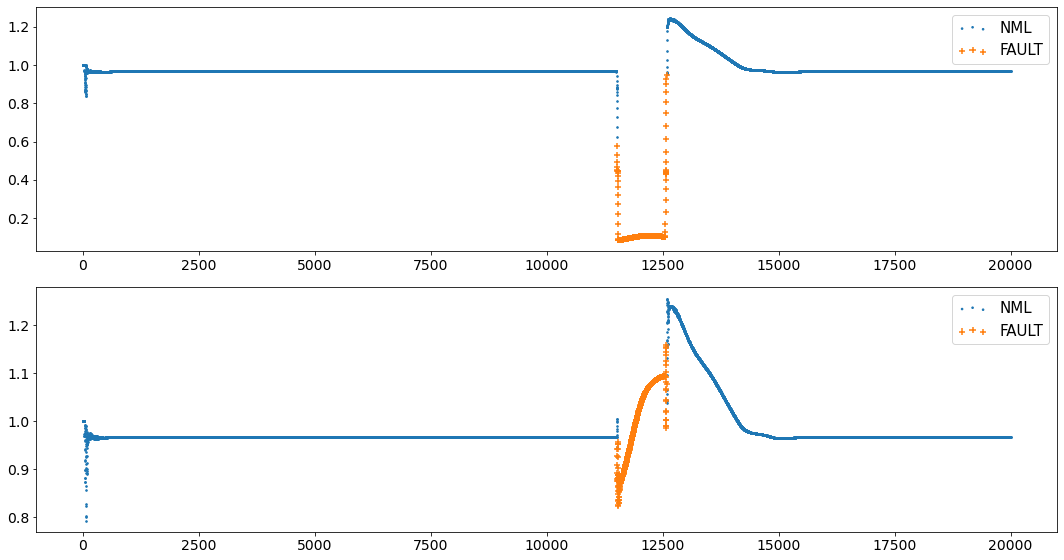

  Fault type Percentage
0         AB     99.72%
1        ABG      0.28%


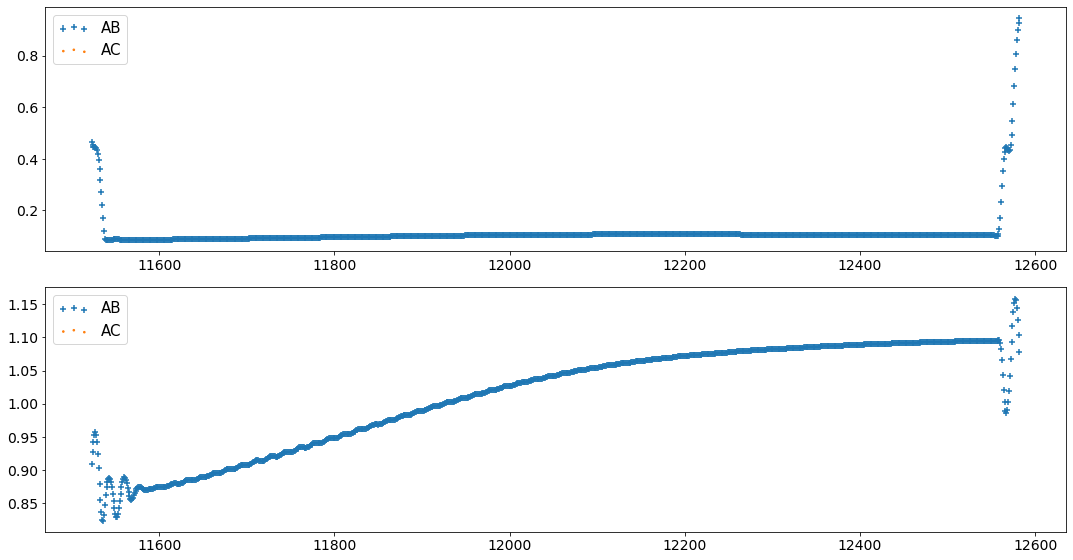


.
.
 2ABC.csv
  Fault type Percentage
0        NML     87.94%
1      FAULT     12.06%


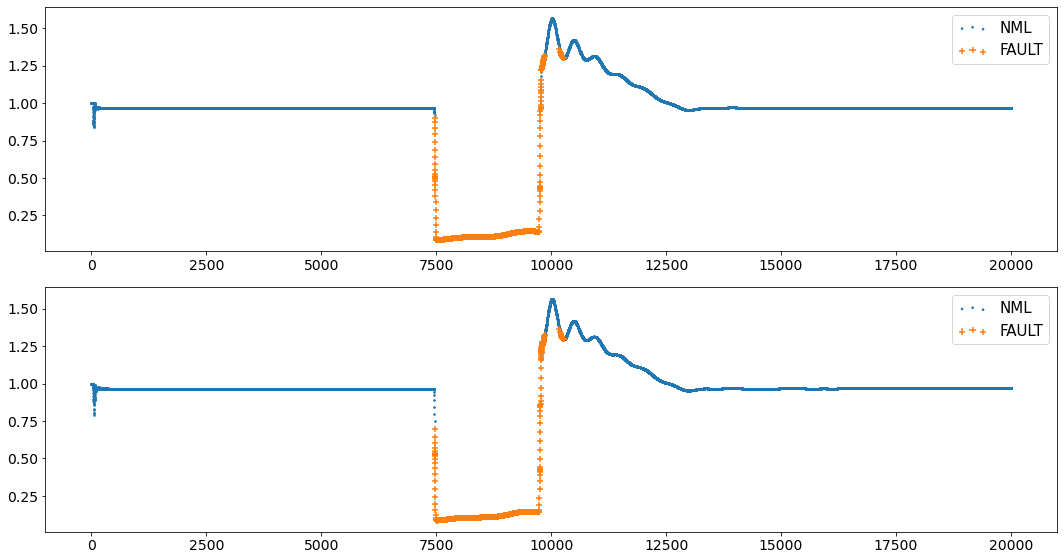

  Fault type Percentage
0        ABC     93.86%
1       ABCG      5.89%
2        BCG      0.25%


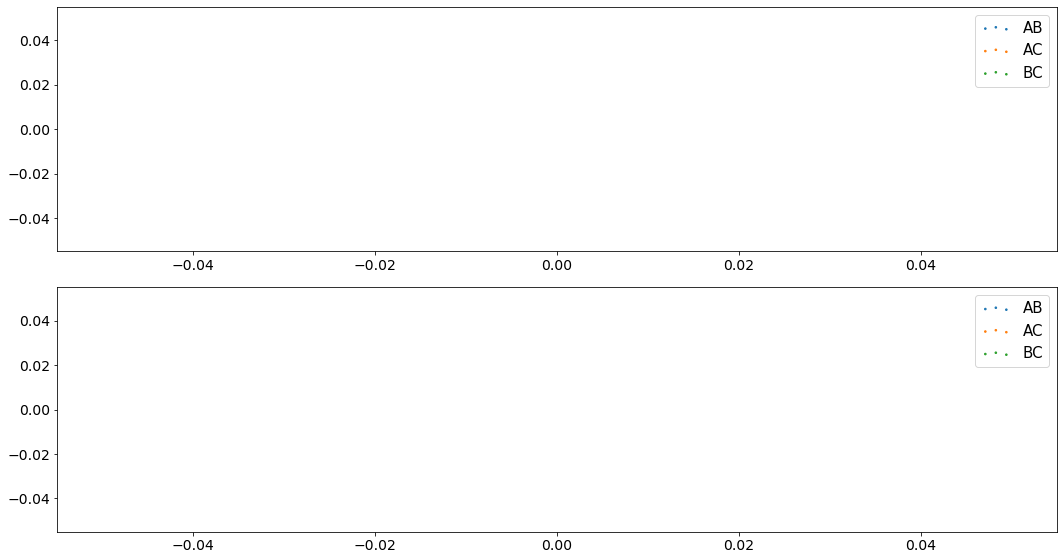


.
.
 9BG.csv
  Fault type Percentage
0        NML     91.33%
1      FAULT      8.66%


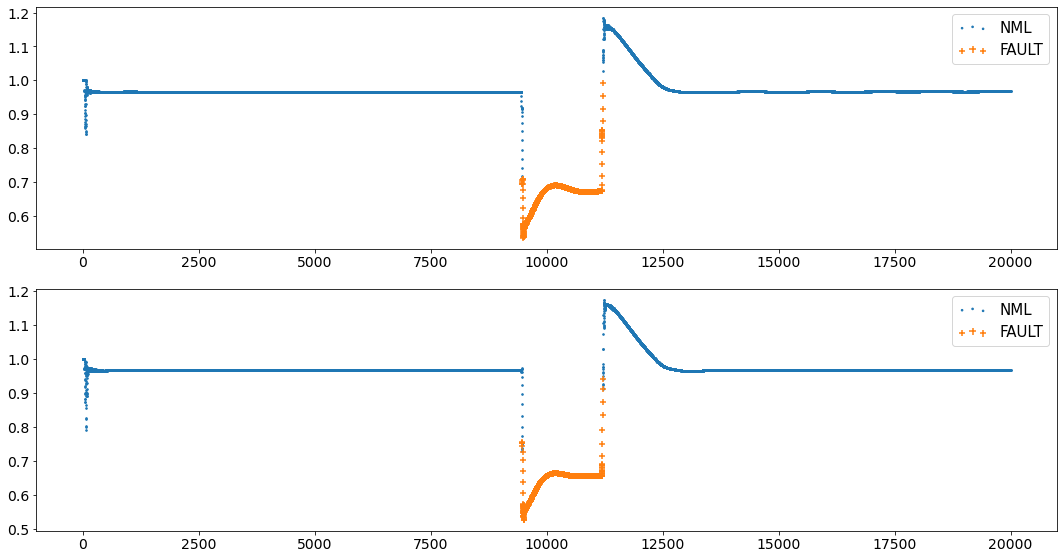

  Fault type Percentage
0         BG     100.0%


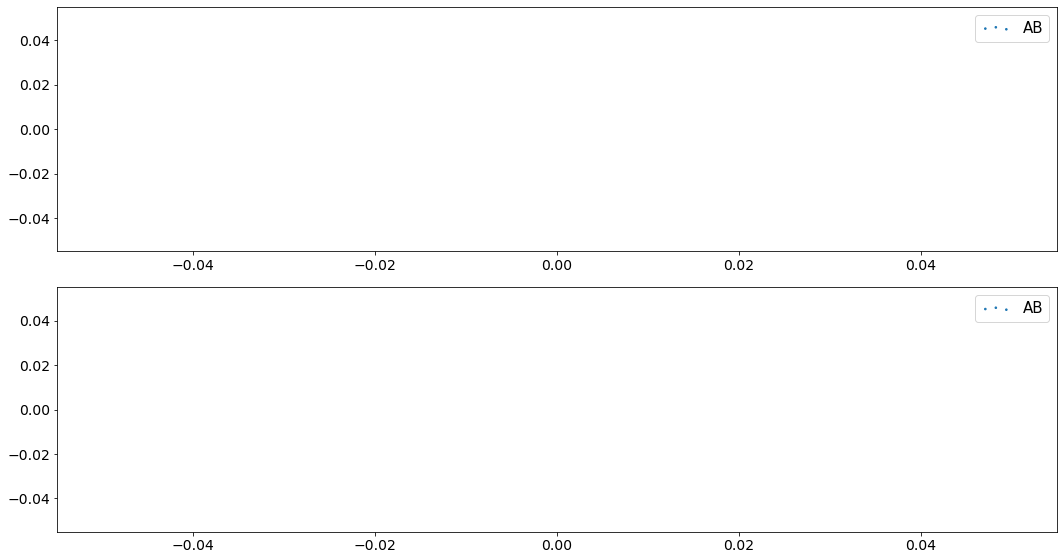


.
.
 9ABCG.csv
  Fault type Percentage
0        NML     78.03%
1      FAULT     21.98%


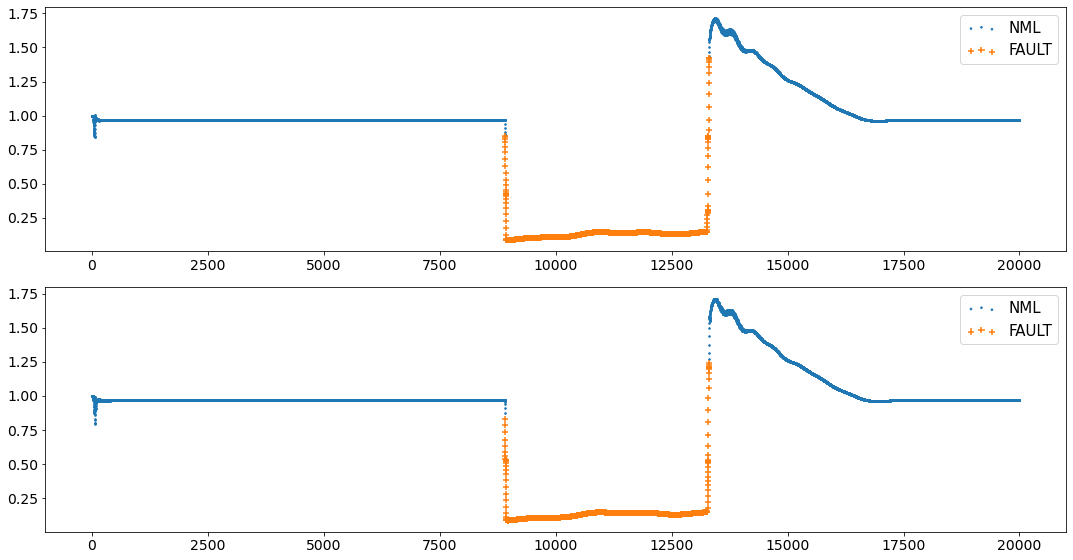

  Fault type Percentage
0        ABC     98.13%
1       ABCG      1.66%
2        ACG      0.14%
3        ABG      0.05%
4        BCG      0.02%


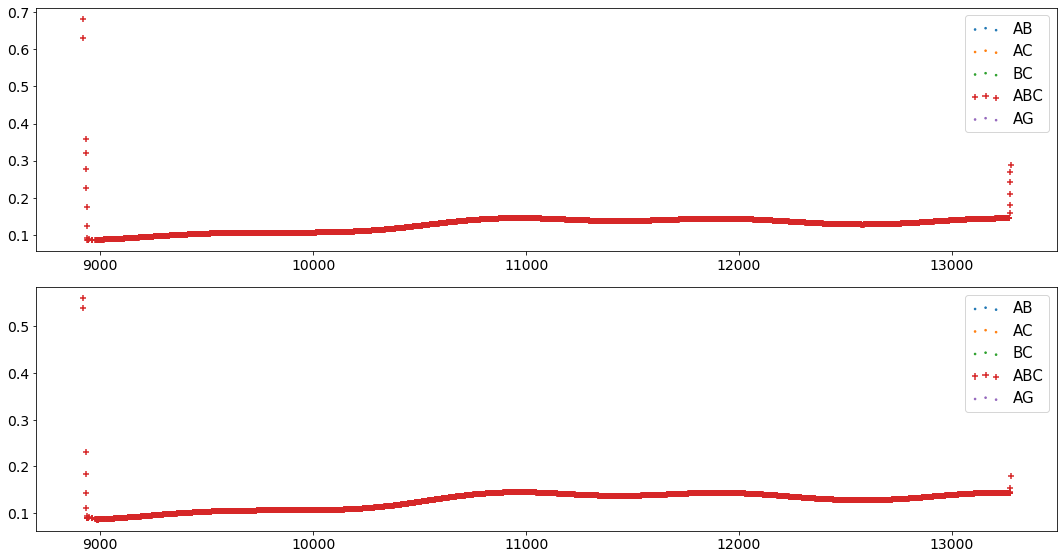


.
.
 3AB.csv
  Fault type Percentage
0        NML      94.2%
1      FAULT      5.79%


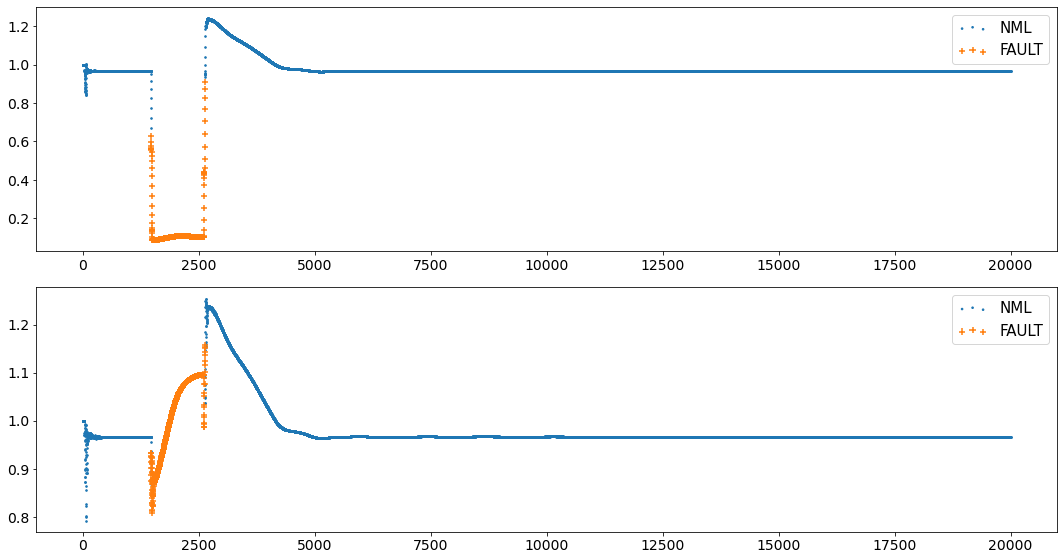

  Fault type Percentage
0         AB     99.83%
1        ABG      0.17%


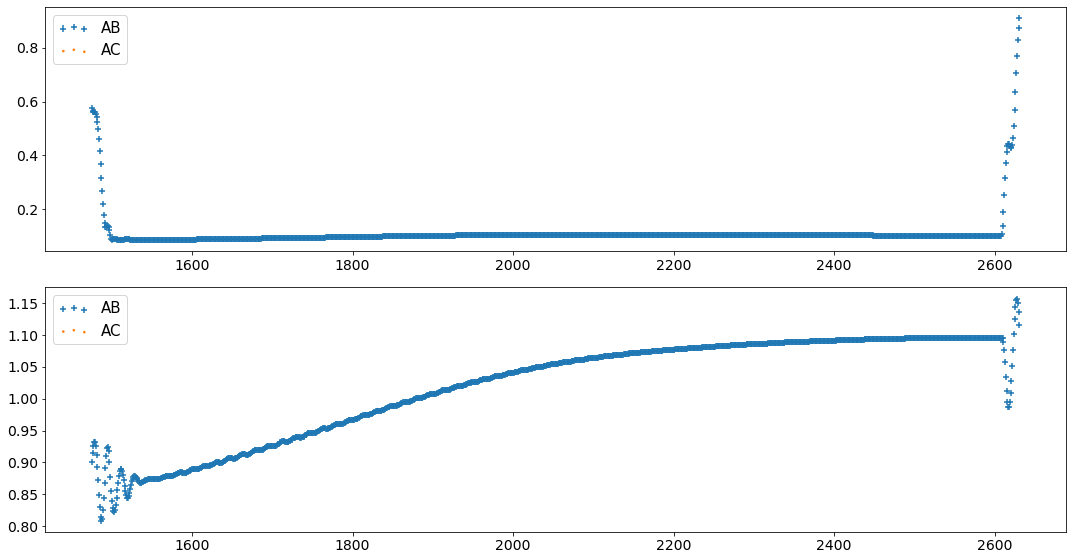


.
.
 3AC.csv
  Fault type Percentage
0        NML     84.83%
1      FAULT     15.17%


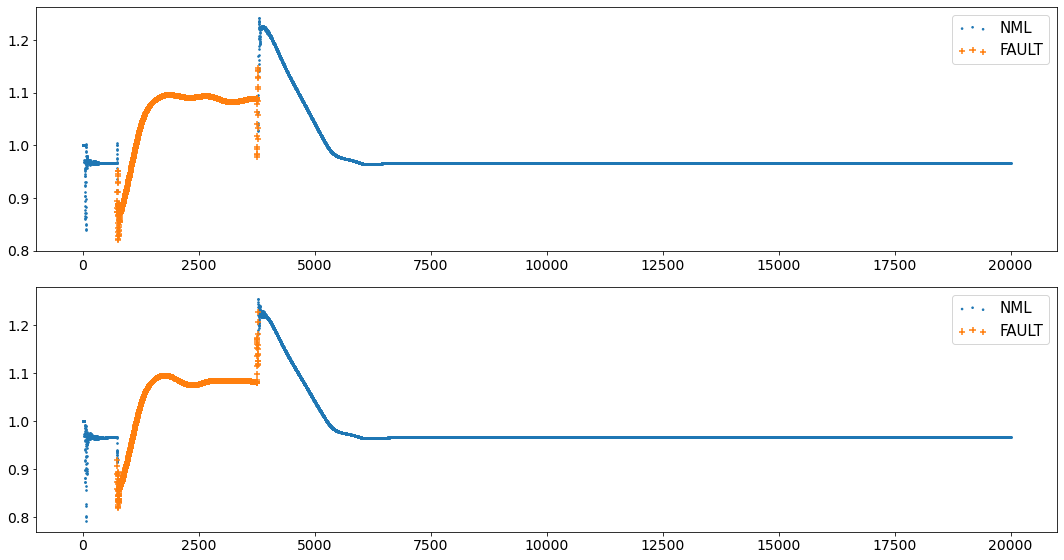

  Fault type Percentage
0         AC     99.87%
1        ACG      0.13%


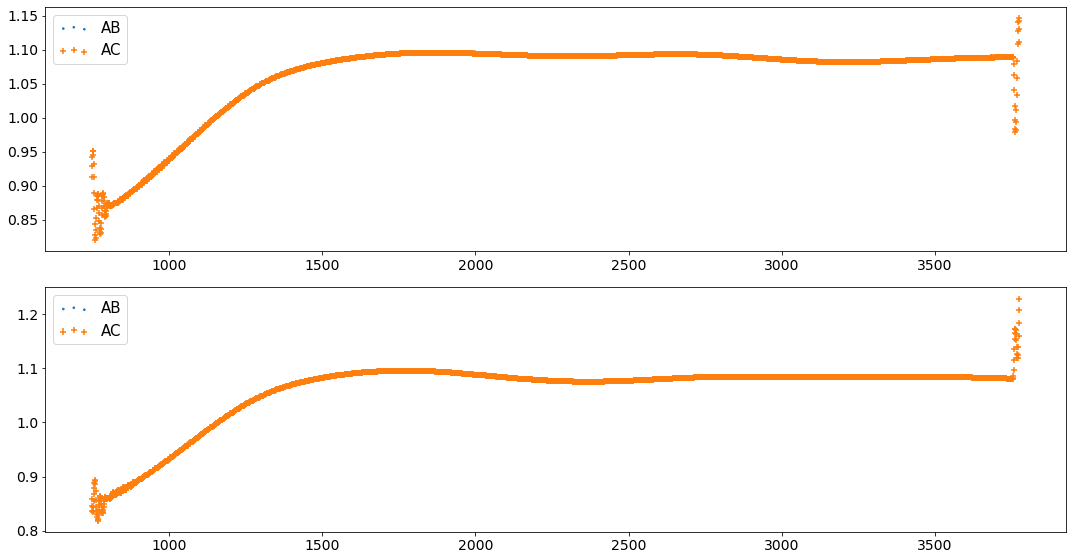


.
.
 4BCG.csv
  Fault type Percentage
0        NML     81.43%
1      FAULT     18.57%


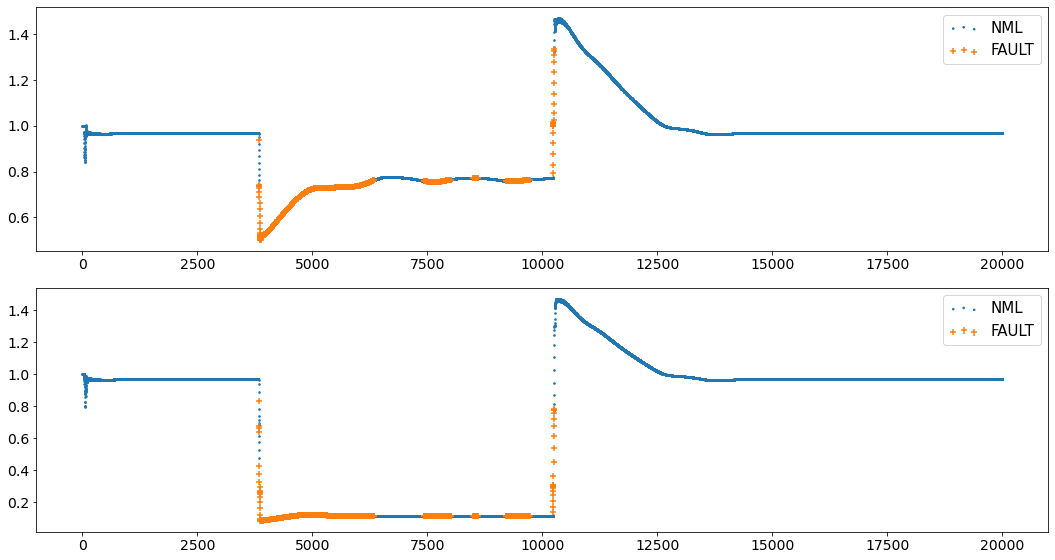

  Fault type Percentage
0        BCG     99.95%
1         CG      0.03%
2       ABCG      0.03%


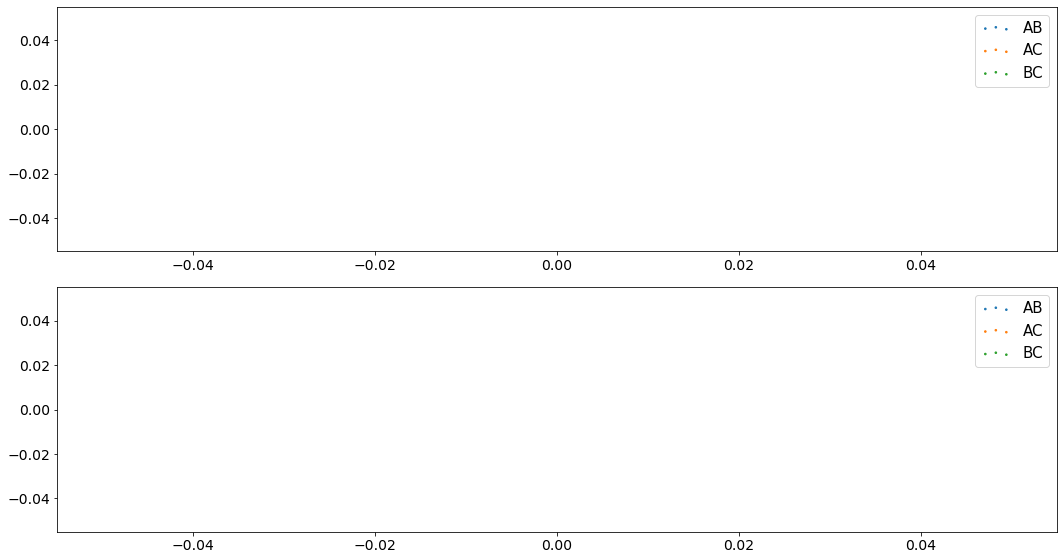


.
.
 7AG.csv
  Fault type Percentage
0        NML     90.06%
1      FAULT      9.94%


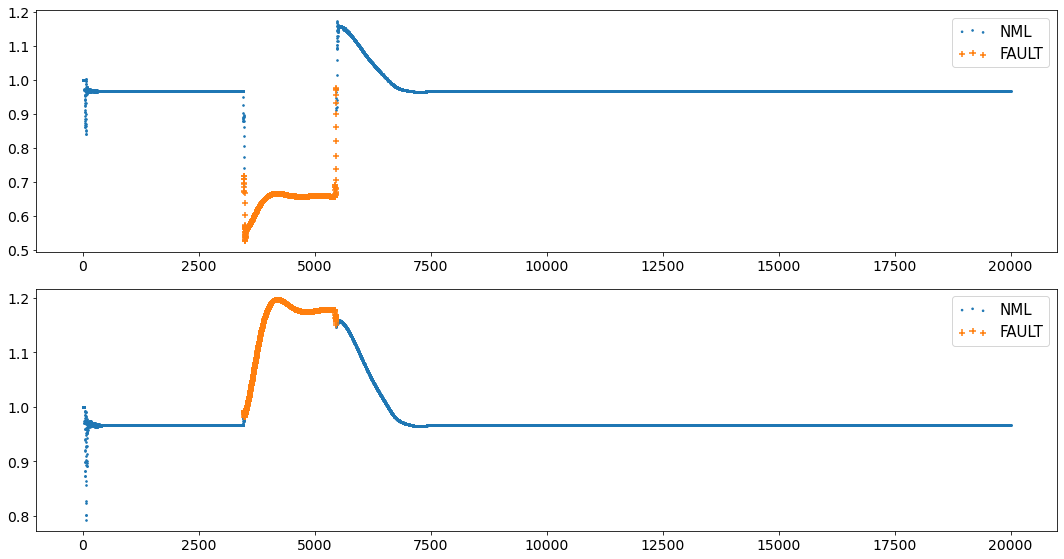

  Fault type Percentage
0         AG     100.0%


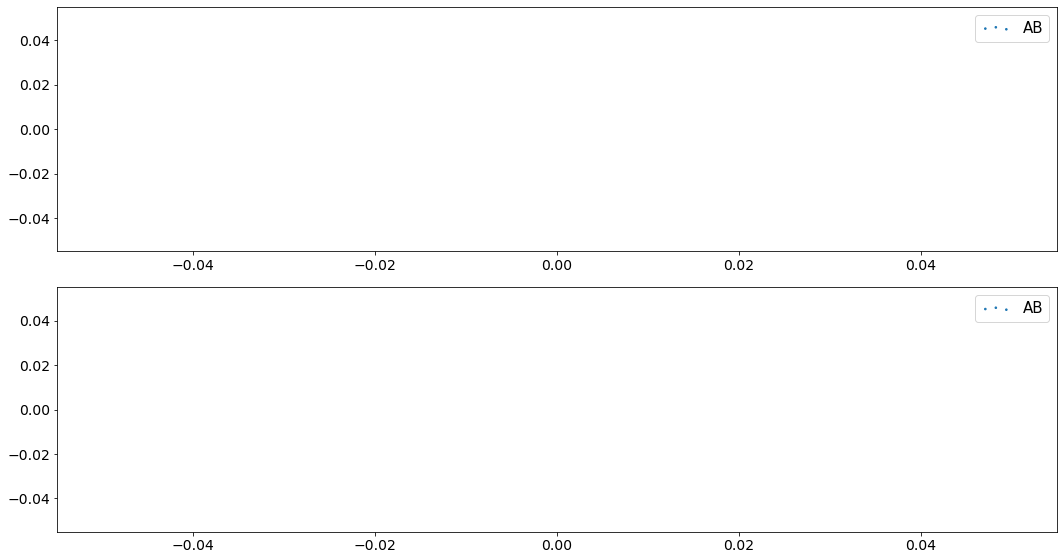


.
.
 8BCG.csv
  Fault type Percentage
0        NML     94.81%
1      FAULT       5.2%


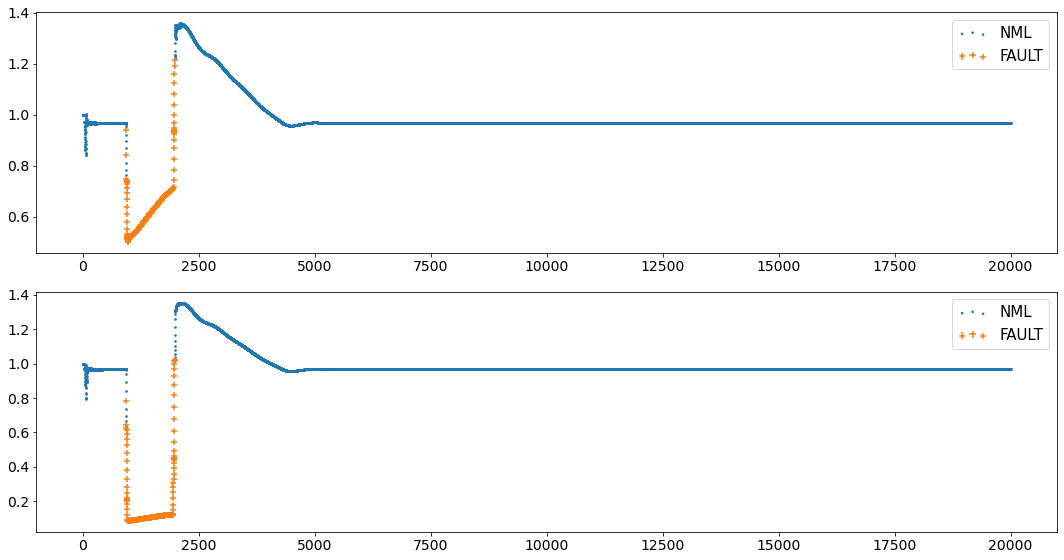

  Fault type Percentage
0        BCG      99.9%
1       ABCG       0.1%


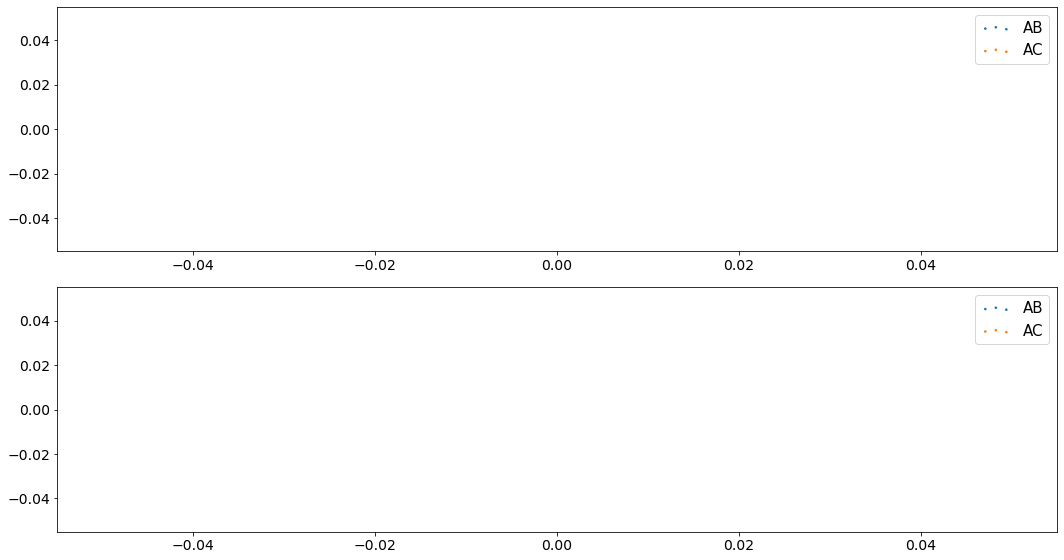

In [213]:
checker = []
for each in file_list:
    print("\n.\n.\n",each)  
    temp = tester(binary_model,pd.read_csv('./TrainingSet/'+each))
    plotter(temp,binary_labels_list,2)
    temp = tester(multi_model,temp[temp.label!=0])
    high = plotter(temp,multi_labels_list,2)
    if high == ''.join([i for i in each.split(".")[0] if not i.isdigit()]):
        checker.append(high)
    else:
        checker.append('incorrect')


In [214]:
files_failing_model = [file_list[i] for i in range(len(checker)) if checker[i]=='incorrect']

names = [''.join([i for i in each.split(".")[0] if not i.isdigit()]) for each in files_failing_model]

In [215]:
Counter(names)

Counter({'ABCG': 9})

___________________________________________________________________
  Fault type Percentage
0        NML      99.4%
1      FAULT       0.6%


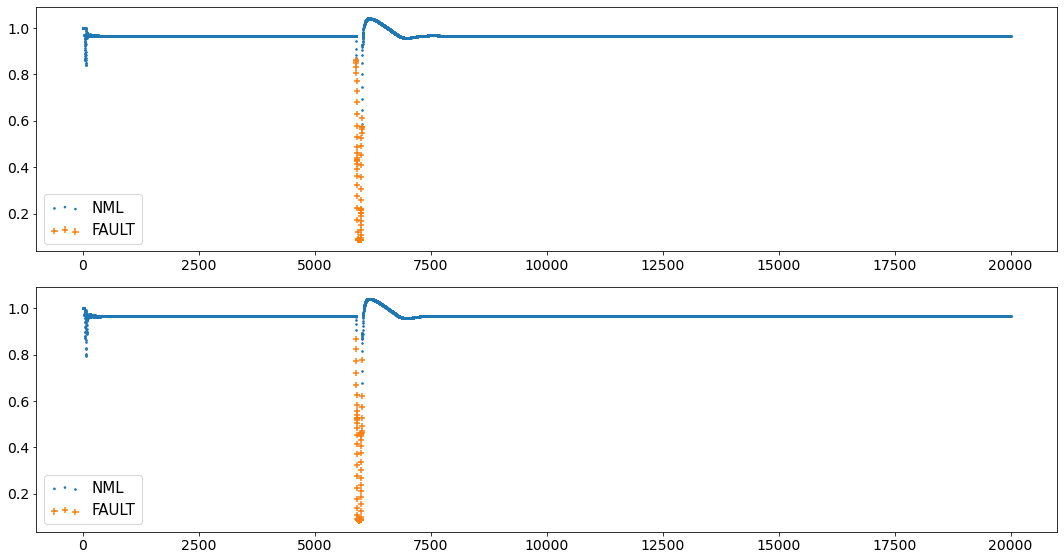

  Fault type Percentage
0       ABCG      47.5%
1        ABC      42.5%
2        ACG      5.83%
3        ABG      3.33%
4        BCG      0.83%


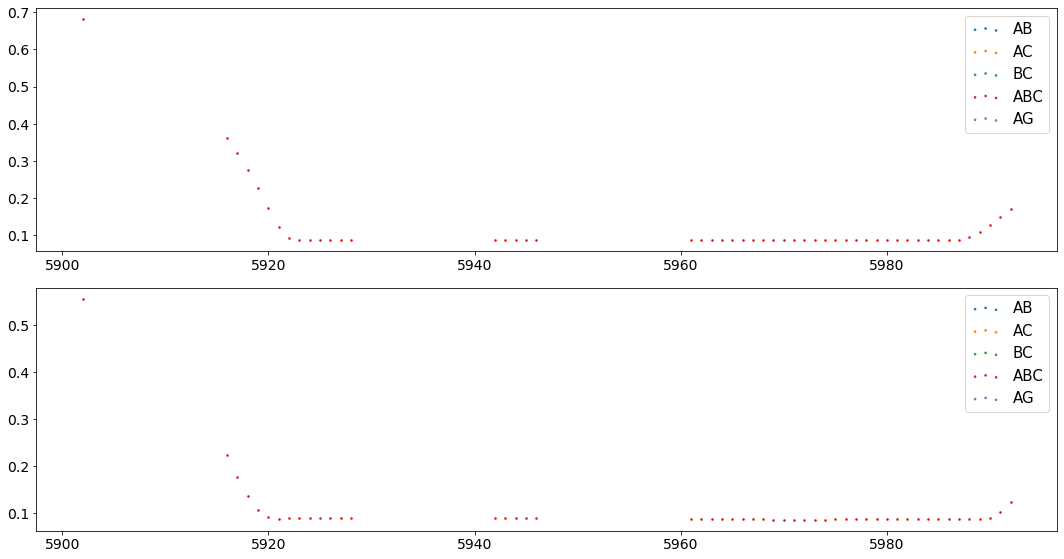

----------------------------------------------------------------
  Fault type Percentage
0        NML     73.42%
1      FAULT     26.57%


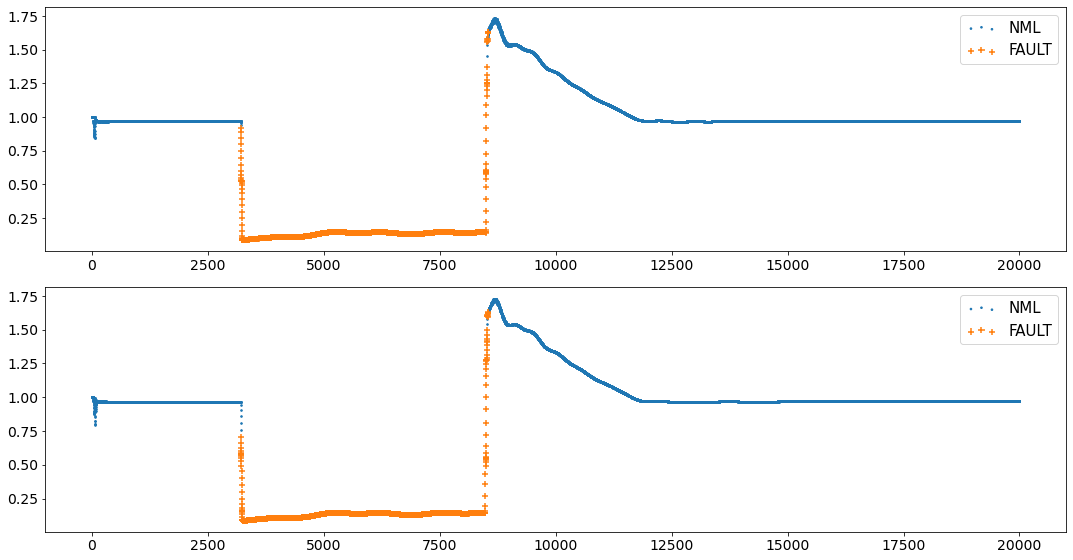

  Fault type Percentage
0        ABC     98.06%
1       ABCG      1.79%
2        BCG      0.15%


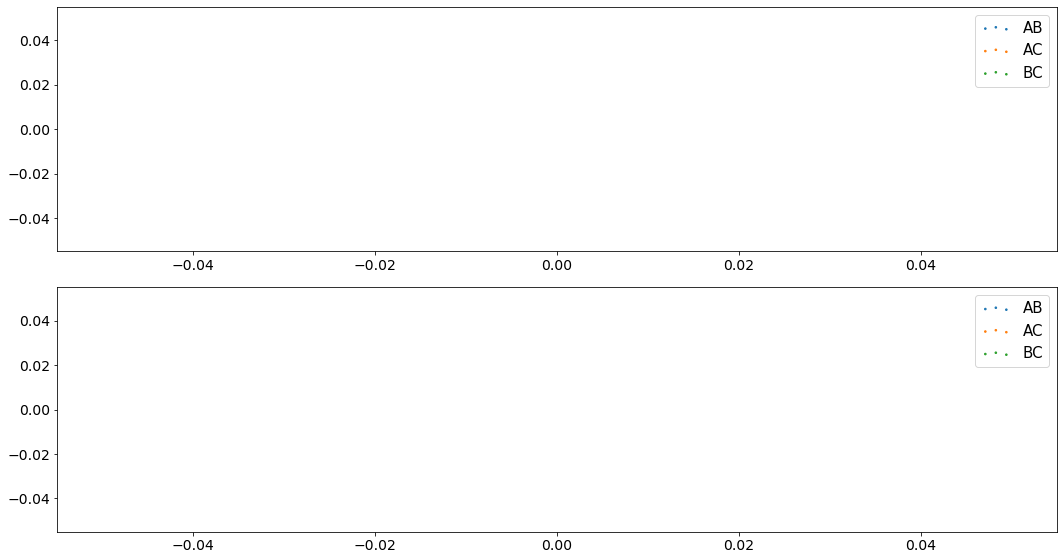

___________________________________________________________________


In [ ]:

for i in range(1,10):
    print("___________________________________________________________________")
    temp = tester(binary_model,pd.read_csv('./TrainingSet/'+str(i)+'ABCG.csv'))
    plotter(temp,binary_labels_list,2)
    temp = tester(multi_model,temp[temp.label!=0])
    plotter(temp,multi_labels_list,2)
    print("----------------------------------------------------------------")
    temp = tester(binary_model,pd.read_csv('./TrainingSet/'+str(i)+'ABC.csv'))
    plotter(temp,binary_labels_list,2)
    temp = tester(multi_model,temp[temp.label!=0])
    plotter(temp,multi_labels_list,2)

In [217]:
data = pd.read_csv('./TrainingSet/1AG.csv')

In [218]:
round(data['3V'])

0         1.0
1         1.0
2         1.0
3         1.0
4         1.0
         ... 
19995    90.0
19996    90.0
19997    90.0
19998    90.0
19999    90.0
Name: 3V, Length: 20000, dtype: float64

In [219]:
dat = Counter((round(data['3V'])/10))
matrics = sorted(zip([each for each in Counter(dat).keys()],Counter(dat).values() ), key=lambda x: x[0])





In [220]:
matrics

[(0.1, 33),
 (4.8, 3),
 (4.9, 2),
 (5.0, 4),
 (5.1, 12),
 (5.2, 19),
 (5.3, 33),
 (5.4, 25),
 (5.5, 22),
 (5.6, 20),
 (5.7, 118),
 (5.8, 74),
 (5.9, 44),
 (6.0, 52),
 (6.1, 44),
 (6.2, 29),
 (6.3, 36),
 (6.4, 39),
 (6.5, 26),
 (6.6, 41),
 (6.7, 26),
 (6.8, 37),
 (6.9, 23),
 (7.0, 34),
 (7.1, 32),
 (7.2, 33),
 (7.3, 22),
 (7.4, 33),
 (7.5, 29),
 (7.6, 33),
 (7.7, 24),
 (7.8, 32),
 (7.9, 32),
 (8.0, 34),
 (8.1, 34),
 (8.2, 34),
 (8.3, 29),
 (8.4, 42),
 (8.5, 176),
 (8.6, 450),
 (8.7, 407),
 (8.8, 328),
 (8.9, 4763),
 (9.0, 359),
 (9.1, 511),
 (9.2, 444),
 (9.3, 182),
 (9.4, 171),
 (9.5, 195),
 (9.6, 194),
 (9.7, 254),
 (9.8, 290),
 (9.9, 204),
 (10.0, 44),
 (10.1, 39),
 (10.2, 91),
 (10.3, 47),
 (11.0, 1),
 (11.6, 1),
 (11.9, 1),
 (12.6, 1),
 (13.2, 1),
 (13.5, 1),
 (13.6, 2),
 (13.7, 3),
 (13.9, 1),
 (14.3, 1),
 (15.0, 1),
 (15.5, 1),
 (16.0, 1),
 (17.1, 1),
 (17.4, 1),
 (18.4, 1),
 (19.0, 1),
 (19.7, 1),
 (20.5, 1),
 (20.9, 1),
 (21.3, 2),
 (21.5, 2),
 (21.8, 2),
 (21.9, 2),
 (22.0, 12

In [221]:
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [222]:
import pandas as pd
data = pd.read_csv('KMTrainingset/2ABG.csv')

In [223]:
features = data[data.columns[:-1]].values.tolist()
#true_labels = data['label'].values.tolist()

In [224]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


In [225]:
kmeans = KMeans(
    init="random",
    n_clusters=2,
    n_init=10,
    max_iter=500,
    random_state=42
)

In [226]:
kmeans.fit(scaled_features)

KMeans(init='random', max_iter=500, n_clusters=2, random_state=42)

In [227]:
kmeans.cluster_centers_

array([[-5.17841799, -4.46756287, -4.41716926,  5.3810473 ,  5.35629939,
         4.90739369],
       [ 0.17339887,  0.14959595,  0.14790852, -0.18018389, -0.17935521,
        -0.16432364]])

In [228]:
labels = kmeans.fit_predict(features)


In [229]:
#data['label']=labels
data.head()

A1   A2   A3   V1   V2   V3  label
0  1.0  1.0  1.0  1.0  1.0  1.0      0
1  1.0  1.0  1.0  1.0  1.0  1.0      0
2  1.0  1.0  1.0  1.0  1.0  1.0      0
3  1.0  1.0  1.0  1.0  1.0  1.0      0
4  1.0  1.0  1.0  1.0  1.0  1.0      0

In [230]:
dic = Counter(labels)

In [231]:
dic

Counter({1: 19350, 0: 650})

In [232]:
if dic[1]>dic[0]:
    print("1 = 0 , 0 =1")
    data['label']=[1 if i == 0 else 0 for i in labels]
else:
    print(True)

1 = 0 , 0 =1


In [233]:
dic = Counter(data['label'])

In [234]:
data

A1       A2       A3      V1      V2      V3  label
0      1.00000  1.00000  1.00000   1.000   1.000   1.000      0
1      1.00000  1.00000  1.00000   1.000   1.000   1.000      0
2      1.00000  1.00000  1.00000   1.000   1.000   1.000      0
3      1.00000  1.00000  1.00000   1.000   1.000   1.000      0
4      1.00000  1.00000  1.00000   1.000   1.000   1.000      0
...        ...      ...      ...     ...     ...     ...    ...
19995  0.96699  0.96701  0.96698  89.068  89.070  89.070      0
19996  0.96700  0.96700  0.96698  89.067  89.070  89.069      0
19997  0.96700  0.96700  0.96698  89.067  89.070  89.068      0
19998  0.96701  0.96699  0.96698  89.067  89.069  89.067      0
19999  0.96701  0.96699  0.96698  89.067  89.069  89.066      0

[20000 rows x 7 columns]

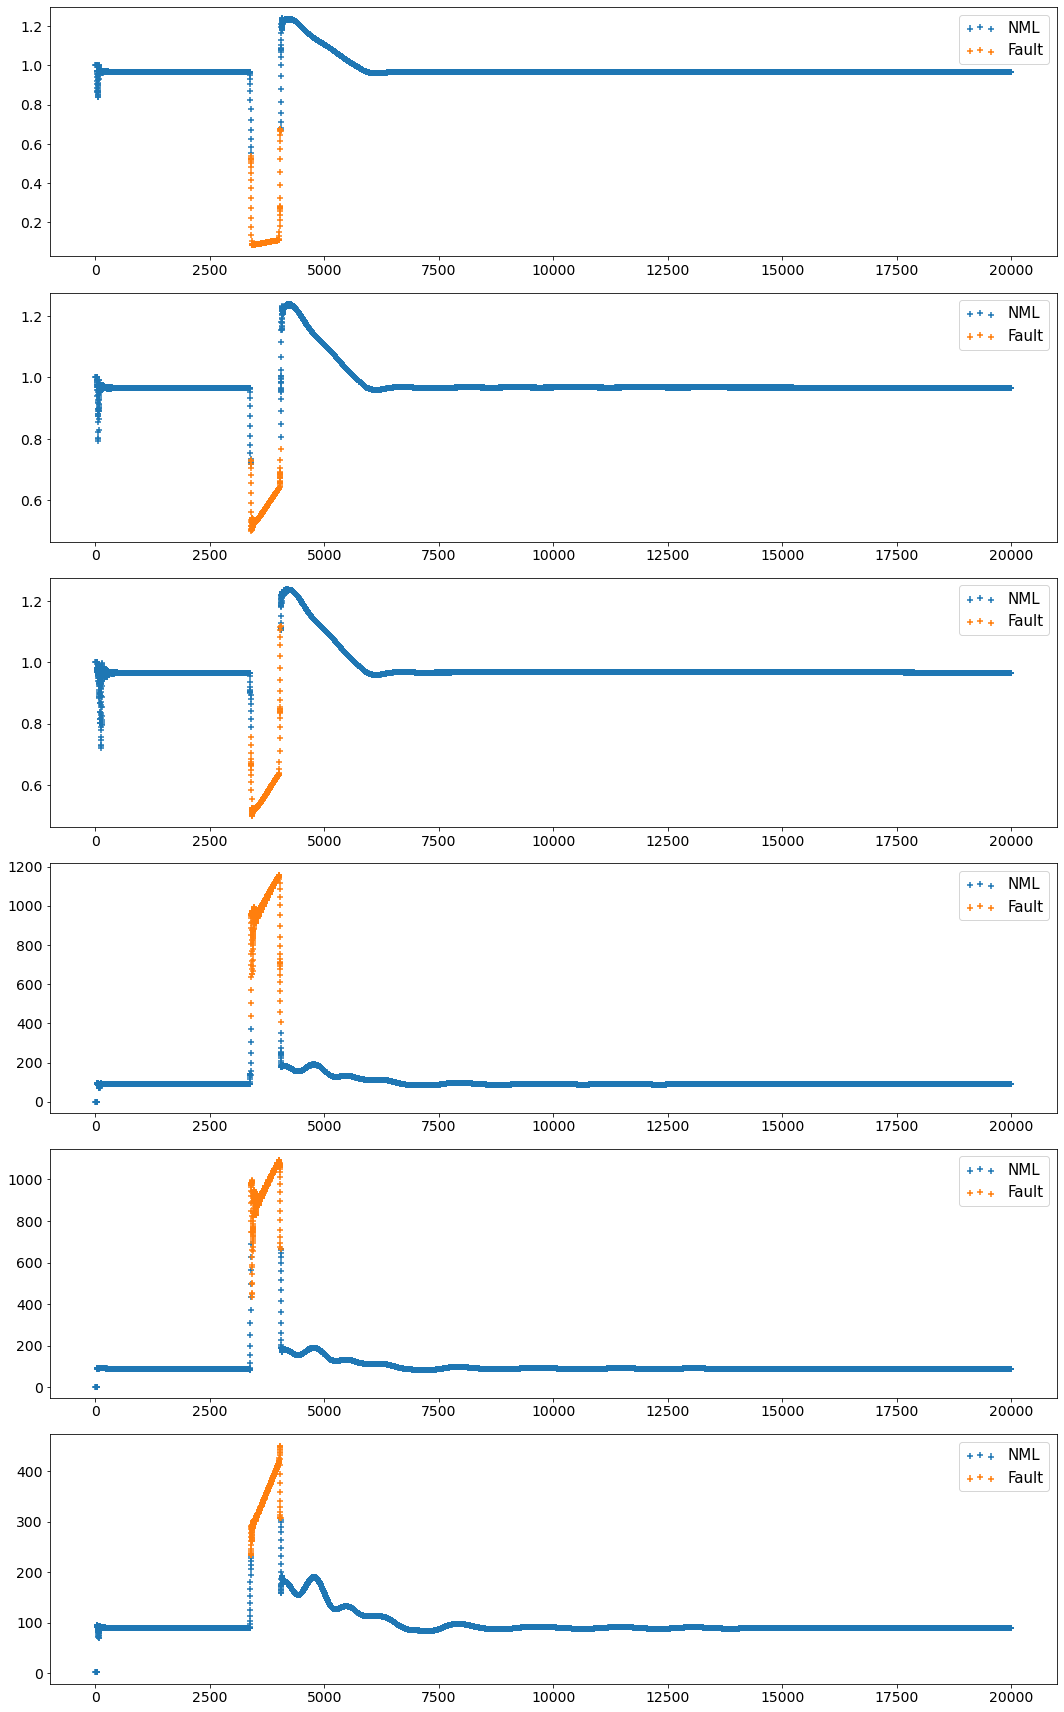

In [235]:
n_plots = 6
fig, ax = plt.subplots(n_plots,figsize=(15,4*n_plots))
unique_labels = ['NML','Fault']
cols = data.columns[:-1]

for j in range(6):

    
    legend_list = []
    for i in list(set(data.label)):
        
        plo = data[data.label == i]
        temp = ax[j].scatter(plo.index,plo[cols[j]],marker='+',s=40)  


        legend_list.append(temp)

    ax[j].legend(legend_list,unique_labels,scatterpoints=3,ncol=1,fontsize=15)

fig.tight_layout()
plt.show()

In [236]:
org = [0,1,0,1,1,1,0,0,1,0,1]
[1 if i == 0 else 0 for i in org]

[1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0]

In [237]:
for x,y in zip(org,[1 if i == 0 else 0 for i in org]):
    print(x+y)

1
1
1
1
1
1
1
1
1
1
1
